In [1]:
# %matplotlib ipympl

In [1]:
import torch
import numpy as np
import Dataset2 as Dataset
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from time import sleep, time

importlib.reload(Dataset)
DatasetContainer = Dataset.DatasetContainer
ProcessingDatasetContainer = Dataset.ProcessingDatasetContainer

def PLTParams(figsize = [15,15]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()

import sys

sys.path.append('/remote/tychodata/ftairli/work/Projects/Graph_FD_Reconstruction/Code/')
sys.path.append('/remote/tychodata/ftairli/work/Projects/Graph_FD_Reconstruction/Models/')


In [2]:
def IndexToXY(indices,return_tensor=False):
    indices -=1
    Xs = indices//22
    Ys = indices%22
    if return_tensor: return Xs.int(),Ys.int()
    else:             return Xs.int().tolist(),Ys.int().tolist()



In [3]:
DataPath = '/remote/tychodata/ftairli/data/Simulations__libraries__MCTask__Offline_v3r99p2a__IdealMC_CORSIKA__Hybrid_CORSIKA76400/SIB23c/DatasetFiles/RawData'

In [4]:
# Importing Dataset
LoadTraces = True
Dataset = DatasetContainer()
Dataset.Load(DataPath,'Test' ,LoadTraces=LoadTraces)

RunsToLoad = ['Run010']
# RunsToLoad = ['Run010','Run030','Run080','Run090']

Run010 = DatasetContainer()
Run010.Load(DataPath,RunsToLoad ,LoadTraces=LoadTraces)
print(Run010.Event_level_keys)
print(Run010.Pixel_level_keys)
# # print(len(Run010))

Loading Test
Loading Run010
{'EventID_1/2': 0, 'EventID_2/2': 1, 'Primary': 2, 'Station_TotalSignal': 3, 'Station_Time': 4, 'Station_Theta': 5, 'Station_Phi': 6, 'Station_Distance': 7, 'Station_Chi_i': 8, 'Gen_LogE': 9, 'Gen_CosZenith': 10, 'Gen_Xmax': 11, 'Gen_dEdXmax': 12, 'Rec_LogE': 13, 'Rec_CosZenith': 14, 'Rec_Xmax': 15, 'Rec_dEdXmax': 16, 'Rec_UspL': 17, 'Rec_UspR': 18, 'Gen_SDPPhi': 19, 'Gen_SDPTheta': 20, 'Gen_Chi0': 21, 'Gen_Rp': 22, 'Gen_T0': 23, 'Gen_CoreEyeDist': 24, 'Rec_SDPPhi': 25, 'Rec_SDPTheta': 26, 'Rec_Chi0': 27, 'Rec_Rp': 28, 'Rec_T0': 29, 'Rec_CoreEyeDist': 30}
{'PixelID': 0, 'TelID': 1, 'EyeID': 2, 'Status': 3, 'Charge': 4, 'Chi_i': 5, 'Theta': 6, 'Phi': 7, 'TimeOffset': 8, 'PulseStart': 9, 'PulseCentroid': 10, 'PulseStop': 11}


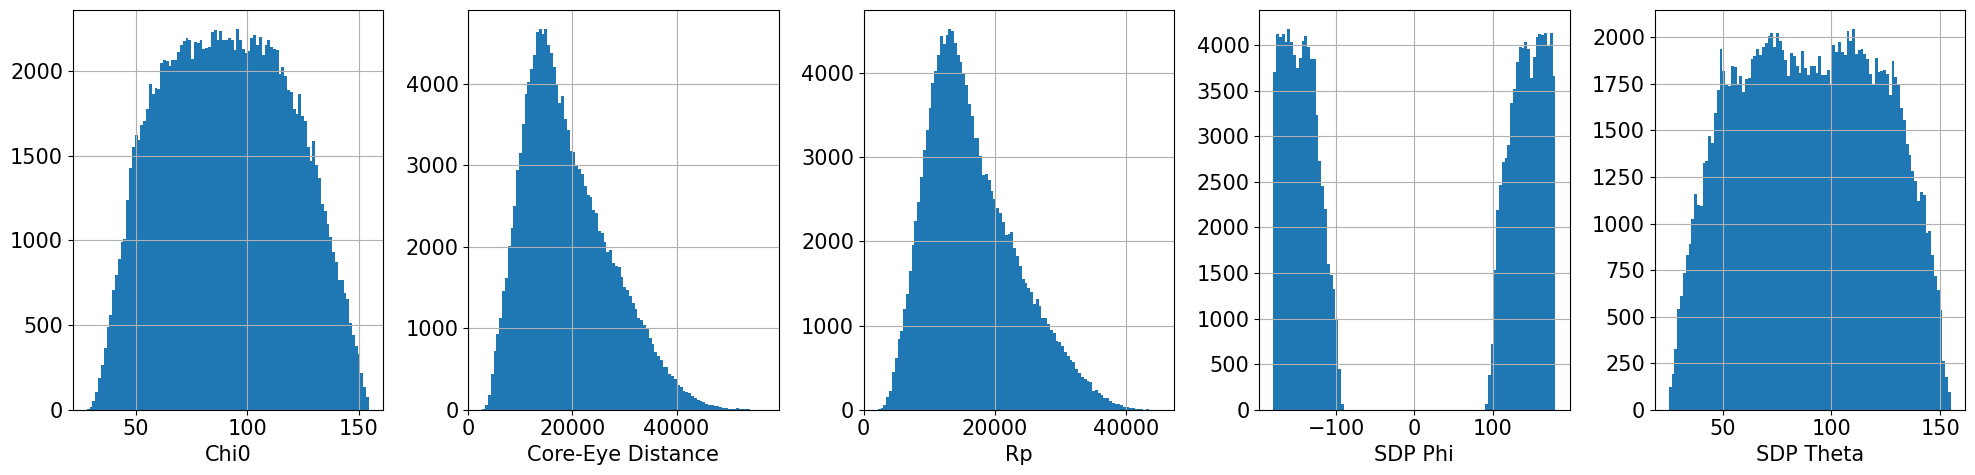

In [13]:
AllGenChi0     = Run010.get_values('Gen_Chi0').numpy()
AllGenCEDist   = Run010.get_values('Gen_CoreEyeDist').numpy()
AllGenRp       = Run010.get_values('Gen_Rp').numpy()
AllGenSDPPhi   = Run010.get_values('Gen_SDPPhi').numpy()
AllGenSDPTheta = Run010.get_values('Gen_SDPTheta').numpy()

AllGenChi0     = AllGenChi0    *180/np.pi
AllGenSDPPhi   = AllGenSDPPhi  *180/np.pi
AllGenSDPTheta = AllGenSDPTheta*180/np.pi


fig,axs = plt.subplots(1,5, figsize=(20,5))
axs[0].hist(AllGenChi0    , bins=100)
axs[1].hist(AllGenCEDist  , bins=100)
axs[2].hist(AllGenRp      , bins=100)
axs[3].hist(AllGenSDPPhi  , bins=100)
axs[4].hist(AllGenSDPTheta, bins=100)
axs[0].set_xlabel('Chi0')
axs[1].set_xlabel('Core-Eye Distance')
axs[2].set_xlabel('Rp')
axs[3].set_xlabel('SDP Phi')
axs[4].set_xlabel('SDP Theta')
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
axs[4].grid()
plt.tight_layout()
plt.savefig('/remote/tychodata/ftairli/work/CDEs/Geometry_old.png')


# Making LSTM Axis Reconstruction

In [363]:
def Unnormalise_LSTM_Axis(Truth,AuxData=None):
    lightspeed = 299792458/1e7 # m/100ns
    # Truth[:,0] = Truth[:,0]
    # Truth[:,1] = Truth[:,1]
    # Truth[:,2] = Truth[:,2]
    Truth[:,4] = Truth[:,4]*lightspeed
    Truth[:,3] = (torch.asin(Truth[:,3])+torch.pi/2)/torch.pi*180
    Truth[:,3][Truth[:,3]>180] -= 360
    if AuxData is None:
        return Truth
    else:
        Truth[:,1] += AuxData
        return Truth
    
def LSTM_Axis(Dataset,ProcessingDataset = None):
    '''Produce LSTM ready dataset with trace values:
    Channels of the trace are: [Elevation, Azimuth,Chi_i,Signal]
    Station Data is added later, with Chi_i also'''
    lighspeed = 299792458/1e7 # m/100ns

    PhiOffsets = {1:-75/180*torch.pi,2:-45/180*torch.pi,3:-15/180*torch.pi,4:15/180*torch.pi,5:45/180*torch.pi,6:75/180*torch.pi}
    IDsList = ()
    Main    = []
    Main_st = []
    Truth   = []
    Rec     = []
    AuxData = []
    Meta    = []

    for i, Event in enumerate(Dataset):

        ID = (Event.get_value('EventID_1/2').int()*100000 + Event.get_value('EventID_2/2').int()).item()
        IDsList += (ID,)

        Pix_Phi      = Event.get_pixel_values('Phi'            )
        Pix_Theta    = Event.get_pixel_values('Theta'          )
        Pix_ID       = Event.get_pixel_values('PixelID'        )
        Pix_TelID    = Event.get_pixel_values('TelID'          )
        Pix_PStart   = Event.get_pixel_values('PulseStart'     )
        Pix_PStop    = Event.get_pixel_values('PulseStop'      )
        Pix_TOffset  = Event.get_pixel_values('TimeOffset'     )
        Pix_Chi_i    = Event.get_pixel_values('Chi_i'          )        
        Pix_Status   = Event.get_pixel_values('Status'         )

        Pix_Traces   = Event.get_trace_values()

        Pix_Phi     = Pix_Phi[Pix_Status>2]
        Pix_Theta   = Pix_Theta[Pix_Status>2]
        Pix_ID      = Pix_ID[Pix_Status>2]
        Pix_TelID   = Pix_TelID[Pix_Status>2]
        Pix_PStart  = Pix_PStart[Pix_Status>2]
        Pix_PStop   = Pix_PStop[Pix_Status>2]
        Pix_TOffset = Pix_TOffset[Pix_Status>2]
        Pix_Chi_i   = Pix_Chi_i[Pix_Status>2]
        Pix_Status  = Pix_Status[Pix_Status>2]

        Pix_Pstart  = Pix_PStart.int()
        Pix_Pstop   = Pix_PStop.int()
        Pix_TOffset = Pix_TOffset.int()
        


        Comb_Trace_Start = (Pix_PStart+Pix_TOffset).min().item()
        Comb_Trace_Stop  = (Pix_PStop +Pix_TOffset).max().item()
        Comb_Trace_Start = int(Comb_Trace_Start)
        Comb_Trace_Stop  = int(Comb_Trace_Stop)
        
        CombTrace = torch.zeros(Comb_Trace_Stop-Comb_Trace_Start)
        CombTheta = torch.zeros(Comb_Trace_Stop-Comb_Trace_Start)
        CombPhi   = torch.zeros(Comb_Trace_Stop-Comb_Trace_Start)
        CombChi_i = torch.zeros(Comb_Trace_Stop-Comb_Trace_Start)

        CombWeights = torch.zeros(Comb_Trace_Stop-Comb_Trace_Start)
        CombNpix    = torch.zeros(Comb_Trace_Stop-Comb_Trace_Start)

        for iPix in range(len(Pix_Phi)):
            This_Comb_PStart =      Pix_PStart[iPix]+Pix_TOffset[iPix]-Comb_Trace_Start
            This_Comb_PStop  = min([Pix_PStop [iPix]+Pix_TOffset[iPix]-Comb_Trace_Start,This_Comb_PStart+100])
            This_Comb_PStart = int(This_Comb_PStart.item())
            This_Comb_PStop  = int(This_Comb_PStop .item())
            This_PulseLenght = min([100,(Pix_Pstop[iPix]-Pix_Pstart[iPix]).item()])
            This_Trace = Pix_Traces[iPix,:This_PulseLenght]
            CombTrace  [This_Comb_PStart:This_Comb_PStop] += This_Trace
            CombTheta  [This_Comb_PStart:This_Comb_PStop] += Pix_Theta[iPix]*torch.abs(This_Trace)
            CombPhi    [This_Comb_PStart:This_Comb_PStop] += Pix_Phi[iPix]  *torch.abs(This_Trace)
            CombChi_i  [This_Comb_PStart:This_Comb_PStop] += Pix_Chi_i[iPix]*torch.abs(This_Trace)
            CombWeights[This_Comb_PStart:This_Comb_PStop] += 1*torch.abs(This_Trace)
            CombNpix   [This_Comb_PStart:This_Comb_PStop] += 1

        CombTheta = CombTheta/CombWeights
        CombPhi   = CombPhi  /CombWeights
        CombChi_i = CombChi_i/CombWeights

        # Normalize
        NoSigMask = (CombTrace==0)|(CombWeights==0)      # care - it is possible to have zero total signal
        CombTrace = torch.log10(torch.clip((CombTrace+1),min=1))
        CombTheta = 90-CombTheta
        CentralCombPhi = CombPhi[~NoSigMask].mean()
        CombPhi   = CombPhi - CentralCombPhi
        # CommbChi_i = CombChi_i


        # CombTheta = torch.cos(CombTheta*torch.pi/180)
        # CombPhi   = torch.sin(CombPhi  *torch.pi/180)

        CombTheta[NoSigMask] = -1              
        CombPhi  [NoSigMask] = -1
        CombChi_i[NoSigMask] = -1
        
        This_Main = torch.zeros(1000,4)
        This_Main[:CombTrace.shape[0],0] = CombTrace[-1000:] # In case the trace is longer than 1000
        This_Main[:CombTheta.shape[0],1] = CombTheta[-1000:]
        This_Main[:CombPhi  .shape[0],2] = CombPhi  [-1000:]
        This_Main[:CombChi_i.shape[0],3] = CombChi_i[-1000:]

        # The end of Main is now zeros, need to move these zeros to the front
        This_Main = torch.roll(This_Main,shifts=1000-CombTrace.shape[0],dims=0)

        # Get Truth and Rec
        Gen_SDPTheta = Event.get_value('Gen_SDPTheta')
        Gen_SDPPhi   = Event.get_value('Gen_SDPPhi'  )
        Gen_Chi0     = Event.get_value('Gen_Chi0'    )
        Gen_CEDist   = Event.get_value('Gen_CoreEyeDist')


        Rec_SDPTheta = Event.get_value('Rec_SDPTheta')
        Rec_SDPPhi   = Event.get_value('Rec_SDPPhi'  )
        Rec_Chi0     = Event.get_value('Rec_Chi0'    )
        Rec_CEDist   = Event.get_value('Rec_CoreEyeDist')
        
        Gen_SDPTheta -= torch.pi/2
        Gen_Chi0     -= torch.pi/2
        Rec_SDPTheta -= torch.pi/2
        Rec_Chi0     -= torch.pi/2

        Gen_x = torch.sin(Gen_Chi0)*torch.cos(Gen_SDPTheta)
        Gen_y = torch.sin(Gen_SDPTheta)
        Gen_z = torch.cos(Gen_Chi0)*torch.cos(Gen_SDPTheta)

        Rec_x = torch.sin(Rec_Chi0)*torch.cos(Rec_SDPTheta)
        Rec_y = torch.sin(Rec_SDPTheta)
        Rec_z = torch.cos(Rec_Chi0)*torch.cos(Rec_SDPTheta)

        This_Truth = torch.tensor([Gen_x,Gen_y,Gen_z,Gen_SDPPhi,Gen_CEDist])
        This_Rec   = torch.tensor([Rec_x,Rec_y,Rec_z,Rec_SDPPhi,Rec_CEDist])

        This_Meta  = torch.tensor([Event.get_value('Primary'),Event.get_value('Gen_LogE'),Event.get_value('Gen_Xmax')])
        This_Aux   = torch.tensor([CentralCombPhi])
        
        Station_Distance = Event.get_value('Station_Distance')/30000
        Station_Theta    = Event.get_value('Station_Theta'   )*180/torch.pi
        Station_Phi      = Event.get_value('Station_Phi'     )*180/torch.pi
        Station_Chi_i    = Event.get_value('Station_Chi_i'   )*180/torch.pi
        Station_Time     = Event.get_value('Station_Time'    )/1000

        This_MainSt = torch.tensor([Station_Distance,Station_Theta,Station_Phi,Station_Chi_i,Station_Time])
        
        Main   .append(This_Main)
        Main_st.append(This_MainSt)
        Truth  .append(This_Truth)
        Rec    .append(This_Rec)
        Meta   .append(This_Meta)
        AuxData.append(torch.tensor([CentralCombPhi]))

    
        if (ProcessingDataset is None) and  (len(Truth)>10000) : break

    Main    = torch.stack(Main   ,dim=0)
    Main_st = torch.stack(Main_st,dim=0)
    Truth   = torch.stack(Truth  ,dim=0)
    Rec     = torch.stack(Rec    ,dim=0)
    Meta    = torch.stack(Meta   ,dim=0)
    AuxData = torch.stack(AuxData,dim=0)

    
    # Renormalise phi
    Truth[:,3][Truth[:,3]<0] += 2*torch.pi 
    Truth[:,3] -= torch.pi/2
    Truth[:,3] -= AuxData.squeeze()/180*torch.pi
    Truth[:,3] = torch.sin(Truth[:,1])
    Truth[:,4] /= lighspeed*1000

    Rec[:,3][Rec[:,3]<0] += 2*torch.pi
    Rec[:,3] -= torch.pi/2
    Rec[:,3] -= AuxData.squeeze()/180*torch.pi
    Rec[:,3] = torch.sin(Rec[:,1])
    Rec[:,4] /= lighspeed*1000

    # Slap into Dataset
    if ProcessingDataset is None:
        return (Main,Main_st), AuxData, Truth, Rec, Meta, IDsList
    
    else:
        ProcessingDataset._Main.append(Main) # Must append only main for multiple Mains possibility
        ProcessingDataset._Main.append(Main_st)
        ProcessingDataset._Aux   = AuxData
        ProcessingDataset._Truth = Truth
        ProcessingDataset._Rec   = Rec
        ProcessingDataset._Meta  = Meta

        ProcessingDataset.Unnormalise_Truth = Unnormalise_LSTM_Axis
        ProcessingDataset.Truth_Keys        = ['x','y','z','SDPPhi','CEDist']
        ProcessingDataset.Truth_Units       = ['','','','deg','km']
        if ProcessingDataset._EventIds is None:
            ProcessingDataset._EventIds = IDsList
        else:
            assert ProcessingDataset._EventIds == IDsList, 'Event IDs do not match'
Main, AuxData, Truth, Rec, Meta, IDsList = LSTM_Axis(Run010)

In [374]:
Main[1].shape

torch.Size([10001, 5])

(array([  1.,   0.,   5.,   6.,   8.,  17.,  30.,  44.,  50.,  59.,  77.,
         71.,  76.,  72., 106.,  98., 104., 120., 129., 140., 145., 179.,
        172., 167., 174., 199., 245., 243., 208., 223., 243., 268., 286.,
        237., 248., 284., 221., 252., 292., 276., 282., 271., 248., 253.,
        234., 224., 205., 203., 212., 164., 169., 173., 137., 129., 150.,
        124., 122., 102., 126.,  78.,  85.,  67.,  62.,  51.,  51.,  39.,
         27.,  34.,  24.,  23.,  26.,  17.,  11.,  14.,   7.,  17.,  10.,
         11.,   7.,  10.,   5.,   4.,   5.,   3.,   1.,   3.,   1.,   1.,
          1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.08993543, 0.09863237, 0.10732932, 0.11602626, 0.1247232 ,
        0.13342014, 0.14211708, 0.15081403, 0.15951097, 0.16820791,
        0.17690486, 0.1856018 , 0.19429874, 0.20299569, 0.21169263,
        0.22038957, 0.22908652, 0.23778346, 0.24648041, 0.25517735,
        0.26387429, 0.27257124, 0.28126818, 0.

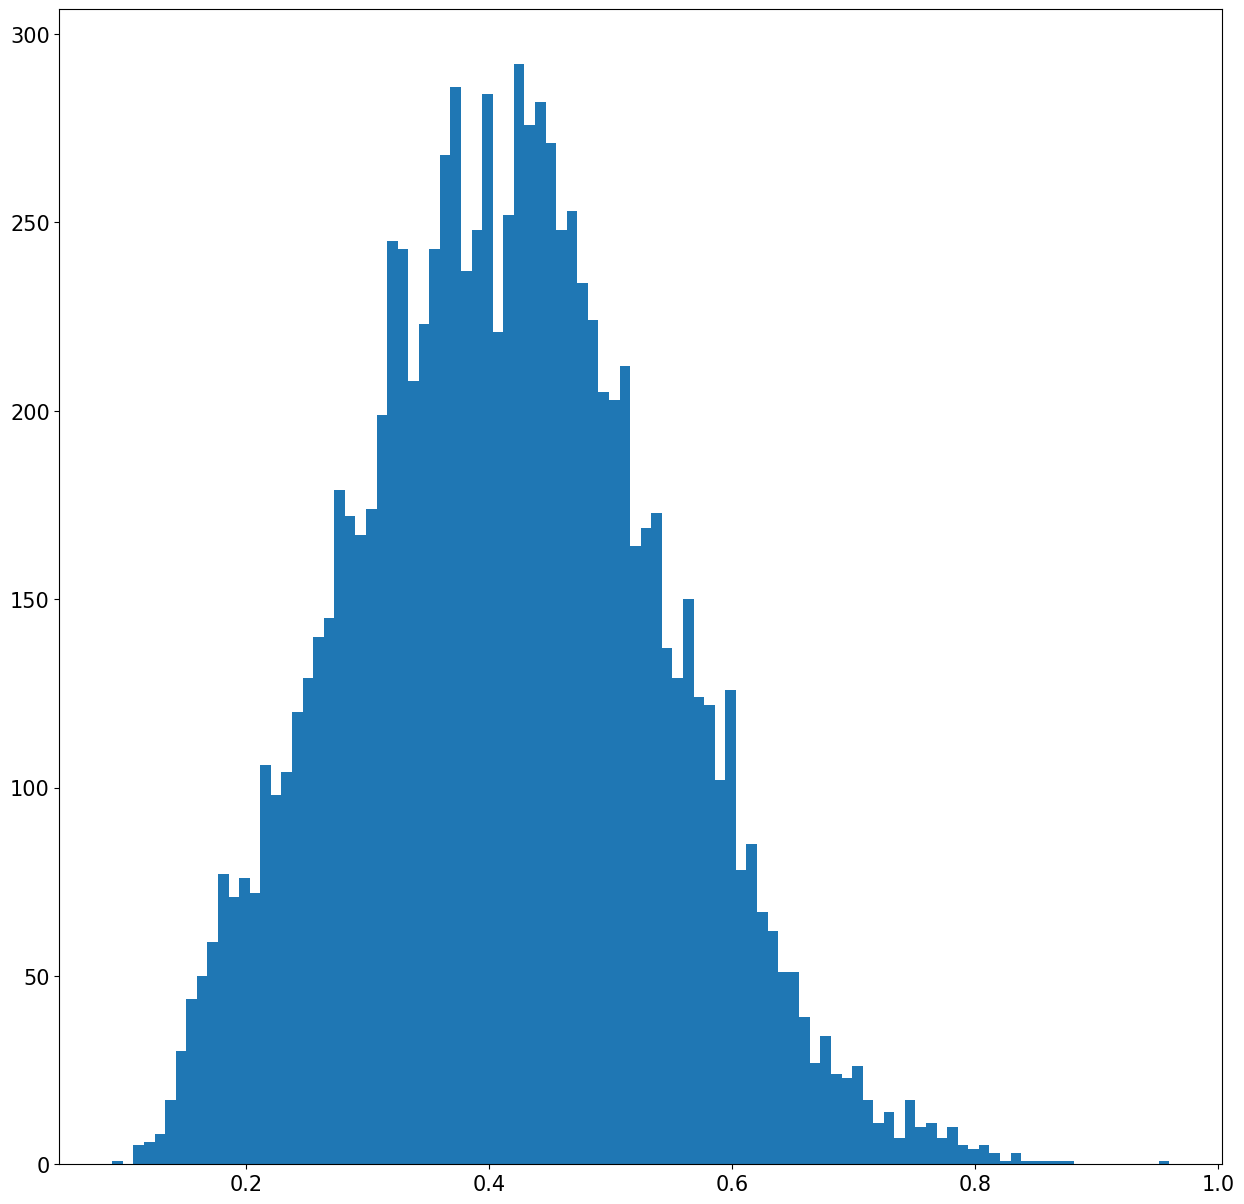

In [372]:
plt.hist(Truth[:,4].flatten().numpy(),bins=100)

# Making LSTM SDP Reconstruction


In [335]:

def Unnormalise_SDP(Truth,AuxData = None): 
    # Just for Truth Func below
    Gen_SDPTheta = torch.acos(Truth[:,0])*180/torch.pi
    Gen_SDPPhi   = torch.asin(Truth[:,1])*180/torch.pi if AuxData is None else torch.asin(Truth[:,1])*180/torch.pi+AuxData
    return torch.stack((Gen_SDPTheta,Gen_SDPPhi),dim=1)

def LSTM_SDP(Dataset, ProcessingDataset = None):
    '''
    Function to construct the SDP Dataset for the LSTM reconstruction
    '''
    PhiOffsets = {1:-75/180*torch.pi,2:-45/180*torch.pi,3:-15/180*torch.pi,4:15/180*torch.pi,5:45/180*torch.pi,6:75/180*torch.pi}
    IDsList = ()
    Main    = []
    Main_st = []
    Truth   = []
    Rec     = []
    AuxData = []
    Meta    = []

    for i, Event in enumerate(Dataset):

        ID = (Event.get_value('EventID_1/2').int()*100000 + Event.get_value('EventID_2/2').int()).item()
        IDsList += (ID,)

        Pix_Phi      = Event.get_pixel_values('Phi'            )
        Pix_Theta    = Event.get_pixel_values('Theta'          )
        Pix_ID       = Event.get_pixel_values('PixelID'        )
        Pix_TelID    = Event.get_pixel_values('TelID'          )
        Pix_PStart   = Event.get_pixel_values('PulseStart'     )
        Pix_PStop    = Event.get_pixel_values('PulseStop'      )
        Pix_TOffset  = Event.get_pixel_values('TimeOffset'     )        
        Pix_Status   = Event.get_pixel_values('Status'         )

        Pix_Traces   = Event.get_trace_values()

        Pix_Phi     = Pix_Phi[Pix_Status>2]
        Pix_Theta   = Pix_Theta[Pix_Status>2]
        Pix_ID      = Pix_ID[Pix_Status>2]
        Pix_TelID   = Pix_TelID[Pix_Status>2]
        Pix_PStart  = Pix_PStart[Pix_Status>2]
        Pix_PStop   = Pix_PStop[Pix_Status>2]
        Pix_TOffset = Pix_TOffset[Pix_Status>2]
        Pix_Status  = Pix_Status[Pix_Status>2]

        Pix_Pstart  = Pix_PStart.int()
        Pix_Pstop   = Pix_PStop.int()
        Pix_TOffset = Pix_TOffset.int()
        


        Comb_Trace_Start = (Pix_PStart+Pix_TOffset).min().item()
        Comb_Trace_Stop  = (Pix_PStop +Pix_TOffset).max().item()
        Comb_Trace_Start = int(Comb_Trace_Start)
        Comb_Trace_Stop  = int(Comb_Trace_Stop)
        
        CombTrace = torch.zeros(Comb_Trace_Stop-Comb_Trace_Start)
        CombTheta = torch.zeros(Comb_Trace_Stop-Comb_Trace_Start)
        CombPhi   = torch.zeros(Comb_Trace_Stop-Comb_Trace_Start)

        CombWeights = torch.zeros(Comb_Trace_Stop-Comb_Trace_Start)
        CombNpix    = torch.zeros(Comb_Trace_Stop-Comb_Trace_Start)

        for iPix in range(len(Pix_Phi)):
            This_Comb_PStart =      Pix_PStart[iPix]+Pix_TOffset[iPix]-Comb_Trace_Start
            This_Comb_PStop  = min([Pix_PStop [iPix]+Pix_TOffset[iPix]-Comb_Trace_Start,This_Comb_PStart+100])
            This_Comb_PStart = int(This_Comb_PStart.item())
            This_Comb_PStop  = int(This_Comb_PStop .item())
            This_PulseLenght = min([100,(Pix_Pstop[iPix]-Pix_Pstart[iPix]).item()])
            This_Trace = Pix_Traces[iPix,:This_PulseLenght]
            CombTrace  [This_Comb_PStart:This_Comb_PStop] += This_Trace
            CombTheta  [This_Comb_PStart:This_Comb_PStop] += Pix_Theta[iPix]#*torch.abs(This_Trace)
            CombPhi    [This_Comb_PStart:This_Comb_PStop] += Pix_Phi[iPix]  #*torch.abs(This_Trace)
            CombWeights[This_Comb_PStart:This_Comb_PStop] += 1#torch.abs(This_Trace)
            CombNpix   [This_Comb_PStart:This_Comb_PStop] += 1

        CombTheta = CombTheta/CombWeights
        CombPhi   = CombPhi  /CombWeights

        # Normalize
        NoSigMask = (CombTrace==0)|(CombWeights==0)      # care - it is possible to have zero total signal
        CombTrace = torch.log10(torch.clip((CombTrace+1),min=1))
        CombTheta = 90-CombTheta
        CentralCombPhi = CombPhi[~NoSigMask].mean()
        CombPhi   = CombPhi - CentralCombPhi

        # CombTheta = torch.cos(CombTheta*torch.pi/180)
        # CombPhi   = torch.sin(CombPhi  *torch.pi/180)

        CombTheta[NoSigMask] = -1              
        CombPhi  [NoSigMask] = -1
        
        This_Main = torch.zeros(1000,3)
        This_Main[:CombTrace.shape[0],0] = CombTrace[-1000:] # In case the trace is longer than 1000
        This_Main[:CombTheta.shape[0],1] = CombTheta[-1000:]
        This_Main[:CombPhi  .shape[0],2] = CombPhi  [-1000:]

        # The end of Main is now zeros, need to move these zeros to the front
        This_Main = torch.roll(This_Main,shifts=1000-CombTrace.shape[0],dims=0)

        # Get Truth and Rec
        Gen_SDPTheta = Event.get_value('Gen_SDPTheta')
        Gen_SDPPhi   = Event.get_value('Gen_SDPPhi'  )
        Rec_SDPTheta = Event.get_value('Rec_SDPTheta')
        Rec_SDPPhi   = Event.get_value('Rec_SDPPhi'  )
        # Normalise Phi to be around the central pixel
        # print(Gen_SDPPhi,CentralCombPhi)
        Gen_SDPPhi = Gen_SDPPhi #- CentralCombPhi/180*torch.pi
        Rec_SDPPhi = Rec_SDPPhi #- CentralCombPhi/180*torch.pi
        

        # This_Truth = torch.tensor([torch.cos(Gen_SDPTheta),torch.sin(Gen_SDPPhi)])
        # This_Rec   = torch.tensor([torch.cos(Rec_SDPTheta),torch.sin(Rec_SDPPhi)])
        
        This_Truth = torch.tensor([torch.cos(Gen_SDPTheta),Gen_SDPPhi])
        This_Rec   = torch.tensor([torch.cos(Rec_SDPTheta),Rec_SDPPhi])

        # Get MetaData
        Primary = Event.get_value('Primary'    )
        LogE    = Event.get_value('Gen_LogE'   )
        Xmax    = Event.get_value('Gen_Xmax'   )
        This_Meta = torch.tensor([Primary,LogE,Xmax])
        
        # Get AuxData
        Station_Distance = Event.get_value('Station_Distance')/30000
        # Station_Theta    = Event.get_value('Station_Theta'   )
        # Station_Phi      = Event.get_value('Station_Phi'     )
        Station_Time     = Event.get_value('Station_Time'    )/1000

        # This_AuxData = torch.tensor([Station_Distance,Station_Theta,Station_Phi,Station_Time])
        This_MainSt = torch.tensor([Station_Distance,Station_Time])
        
        Main   .append(This_Main)
        Main_st.append(This_MainSt)
        Truth  .append(This_Truth)
        Rec    .append(This_Rec)
        Meta   .append(This_Meta)
        AuxData.append(torch.tensor([CentralCombPhi]))

    
        if (ProcessingDataset is None) and  (len(Truth)>10000) : break

    Main    = torch.stack(Main   ,dim=0)
    Main_st = torch.stack(Main_st,dim=0)
    Truth   = torch.stack(Truth  ,dim=0)
    Rec     = torch.stack(Rec    ,dim=0)
    Meta    = torch.stack(Meta   ,dim=0)
    AuxData = torch.stack(AuxData,dim=0)

    
    # Renormalise phi
    Truth[:,1][Truth[:,1]<0] += 2*torch.pi 
    Truth[:,1] -= torch.pi/2
    Truth[:,1] -= AuxData.squeeze()/180*torch.pi
    Truth[:,1] = torch.sin(Truth[:,1])

    Rec[:,1][Rec[:,1]<0] += 2*torch.pi
    Rec[:,1] -= torch.pi/2
    Rec[:,1] -= AuxData.squeeze()/180*torch.pi
    Rec[:,1] = torch.sin(Rec[:,1])

    # Slap into Dataset
    if ProcessingDataset is None:
        return (Main,Main_st), AuxData, Truth, Rec, Meta, IDsList
    
    else:
        ProcessingDataset._Main.append(Main) # Must append only main for multiple Mains possibility
        ProcessingDataset._Main.append(Main_st)
        ProcessingDataset._Aux   = AuxData
        ProcessingDataset._Truth = Truth
        ProcessingDataset._Rec   = Rec
        ProcessingDataset._Meta  = Meta

        ProcessingDataset.Unnormalise_Truth = Unnormalise_SDP
        ProcessingDataset.Truth_Keys        = ['SDPTheta','SDPPhi']
        ProcessingDataset.Truth_Units       = ['deg','deg']

        if ProcessingDataset._EventIds is None:
            ProcessingDataset._EventIds = IDsList
        else:
            assert ProcessingDataset._EventIds == IDsList, 'Event IDs do not match'
Main, AuxData, Truth, Rec, Meta, IDsList = LSTM_SDP(Run010)

torch.Size([10001]) torch.Size([10001, 1])


# Making GatConv Axis Reconstruction, Use Traces?

In [111]:
# For Testing Functions
import Axis_Graph_DataGen
importlib.reload(Axis_Graph_DataGen)
from Axis_Graph_DataGen import Graph_Edges_wStation_wAngVelAsNodeAndEdge_Axis

In [112]:
Graph,AuxData,Truth,Rec,Meta,IDsList = Graph_Edges_wStation_wAngVelAsNodeAndEdge_Axis(Dataset)

In [113]:
NodeValues  = [G[0] for G in Graph]
EdgeIndex   = [G[1] for G in Graph]
EdgeValues  = [G[2] for G in Graph]



In [114]:
print(NodeValues[0].shape)
print(EdgeIndex[0].shape)
print(EdgeValues[0].shape)

torch.Size([14, 7])
torch.Size([53, 2])
torch.Size([53, 3])


In [115]:
print(NodeValues[0][:,6])

tensor([0.1212, 0.1212, 0.1443, 0.1443, 0.1369, 0.1409, 0.1351, 0.1393, 0.1336,
        0.1374, 0.1307, 0.1314, 0.1314, 0.0020])


0 0.12116921693086624
[tensor(0.1212)]
1 0.12116921693086624
[tensor(0.1212), tensor(0.1476)]
2 0.14430919289588928
[tensor(0.1476), tensor(0.1443)]
3 0.14430919289588928
[tensor(0.1443), tensor(0.1448), tensor(0.1411)]
4 0.13691122829914093
[tensor(0.1448), tensor(0.1369)]
5 0.14087842404842377
[tensor(0.1411), tensor(0.1369), tensor(0.1425), tensor(0.1409)]
6 0.13514569401741028
[tensor(0.1425), tensor(0.1444), tensor(0.0911), tensor(0.1351)]
7 0.1392928510904312
[tensor(0.1409), tensor(0.1444), tensor(0.1336), tensor(0.1393)]
8 0.13359898328781128
[tensor(0.0911), tensor(0.1336), tensor(0.1465)]
9 0.13735254108905792
[tensor(0.1351), tensor(0.1393), tensor(0.1465), tensor(0.1393), tensor(0.1374), tensor(0.1345)]
10 0.1306893676519394
[tensor(0.1393), tensor(0.1260), tensor(0.1307)]
11 0.13143421709537506
[tensor(0.1374), tensor(0.1260), tensor(0.1314)]
12 0.13143421709537506
[tensor(0.1345), tensor(0.1307), tensor(0.1314)]


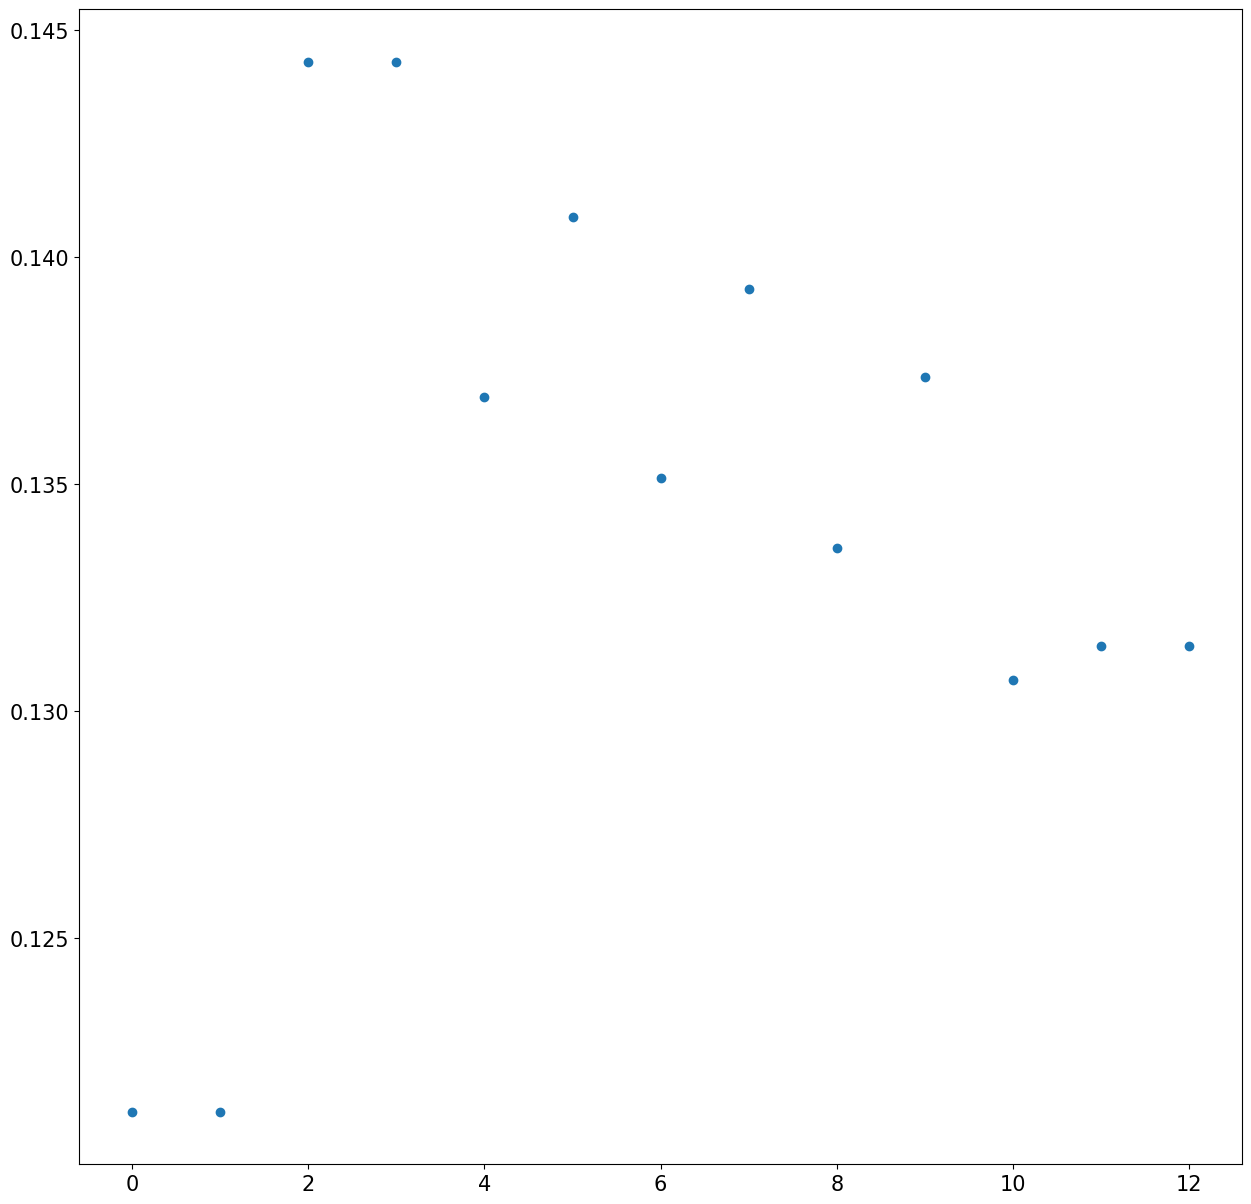

In [116]:
N = 0
plot_NodeI  = []
plot_AngVal = []
stationNode = len(NodeValues[N])-1
for NodeI in range(len(NodeValues[N])-1):
    # Find all edges connected to NodeI
    Edges  = []
    EdgesV = []
    for loop_Edge,loop_EdgeV in zip(EdgeIndex[N],EdgeValues[N]):
        if loop_Edge[0] == NodeI and stationNode not in loop_Edge:
            Edges.append(loop_Edge)
            EdgesV.append(loop_EdgeV[2])
        
    if len(EdgesV)!=0 :
        print(NodeI,torch.stack(EdgesV).median().item())
    else:
        print(NodeI,0)
    # print(Edges)
    print(EdgesV)
    plot_NodeI.append(NodeI)
    plot_AngVal.append(torch.stack(EdgesV).median().item())

plt.figure()
plt.scatter(plot_NodeI,plot_AngVal)

In [45]:
EdgeValues = torch.cat(EdgeValues,dim=0)
print(EdgeValues.shape)

# Check if there are any nan values
print(torch.isnan(EdgeValues).any())
# check if there are any inf values
print(torch.isinf(EdgeValues).any())


torch.Size([16367624, 3])
tensor(False)
tensor(True)


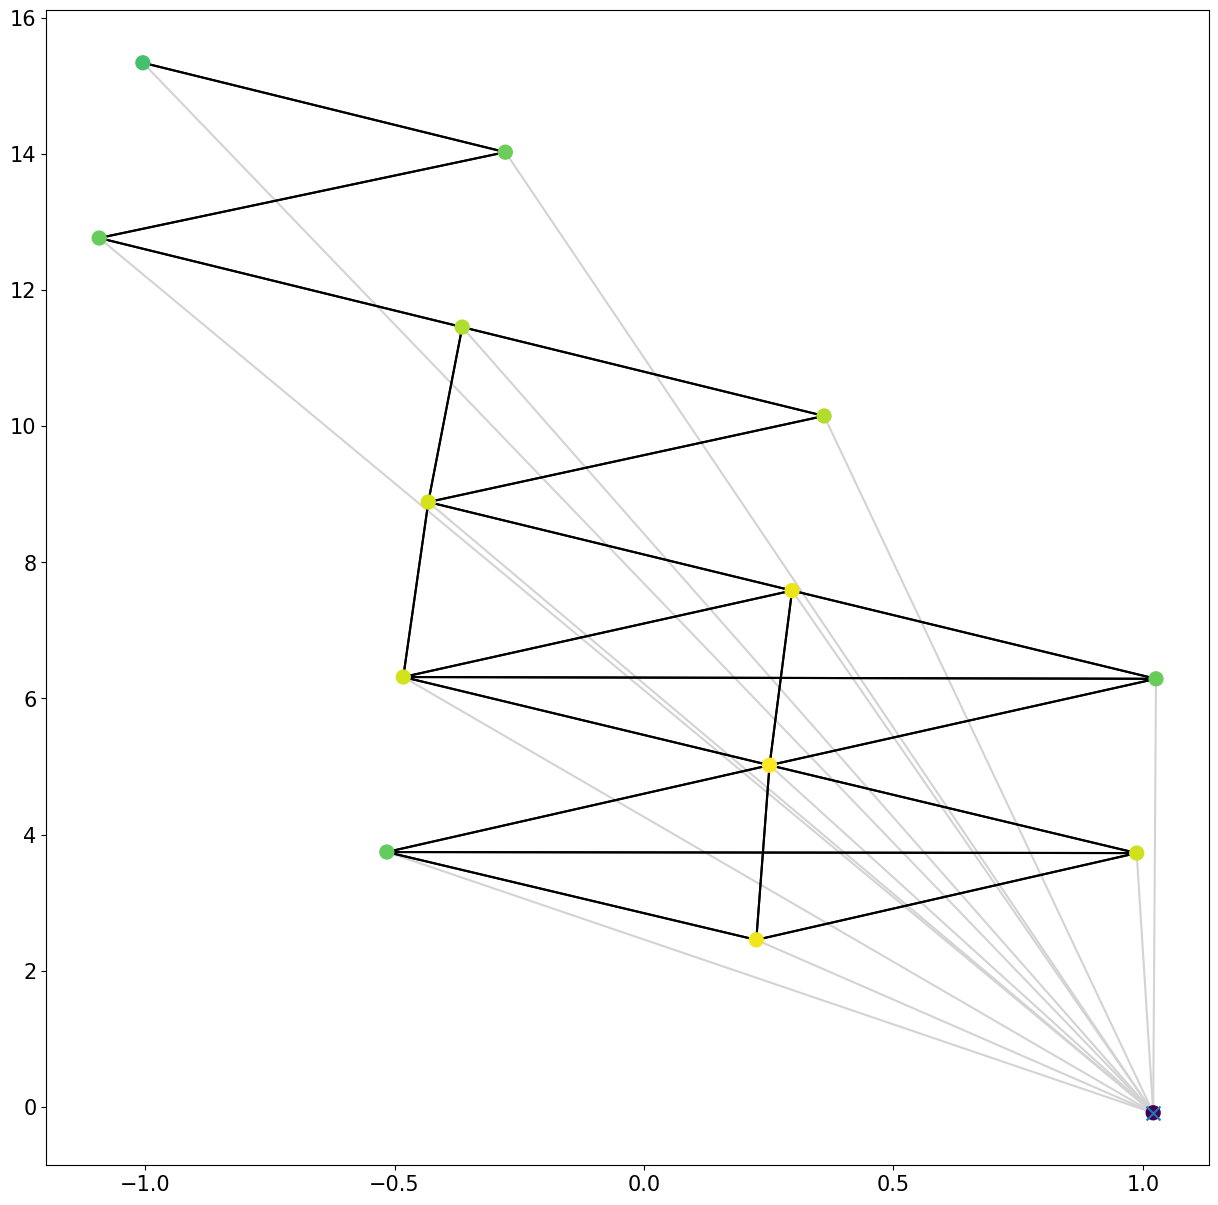

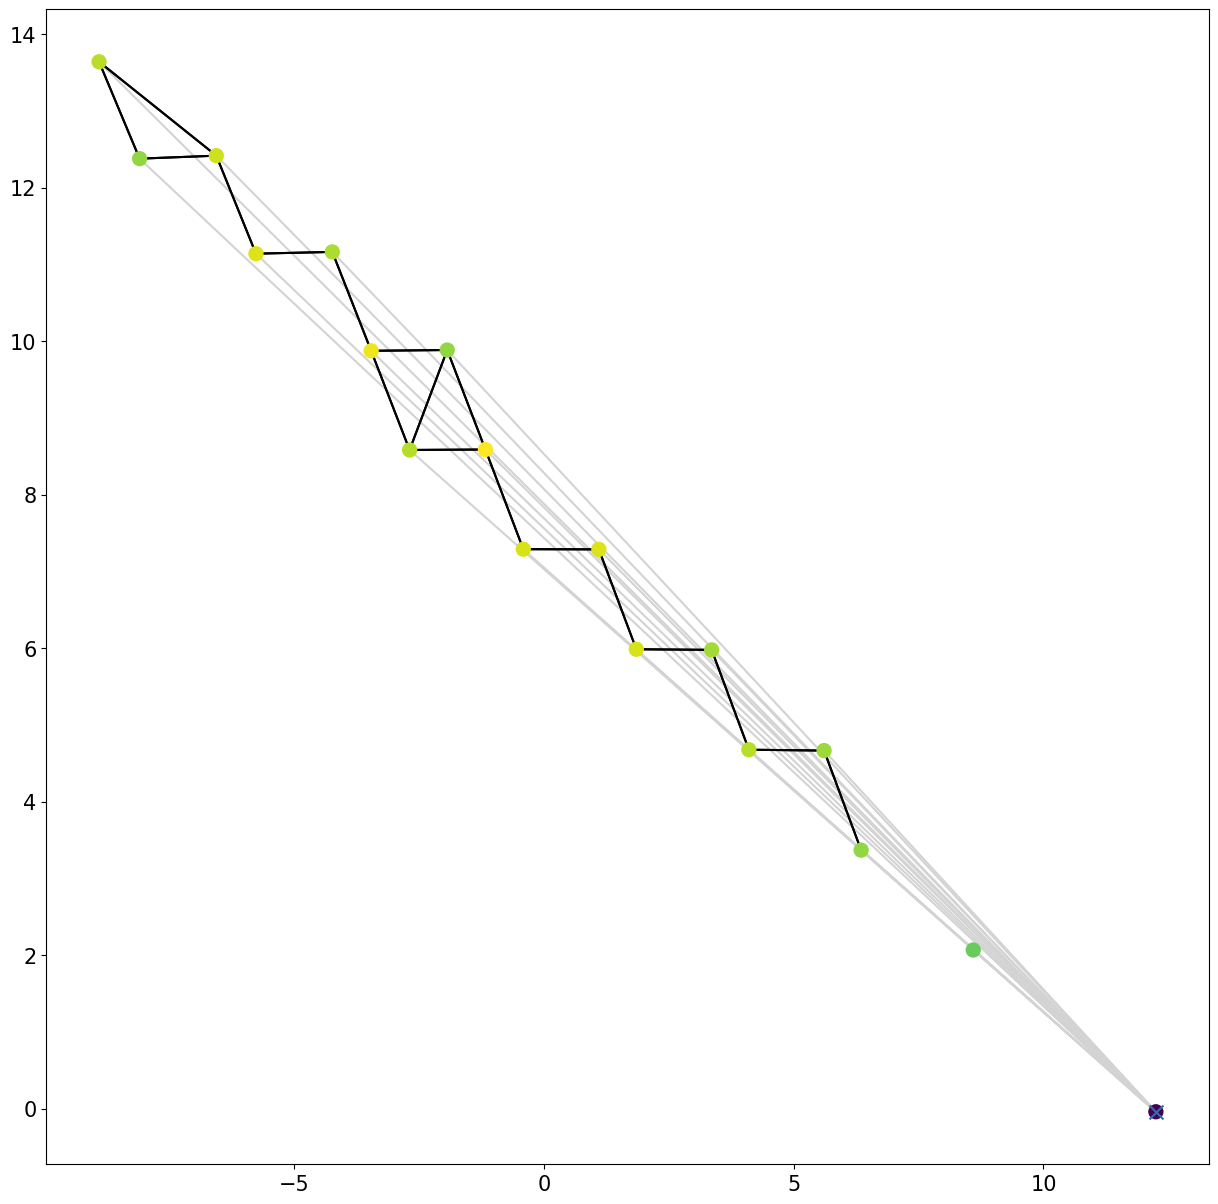

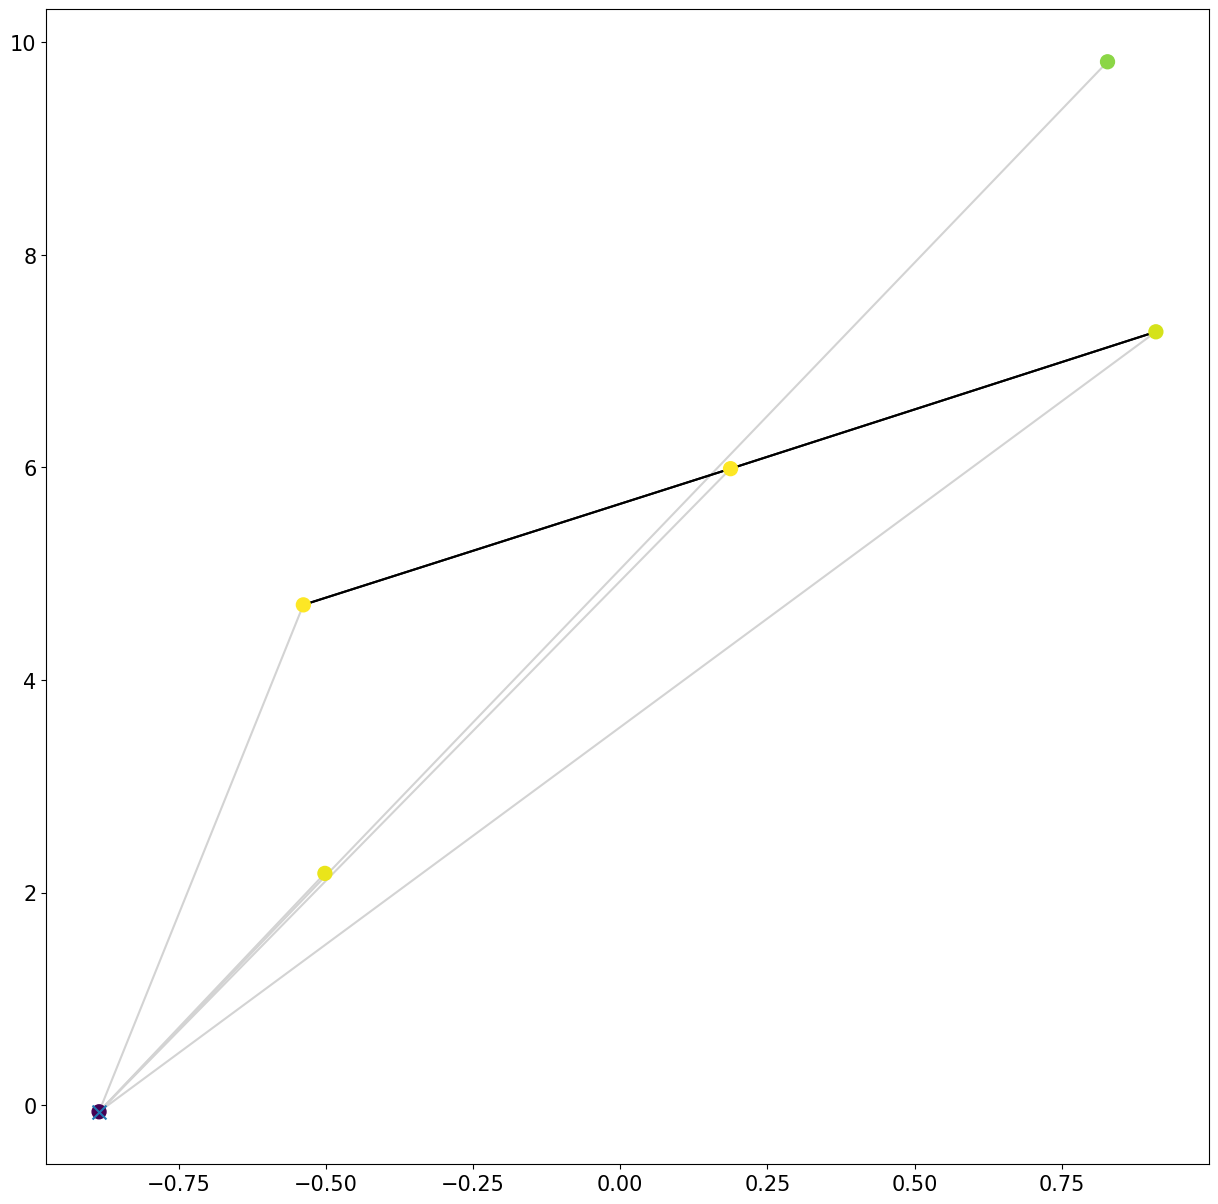

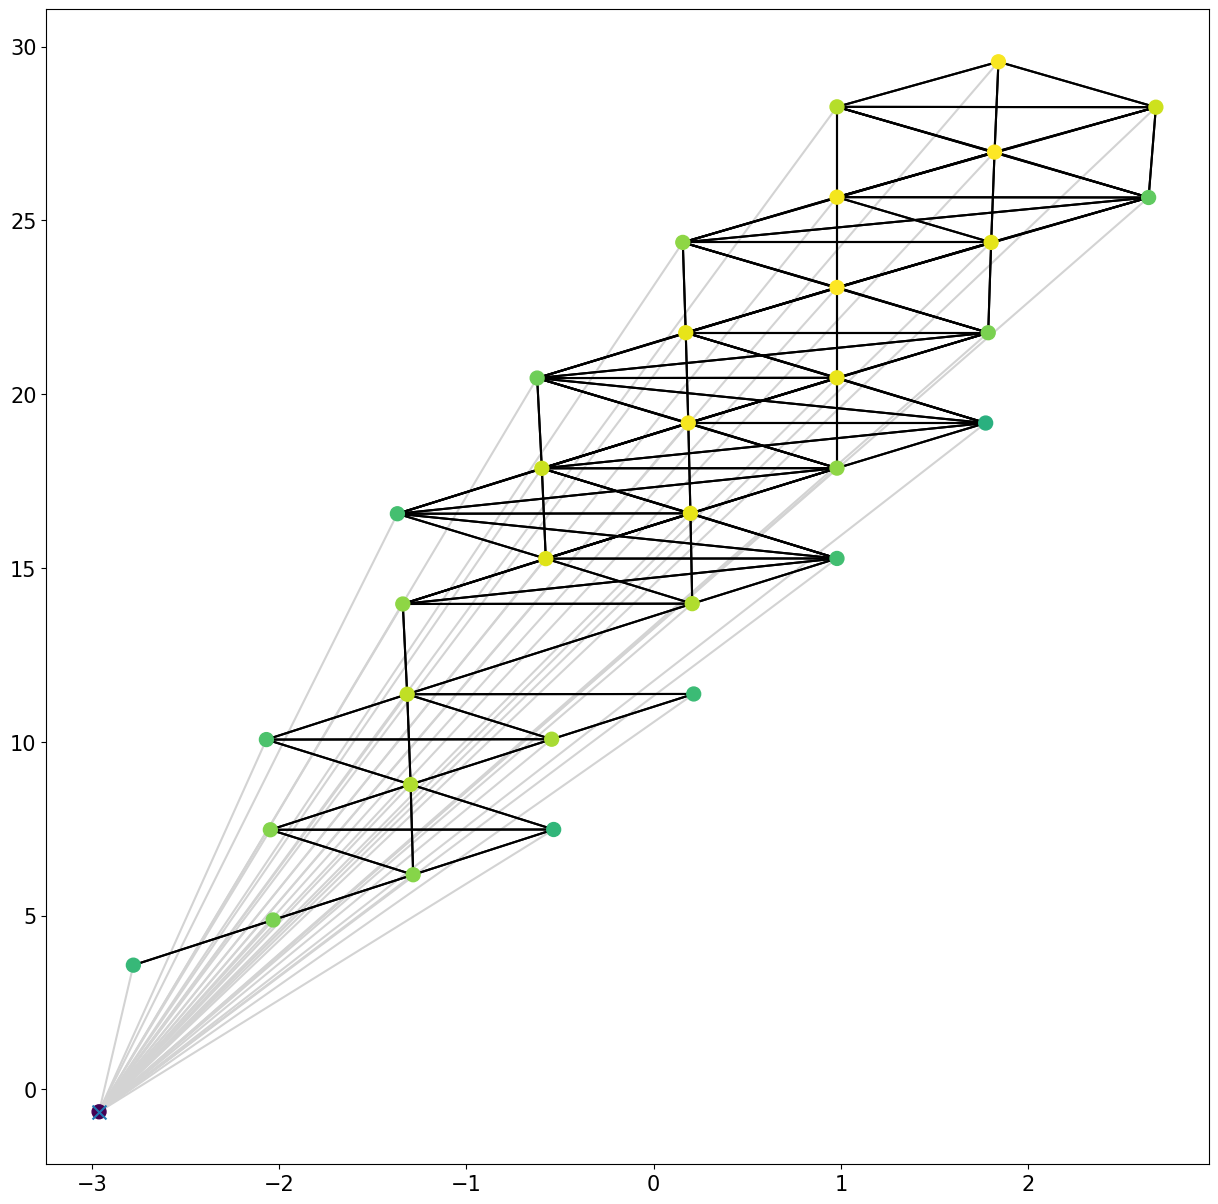

In [39]:
N = 0
for G in Graph:
    Nodes      = G[0]
    Edges      = G[1].numpy()
    EdgeValues = G[2]
    # if len(Nodes) < 35: continue
    Thetas      = Nodes[:,0].numpy()*30
    Phis        = Nodes[:,1].numpy()*40
    Chi_i       = Nodes[:,2].numpy()
    Centroids   = Nodes[:,3].numpy()
    Charges     = Nodes[:,4].numpy()
    PulseWidths = Nodes[:,5].numpy()
    

    StationTheta      = Thetas[-1]
    StationPhi        = Phis[-1]
    StationChi_i      = Chi_i[-1]
    StationCentroid   = Centroids[-1]
    StationCharge     = Charges[-1]
    StationPulseWidth = PulseWidths[-1]
    
    N+=1
    plt.figure()
    plt.scatter(Phis,Thetas,c = Charges, cmap = 'viridis',s=100)
    plt.scatter(StationPhi,StationTheta,marker='x',s=100)

    for edge in Edges:
        # if edge[0] == len(Nodes)-1 or edge[1] == len(Nodes)-1: continue
        first  = int(edge[0])
        second = int(edge[1])
        stationNode = len(Nodes)-1
        if first == stationNode or second == stationNode:
            plt.plot([Phis[first],StationPhi],[Thetas[first],StationTheta],color = 'lightgrey',zorder = -10)
        else:
            plt.plot([Phis[first],Phis[second]],[Thetas[first],Thetas[second]],'k-',zorder = -9)
    if N>3: break

In [25]:
Pix_Theta      = NodeValues[:,0].numpy()
Pix_Phi        = NodeValues[:,1].numpy()
Pix_Chi_i      = NodeValues[:,2].numpy()
Pix_Centroid   = NodeValues[:,3].numpy()
Pix_Charge     = NodeValues[:,4].numpy()
Pix_PulseWidth = NodeValues[:,5].numpy()

(array([1.100e+01, 9.000e+00, 1.700e+01, 1.400e+01, 2.400e+01, 1.900e+01,
        2.100e+01, 3.300e+01, 2.700e+01, 4.800e+01, 5.600e+01, 5.500e+01,
        6.100e+01, 6.600e+01, 7.600e+01, 8.200e+01, 1.210e+02, 1.230e+02,
        1.410e+02, 1.590e+02, 1.930e+02, 2.250e+02, 2.080e+02, 2.470e+02,
        3.300e+02, 3.720e+02, 4.370e+02, 4.810e+02, 5.310e+02, 6.370e+02,
        7.160e+02, 7.750e+02, 9.500e+02, 1.057e+03, 1.317e+03, 1.459e+03,
        1.684e+03, 2.024e+03, 2.337e+03, 2.676e+03, 3.019e+03, 3.701e+03,
        4.239e+03, 5.084e+03, 6.030e+03, 6.812e+03, 7.380e+03, 8.066e+03,
        8.465e+03, 8.566e+03, 8.524e+03, 8.258e+03, 7.396e+03, 6.636e+03,
        5.854e+03, 5.121e+03, 4.278e+03, 3.739e+03, 3.188e+03, 2.775e+03,
        2.321e+03, 1.950e+03, 1.747e+03, 1.521e+03, 1.290e+03, 1.073e+03,
        8.700e+02, 8.220e+02, 7.480e+02, 6.190e+02, 5.470e+02, 4.620e+02,
        4.410e+02, 3.890e+02, 3.330e+02, 2.620e+02, 2.630e+02, 2.060e+02,
        1.580e+02, 1.470e+02, 1.440e+0

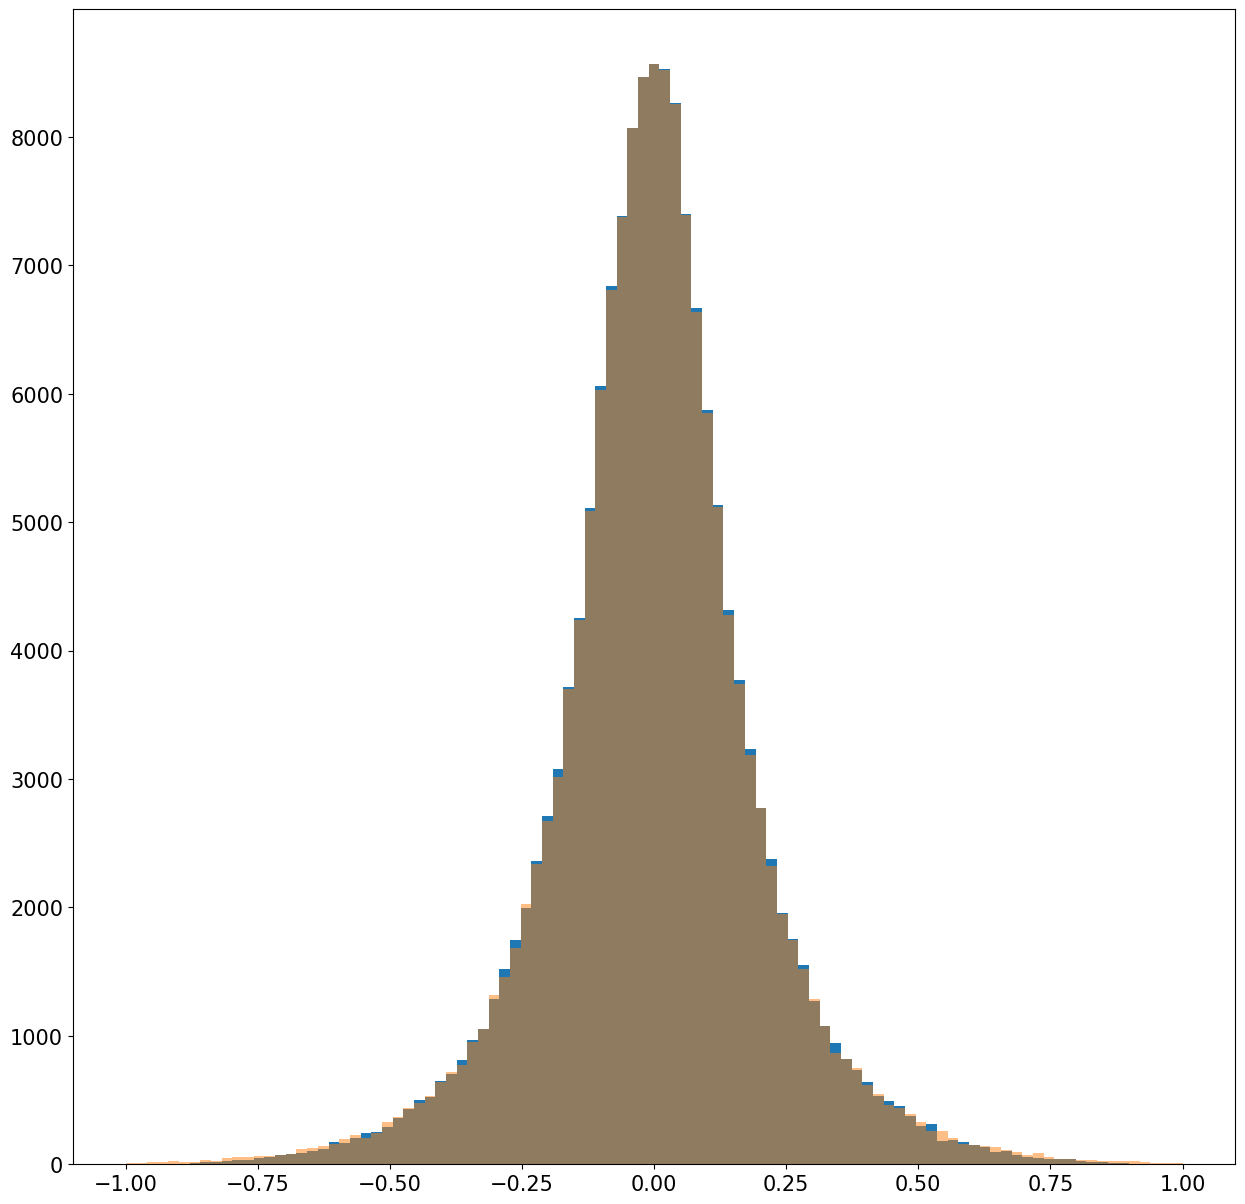

In [41]:
Truth_Phi  = (Truth[:,3]).numpy()
plt.figure()
bins = np.linspace(-1,1,100)
plt.hist(Truth_Phi,bins=bins)
plt.hist(np.arcsin(Truth_Phi),bins=bins,alpha=0.5)

/tmp/ipykernel_32662/2185158339.py:9: RuntimeWarning: invalid value encountered in divide
  NormTraces = Traces/Charges[:,None]


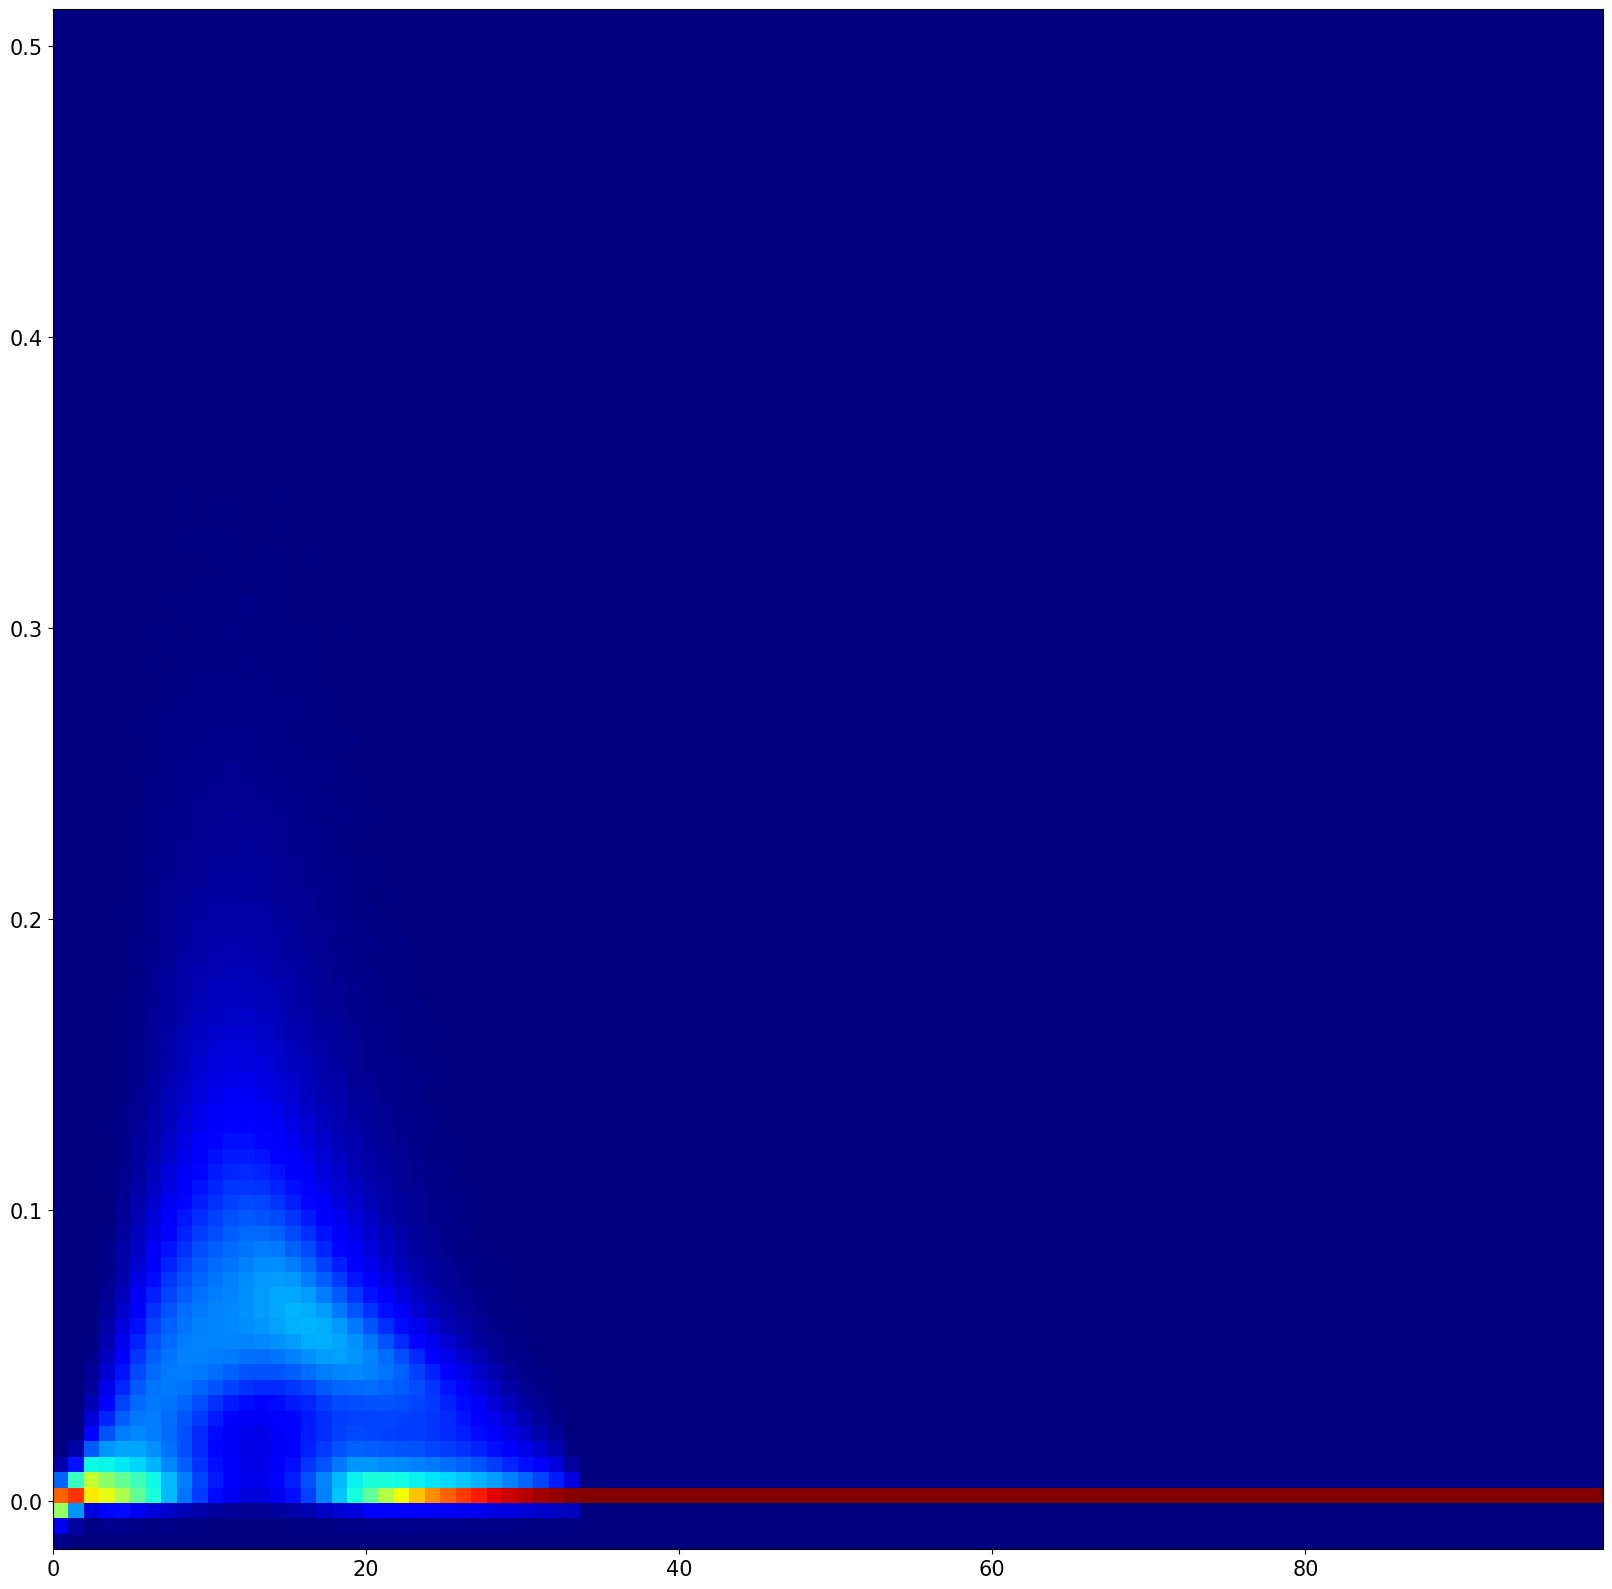

In [62]:
# 2d Histogram of trace shape
plt.figure(figsize = [20,20])
Traces     = Run010.get_trace_values().numpy()
Charges    = Run010.get_pixel_values('Charge').numpy()
PulseStart = Run010.get_pixel_values('PulseStart').numpy()
PulseStop  = Run010.get_pixel_values('PulseStop').numpy()
PulseWidth = PulseStop - PulseStart
TraceMax   = Traces.max(axis=1)
Cut = (Charges> 5000) & (PulseWidth>20) & (PulseWidth<35)
NormTraces = Traces/Charges[:,None]
NormTraces = NormTraces[Cut]

X = np.tile(np.arange(0,100),len(NormTraces))
Y = NormTraces.flatten()

plt.hist2d(X,Y,bins=[100,100],cmap='jet',norm=mcolors.PowerNorm(0.5))
plt.show()
# plt.figure(figsize=[20,20])
# for i in range(len(NormTraces)):
#     plt.plot(NormTraces[i])

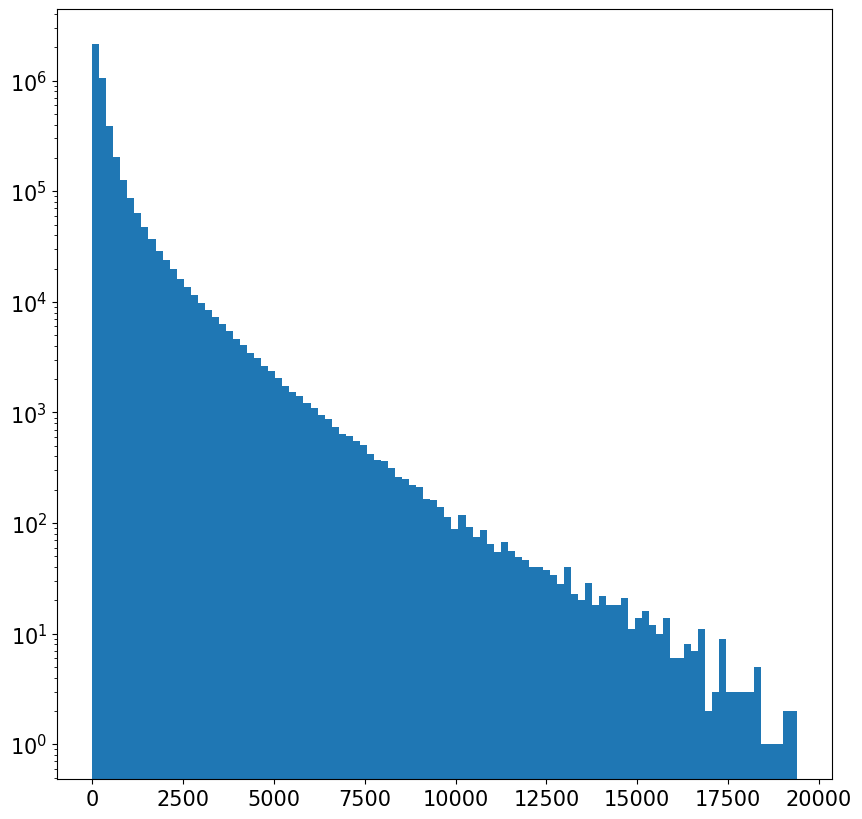

In [35]:
# Histogram of Max Trace Values
Traces = Run010.get_trace_values().numpy()
plt.figure(figsize=[10,10])
TraceMaxes = np.max(Traces,axis=1)
plt.hist(TraceMaxes,bins=100)
plt.yscale('log')
plt.show()

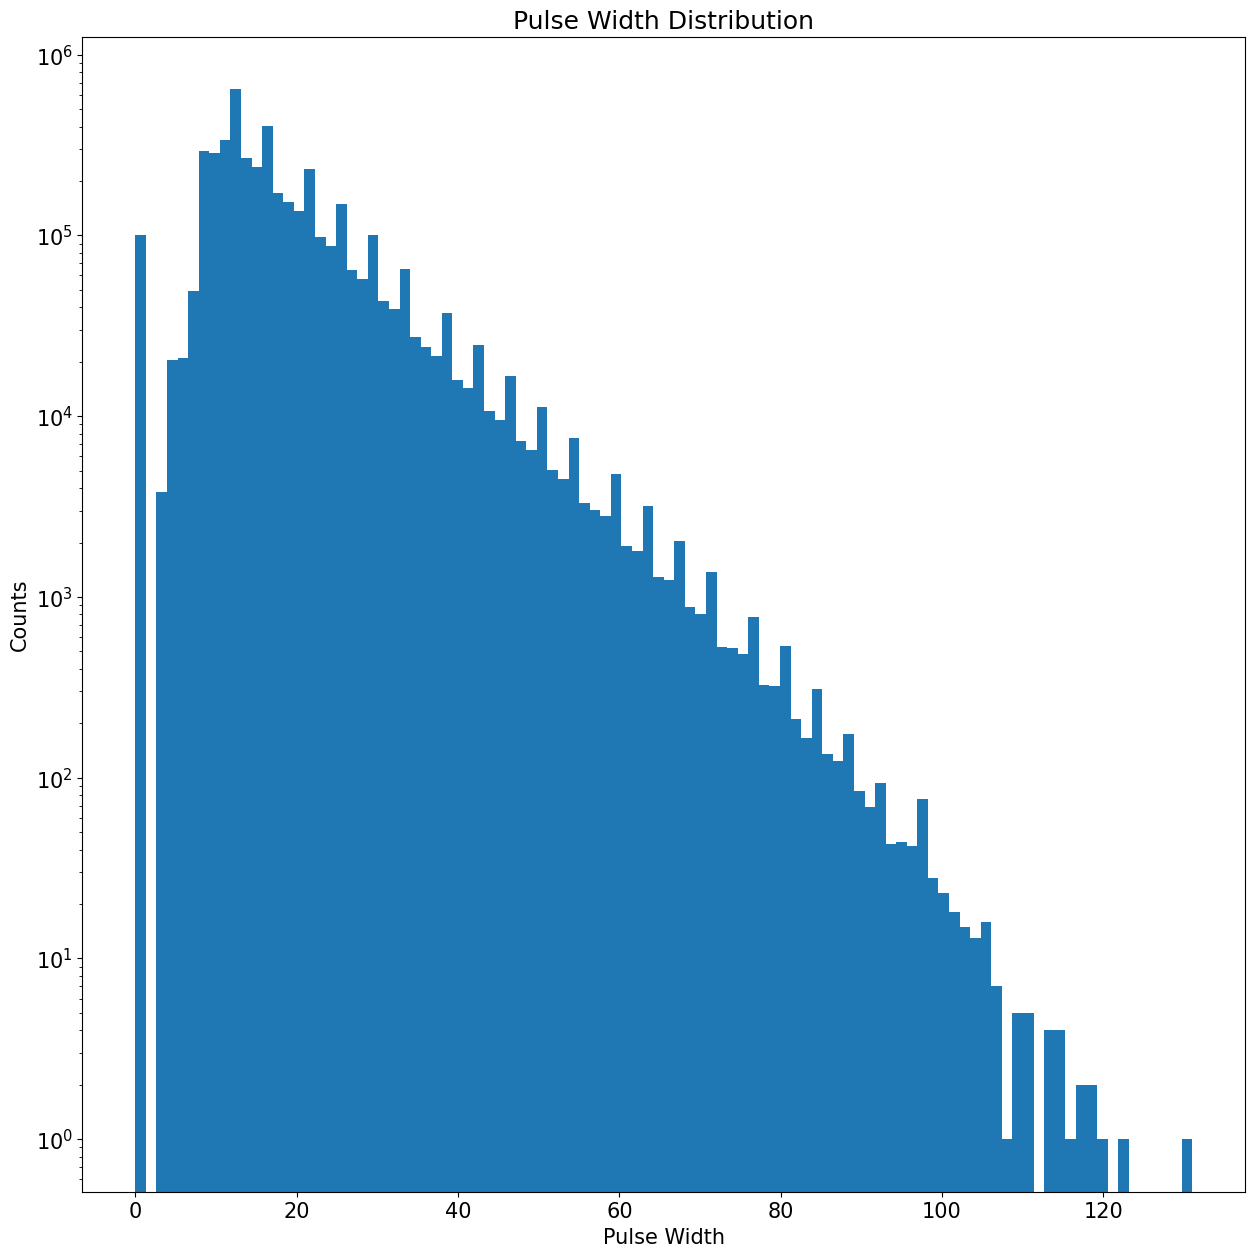

In [42]:
# Histogram of Pulse Widths
PulseStart = Run010.get_pixel_values('PulseStart').numpy()
PulseStop  = Run010.get_pixel_values('PulseStop').numpy()
PulseWidth = PulseStop-PulseStart

plt.figure()
plt.hist(PulseWidth,bins=100)
plt.xlabel('Pulse Width')
plt.ylabel('Counts')
plt.title('Pulse Width Distribution')
plt.yscale('log')


# Making 3 Tel wide Conv Grids

tensor([ 0,  0, 18, 19], dtype=torch.int32) tensor([ 0, 21, 20, 21], dtype=torch.int32)


/remote/tychodata/ftairli/.local/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


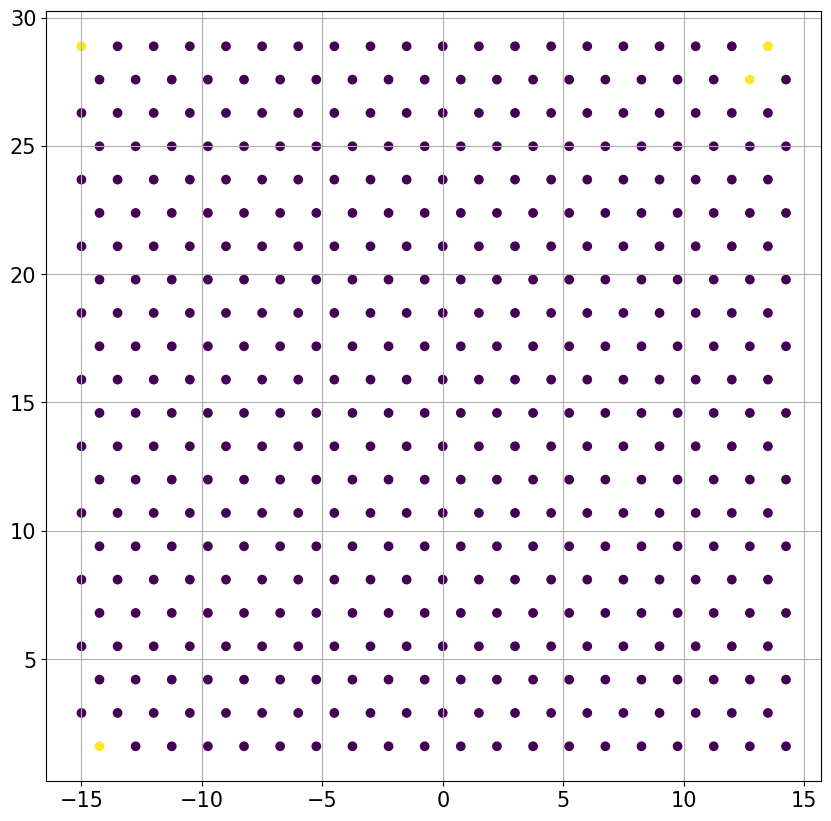

In [19]:
# Make Standard Grid
width = 20
height = 22
Pix_gap = 1.5
# Create 2D array of pixels
pix_X = torch.arange(0,width*Pix_gap,Pix_gap)-width*Pix_gap/2
pix_Y = torch.arange(0,height*Pix_gap,Pix_gap)
pix_Y *= torch.sqrt(torch.tensor([3])).item()/2
pix_Y += 1.6

X,Y = torch.meshgrid(pix_X,pix_Y)
# Shift odd rows by half a pixel
X = X.clone()
X[:, ::2] = X[:, ::2] + Pix_gap/2

Z = torch.zeros_like(X)
# light up pixels 1, 22 440 in th increasing order
indices = torch.tensor([1,22,417,440])
Xs,Ys = IndexToXY(indices,return_tensor=True)
print(Xs,Ys)
Z[Xs,Ys] = 1

X = X.flatten().numpy()
Y = Y.flatten().numpy()
StandardGrid = (X,Y)


plt.figure(figsize = [10,10])
plt.scatter(*StandardGrid,c=Z.flatten(),cmap='viridis')
plt.grid()

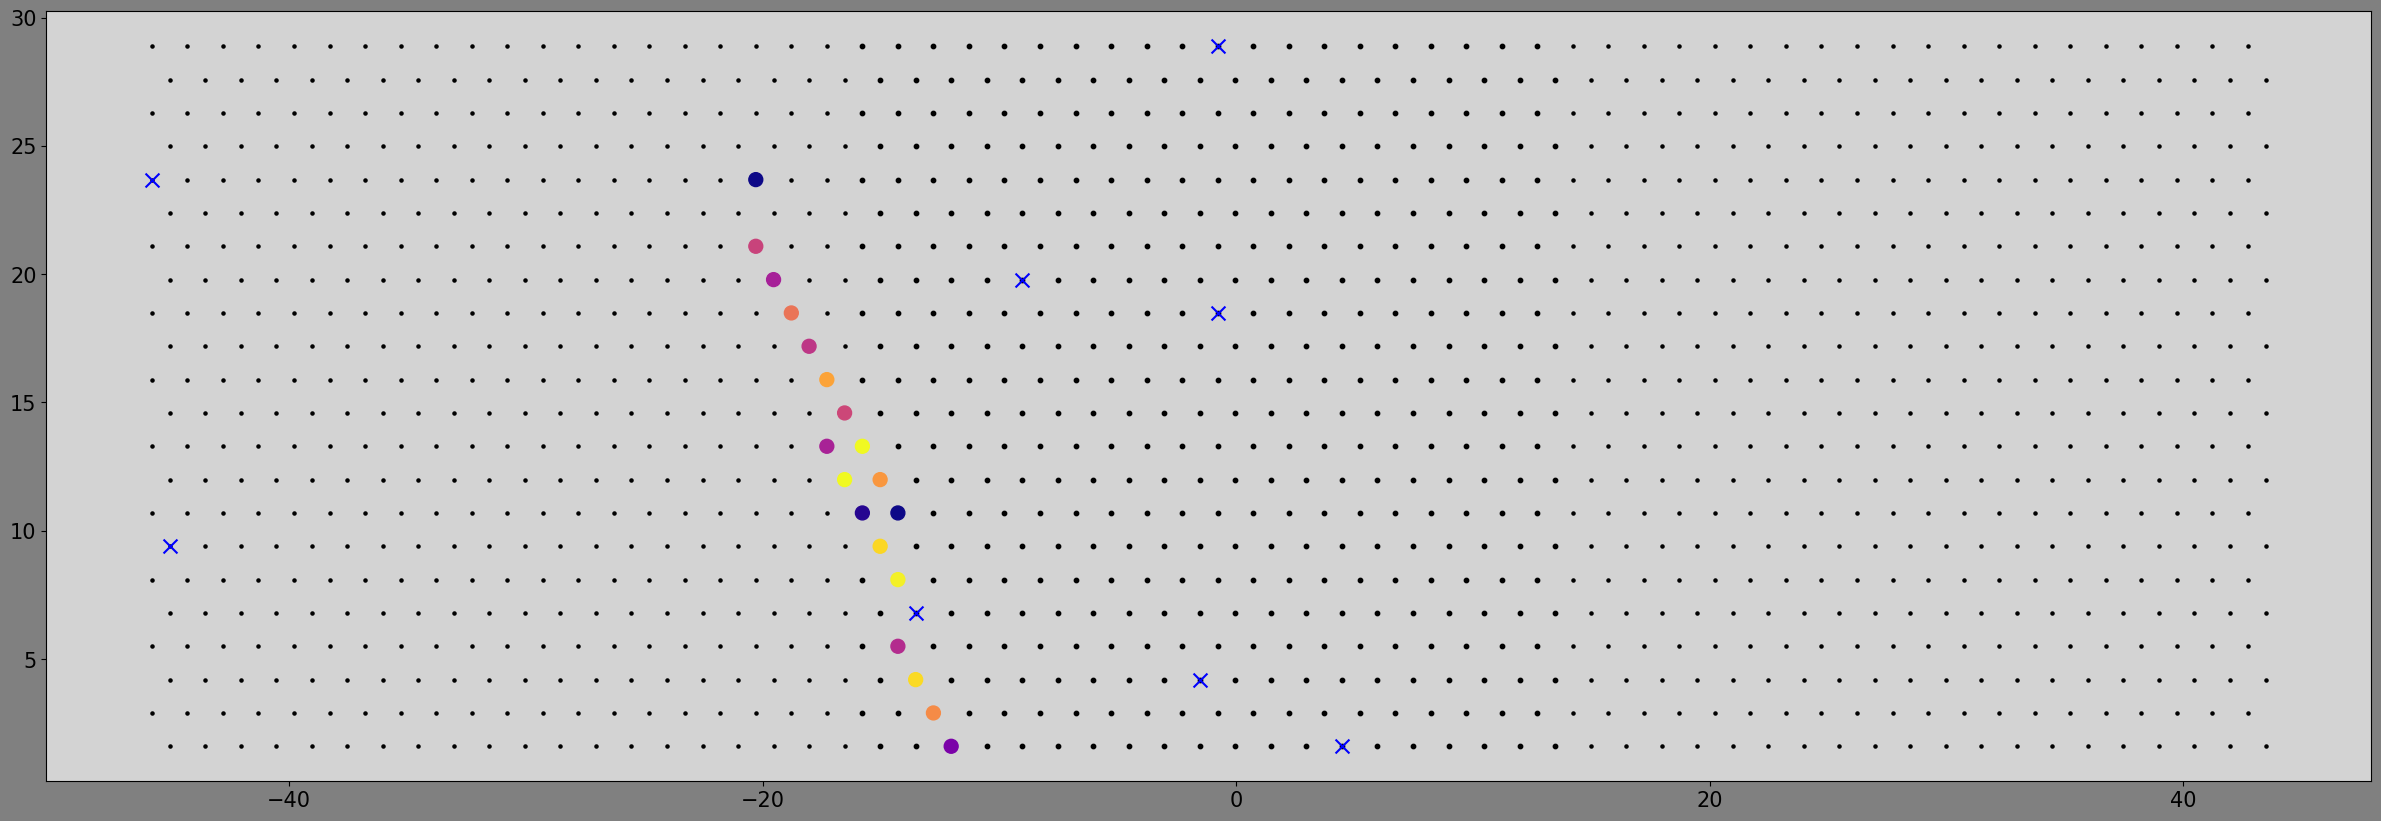

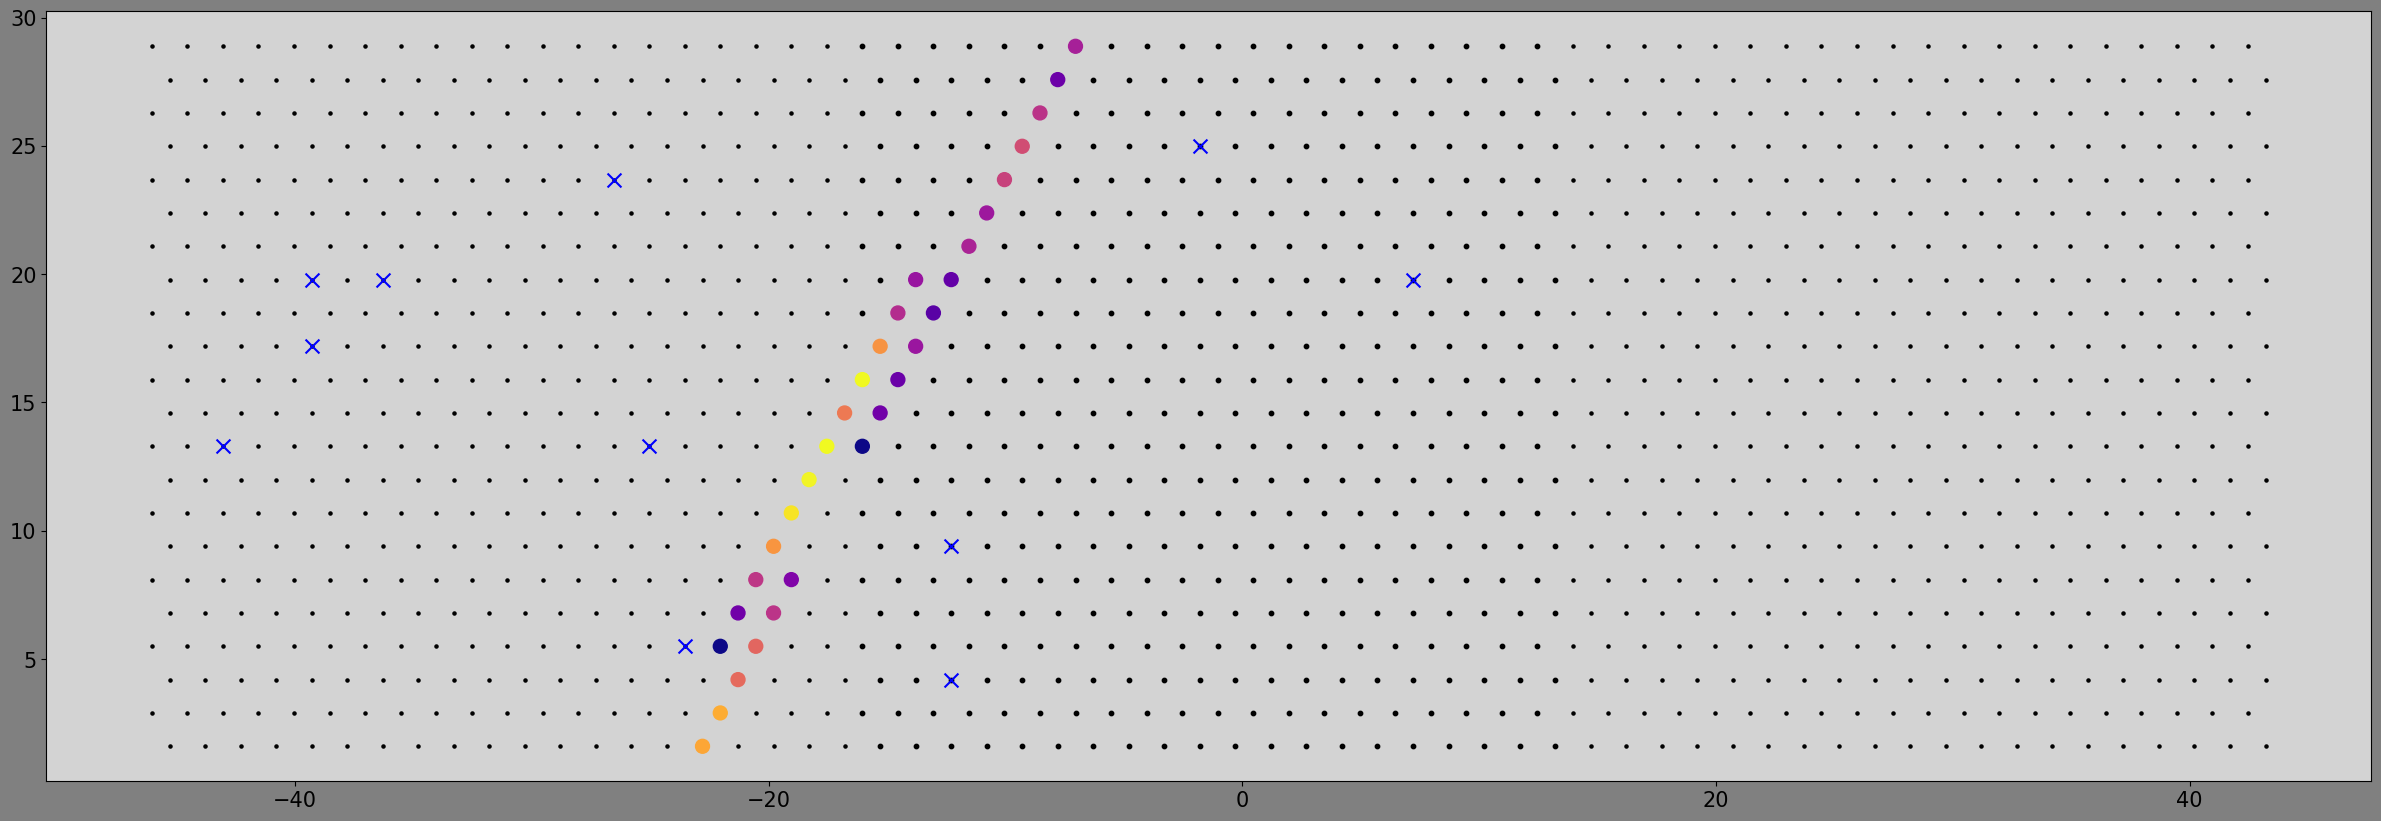

In [20]:
Nplots = 0
Offsets = {1:-75/180*torch.pi,2:-45/180*torch.pi,3:-15/180*torch.pi,4:15/180*torch.pi,5:45/180*torch.pi,6:75/180*torch.pi}
for event in Run010:

    Pix_Phi    = event.get_pixel_values('Phi')
    Pix_Theta  = event.get_pixel_values('Theta')
    Pix_Charge = event.get_pixel_values('Charge')
    Pix_Status = event.get_pixel_values('Status')
    Pix_TelID  = event.get_pixel_values('TelID')
    Pix_ID     = event.get_pixel_values('PixelID')
    
    # if the number of unique telescopes is less than 2, skip
    if len(torch.unique(Pix_TelID))<2: continue
    Nplots += 1

    Unique_Telescopes, counts = torch.unique(Pix_TelID,return_counts=True)
    Unique_Telescopes = Unique_Telescopes[torch.argsort(counts,descending=True)]


    # Plot Central Telescope
    Central_Tel = Unique_Telescopes[0]
    plt.figure(figsize= [30,10],facecolor='grey')
    plt.gca().set_facecolor('lightgrey')
    X,Y = StandardGrid
    X += Offsets[Central_Tel.item()]
    plt.scatter(X,Y,c ='black',s = 10)

    C = torch.zeros(20,22)
    Tel_Pix_Charge = Pix_Charge[Pix_TelID == Central_Tel]
    Tel_Pix_ID     = Pix_ID    [Pix_TelID == Central_Tel]
    Tel_Pix_Status = Pix_Status[Pix_TelID == Central_Tel] 
    
    Tel_Pix_X, Tel_Pix_Y = IndexToXY(Tel_Pix_ID,return_tensor=True)

    C[Tel_Pix_X[Tel_Pix_Status==4],Tel_Pix_Y[Tel_Pix_Status==4]]  = Tel_Pix_Charge[Tel_Pix_Status==4]
    C[Tel_Pix_X[Tel_Pix_Status!=4],Tel_Pix_Y[Tel_Pix_Status!=4]]  = -1
    C = C.flatten()
    
    plt.scatter(X[C>0],Y[C>0],c = C[C>0],s =100,cmap='plasma')
    plt.scatter(X[C<0],Y[C<0],s = 100, marker = 'x',c = 'blue')

    # Plot Left Telescope
    if Central_Tel == 6:
        plt.scatter(X-30,Y,c = 'black',marker='x', s = 5)
    else:
        plt.scatter(X-30,Y,c = 'black',s = 5)

    C = torch.zeros(20,22)
    Tel_Pix_Charge = Pix_Charge[Pix_TelID == Central_Tel+1]
    Tel_Pix_ID     = Pix_ID    [Pix_TelID == Central_Tel+1]
    Tel_Pix_Status = Pix_Status[Pix_TelID == Central_Tel+1] 
    
    Tel_Pix_X, Tel_Pix_Y = IndexToXY(Tel_Pix_ID,return_tensor=True)

    C[Tel_Pix_X[Tel_Pix_Status==4],Tel_Pix_Y[Tel_Pix_Status==4]]  = Tel_Pix_Charge[Tel_Pix_Status==4]
    C[Tel_Pix_X[Tel_Pix_Status!=4],Tel_Pix_Y[Tel_Pix_Status!=4]]  = -1
    C = C.flatten()
    
    plt.scatter(X[C>0]-30,Y[C>0],c = C[C>0],s =100,cmap='plasma')
    plt.scatter(X[C<0]-30,Y[C<0],s = 100, marker = 'x',c = 'blue')


    # Plot Right Telescope
    if Central_Tel==1:
        plt.scatter(X+30,Y,c = 'black',marker='x', s = 5)
    else:
        plt.scatter(X+30,Y,c = 'black',s = 5)


    C = torch.zeros(20,22)
    Tel_Pix_Charge = Pix_Charge[Pix_TelID == Central_Tel-1]
    Tel_Pix_ID     = Pix_ID    [Pix_TelID == Central_Tel-1]
    Tel_Pix_Status = Pix_Status[Pix_TelID == Central_Tel-1] 
    
    Tel_Pix_X, Tel_Pix_Y = IndexToXY(Tel_Pix_ID,return_tensor=True)

    C[Tel_Pix_X[Tel_Pix_Status==4],Tel_Pix_Y[Tel_Pix_Status==4]]  = Tel_Pix_Charge[Tel_Pix_Status==4]
    C[Tel_Pix_X[Tel_Pix_Status!=4],Tel_Pix_Y[Tel_Pix_Status!=4]]  = -1
    C = C.flatten()
    
    plt.scatter(X[C>0]+30,Y[C>0],c = C[C>0],s =100,cmap='plasma')
    plt.scatter(X[C<0]+30,Y[C<0],s = 100, marker = 'x',c = 'blue')
    
    if Nplots>1: break

In [21]:
def Unnormalise_Conv_SDP(Truth,AuxData=None):
    Truth[:,0] = torch.acos(Truth[:,0])/torch.pi*180
    Truth[:,1] = (torch.asin(Truth[:,1])+torch.pi/2)/torch.pi*180
    Truth[:,1][Truth[:,1]>180] -= 360
    if AuxData is None:
        return Truth
    else:
        Truth[:,1] += AuxData
        return Truth


def Conv_TripleTelescope_SDP(Dataset, ProcessingDataset = None):
    '''
    Function provides the triple telescope Data for the SDP Reconstruction
    For use in CNNs
    '''
    PhiOffsets = {1:-75/180*torch.pi,2:-45/180*torch.pi,3:-15/180*torch.pi,4:15/180*torch.pi,5:45/180*torch.pi,6:75/180*torch.pi}
    IDsList = ()
    Main    = []
    Truth   = []
    Rec     = []
    AuxData = []
    Meta    = []

    for i, Event in enumerate(Dataset):

        ID = (Event.get_value('EventID_1/2').int()*100000 + Event.get_value('EventID_2/2').int()).item()
        IDsList += (ID,)

        # Pix_Phi      = Event.get_pixel_values('Phi'            )
        # Pix_Theta    = Event.get_pixel_values('Theta'          )
        Pix_ID       = Event.get_pixel_values('PixelID'        )
        Pix_TelID    = Event.get_pixel_values('TelID'          )
        Pix_Charge   = Event.get_pixel_values('Charge'         )
        Pix_Centroid = Event.get_pixel_values('PulseCentroid'  )
        Pix_PStart   = Event.get_pixel_values('PulseStart'     )
        Pix_PStop    = Event.get_pixel_values('PulseStop'      )
        Pix_Status   = Event.get_pixel_values('Status'         )

        Pix_ID      = Pix_ID[Pix_Status == 4]
        Pix_TelID   = Pix_TelID[Pix_Status == 4]
        Pix_Charge  = Pix_Charge[Pix_Status == 4]
        Pix_Centroid= Pix_Centroid[Pix_Status == 4]
        Pix_PStart  = Pix_PStart[Pix_Status == 4]
        Pix_PStop   = Pix_PStop[Pix_Status == 4]
        

        Pix_PWidth   = Pix_PStop - Pix_PStart

        HEAT = (Pix_TelID == 7)+(Pix_TelID == 8)+(Pix_TelID == 9)+(Event.get_pixel_values('EyeID')[Pix_Status == 4] == 5)  # For sanity check really
        
        # Get Truth and Rec
        Gen_SDPTheta = Event.get_value('Gen_SDPTheta')
        Gen_SDPPhi   = Event.get_value('Gen_SDPPhi'  )

        Rec_SDPTheta = Event.get_value('Rec_SDPTheta')
        Rec_SDPPhi   = Event.get_value('Rec_SDPPhi'  )

        # Get MetaData
        Primary = Event.get_value('Primary'    )
        LogE    = Event.get_value('Gen_LogE'   )
        Xmax    = Event.get_value('Gen_Xmax'   )

        # Process the Main data array

        if not HEAT.all(): # Shouldnt happen, but just in case
            # Get Telescope with most pixels
            Unique_Telescopes, counts = torch.unique(Pix_TelID,return_counts=True)
            Unique_Telescopes = Unique_Telescopes[torch.argsort(counts,descending=True)]

            Central_Tel = Unique_Telescopes[0].item()
            Left_Tel    = Central_Tel+1
            Right_Tel   = Central_Tel-1

            Main_Central = torch.zeros(3,20,22)
            Main_Left    = torch.zeros(3,20,22)
            Main_Right   = torch.zeros(3,20,22)

            
            # Central Telescope
            Mask  = Pix_TelID == Central_Tel

            Tel_Pix_X, Tel_Pix_Y = IndexToXY(Pix_ID[Mask],return_tensor=True)
            Main_Central[0,Tel_Pix_X,Tel_Pix_Y] = torch.log10(Pix_Charge  [Mask] +1) /2.5 -1
            Main_Central[1,Tel_Pix_X,Tel_Pix_Y] = Pix_Centroid[Mask]/1000
            Main_Central[2,Tel_Pix_X,Tel_Pix_Y] = Pix_PWidth  [Mask]/50

            # Left Telescope
            if Left_Tel == 7:
                Main_Left[...] = -1
            else:
                Mask  = Pix_TelID == Left_Tel

                Tel_Pix_X, Tel_Pix_Y = IndexToXY(Pix_ID[Mask],return_tensor=True)
                Main_Left[0,Tel_Pix_X,Tel_Pix_Y] = torch.log10(Pix_Charge  [Mask] +1) /2.5 -1
                Main_Left[1,Tel_Pix_X,Tel_Pix_Y] = Pix_Centroid[Mask]/1000
                Main_Left[2,Tel_Pix_X,Tel_Pix_Y] = Pix_PWidth  [Mask]/50
            
            # Right Telescope
            if Right_Tel == 0:
                Main_Right[...] = -1
            else:
                Mask  = Pix_TelID == Right_Tel

                Tel_Pix_X, Tel_Pix_Y = IndexToXY(Pix_ID[Mask],return_tensor=True)
                Main_Right[0,Tel_Pix_X,Tel_Pix_Y] = torch.log10(Pix_Charge  [Mask] +1) /2.5 -1
                Main_Right[1,Tel_Pix_X,Tel_Pix_Y] = Pix_Centroid[Mask]/1000
                Main_Right[2,Tel_Pix_X,Tel_Pix_Y] = Pix_PWidth  [Mask]/50
            
            This_Main  = torch.cat((Main_Left,Main_Central,Main_Right),dim=1)
            This_Truth = torch.tensor([Gen_SDPTheta,Gen_SDPPhi])
            This_Rec   = torch.tensor([Rec_SDPTheta,Rec_SDPPhi])
            This_Meta  = torch.tensor([Primary,LogE,Xmax])
            This_AuxData = torch.tensor([PhiOffsets[Central_Tel]*180/torch.pi])

        else:
            This_Main    = torch.zeros(3,60,22)
            This_Truth   = torch.zeros(2)
            This_Rec     = torch.zeros(2)
            This_Meta    = torch.zeros(3)
            This_AuxData = torch.zeros(1)

        Main.append(This_Main)
        Truth.append(This_Truth)
        Rec.append(This_Rec)
        Meta.append(This_Meta)
        AuxData.append(This_AuxData)


    # Normalisation of Data
    Main    = torch.stack(Main)
    Truth   = torch.stack(Truth)    
    Rec     = torch.stack(Rec)
    Meta    = torch.stack(Meta)
    AuxData = torch.stack(AuxData)

    # Main Normalised in Loop

    # SDPTheta
    Truth[:,0] = torch.cos(Truth[:,0])
    Rec[:,0]   = torch.cos(Rec[:,0])

    # SDPPhi
    Truth[:,1][Truth[:,1]<0] += 2*torch.pi
    Rec  [:,1][Rec  [:,1]<0] += 2*torch.pi

    Truth[:,1] -= torch.pi/2
    Rec  [:,1] -= torch.pi/2
    
    Truth[:,1] -= AuxData.squeeze()/180*torch.pi
    Rec  [:,1] -= AuxData.squeeze()/180*torch.pi

    Truth[:,1]  = torch.sin(Truth[:,1])
    Rec  [:,1]  = torch.sin(Rec  [:,1])
 
    

    # Slap into Dataset
    if ProcessingDataset is None:
        return Main, AuxData, Truth, Rec, Meta, IDsList
    
    else:
        ProcessingDataset._Main.append(Main) # Must append only main for multiple Mains possibility
        ProcessingDataset._Aux   = AuxData
        ProcessingDataset._Truth = Truth
        ProcessingDataset._Rec   = Rec
        ProcessingDataset._Meta  = Meta

        ProcessingDataset.Unnormalise_Truth = Unnormalise_Conv_SDP
        ProcessingDataset.Truth_Keys        = ['SDPTheta','SDPPhi']
        ProcessingDataset.Truth_Units       = ['deg','deg']

        if ProcessingDataset._EventIds is None:
            ProcessingDataset._EventIds = IDsList
        else:
            assert ProcessingDataset._EventIds == IDsList, 'Event IDs do not match'
        

Main, AuxData, Truth, Rec, Meta, IDsList = Conv_TripleTelescope_SDP(Run010)


KeyboardInterrupt: 

In [ ]:
print(f'Main Shape    = {Main.shape}')
print(f'AuxData Shape = {AuxData.shape}')
print(f'Truth Shape   = {Truth.shape}')
print(f'Rec Shape     = {Rec.shape}')
print(f'Meta Shape    = {Meta.shape}')
# print(f'IDsList Shape = {len(IDsList)}')

Main Shape    = torch.Size([154195, 3, 60, 22])
AuxData Shape = torch.Size([154195, 1])
Truth Shape   = torch.Size([154195, 2])
Rec Shape     = torch.Size([154195, 2])
Meta Shape    = torch.Size([154195, 3])


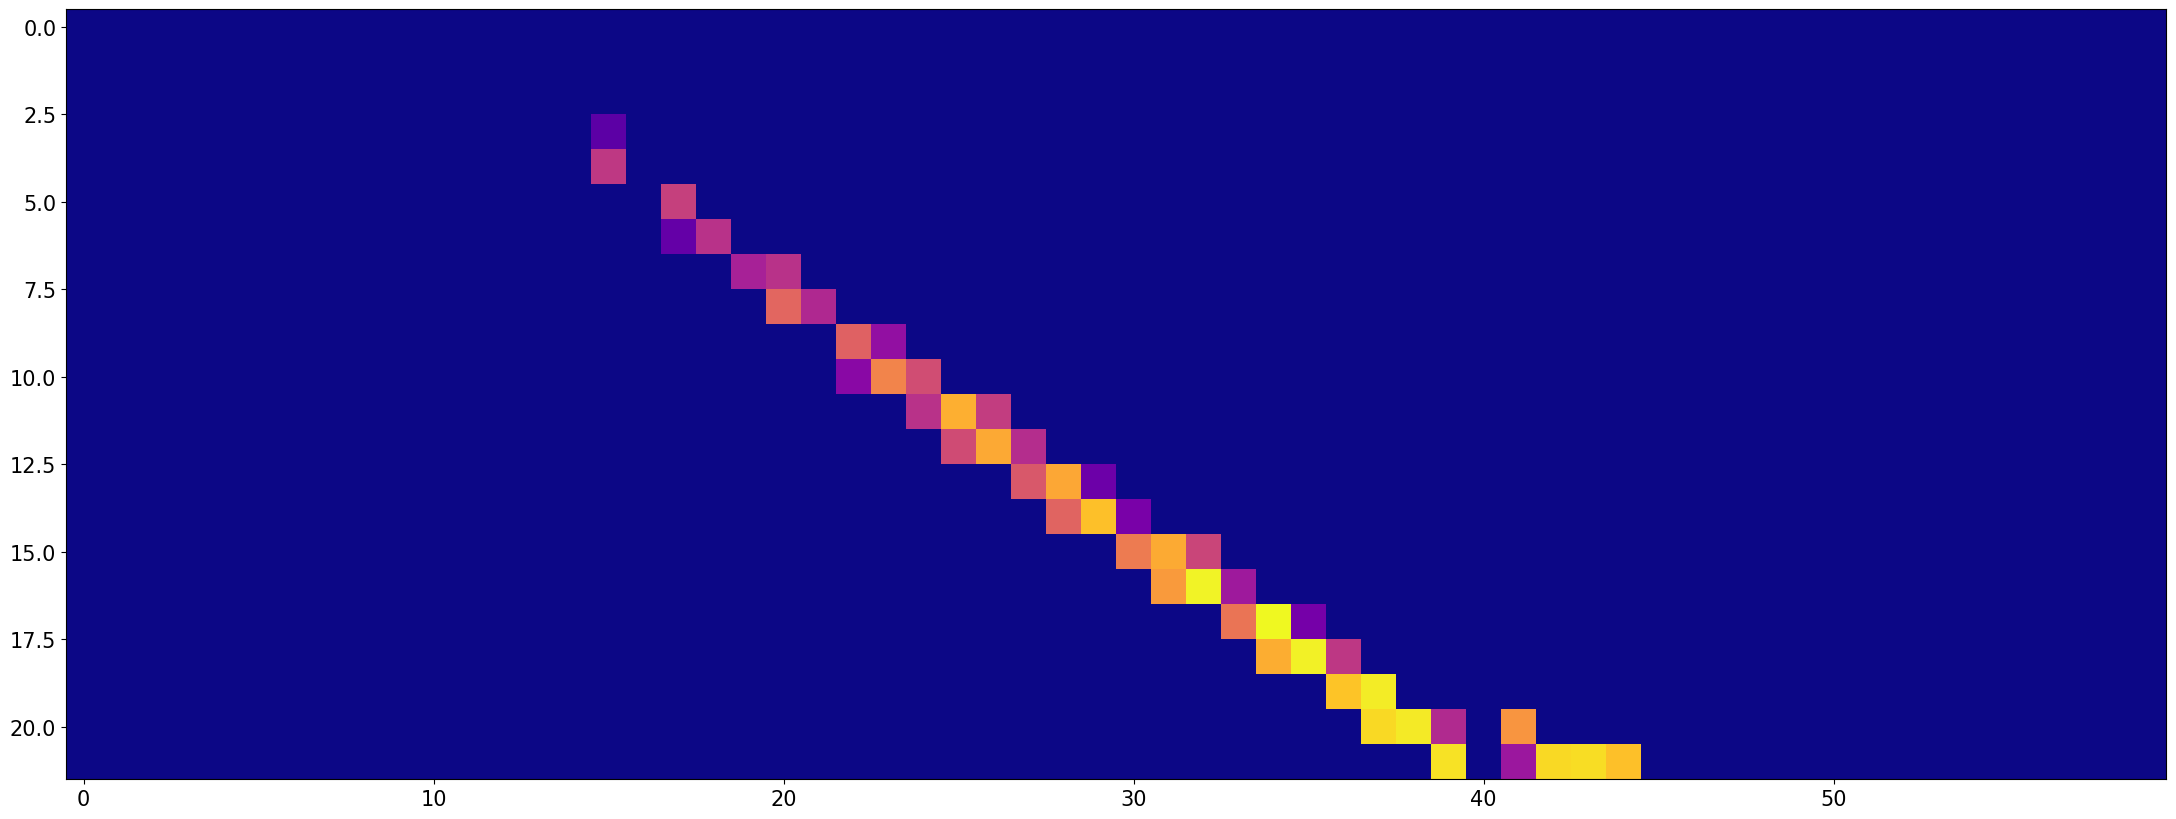

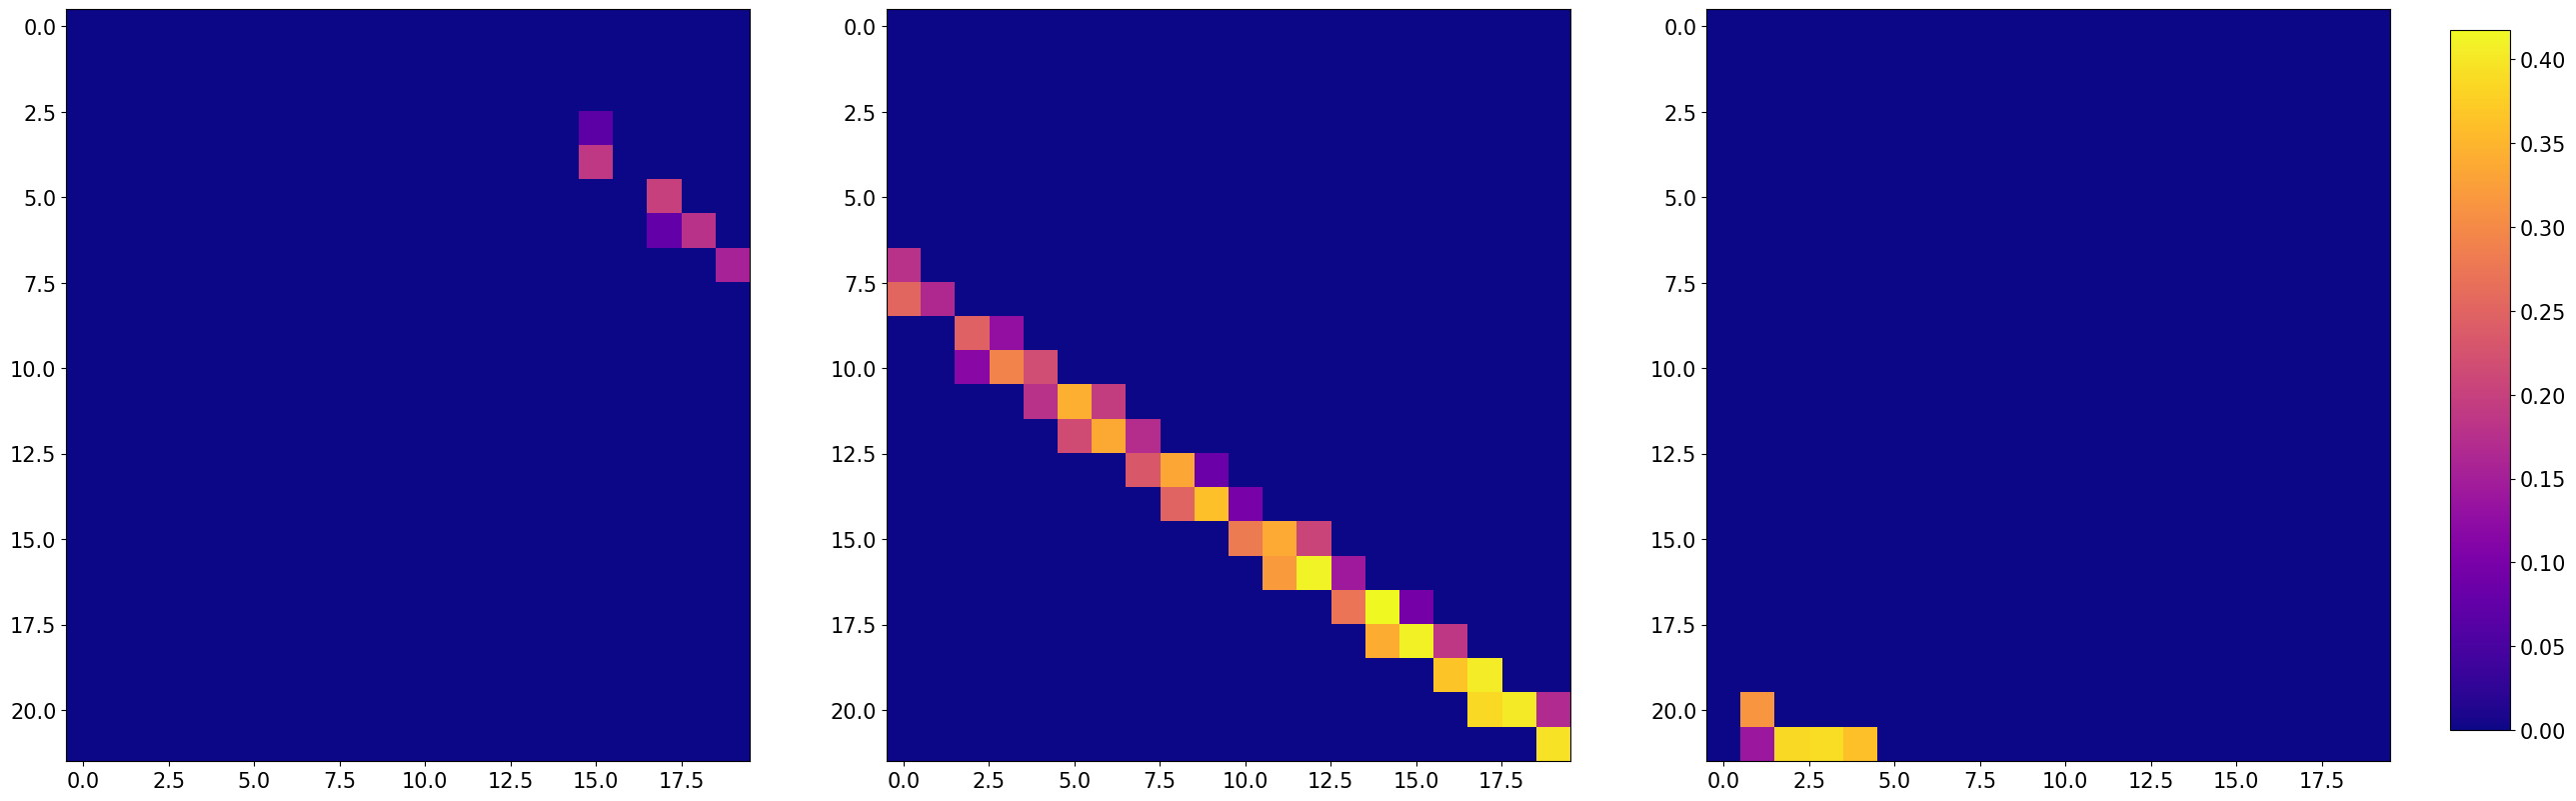

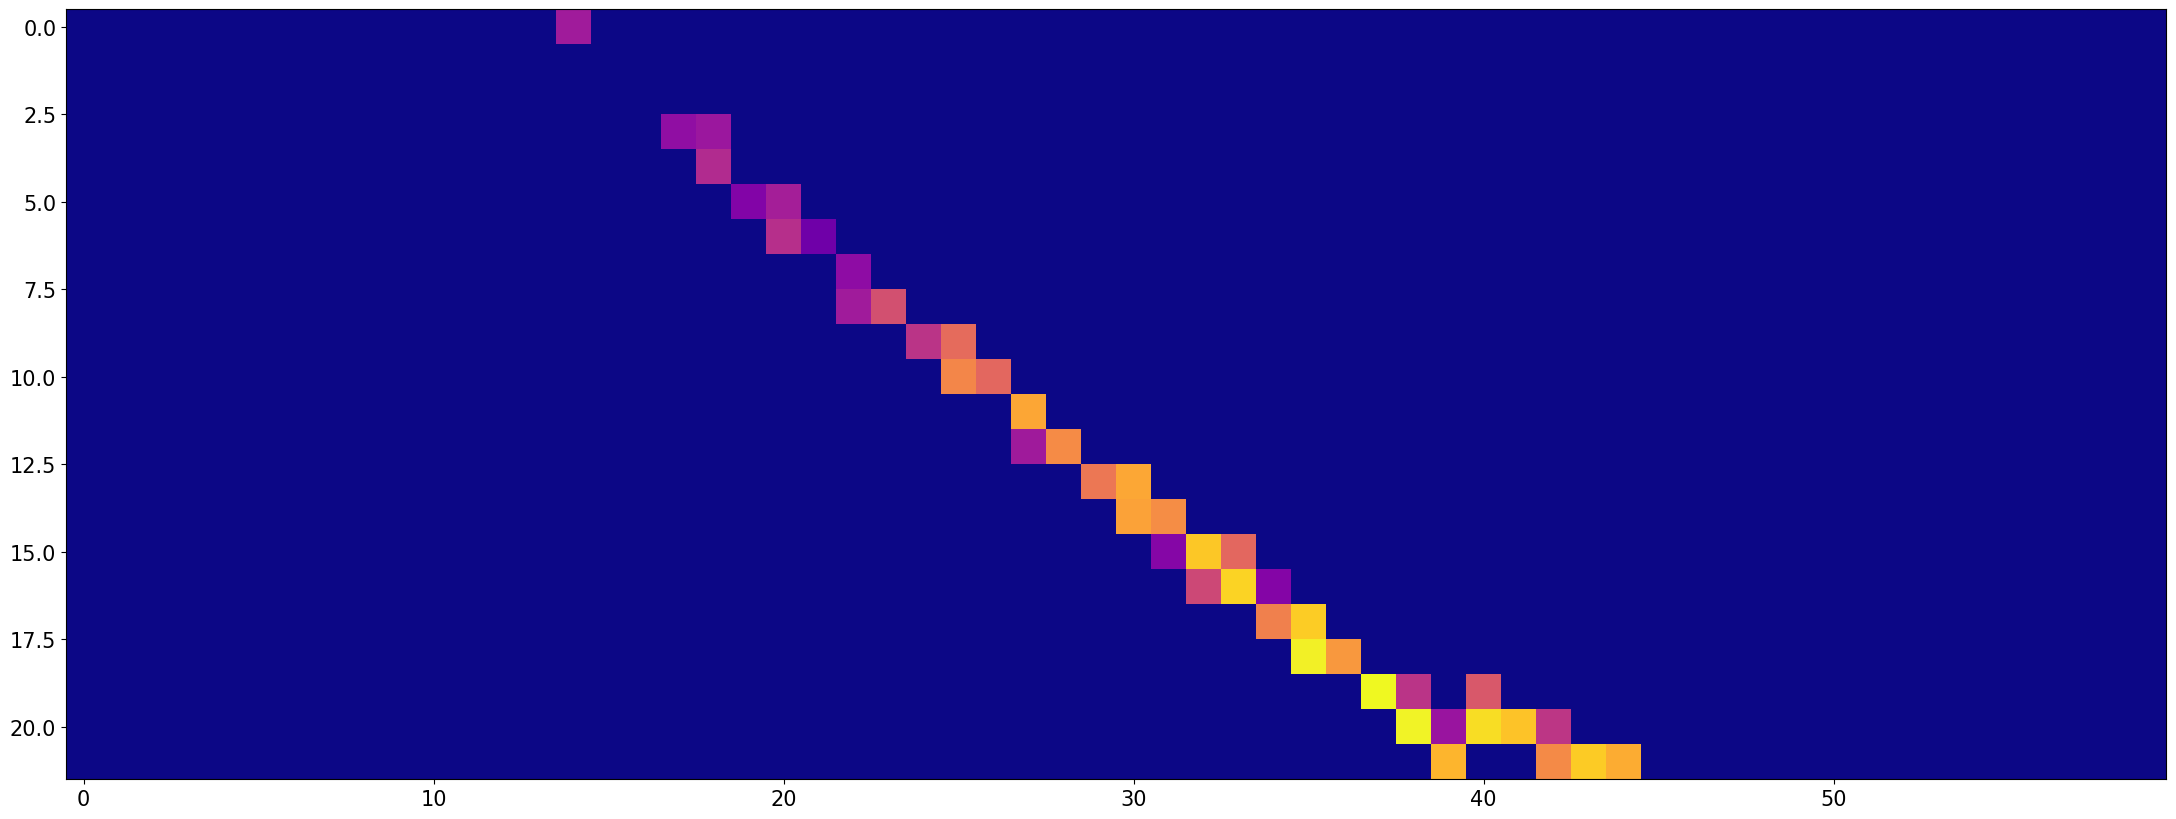

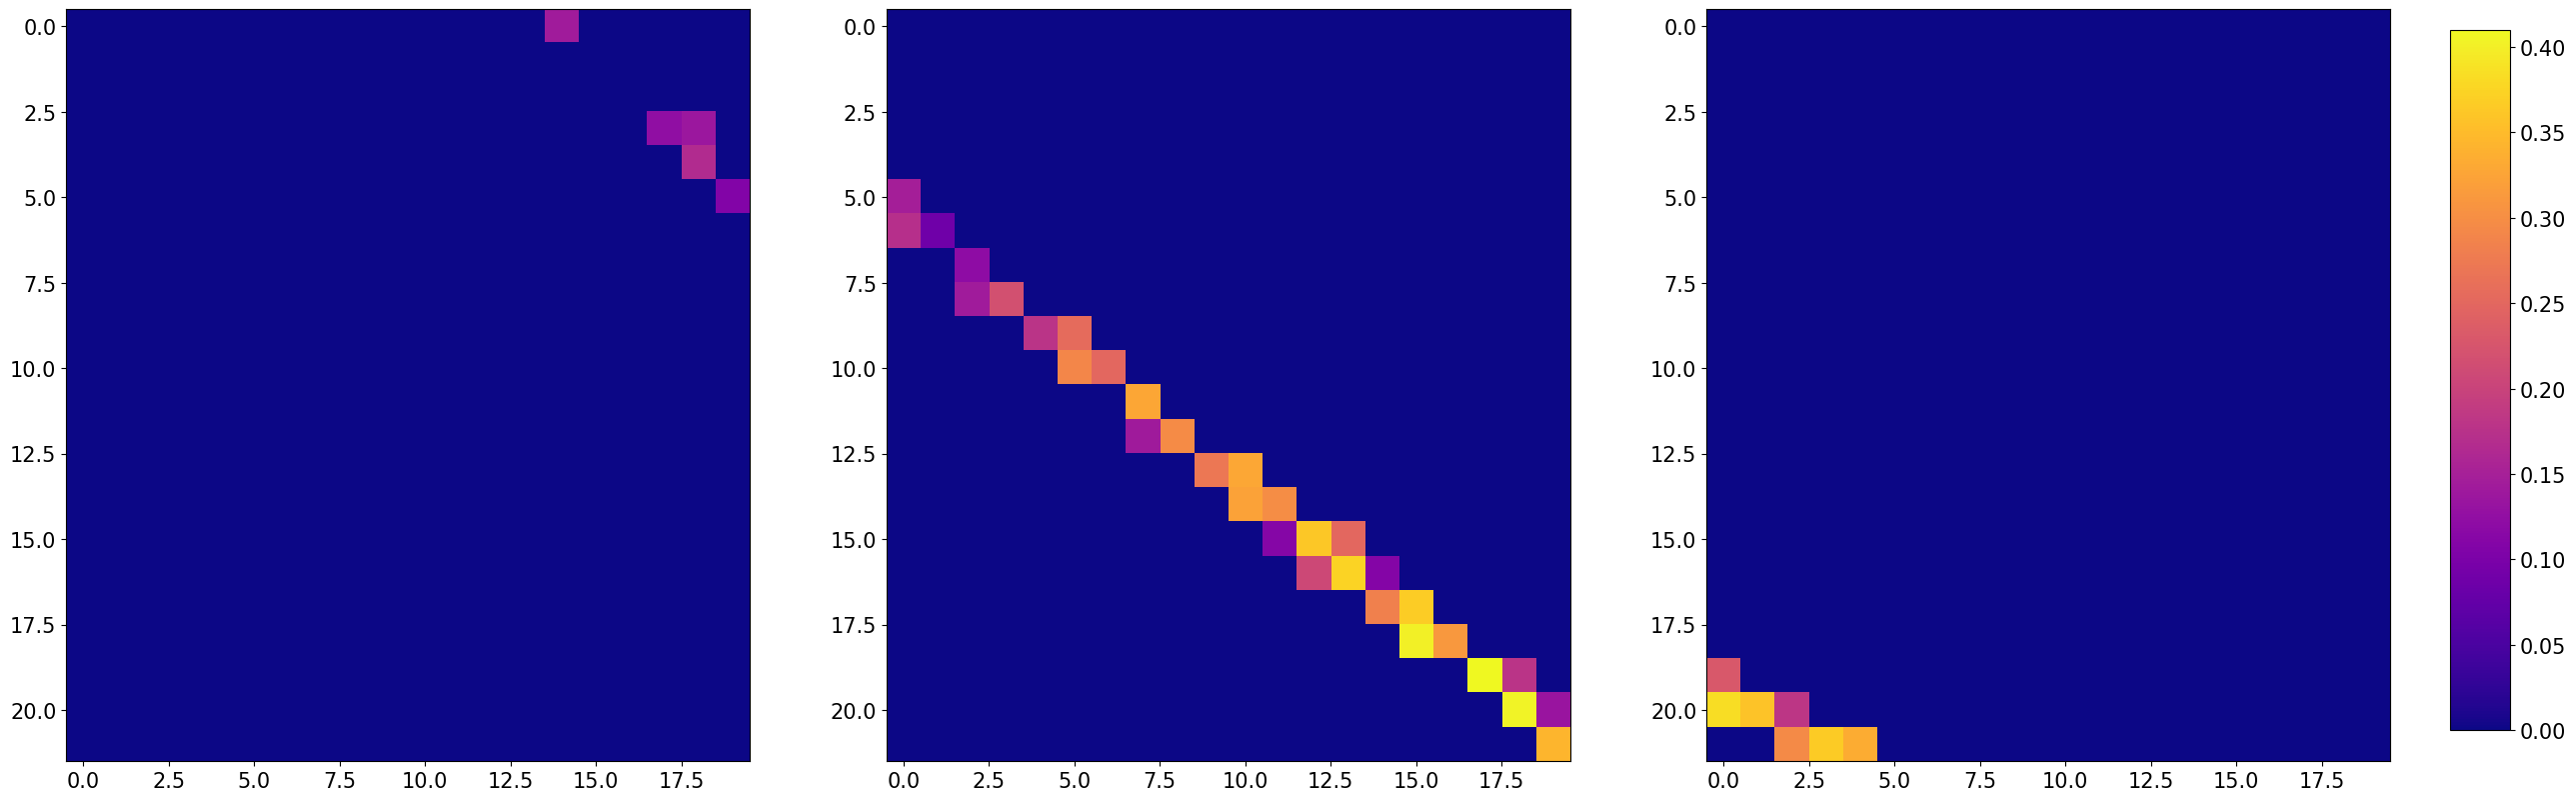

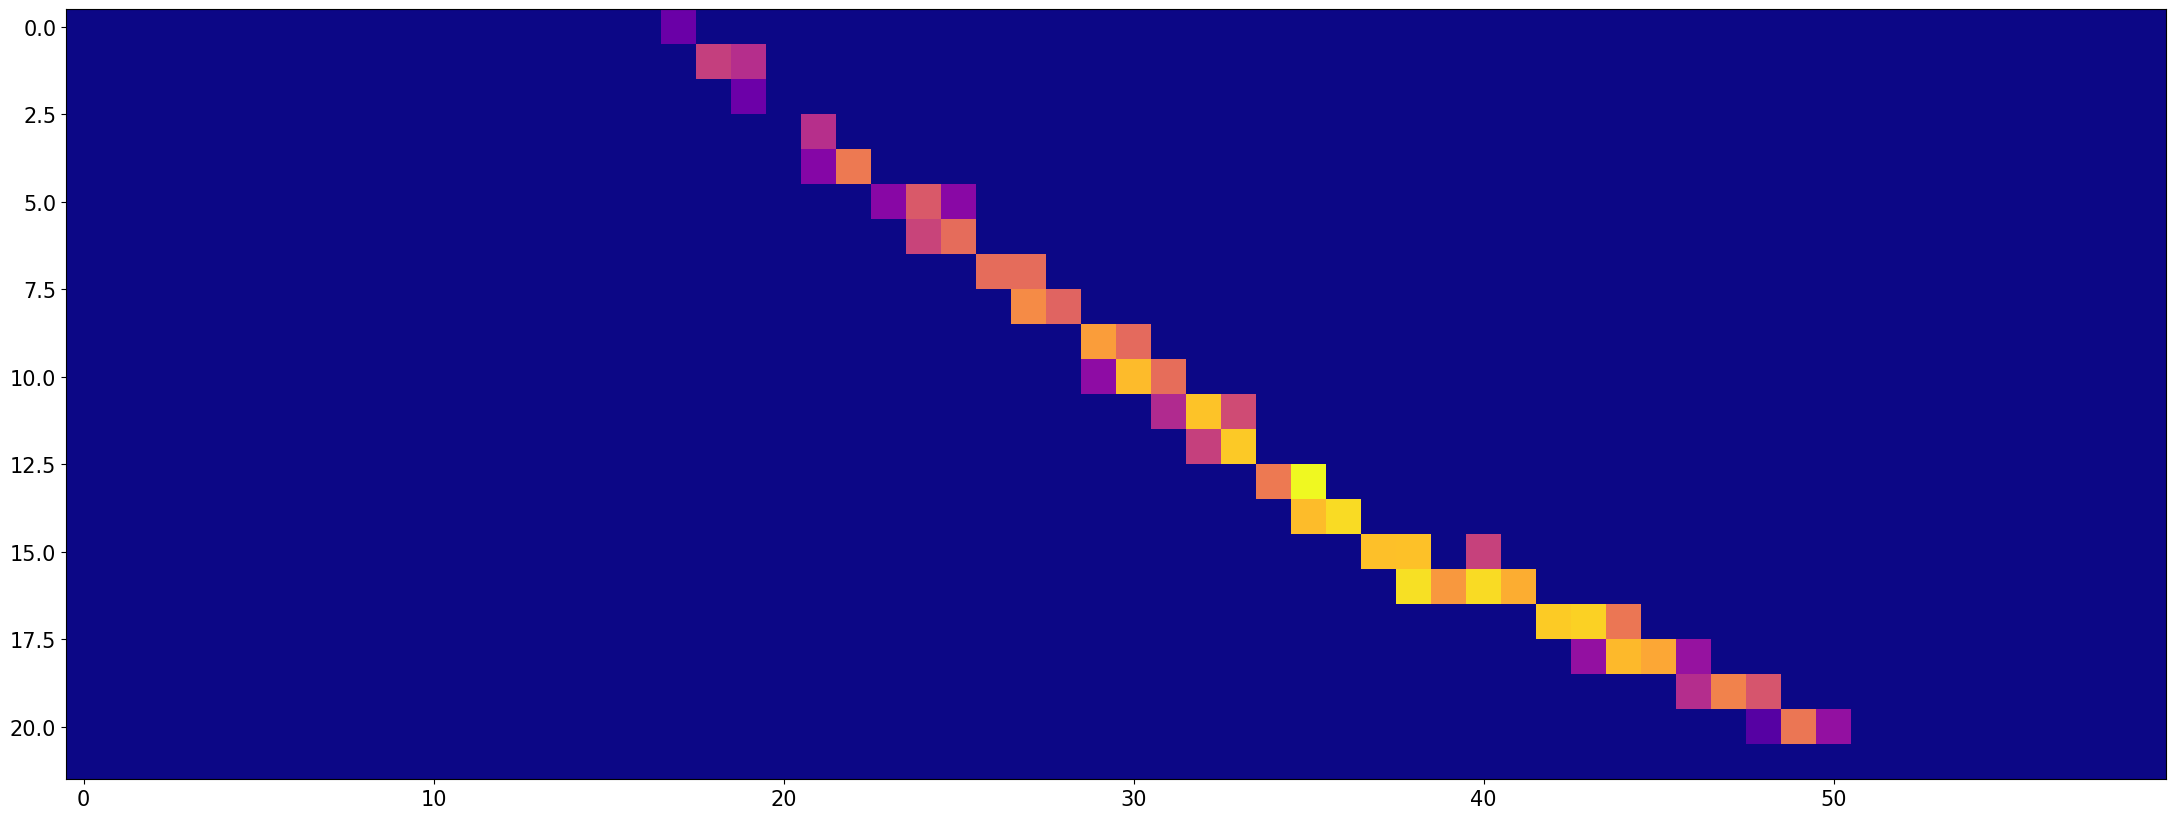

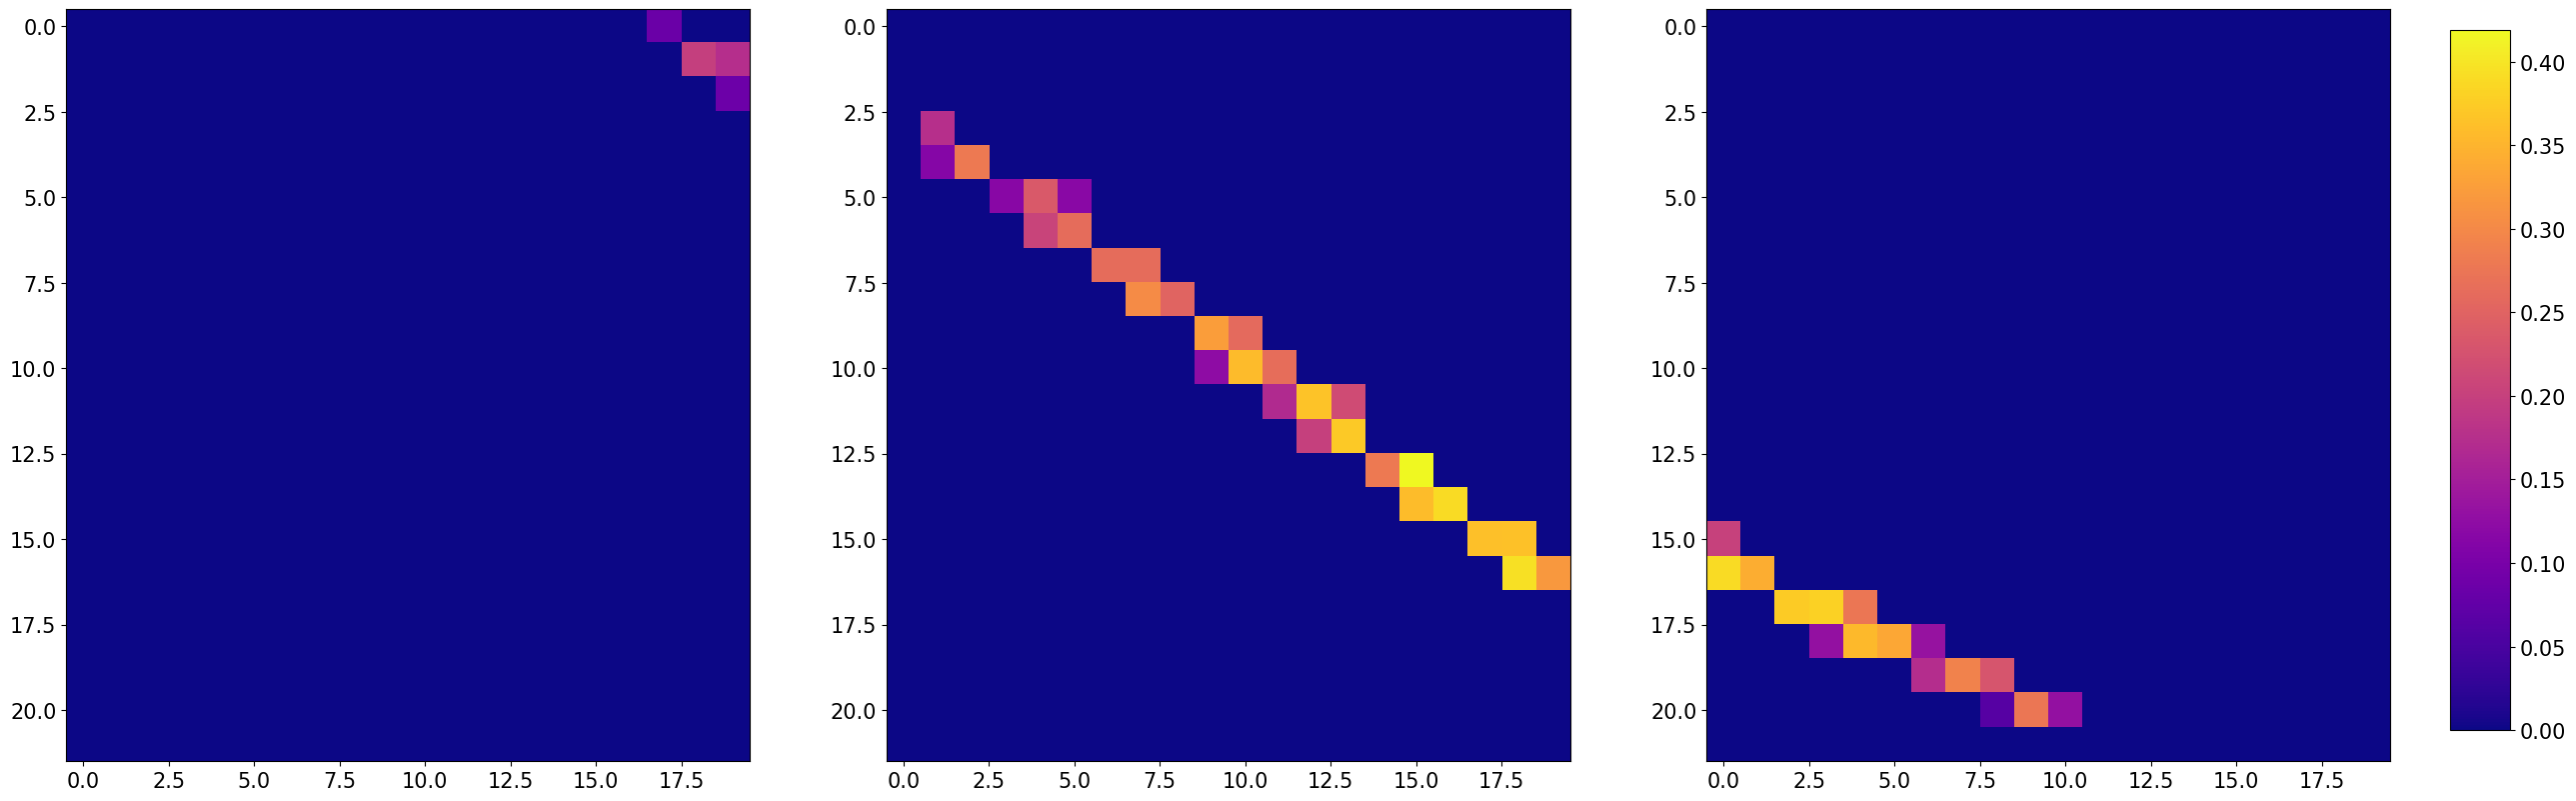

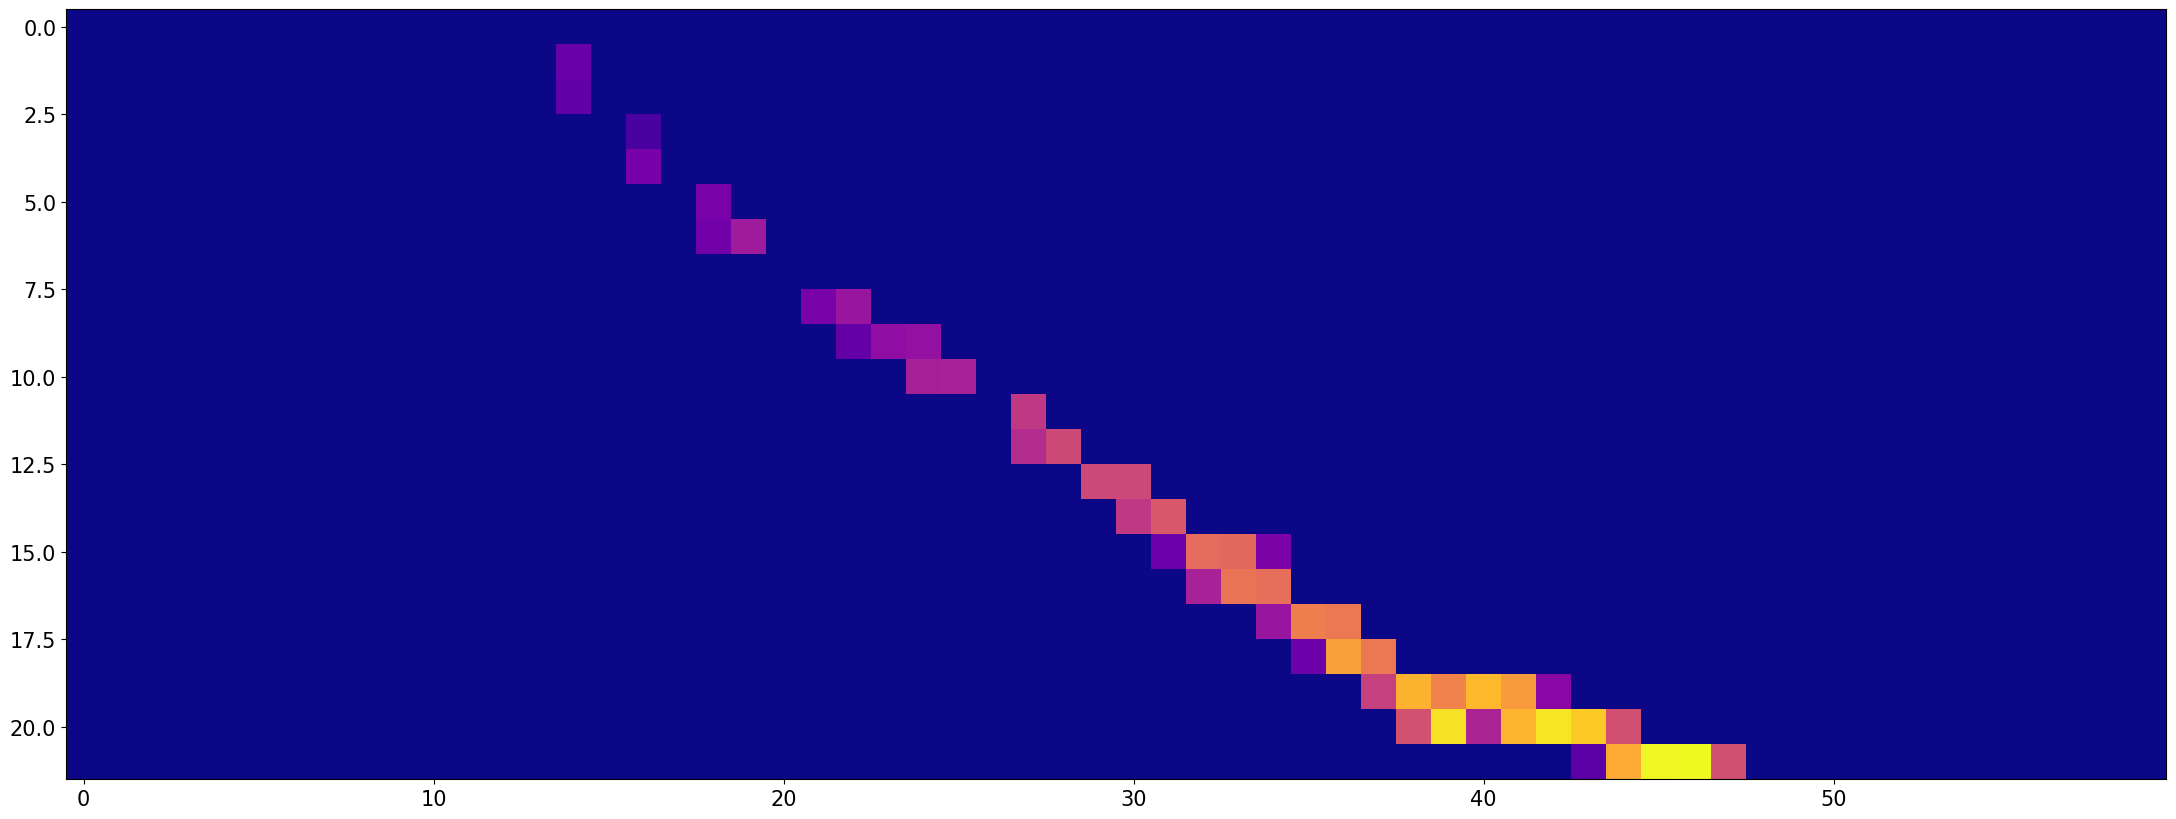

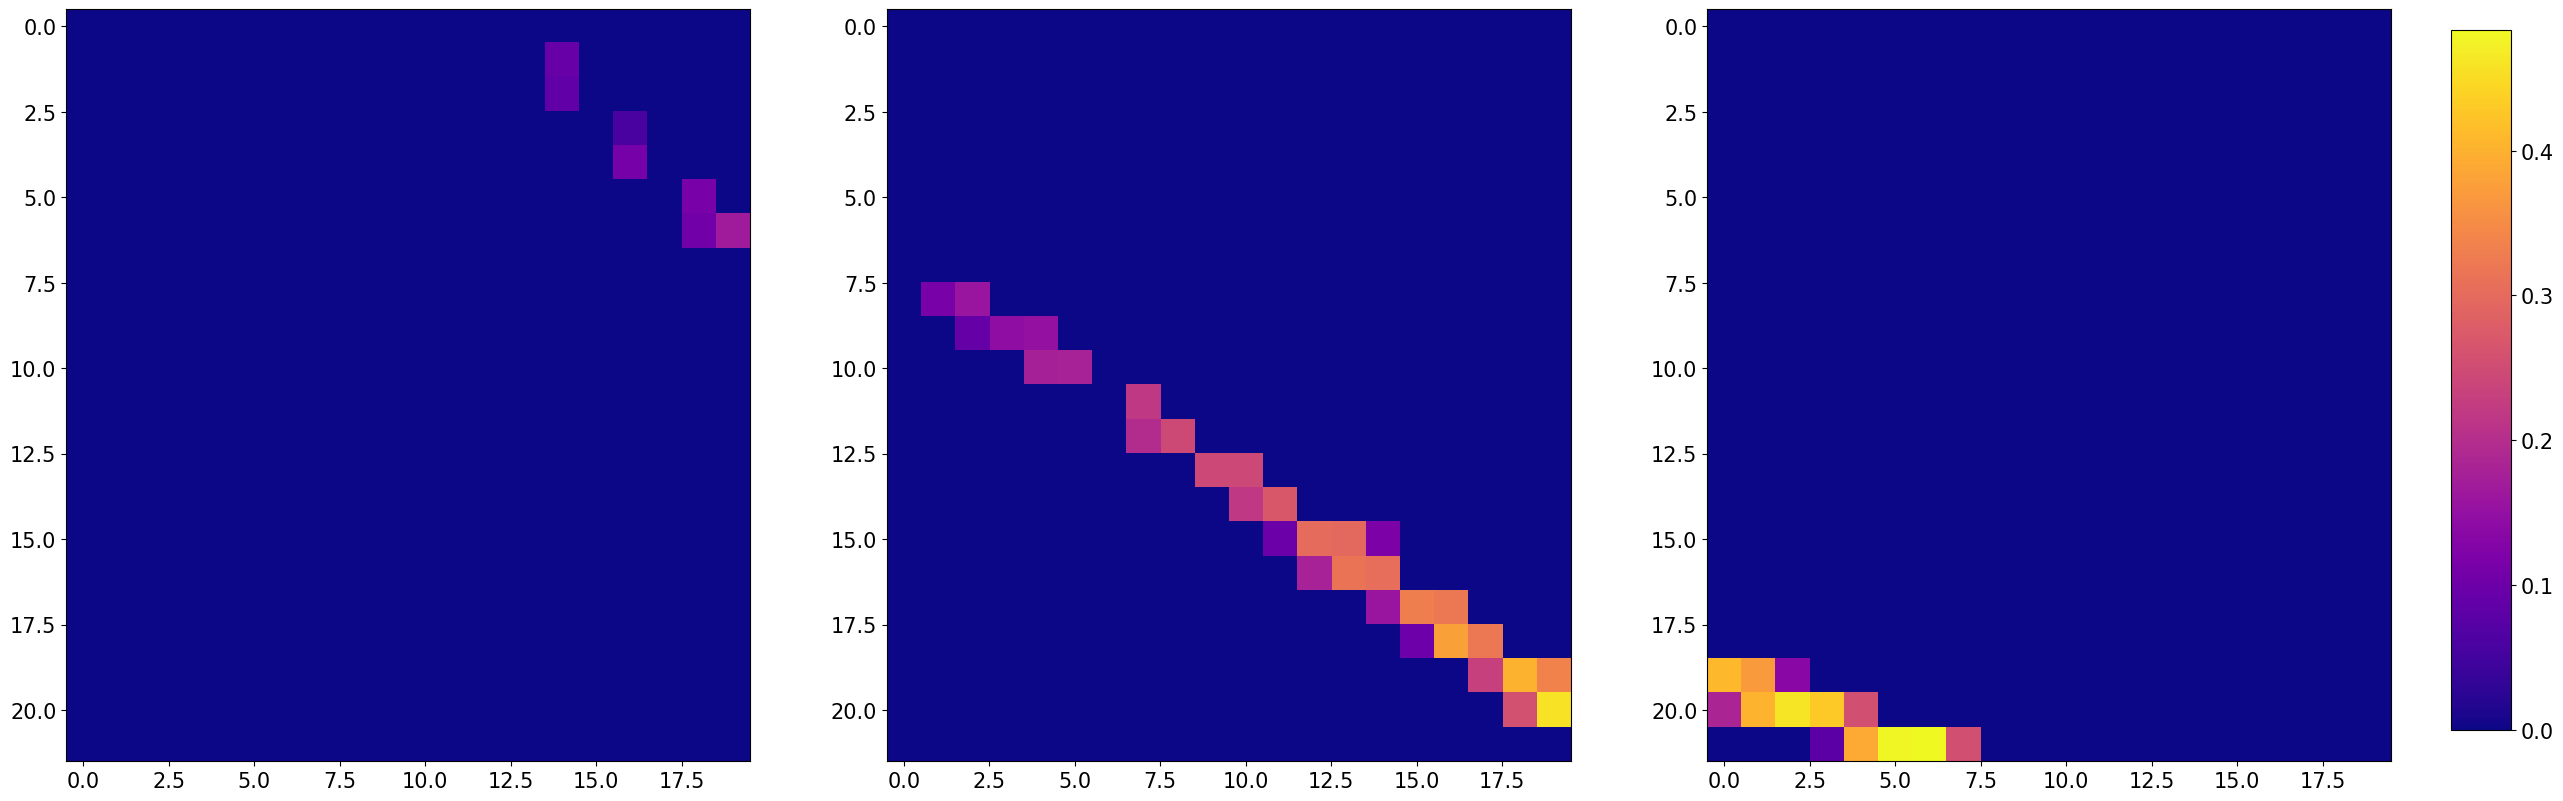

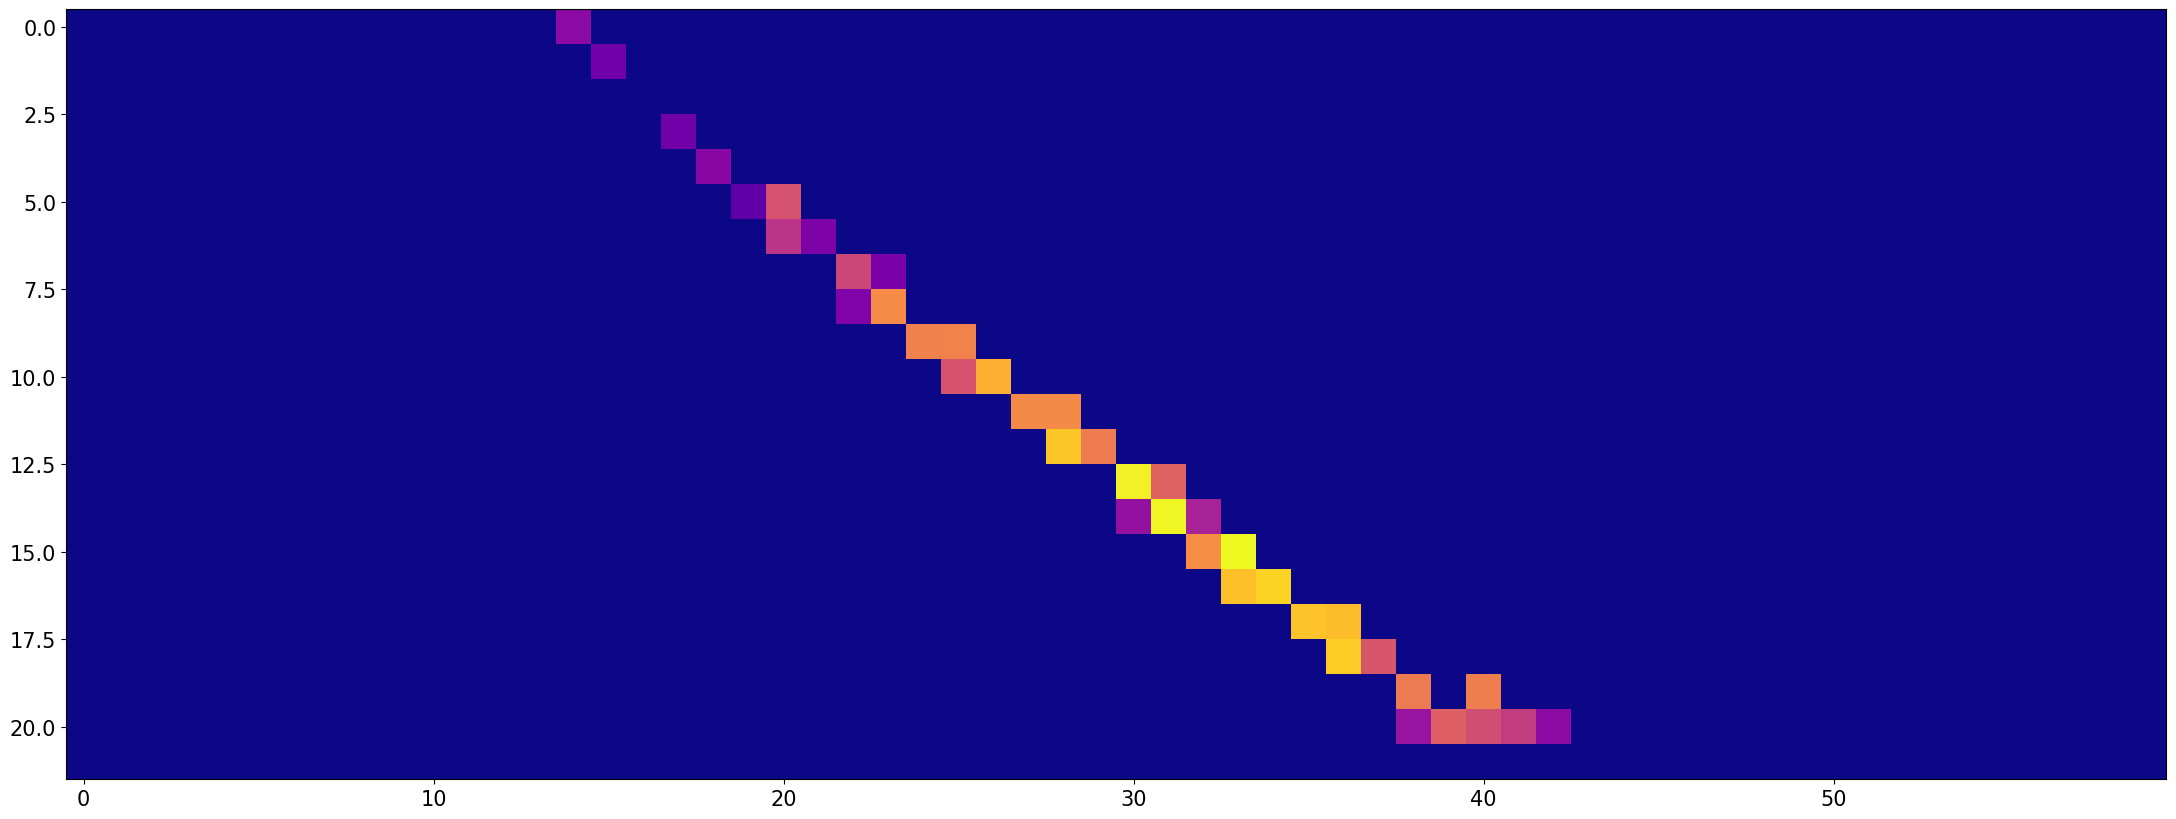

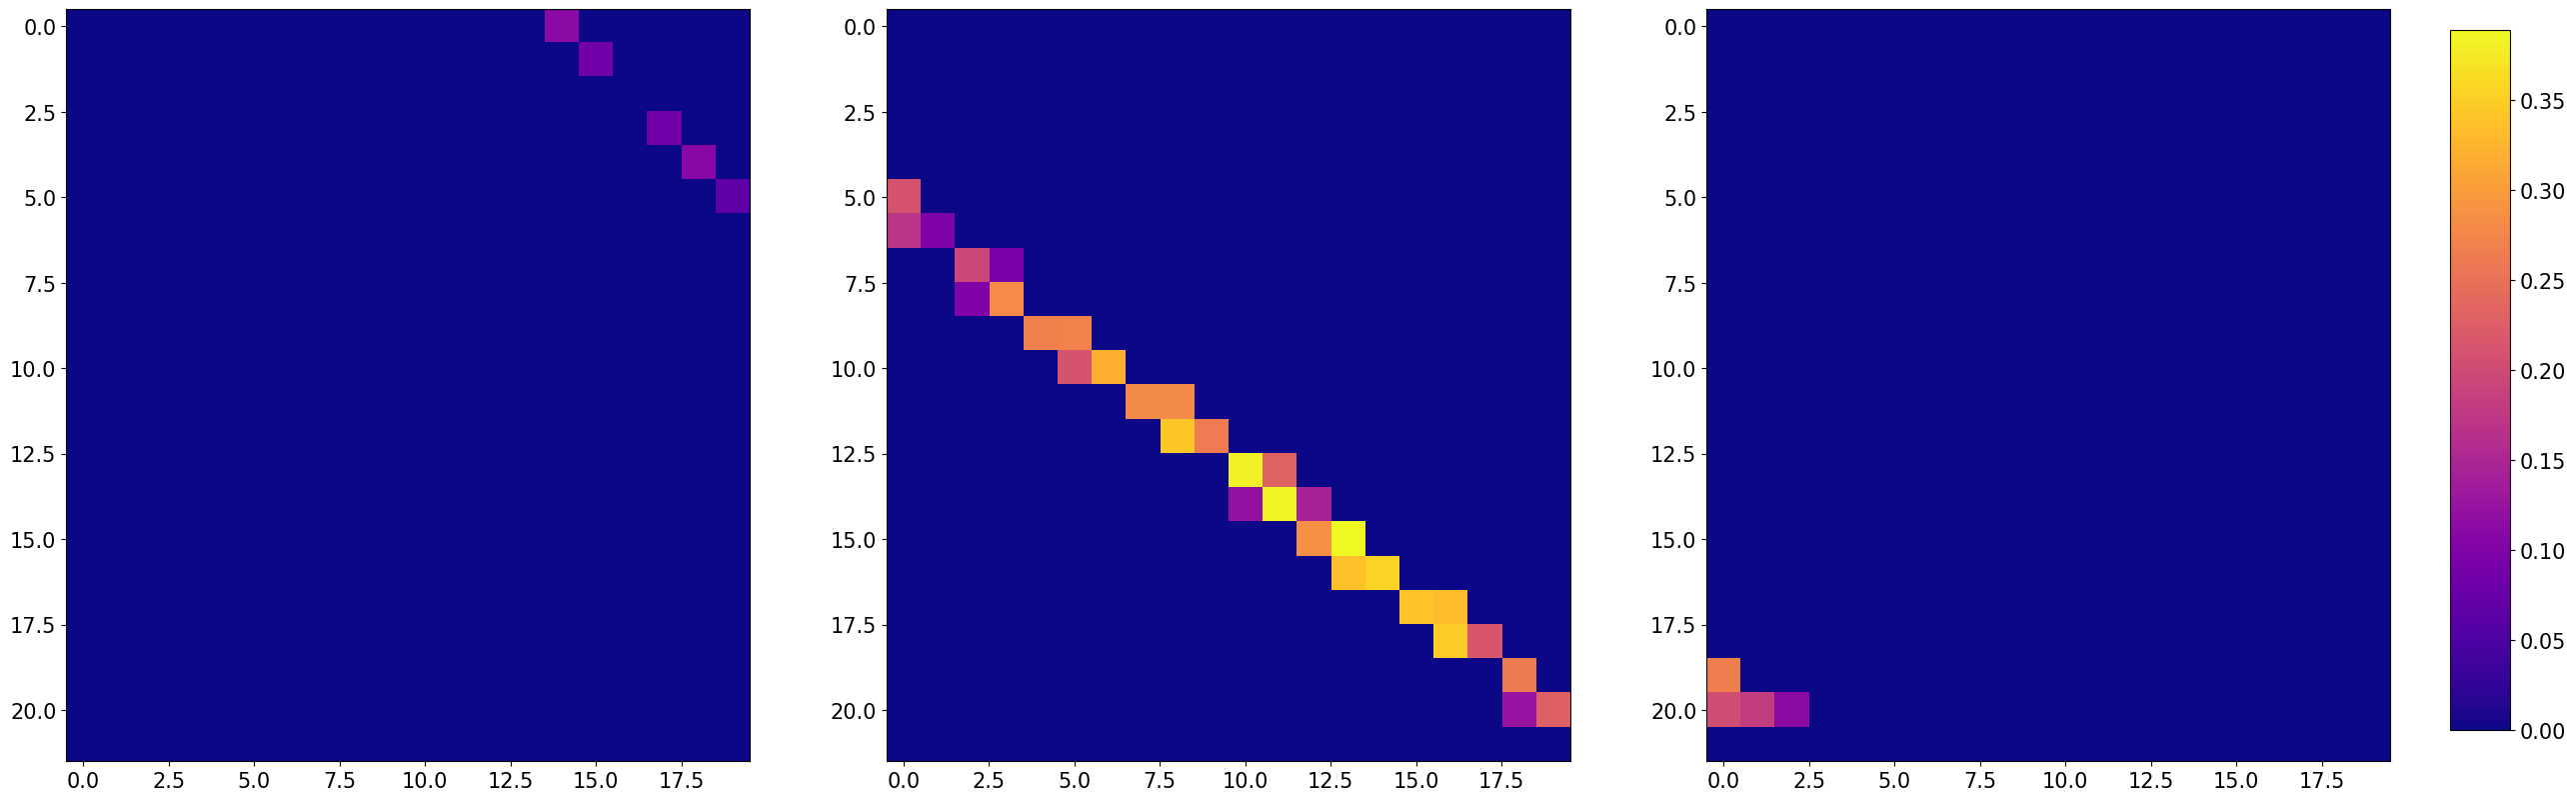

In [ ]:
# NPlots = 0
# for i in range(len(Main)):
#     print(f'Event {i}',end='\r')

#     P0 = Main[i][0][ 0:20,:].T
#     P1 = Main[i][0][20:40,:].T
#     P2 = Main[i][0][40:60,:].T


#     if P0.max() <= 0 or P2.max() <= 0: continue
#     NPlots += 1
#     plt.figure(figsize=[30,10])
#     plt.imshow(Main[i][0].T,cmap='plasma')

#     fig, axs = plt.subplots(1,3,figsize=[30,10])
#     im0 = axs[0].imshow(P0 ,cmap='plasma')
#     im1 = axs[1].imshow(P1 ,cmap='plasma')
#     im2 = axs[2].imshow(P2 ,cmap='plasma')

#     fig.colorbar(im0, ax=axs[0])
#     fig.colorbar(im1, ax=axs[1])
#     fig.colorbar(im2, ax=axs[2])

#     if NPlots ==5: break

import matplotlib.colors as mcolors

NPlots = 0
for i in range(len(Main)):
    print(f'Event {i}',end='\r')

    P0 = Main[i][0][ 0:20,:].T
    P1 = Main[i][0][20:40,:].T
    P2 = Main[i][0][40:60,:].T

    if P0.max() <= 0 or P2.max() <= 0: continue
    NPlots += 1
    plt.figure(figsize=[30,10])
    plt.imshow(Main[i][0].T,cmap='plasma')

    fig, axs = plt.subplots(1,3,figsize=[30,10])

    # Create a Normalize instance with the same vmin and vmax for all images
    vmin = min(P0.min(), P1.min(), P2.min())
    vmax = max(P0.max(), P1.max(), P2.max())
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    im0 = axs[0].imshow(P0, cmap='plasma', norm=norm)
    im1 = axs[1].imshow(P1, cmap='plasma', norm=norm)
    im2 = axs[2].imshow(P2, cmap='plasma', norm=norm)

    # Create a new axes for the colorbar at the right of the subplots
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im0, cax=cbar_ax)

    if NPlots ==5: break

In [ ]:
print(P0.shape)

torch.Size([22, 20])


# Making Graphs max-Pixels

In [ ]:
def Theta_Phi_Cross(Theta_1,Phi_1,Theta_2,Phi_2):
    X1 = torch.sin(Theta_1)*torch.cos(Phi_1)
    Y1 = torch.sin(Theta_1)*torch.sin(Phi_1)
    Z1 = torch.cos(Theta_1)

    X2 = torch.sin(Theta_2)*torch.cos(Phi_2)
    Y2 = torch.sin(Theta_2)*torch.sin(Phi_2)
    Z2 = torch.cos(Theta_2)
    
    one = torch.stack([X1,Y1,Z1],dim=1)
    two = torch.stack([X2,Y2,Z2],dim=1)


    return torch.linalg.cross(one,two)




def cut_pixels(Pixel_Theta,Pixel_Phi,SDP_Theta,SDP_Phi,zeta=None,pixel_count=None):
    assert zeta is None, 'Zeta broken because the angle is supposed to be 90 and i havent implemented the thing to work with 90'
    if zeta is not None: assert pixel_count is None, 'must provide either zeta or pixel_count'
    if zeta is None and pixel_count is None: pixel_count = 40
    ''' returns the pixels cut by too far away from the SDP
    pretty much is a hack, cause i am not supposed to know the SDP at this point, but its whatever'''

    if zeta is None and len(Pixel_Theta)<pixel_count: return torch.ones(len(Pixel_Theta)).bool()
    
    SDP_Vector = torch.tensor([torch.sin(SDP_Theta)*torch.cos(SDP_Phi),
                                torch.sin(SDP_Theta)*torch.sin(SDP_Phi),
                                torch.cos(SDP_Theta)])
    Pixel_Vector = torch.stack([torch.sin(Pixel_Theta)*torch.cos(Pixel_Phi),
                                    torch.sin(Pixel_Theta)*torch.sin(Pixel_Phi),
                                    torch.cos(Pixel_Theta)],dim=1)
    Dot_product = torch.sum(SDP_Vector*Pixel_Vector,dim=1)
    Angle = torch.acos(Dot_product)
    if zeta is not None: return Angle<zeta
    else:
        # Find the indices of the 40 smallest angles
        _, indices = torch.topk(torch.abs(Dot_product), pixel_count, largest=False)
        mask = torch.zeros(len(Pixel_Theta), dtype=bool)
        mask[indices] = True
        
        return mask




In [ ]:
def Unnormalise_Graph_SDP(Truth,AuxData=None):
    Truth[:,0] = torch.acos(Truth[:,0])/torch.pi*180
    Truth[:,1] = (torch.asin(Truth[:,1])+torch.pi/2)/torch.pi*180
    Truth[:,1][Truth[:,1]>180] -= 360
    if AuxData is None:
        return Truth
    else:
        Truth[:,1] += AuxData
        return Truth

def Graph_Edges(Dataset,ProcessingDataset = None):
    '''Produces graphs with Pixel and Edge Values
    PixelValues are : Theta, Phi, Centroid, Charge, PulseWidth
    EdgeValues are  : Angular Difference, Time Difference
    Also Passes the Truth and Rec and Aux values as they need to be normalised with the graph
    '''
    # PhiOffsets = {1:-75/180*torch.pi,2:-45/180*torch.pi,3:-15/180*torch.pi,4:15/180*torch.pi,5:45/180*torch.pi,6:75/180*torch.pi}
    leniency = 1.2
    max_ang_diff = 1.8*torch.sqrt(torch.tensor(3))
    # print(f'max ang diff = {max_ang_diff}')
    IDsList = ()
    Graph   = []
    AuxData = []

    Truth = []
    Rec   = []
    
    Meta  = []

    for i, Event in enumerate(Dataset):
        ID = (Event.get_value('EventID_1/2').int()*100000 + Event.get_value('EventID_2/2').int()).item()
        IDsList += (ID,)

        Pix_Phi        = Event.get_pixel_values('Phi')
        Pix_Theta      = Event.get_pixel_values('Theta')
        Pix_Centroid   = Event.get_pixel_values('PulseCentroid')
        Pix_PulseStart = Event.get_pixel_values('PulseStart')
        Pix_PulseStop  = Event.get_pixel_values('PulseStop')
        Pix_Charge     = Event.get_pixel_values('Charge')
        TelID          = Event.get_pixel_values('TelID')
        PixelIDs       = Event.get_pixel_values('PixelID')
        Pixel_Status   = Event.get_pixel_values('Status')
        HEAT = (TelID == 7)+(TelID == 8)+(TelID == 9)+(Event.get_pixel_values('EyeID') == 5)
        
        # Meta Values 
        Primary  = Event.get_value('Primary')
        LogE     = Event.get_value('Gen_LogE')
        Xmax     = Event.get_value('Gen_Xmax')
        # Going to cheat here and throw away the noise pixels before i do the graph
        # cut = (Pixel_Status == 4)
        # Pix_Phi        = Pix_Phi       [cut]
        # Pix_Theta      = Pix_Theta     [cut]
        # Pix_Centroid   = Pix_Centroid  [cut]
        # Pix_PulseStart = Pix_PulseStart[cut]
        # Pix_PulseStop  = Pix_PulseStop [cut]
        # Pix_Charge     = Pix_Charge    [cut]
        # TelID          = TelID         [cut]
        # PixelIDs       = PixelIDs      [cut]
        # HEAT           = HEAT          [cut]

        SDP_Theta = Event.get_value('Gen_SDPTheta')
        SDP_Phi   = Event.get_value('Gen_SDPPhi')
        
        Rec_SDP_Theta = Event.get_value('Rec_SDPTheta')
        Rec_SDP_Phi   = Event.get_value('Rec_SDPPhi')

        
        # There is no HEAT in new Dataset, but keeping for backwards compatibility

        cut = cut_pixels(Pix_Theta/180*torch.pi,Pix_Phi/180*torch.pi,SDP_Theta,SDP_Phi,pixel_count=40)

        Pix_Phi        = Pix_Phi       [cut]
        Pix_Theta      = Pix_Theta     [cut]
        Pix_Centroid   = Pix_Centroid  [cut]
        Pix_PulseStart = Pix_PulseStart[cut]
        Pix_PulseStop  = Pix_PulseStop [cut]
        Pix_Charge     = Pix_Charge    [cut]
        TelID          = TelID         [cut]
        PixelIDs       = PixelIDs      [cut]
        Pixel_Status   = Pixel_Status  [cut]
        HEAT           = HEAT          [cut]

        if not HEAT.all(): 
            Pix_PulseStart[HEAT]= 0.5 * Pix_PulseStart[HEAT]
            Pix_PulseStop [HEAT]= 0.5 * Pix_PulseStop [HEAT]

            
            Pix_PulseWidth = (Pix_PulseStop - Pix_PulseStart)/2
            
            Pix_Time_Diff = torch.abs(Pix_Centroid  [None,:] - Pix_Centroid  [:,None])
            Pix_Time_Gap  = torch.abs(Pix_PulseWidth[None,:] + Pix_PulseWidth[:,None])
            Pix_Ang_Diff  = torch.sqrt((Pix_Phi[None,:]-Pix_Phi[:,None])**2 + (Pix_Theta[None,:]-Pix_Theta[:,None])**2)
            
            Edges = (Pix_Time_Diff < leniency*Pix_Time_Gap) & (Pix_Ang_Diff<max_ang_diff) # 
            Edges = torch.stack(torch.where(Edges),dim=1)
            Edges = Edges[Edges[:,0]!=Edges[:,1]]
            # print(Edges.shape)
            
            # Normalise Node Values
            Pix_Theta    = (90-Pix_Theta)/30
            Central_Phi  = torch.mean(Pix_Phi)
            # Pix_Phi      = (Pix_Phi-Central_Phi)/40

            Pix_Centroid = Pix_Centroid/1000
            Pix_Charge   = torch.log10(Pix_Charge+1)/2.5-1
            Pix_PulseWidth = Pix_PulseWidth/50

            Node_values   = torch.stack([Pix_Theta,Pix_Phi,Pix_Centroid,Pix_Charge,Pix_PulseWidth],dim=1)

            # Edge_ang_div  = torch.sqrt((Pix_Phi[Edges[0,:]]-Pix_Phi[Edges[1,:]])**2 + (Pix_Theta[Edges[0,:]]-Pix_Theta[Edges[1,:]])**2)
            # Edge_time_div = torch.abs(Pix_Centroid[Edges[0]]-Pix_Centroid[Edges[1]])
            Edge_ang_div  = Pix_Ang_Diff[Edges[:,0],Edges[:,1]]
            Edge_time_div = Pix_Time_Diff[Edges[:,0],Edges[:,1]]

            # Normalise Edge Values
            Edge_ang_div  = Edge_ang_div/1.5
            Edge_time_div = Edge_time_div/100
            Edge_values   = torch.stack([Edge_ang_div,Edge_time_div],dim=1)
            
            # Normalise SDP Values
            SDP_Theta     = torch.cos(SDP_Theta)
            Rec_SDP_Theta = torch.cos(Rec_SDP_Theta)

            # SDP Phi will be normalised later
            
            # Meta is not normalised
            
            TruthValues = torch.stack([SDP_Theta,SDP_Phi])
            RecValues   = torch.stack([Rec_SDP_Theta,Rec_SDP_Phi])
            MetaValues  = torch.stack([Primary,LogE,Xmax])

            # Append to the Storage Lists
            Graph  .append([Node_values,Edges,Edge_values])
            AuxData.append(Central_Phi)
            Truth  .append(TruthValues)
            Rec    .append(RecValues)
            Meta   .append(MetaValues)
        else:
            Node_values = torch.tensor([[0,0,0,0]])
            Edges = torch.tensor([[0,0]])
            Edge_values = torch.tensor([[0,0]])
            Graph.append([Node_values,Edges,Edge_values])
            AuxData.append(0)
            Truth.append(torch.tensor([0,0]))
            Rec.append(torch.tensor([0,0]))
            Meta.append(torch.tensor([0,0,0]))

    


    # Slap into Dataset
    Meta    = torch.stack(Meta,dim=0)
    Truth   = torch.stack(Truth,dim=0)
    Rec     = torch.stack(Rec,dim=0)            
    AuxData = torch.tensor(AuxData).unsqueeze(1)
    
    # Normalise SDP Phi

    Truth[:,1][Truth[:,1]<0] += 2*torch.pi
    Rec  [:,1][Rec  [:,1]<0] += 2*torch.pi

    Truth[:,1] -= torch.pi/2
    Rec  [:,1] -= torch.pi/2

    Truth[:,1] -= Central_Phi/180*torch.pi
    Rec  [:,1] -= Central_Phi/180*torch.pi

    # Truth[:,1]  = torch.sin(Truth[:,1])
    # Rec  [:,1]  = torch.sin(Rec  [:,1])
    


    if ProcessingDataset is None:
        return Graph,AuxData,Truth,Rec,Meta,IDsList
    else:
        ProcessingDataset.GraphData = True
        ProcessingDataset._Graph    = Graph
        ProcessingDataset._Aux      = AuxData
        ProcessingDataset._Truth    = Truth
        ProcessingDataset._Rec      = Rec
        ProcessingDataset._MetaData = Meta
        
        ProcessingDataset.Unnormalise_Truth = Unnormalise_Graph_SDP
        ProcessingDataset.Truth_Keys        = ['SDPPTheta','SDPPPhi']
        ProcessingDataset.Truth_Units       = ['deg','deg']
        
        if ProcessingDataset._EventIds is None:
            ProcessingDataset._EventIds = IDsList
        else:
            assert ProcessingDataset._EventIds == IDsList, 'Event IDs do not match'


Graphs,AuxData,Truth,Rec,Meta,IDsList = Graph_Edges(Run010)

### Checking How to Normalise Data

In [ ]:
print(Graphs[0][0].shape)
print(Graphs[0][1].shape)
print(Graphs[0][2].shape)


torch.Size([14, 5])
torch.Size([18, 2])
torch.Size([18, 2])


In [ ]:
ALL_Pix_Phi     = []
ALL_SDP_Phi     = []
ALL_Central_Phi = []

for T,G,C in zip(Truth,Graphs,AuxData):
    ALL_Pix_Phi    .append(G[0][:,1].clone())
    ALL_SDP_Phi    .append(T[1].clone().repeat(G[0].shape[0],1))
    ALL_Central_Phi.append(C   .clone().repeat(G[0].shape[0],1))

ALL_Pix_Phi     = torch.cat(ALL_Pix_Phi    ,dim=0)          .numpy()
ALL_Central_Phi = torch.cat(ALL_Central_Phi,dim=0).squeeze().numpy()
ALL_SDP_Phi     = torch.cat(ALL_SDP_Phi    ,dim=0).squeeze().numpy()

ALL_SDP_Phi_Short     = Truth[:,1].numpy()
ALL_Central_Phi_Short = AuxData.squeeze().numpy()


In [ ]:
print(ALL_Pix_Phi.shape)
print(ALL_SDP_Phi.shape)
print(ALL_Central_Phi.shape)

print(ALL_SDP_Phi_Short.shape)
print(ALL_Central_Phi_Short.shape)

(4027517,)
(4027517,)
(4027517,)
(154195,)
(154195,)


In [ ]:
ALL_SDP_Phi *= 180/np.pi

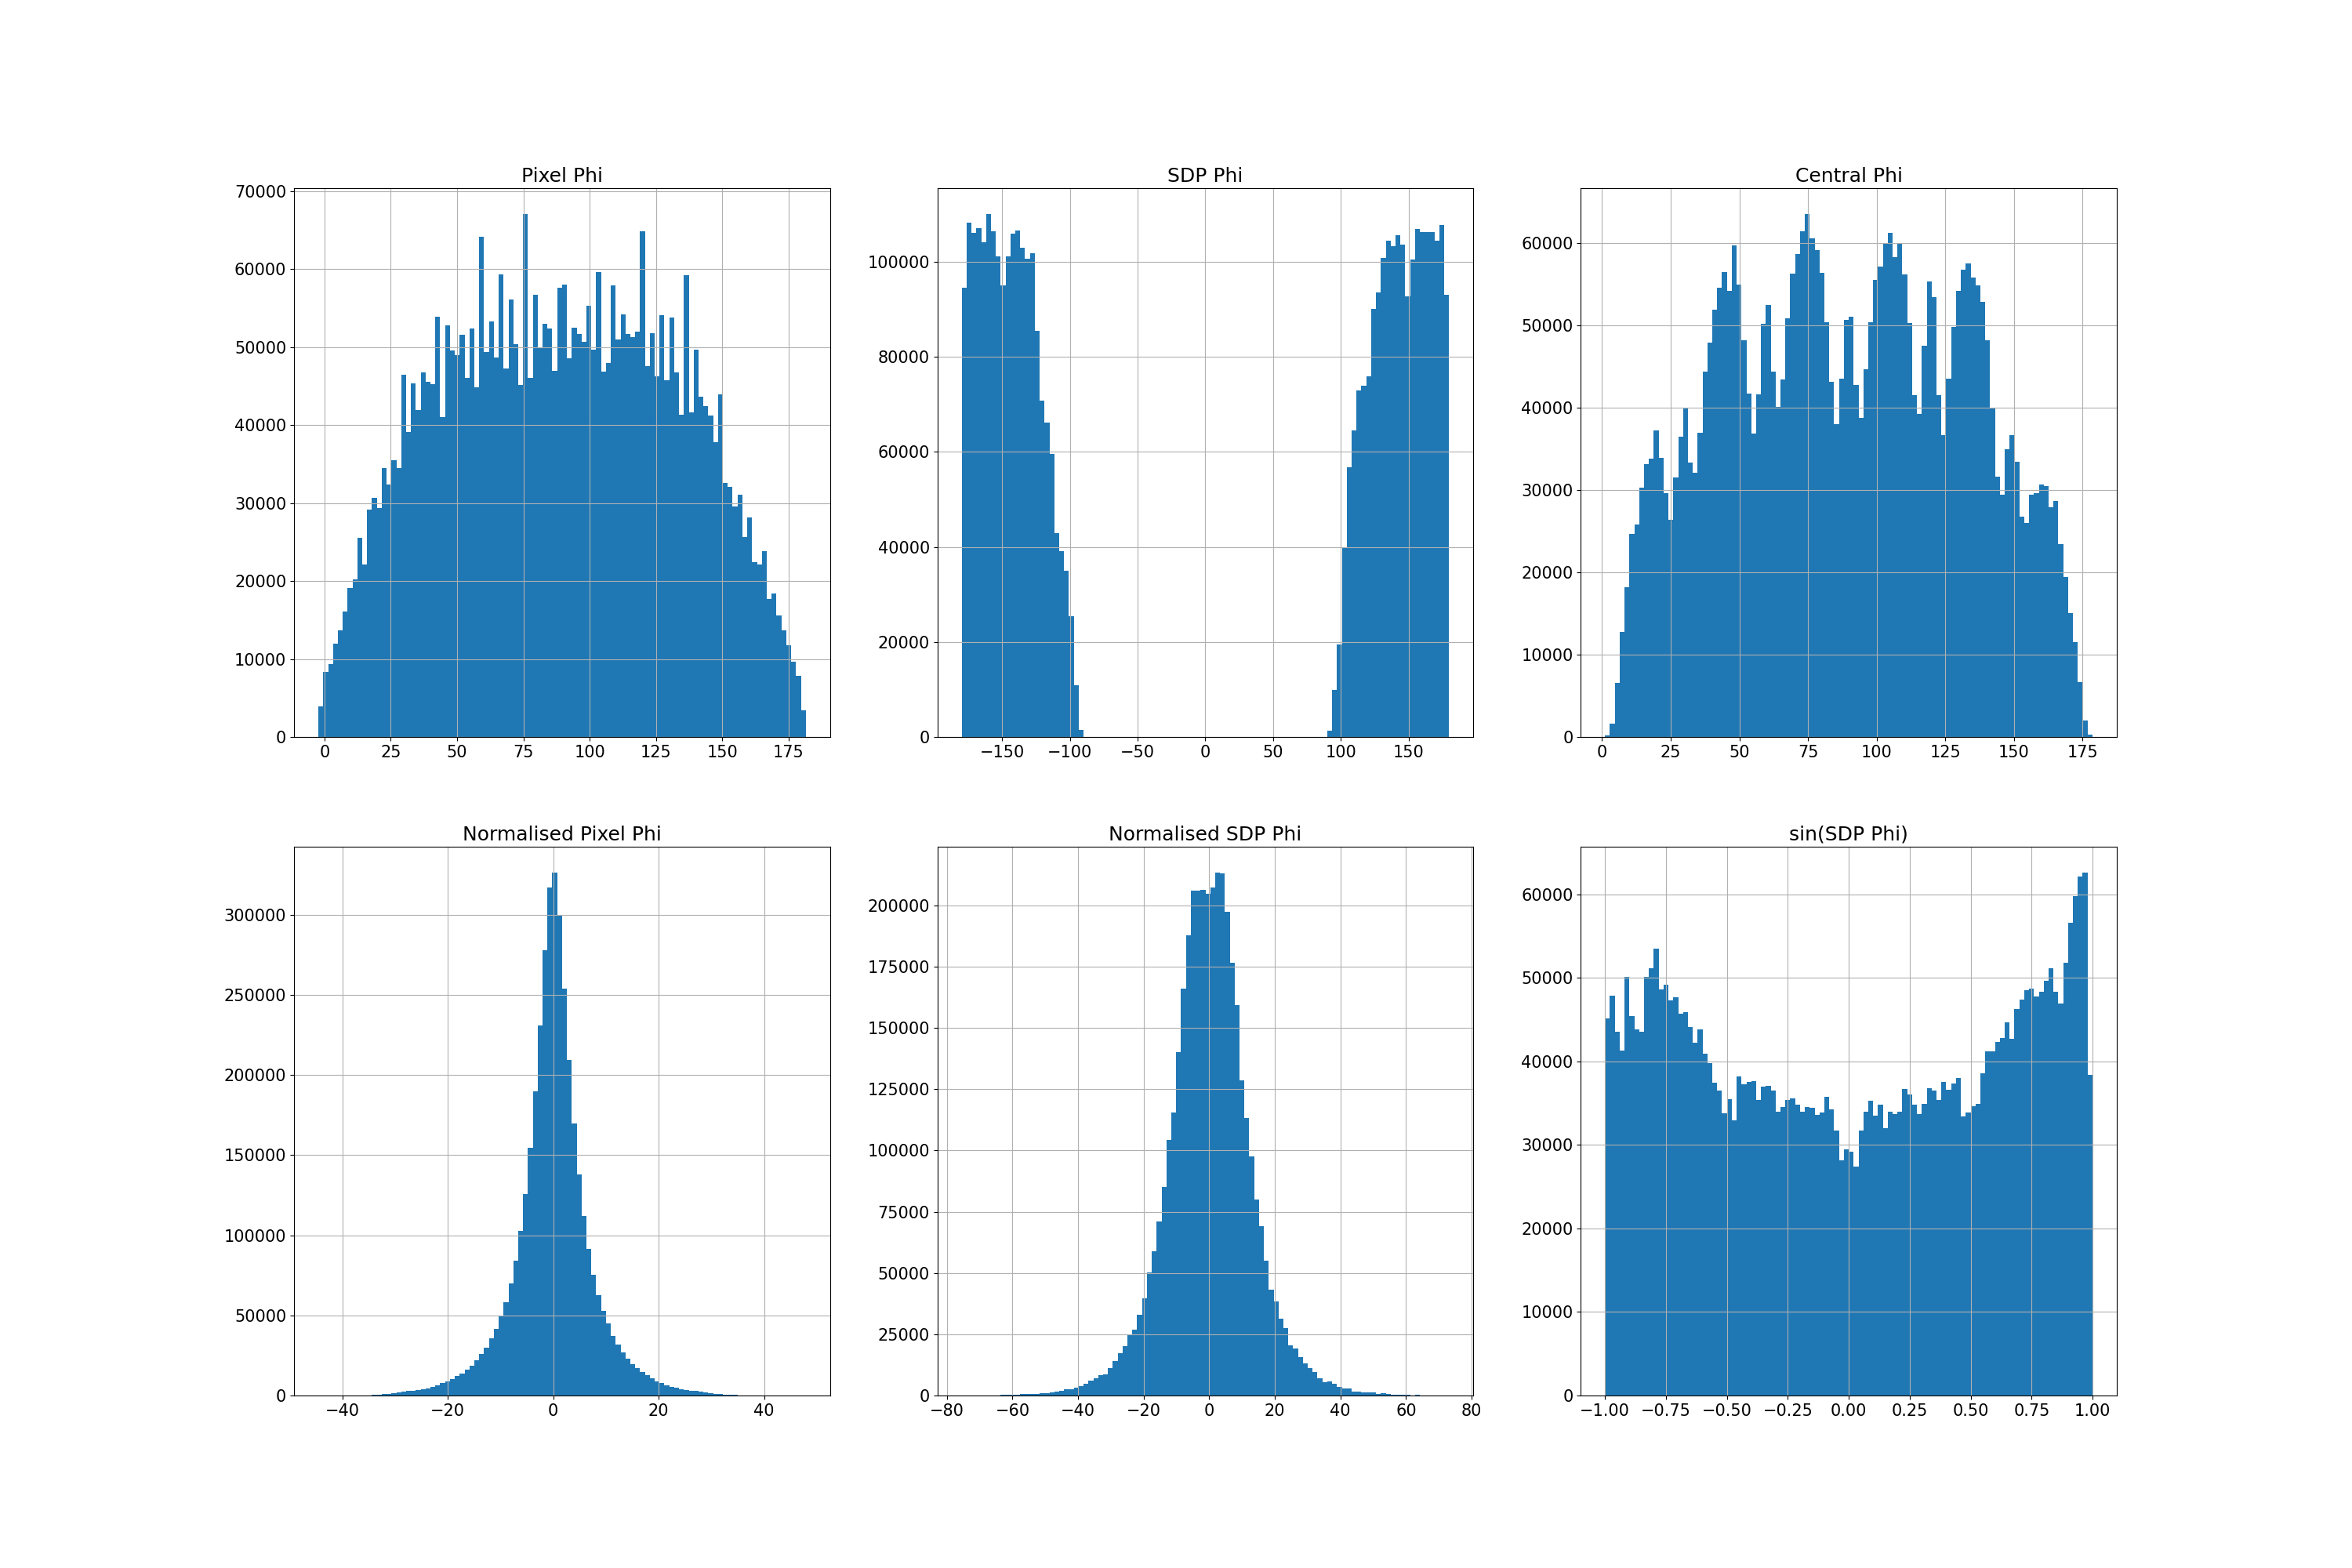

In [ ]:

fig, ax = plt.subplots(2,3,figsize=[30,20])

ax[0,0].hist(ALL_Pix_Phi,bins=100)
ax[0,0].set_title('Pixel Phi')
ax[0,0].grid()

norm_Pix_Phi = (ALL_Pix_Phi-ALL_Central_Phi)/40

ax[1,0].hist(norm_Pix_Phi,bins=100)
ax[1,0].set_title('Normalised Pixel Phi')
ax[1,0].grid()

norm_SDP_Phi = ALL_SDP_Phi*1
norm_SDP_Phi[norm_SDP_Phi<0] += 360
norm_SDP_Phi -= 90
norm_SDP_Phi -= ALL_Central_Phi

ax[1,1].hist(norm_SDP_Phi,bins=100)
ax[1,1].set_title('Normalised SDP Phi')
ax[1,1].grid()


ax[0,1].hist(ALL_SDP_Phi,bins=100)
ax[0,1].set_title('SDP Phi')
ax[0,1].grid()



ax[0,2].hist(ALL_Central_Phi,bins=100)
ax[0,2].set_title('Central Phi')
ax[0,2].grid()

sin_SDP_Phi = np.sin(ALL_SDP_Phi/180*np.pi)

ax[1,2].hist(sin_SDP_Phi,bins=100)
ax[1,2].set_title('sin(SDP Phi)')
ax[1,2].grid()

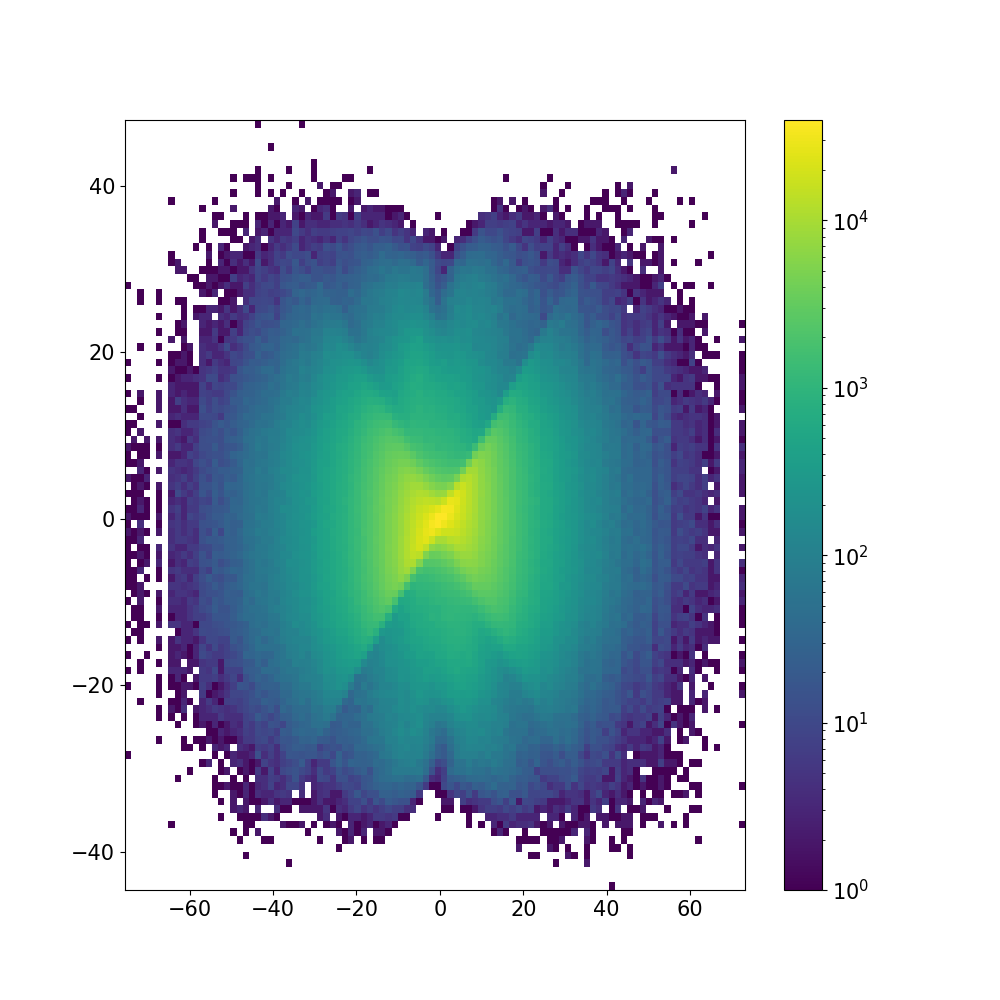

In [ ]:
X = ALL_SDP_Phi*1
X[X<0] += 360
X -= 90
X -= ALL_Central_Phi

Y = ALL_Pix_Phi - ALL_Central_Phi


plt.figure(figsize=[10,10])
plt.hist2d(X,Y,bins=100,norm=mcolors.LogNorm())
# plt.scatter(X,Y)
plt.colorbar()
# Set colorbar scale to log

plt.show()

In [ ]:
X = ALL_Pix_Phi*40+ALL_Central_Phi

plt.figure(figsize=[10,10])
plt.hist(X,bins=100)


In [ ]:
All_Theta    = []
All_Phi      = []
All_Centroid = []
All_Charge   = []
All_Width    = []
All_Status   = []

for graph in Graphs:
    All_Theta   .append(graph[0][:,0])
    All_Phi     .append(graph[0][:,1])
    All_Centroid.append(graph[0][:,2])
    All_Charge  .append(graph[0][:,3])


In [ ]:
All_Width   .append(graph[0][:,4])
# All_Status  .append(graph[0][:,5])

All_Theta    = torch.cat(All_Theta   ).numpy()
All_Phi      = torch.cat(All_Phi     ).numpy()
All_Centroid = torch.cat(All_Centroid).numpy()
All_Charge   = torch.cat(All_Charge  ).numpy()
All_Width    = torch.cat(All_Width   ).numpy()
# All_Status   = torch.cat(All_Status  ).numpy()

# All_Theta    = All_Theta   [All_Status==4]
# All_Phi      = All_Phi     [All_Status==4]
# All_Centroid = All_Centroid[All_Status==4]
# All_Charge   = All_Charge  [All_Status==4]
# All_Width    = All_Width   [All_Status==4]
# All_Status   = All_Status  [All_Status==4]

In [ ]:
# Theta Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_Theta,bins=100)
ax[0].set_title('Theta')

normTheta = (90-All_Theta)/30
ax[1].hist(normTheta,bins=100)
ax[1].set_title('Normalized Theta')


Text(0.5, 1.0, 'Normalized Phi')

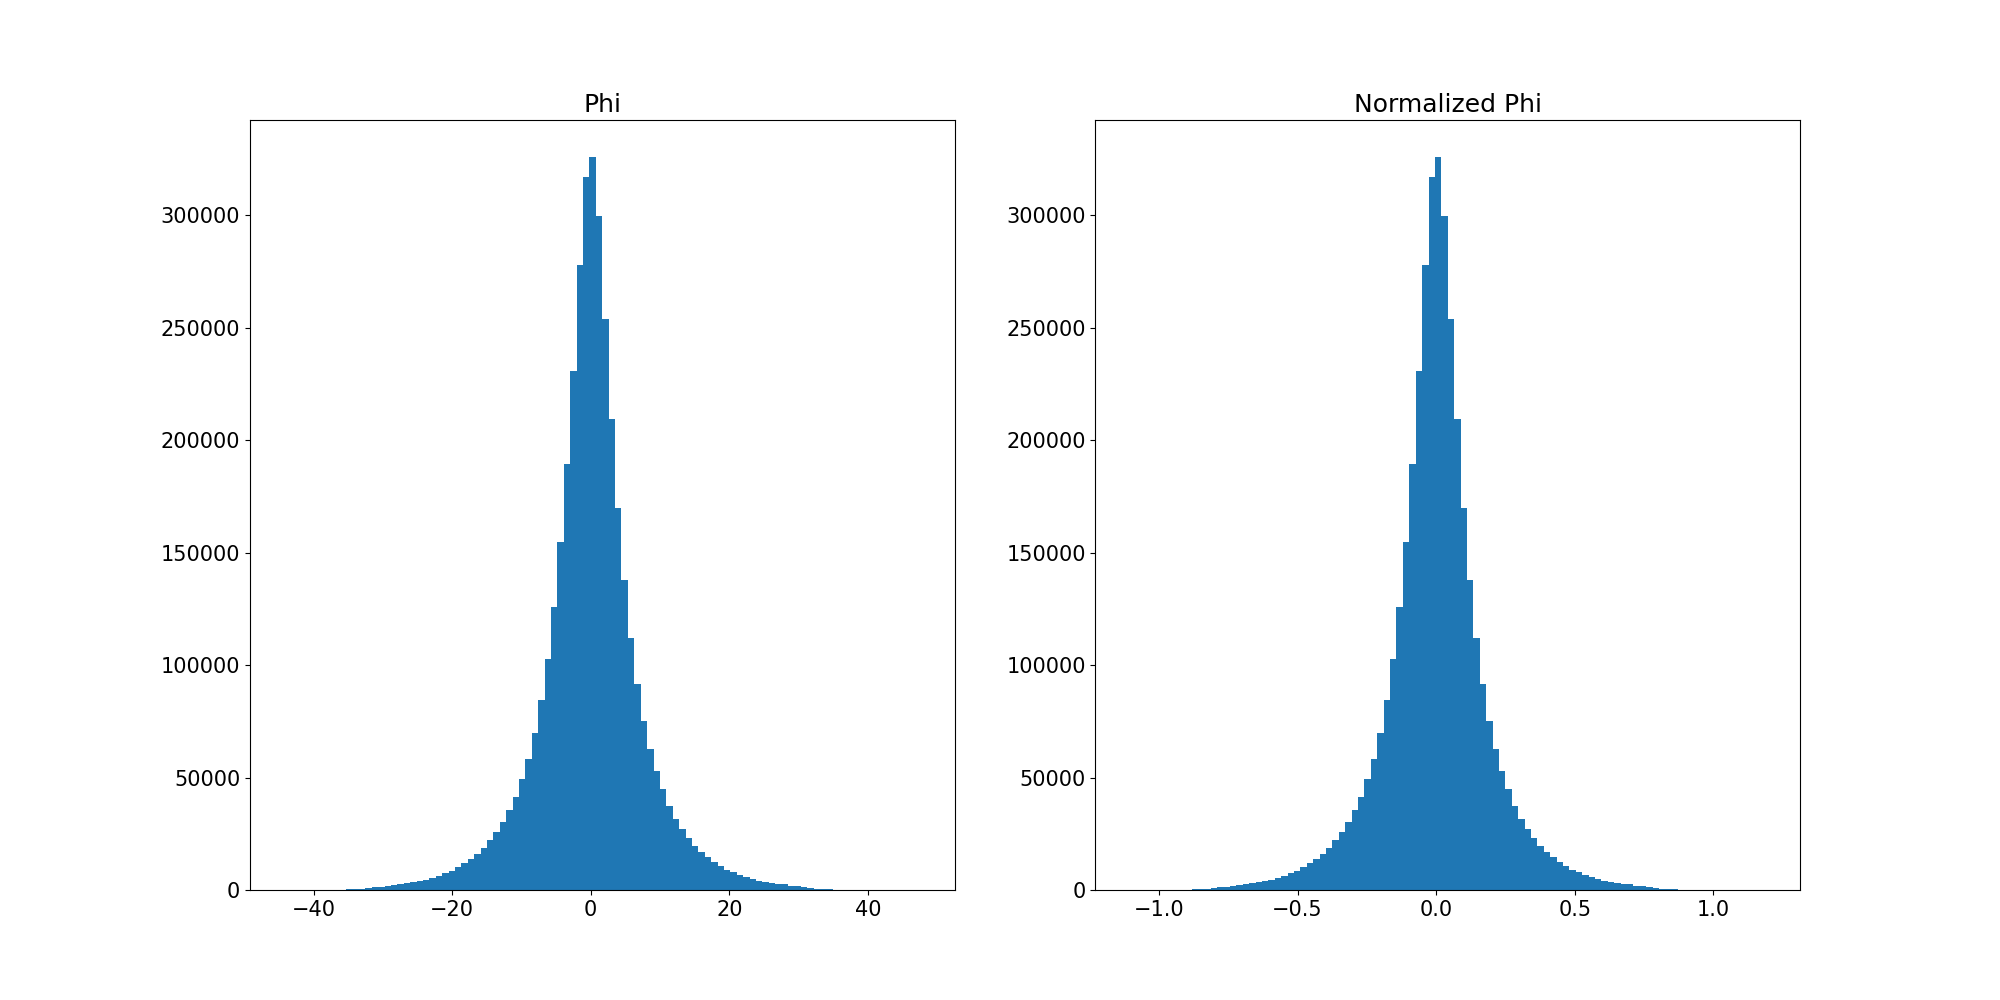

In [ ]:
# Phi Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_Phi,bins=100)
ax[0].set_title('Phi')
# ax[0].set_yscale('log')

normPhi = All_Phi/40
ax[1].hist(normPhi,bins=100)
ax[1].set_title('Normalized Phi')


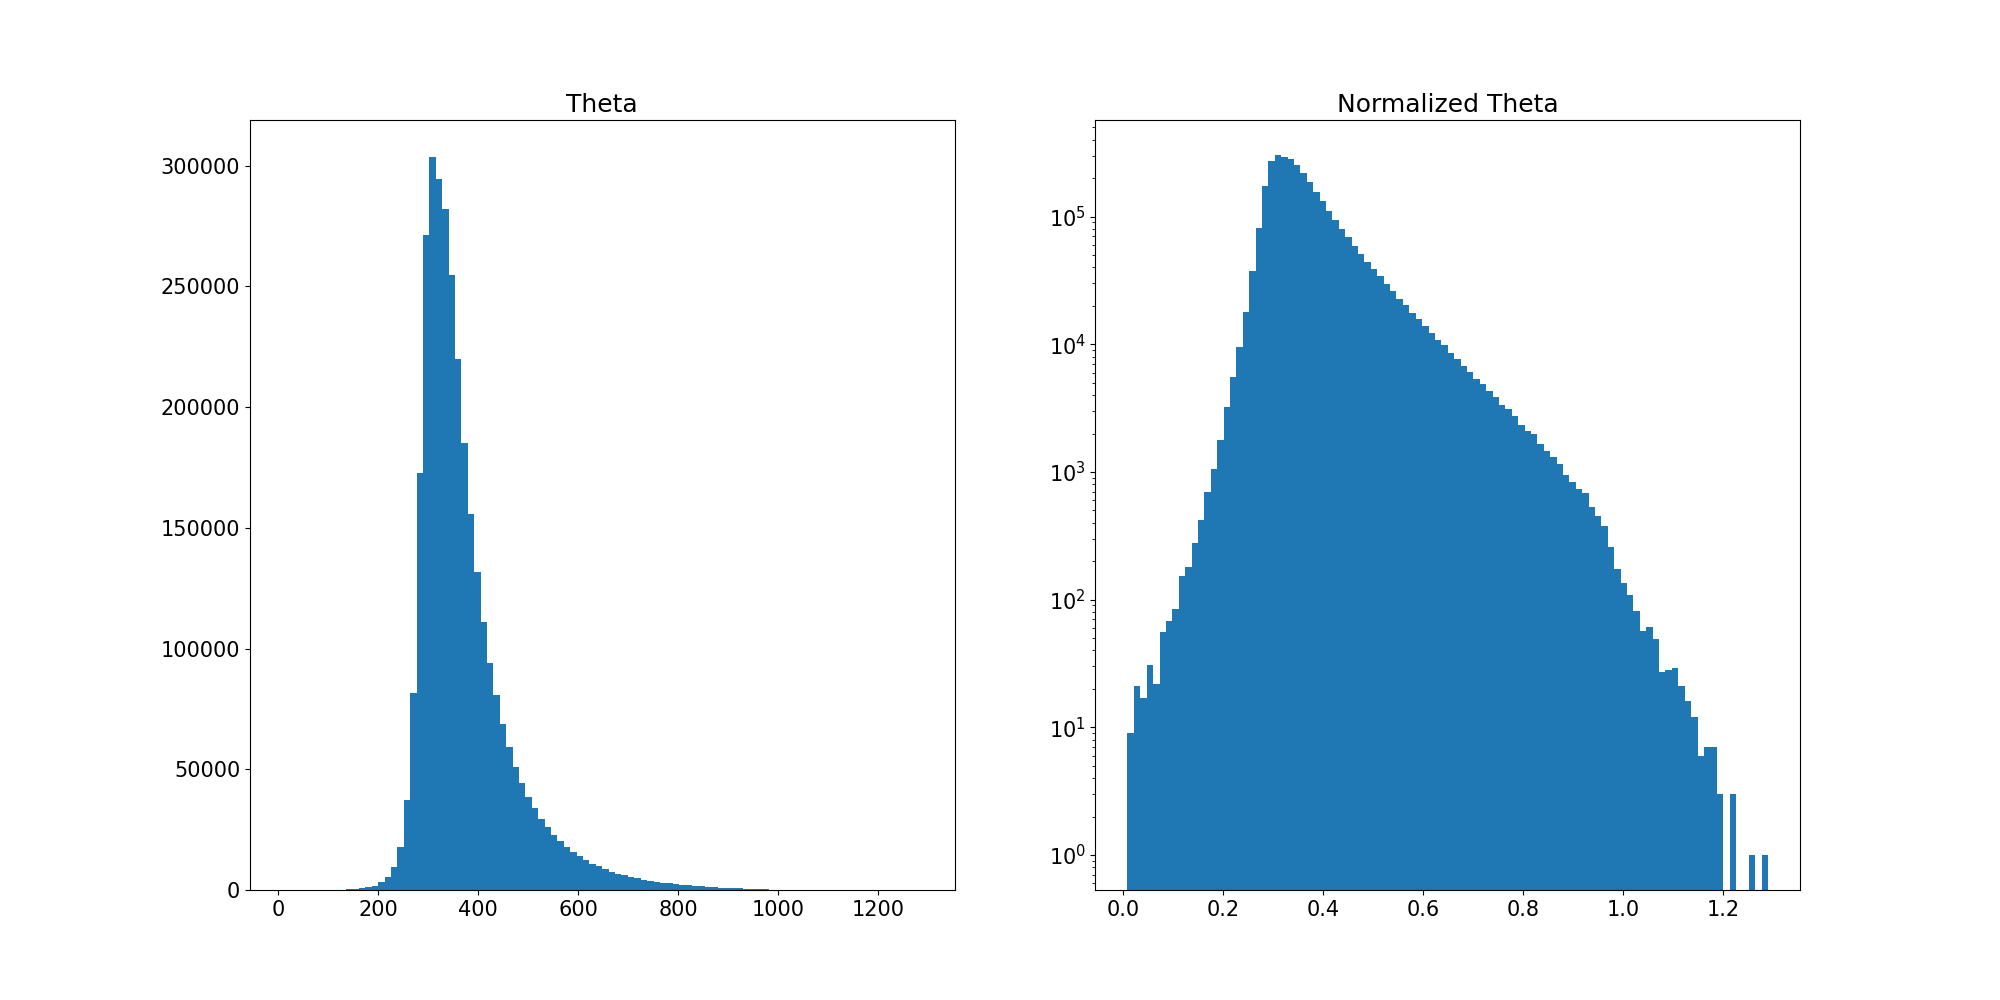

In [ ]:
# Centroid Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_Centroid,bins=100)
ax[0].set_title('Theta')

normCentroid = All_Centroid/1000
ax[1].hist(normCentroid,bins=100)
ax[1].set_title('Normalized Theta')
ax[1].set_yscale('log')

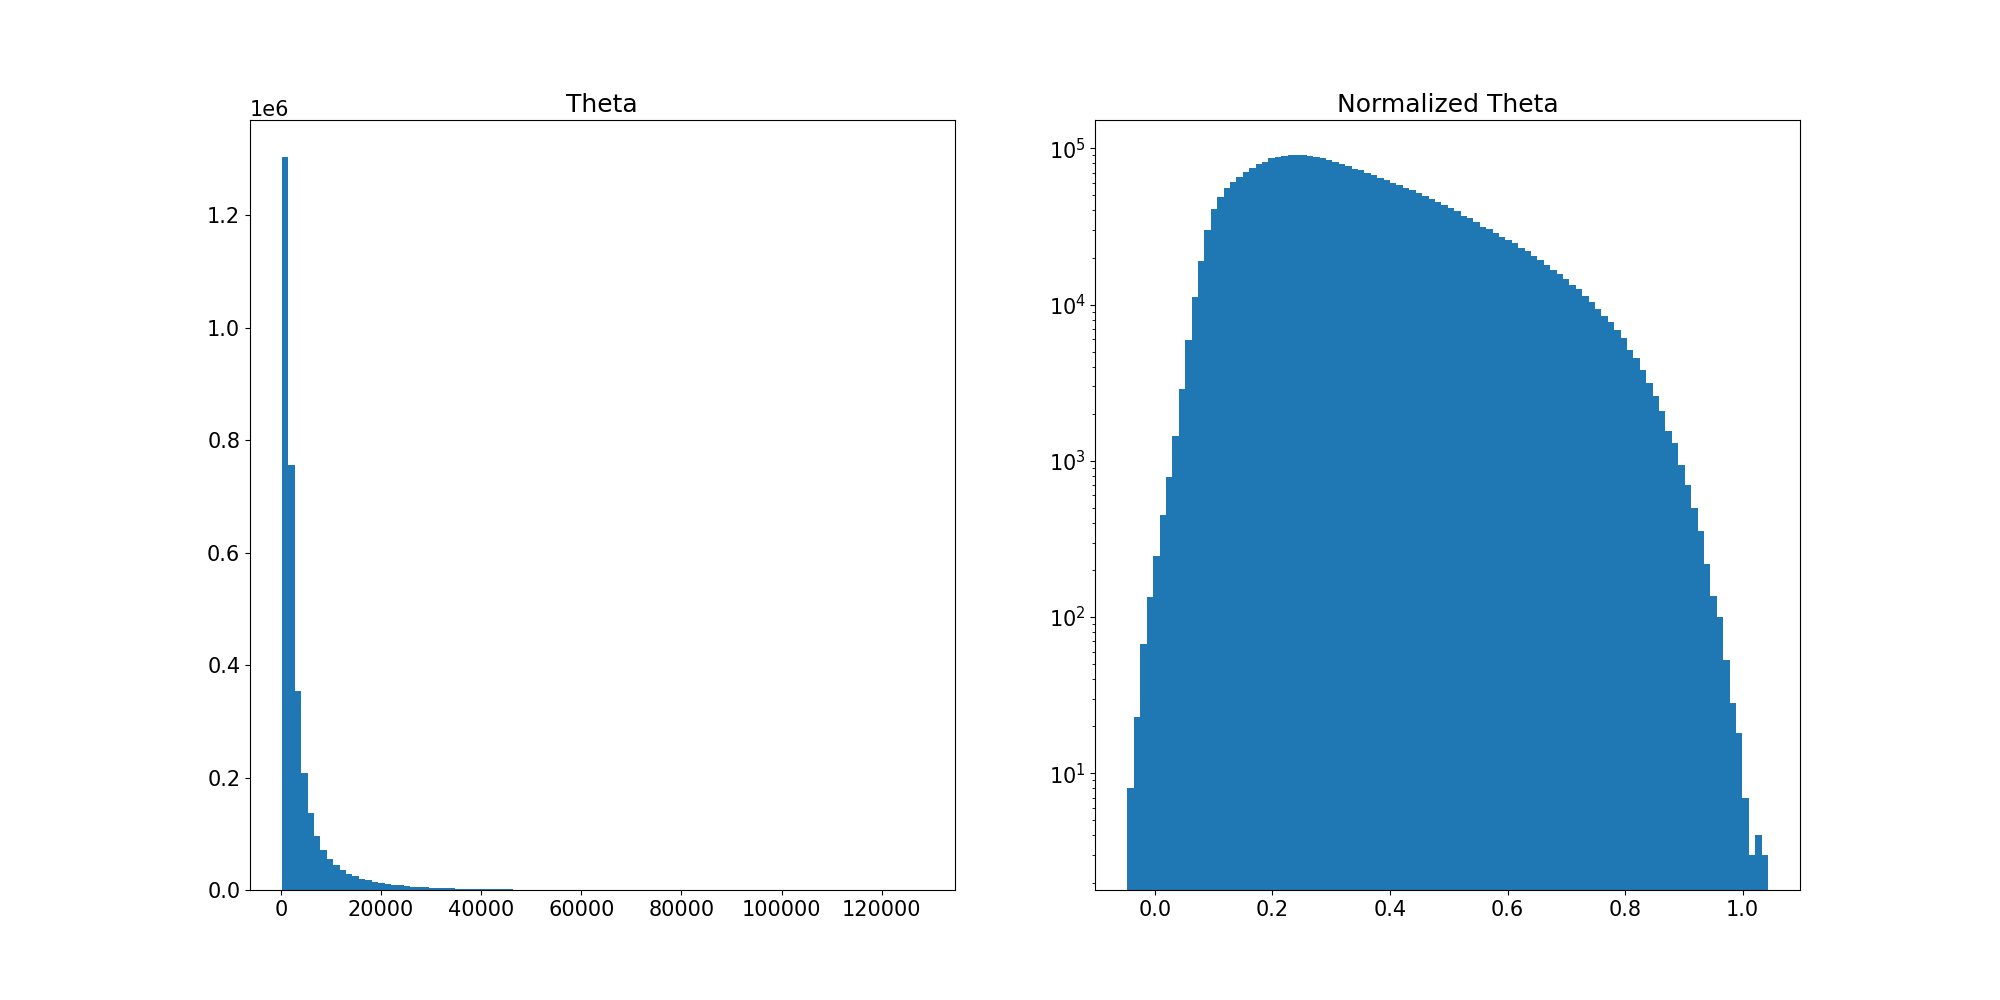

In [ ]:
# Charge Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_Charge,bins=100)
ax[0].set_title('Theta')

normCharge = np.log10(All_Charge+1)/2.5 - 1
ax[1].hist(normCharge,bins=100)
ax[1].set_title('Normalized Theta')
ax[1].set_yscale('log')

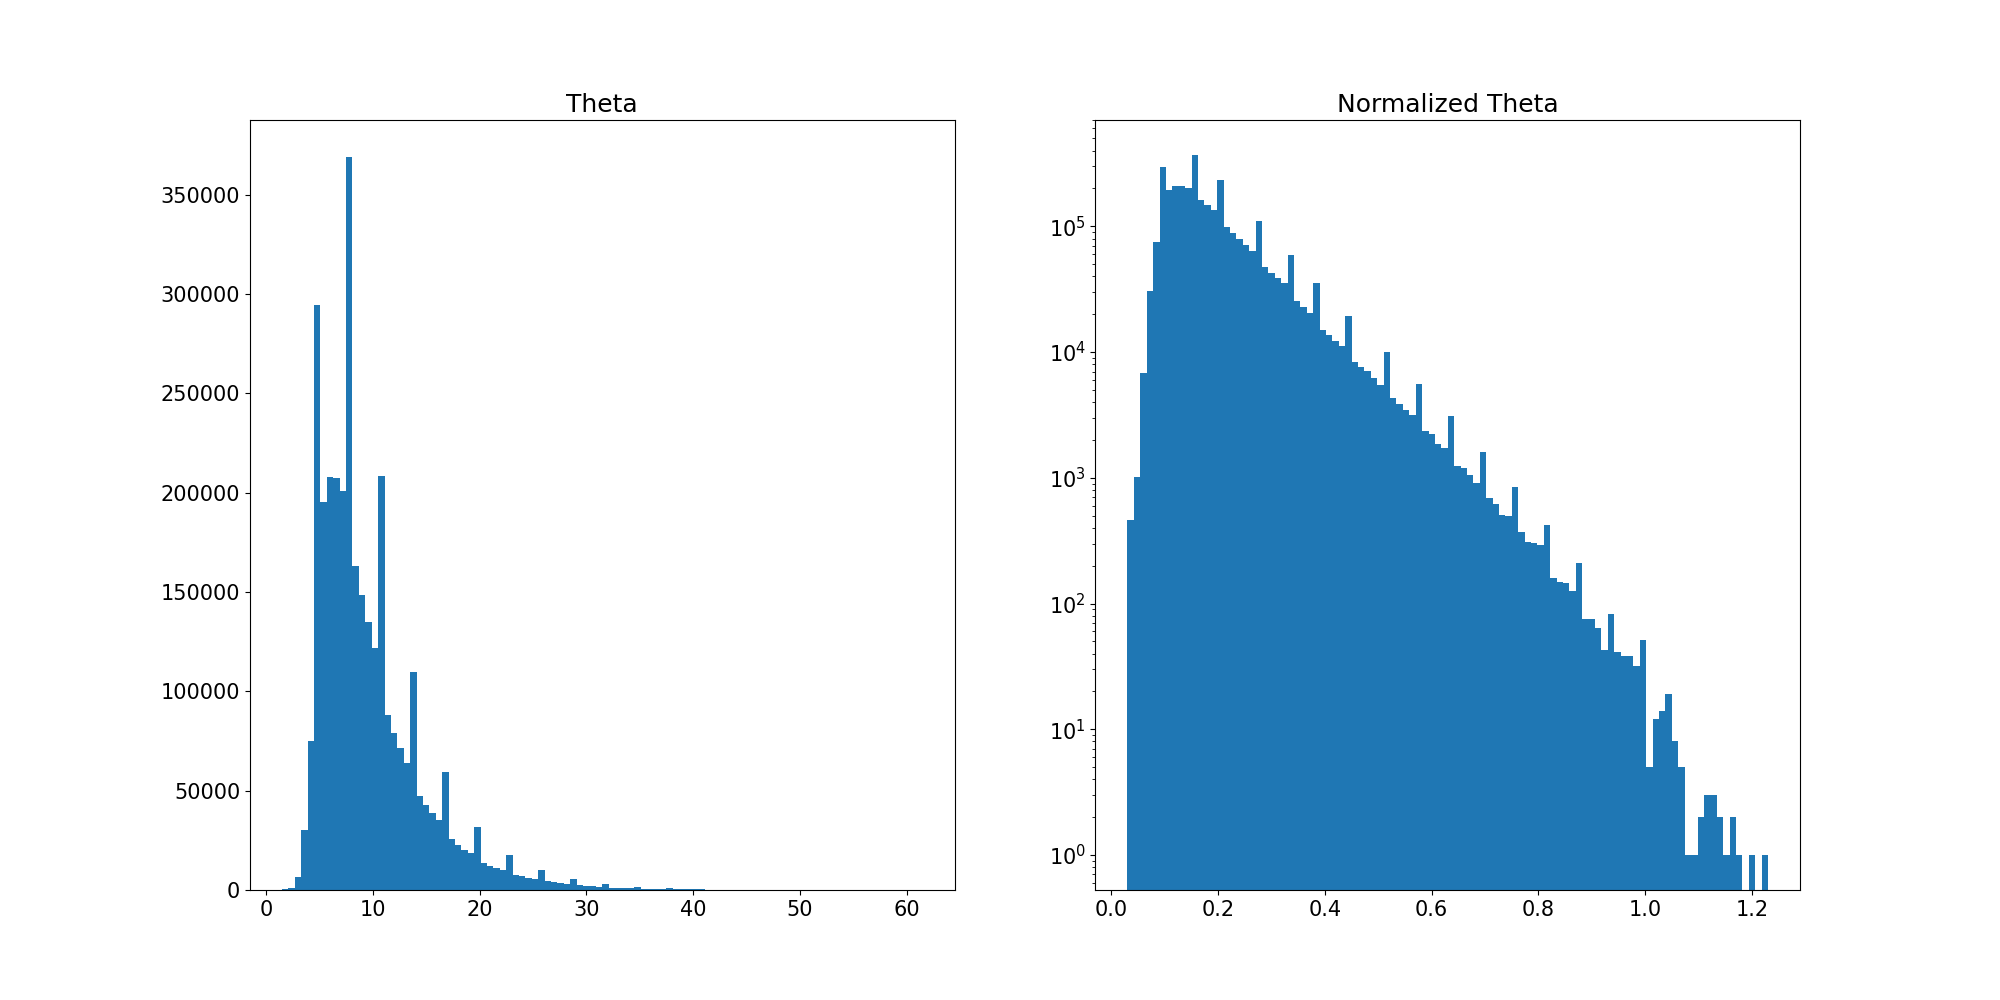

In [ ]:
# Duration Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_Width,bins=100)
ax[0].set_title('Theta')

normWidth = All_Width/50
ax[1].hist(normWidth,bins=100)
ax[1].set_title('Normalized Theta')
plt.yscale('log')

In [ ]:
All_AngDivs = []
All_TimeDivs = []

for graph in Graphs:
    All_AngDivs.append(graph[2][:,0])
    All_TimeDivs.append(graph[2][:,1])

All_AngDivs = torch.cat(All_AngDivs).numpy()
All_TimeDivs = torch.cat(All_TimeDivs).numpy()


/tmp/ipykernel_32198/2687694369.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,2,figsize = [20,10])


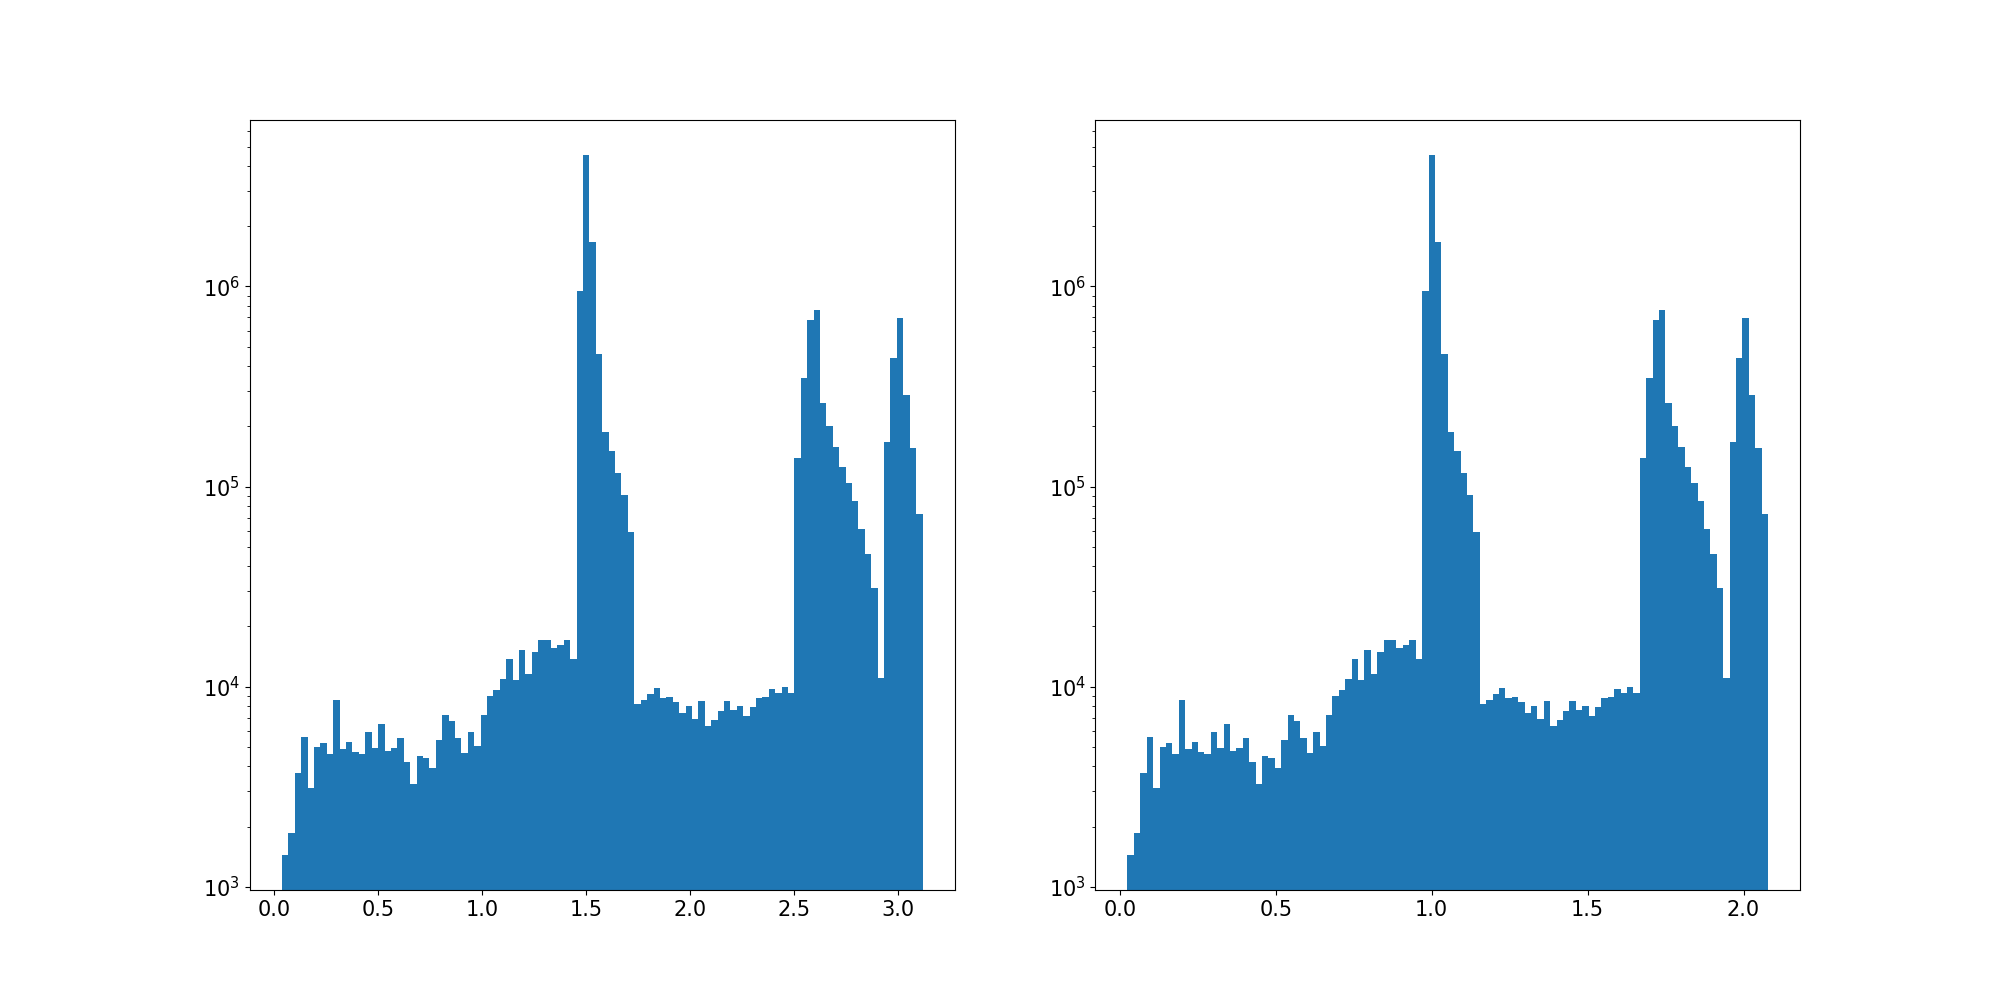

In [ ]:
# Edge AngDiv Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_AngDivs,bins=100)
ax[0].set_yscale('log')

normAngDivs = All_AngDivs/1.5
ax[1].hist(normAngDivs,bins=100)
plt.yscale('log')

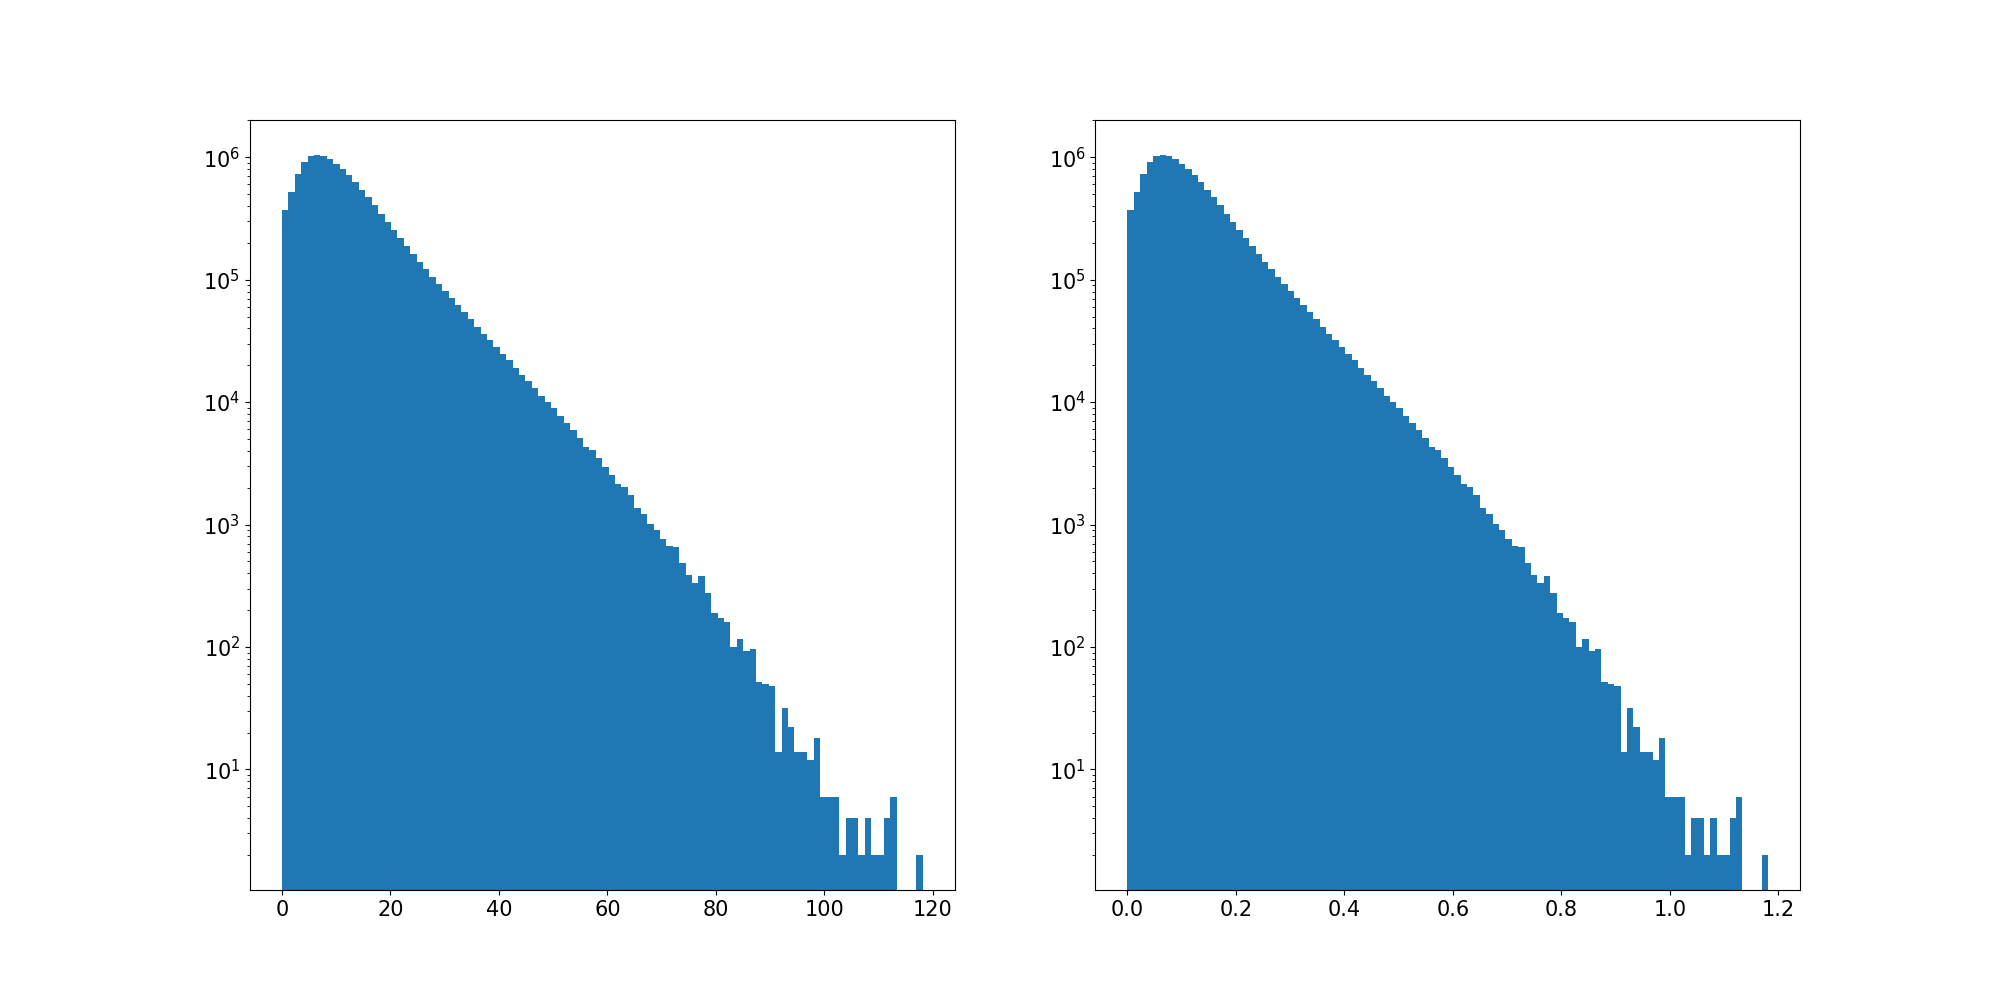

In [ ]:
# Edge Time Div Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_TimeDivs,bins=100)
ax[0].set_yscale('log')

normTimeDivs = All_TimeDivs/100
ax[1].hist(normTimeDivs,bins=100)
plt.yscale('log')

Text(0.5, 1.0, 'Theta')

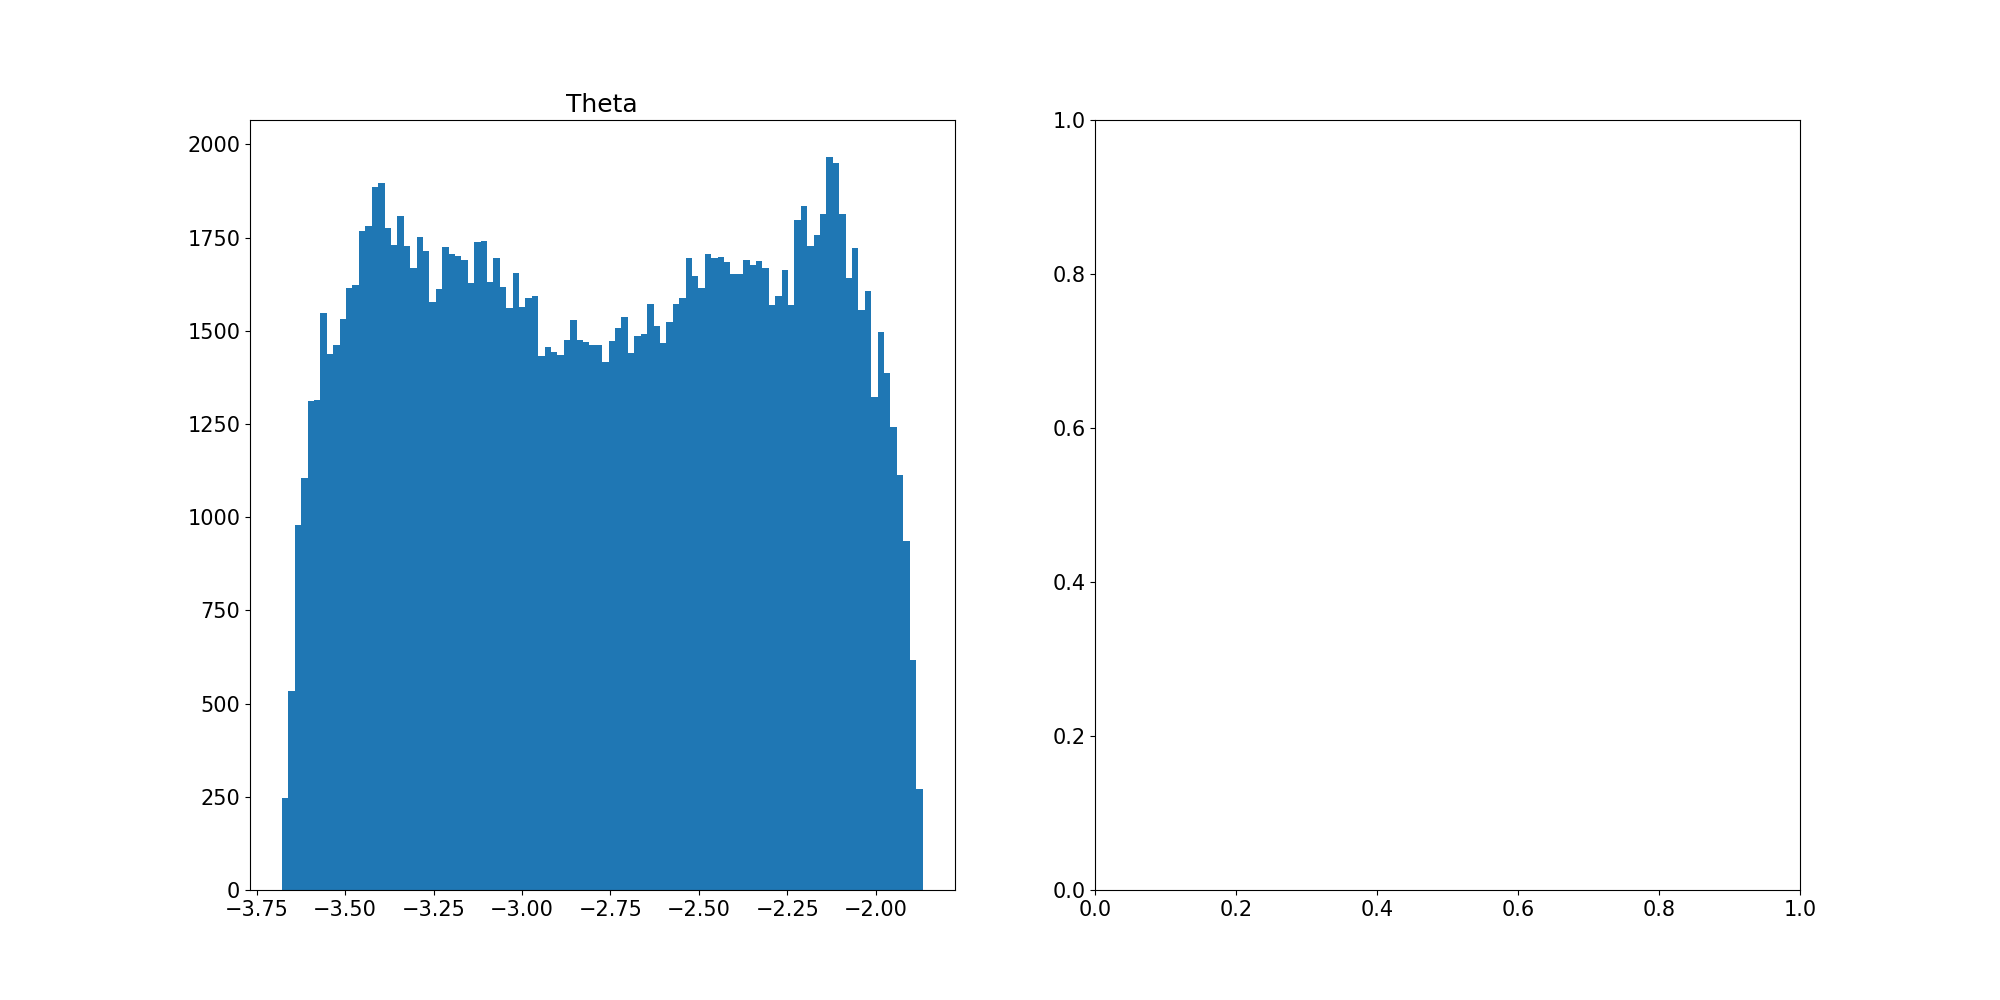

In [ ]:
# Checking SDP_Theta Normalisation
SDP_Theta = Truth[:,0].clone()

# SDP_Theta = torch.acos(SDP_Theta)/torch.pi*180


fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(SDP_Theta,bins=100)
ax[0].set_title('Theta')



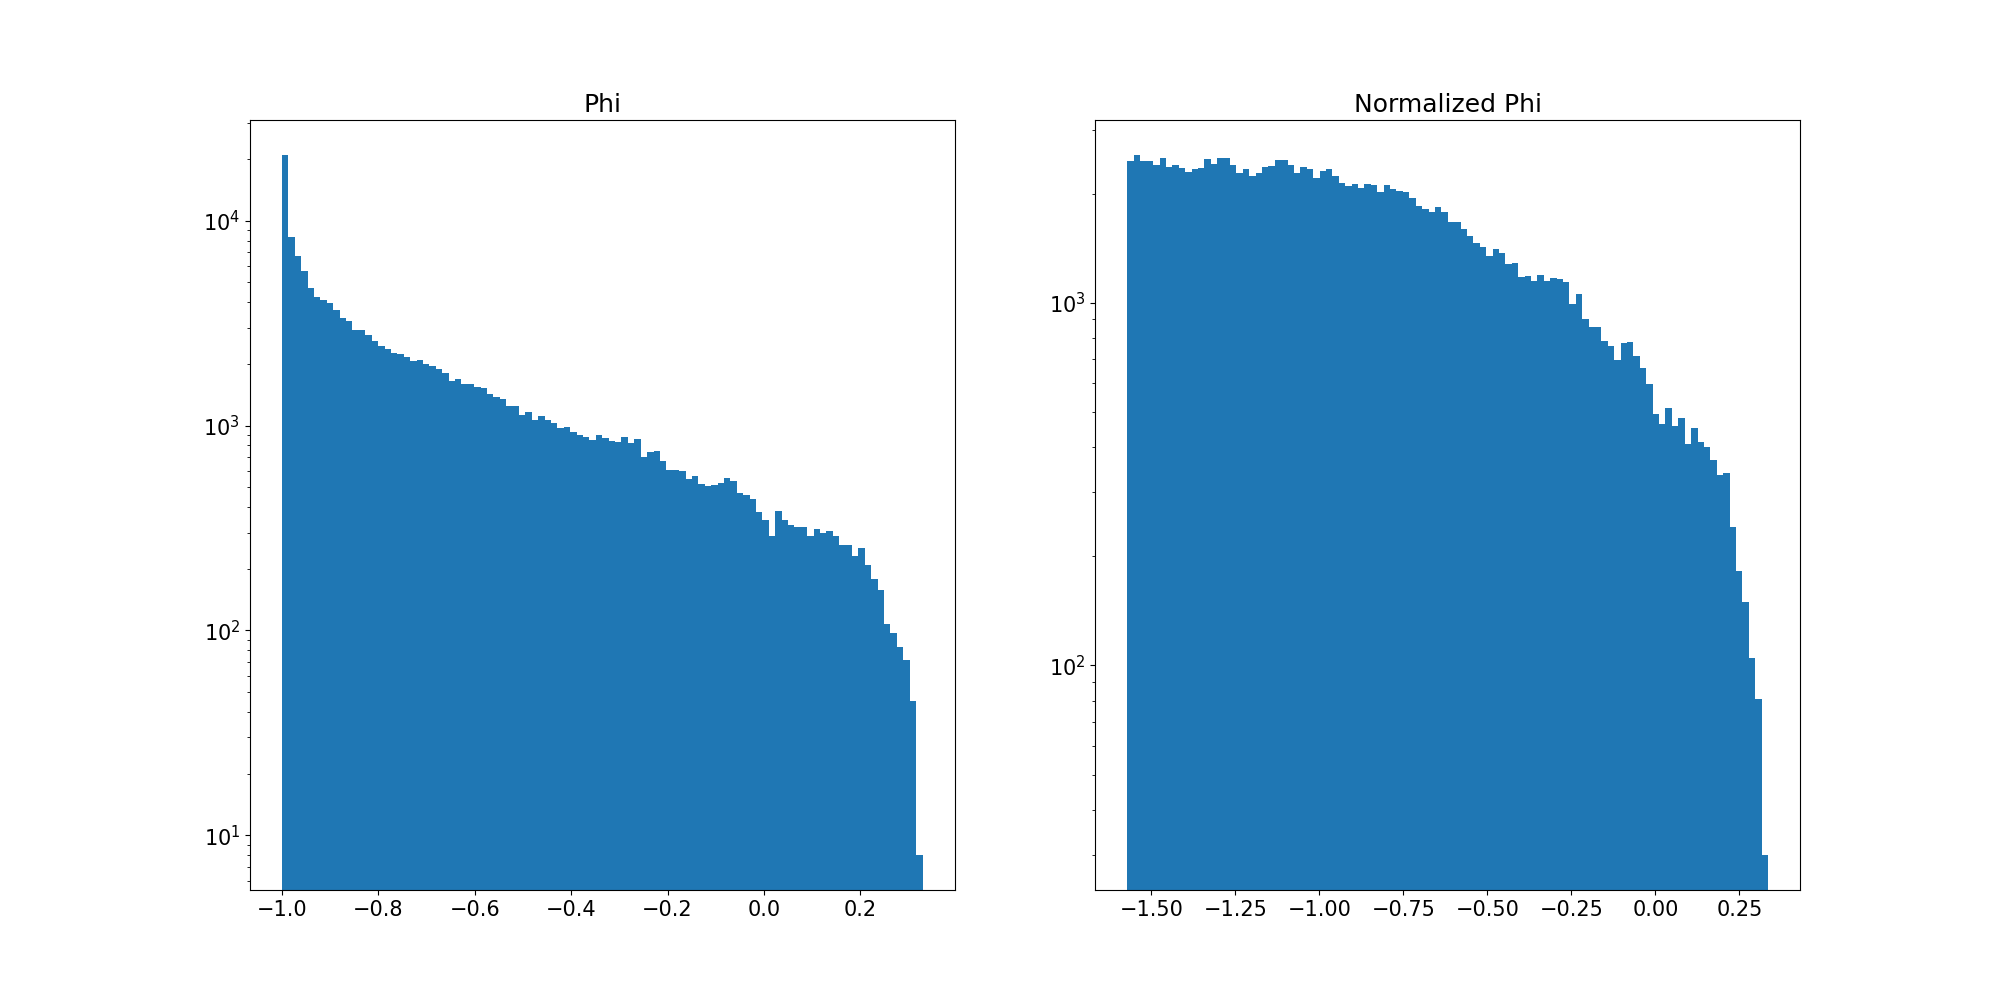

In [ ]:
# Checking SDP_Phi Normalisation
SDP_Phi     = Truth  [:,1].clone()
Central_Phi = AuxData[:,0].clone()
# SDP_Phi[SDP_Phi<0] += 2*torch.pi
# SDP_Phi            -= torch.pi/2
# SDP_Phi            -= Central_Phi/180*torch.pi



fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(SDP_Phi,bins=100)
ax[0].set_title('Phi')
ax[0].set_yscale('log')

norm_Phi = torch.asin(SDP_Phi)
ax[1].hist(norm_Phi,bins=100)
ax[1].set_title('Normalized Phi')
ax[1].set_yscale('log')

### Plotting Graphs - Sanity Checks

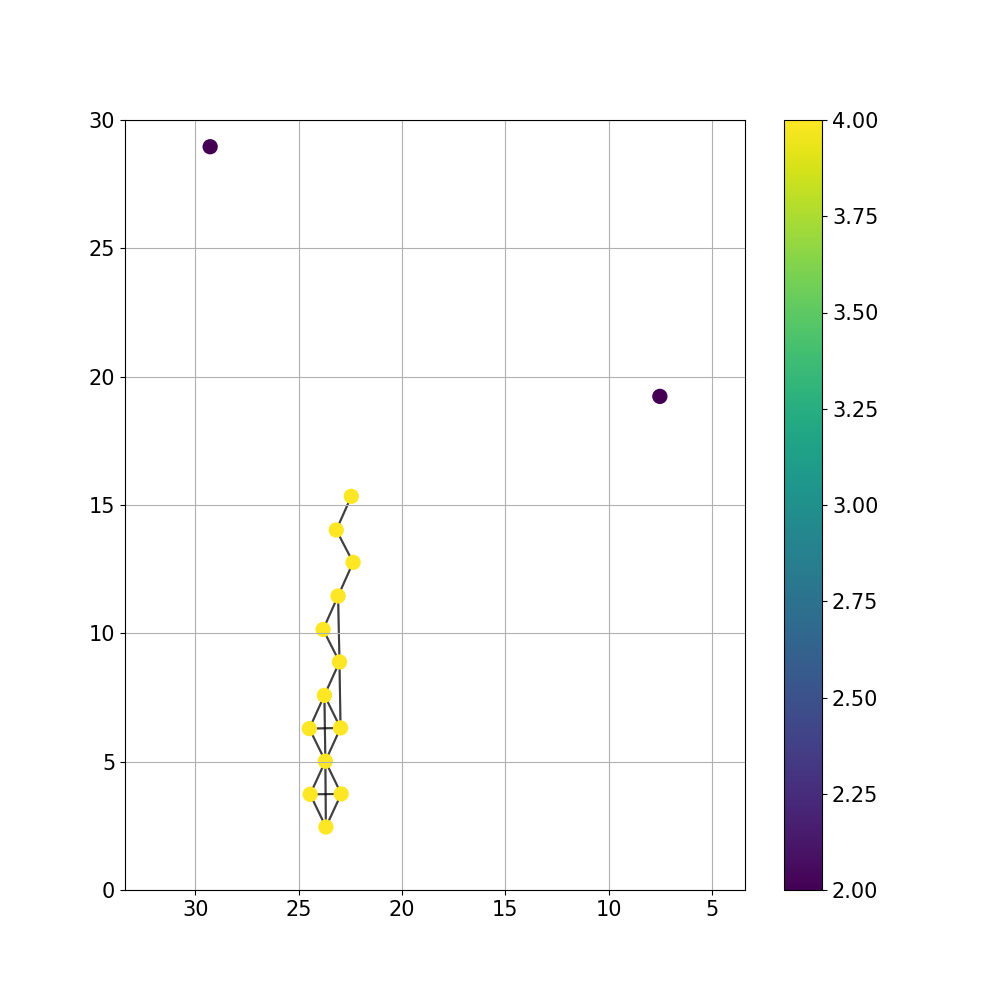

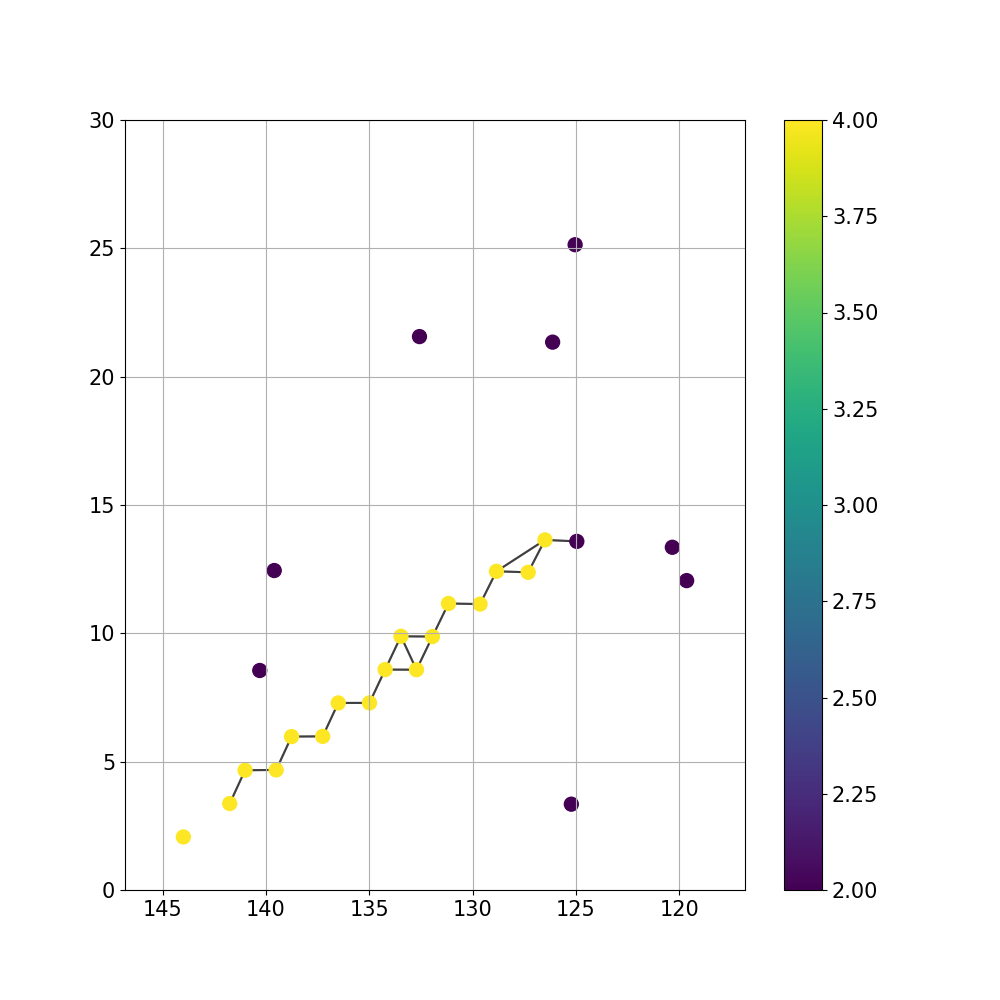

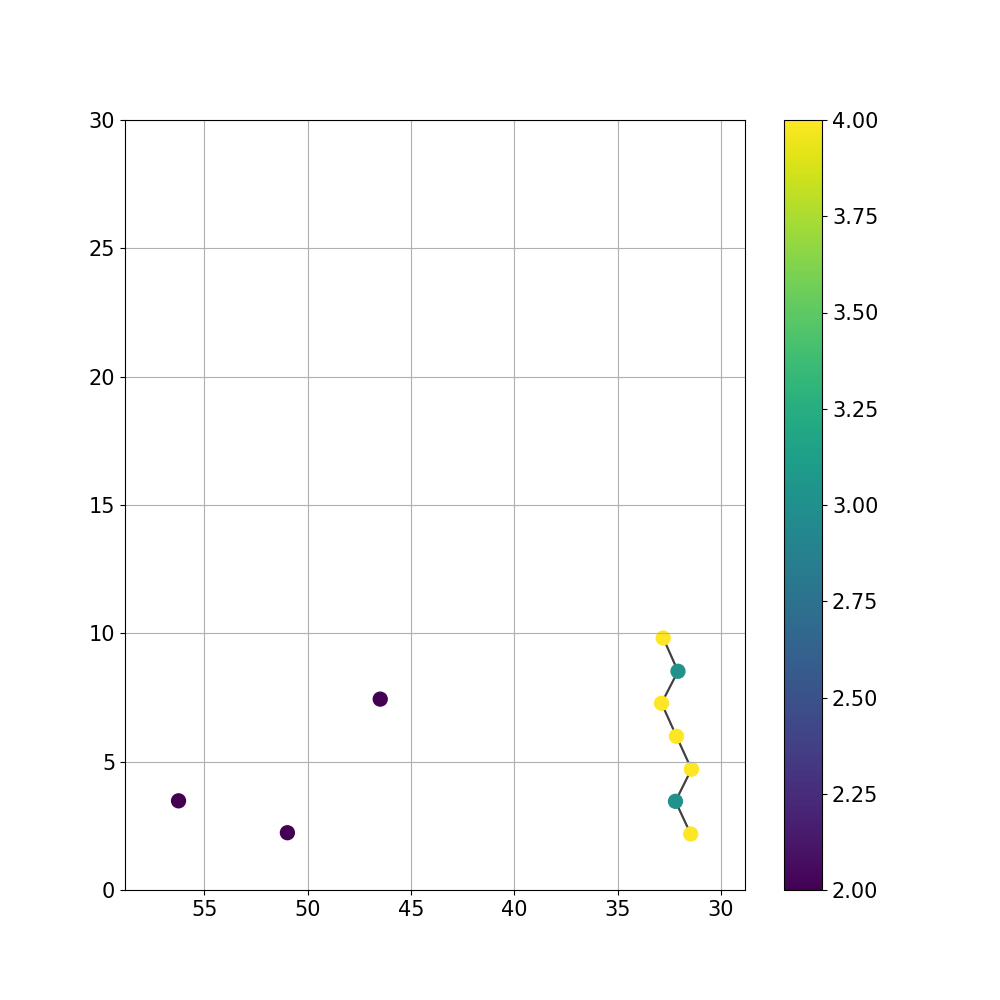

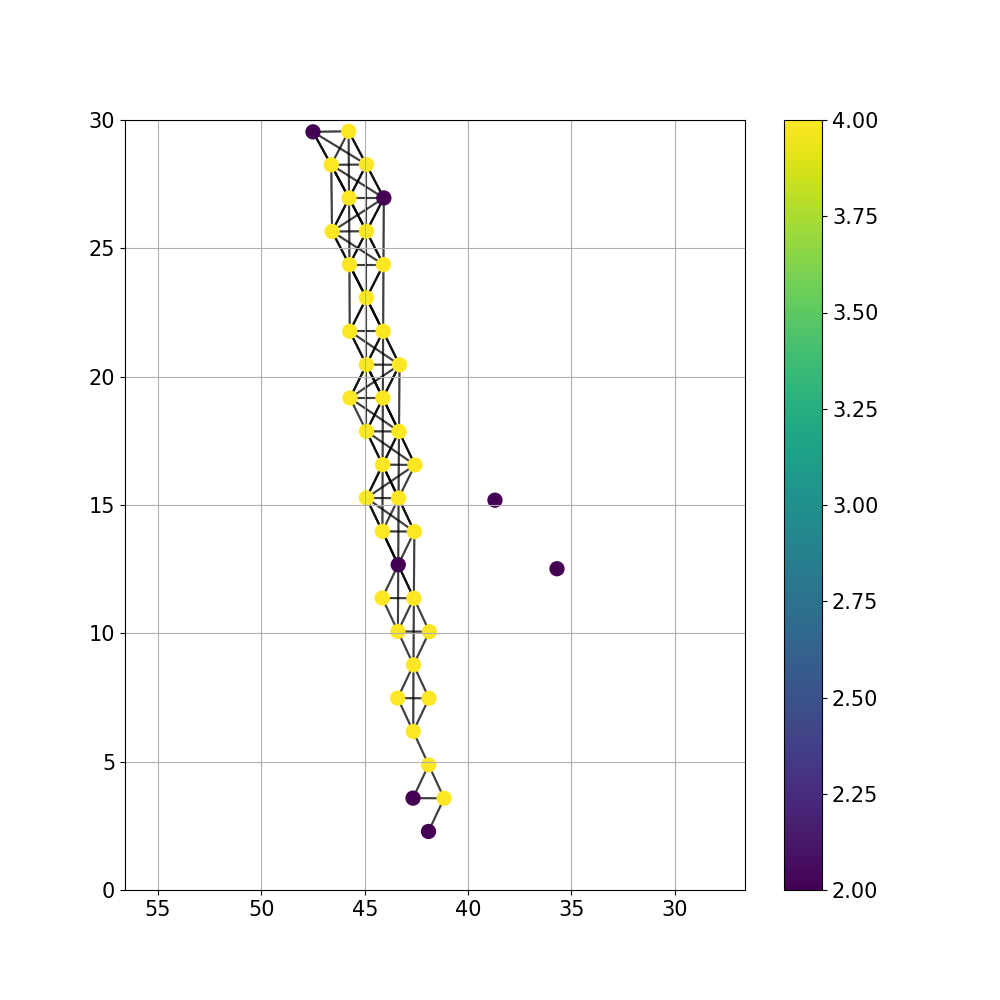

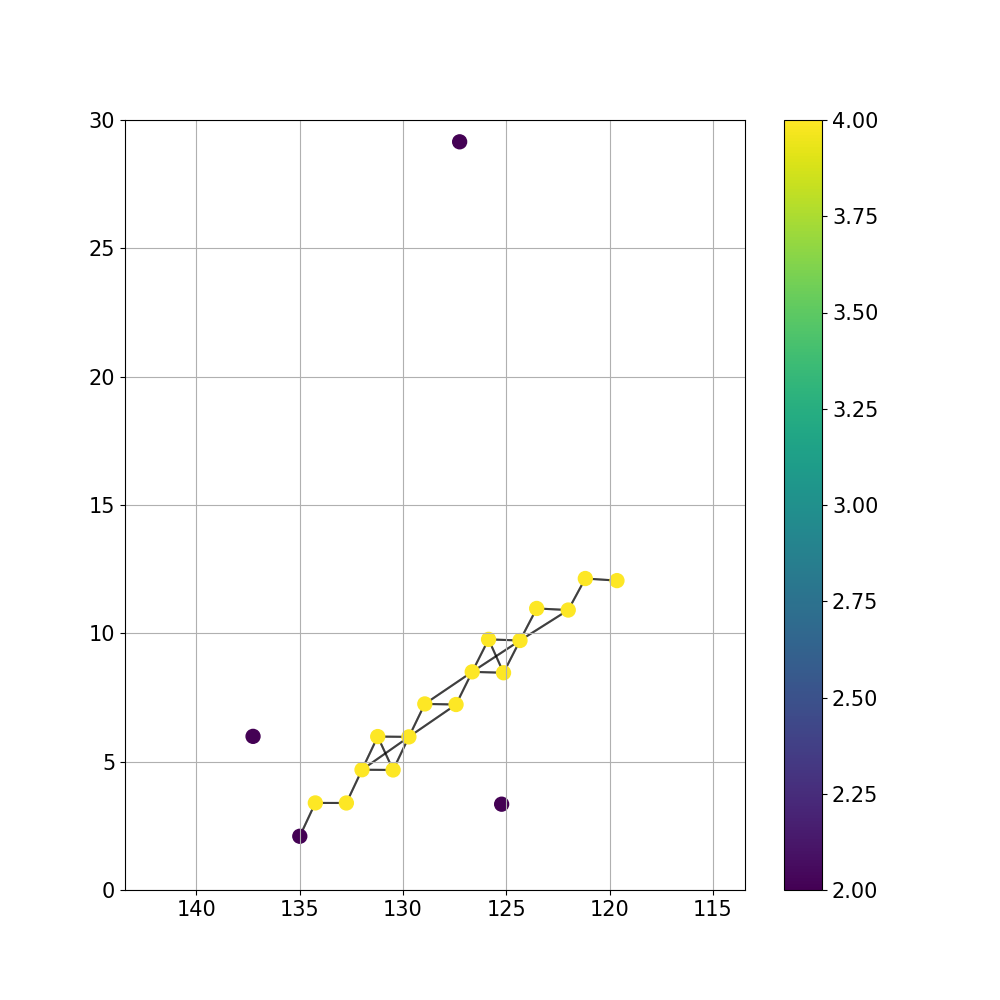

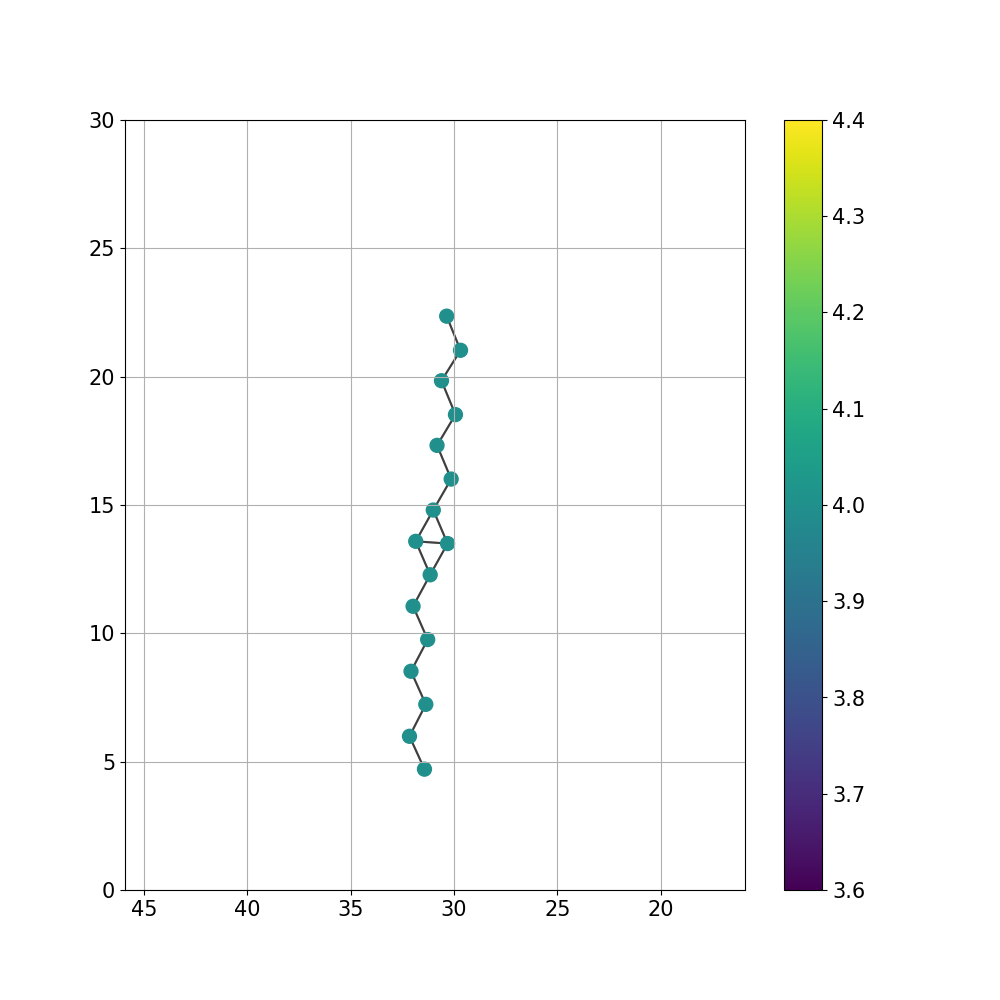

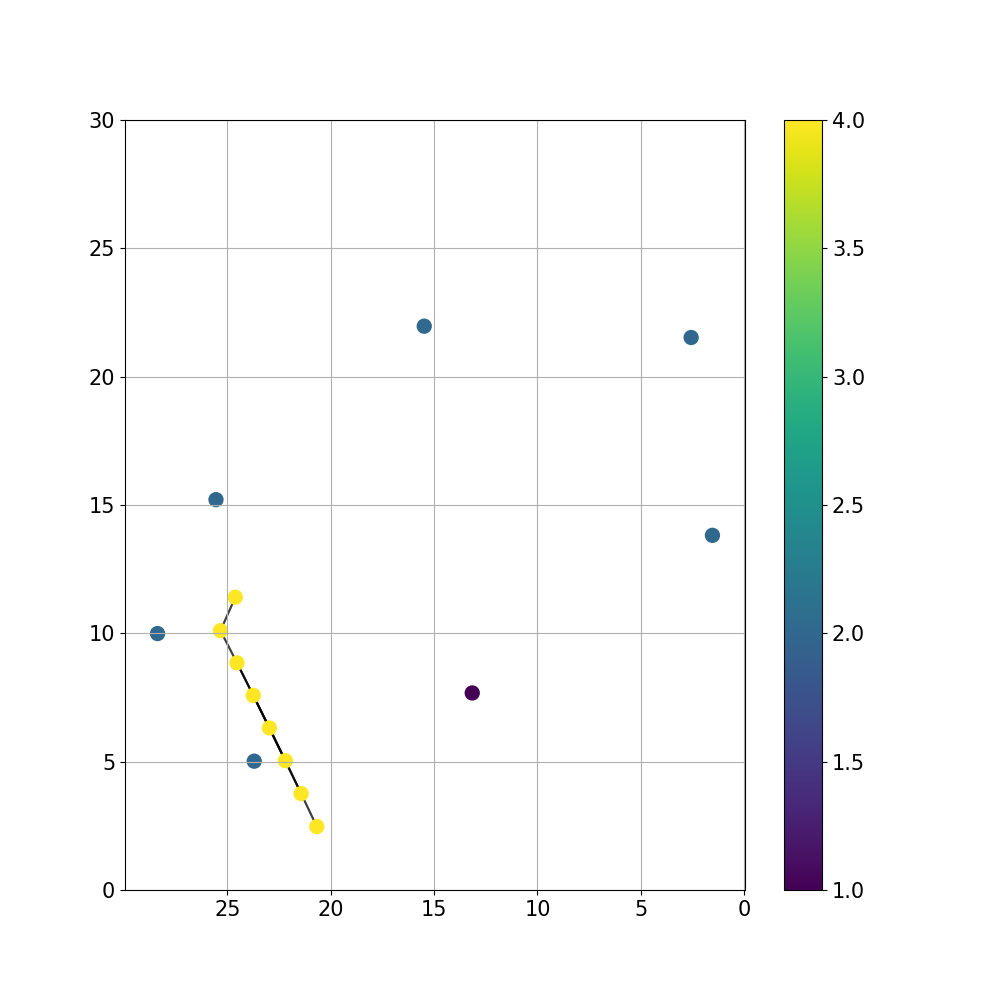

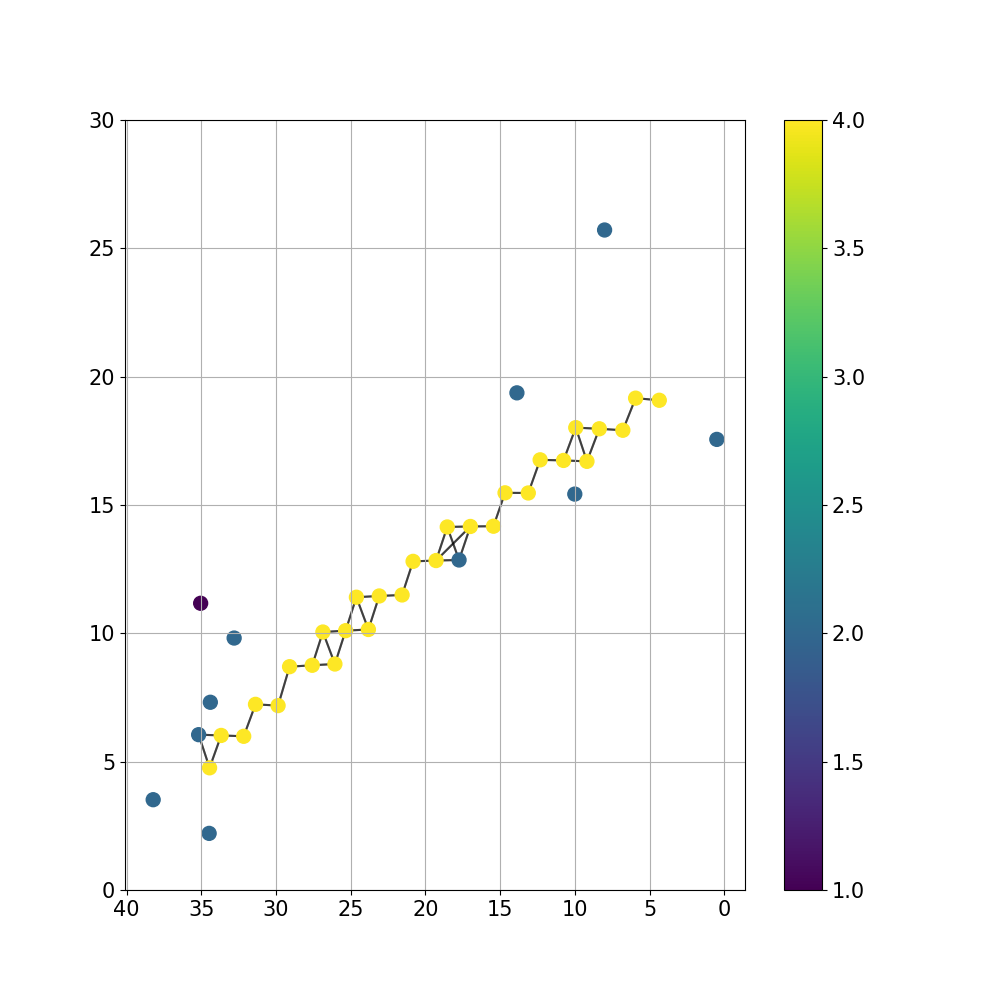

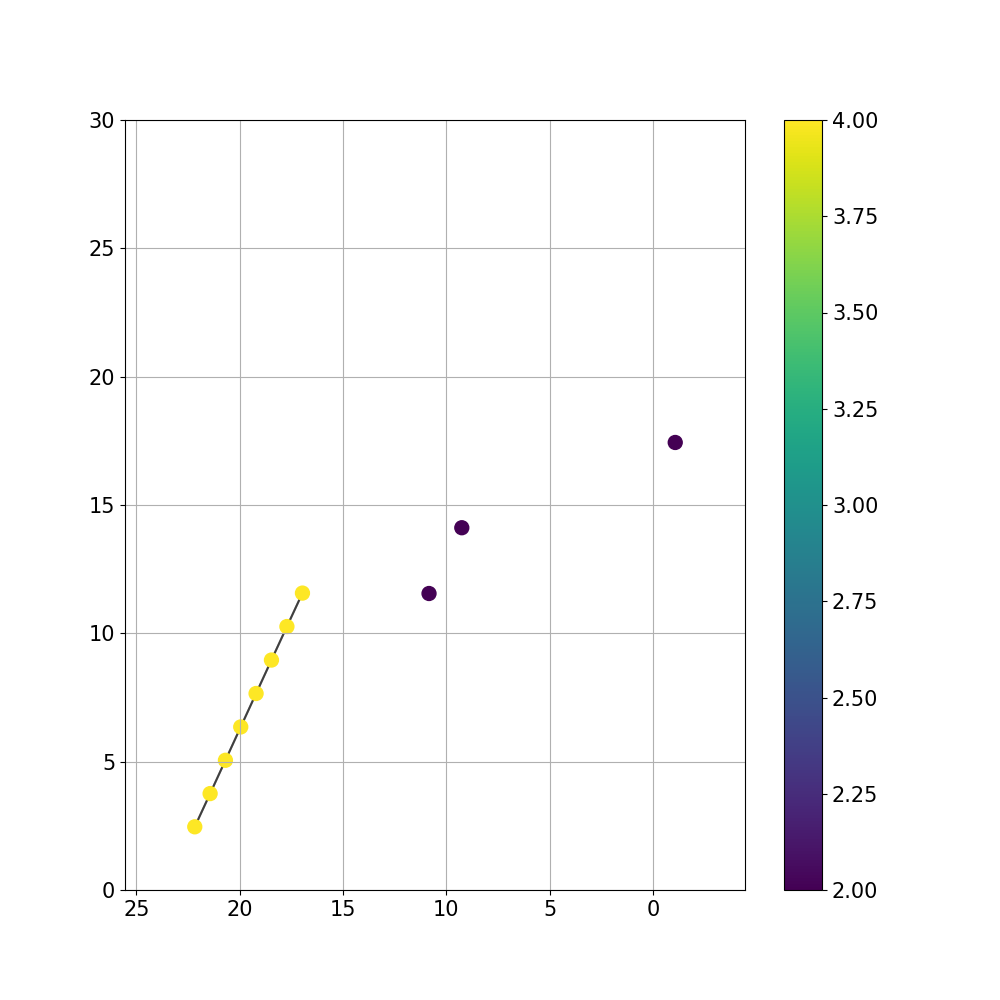

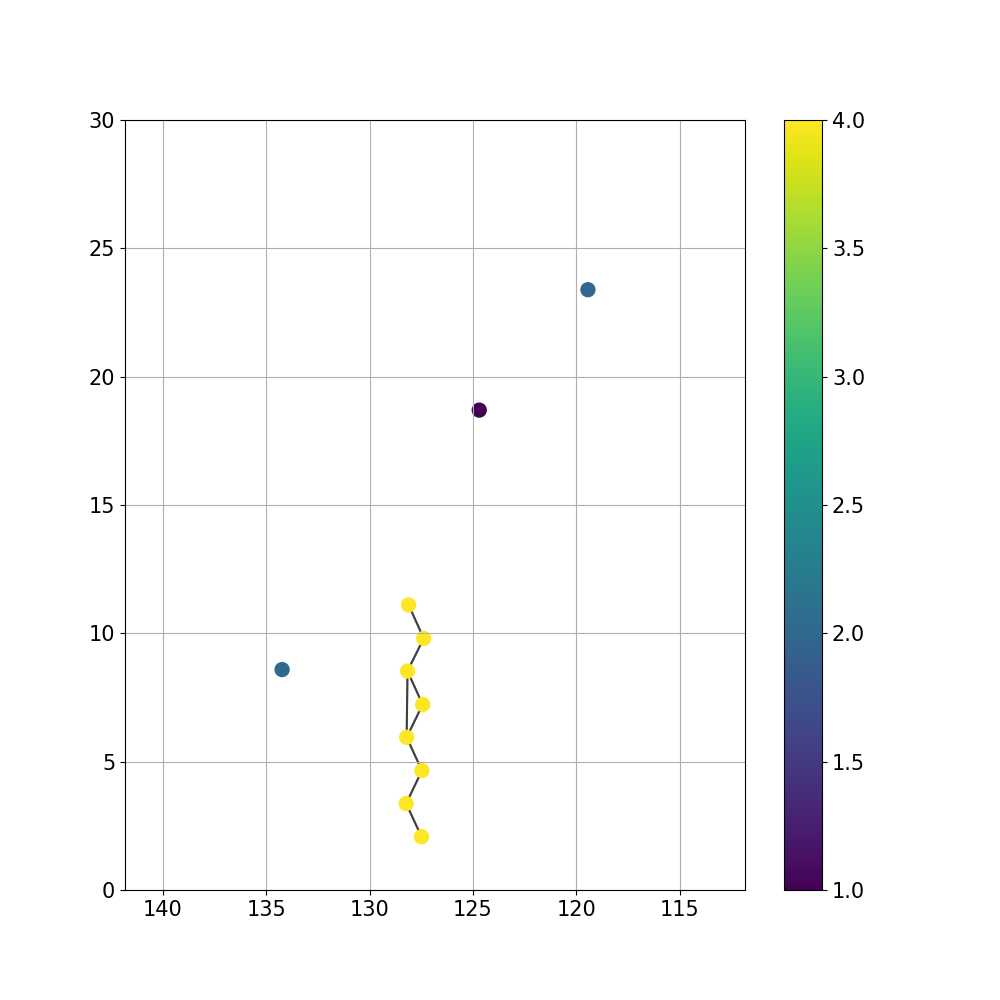

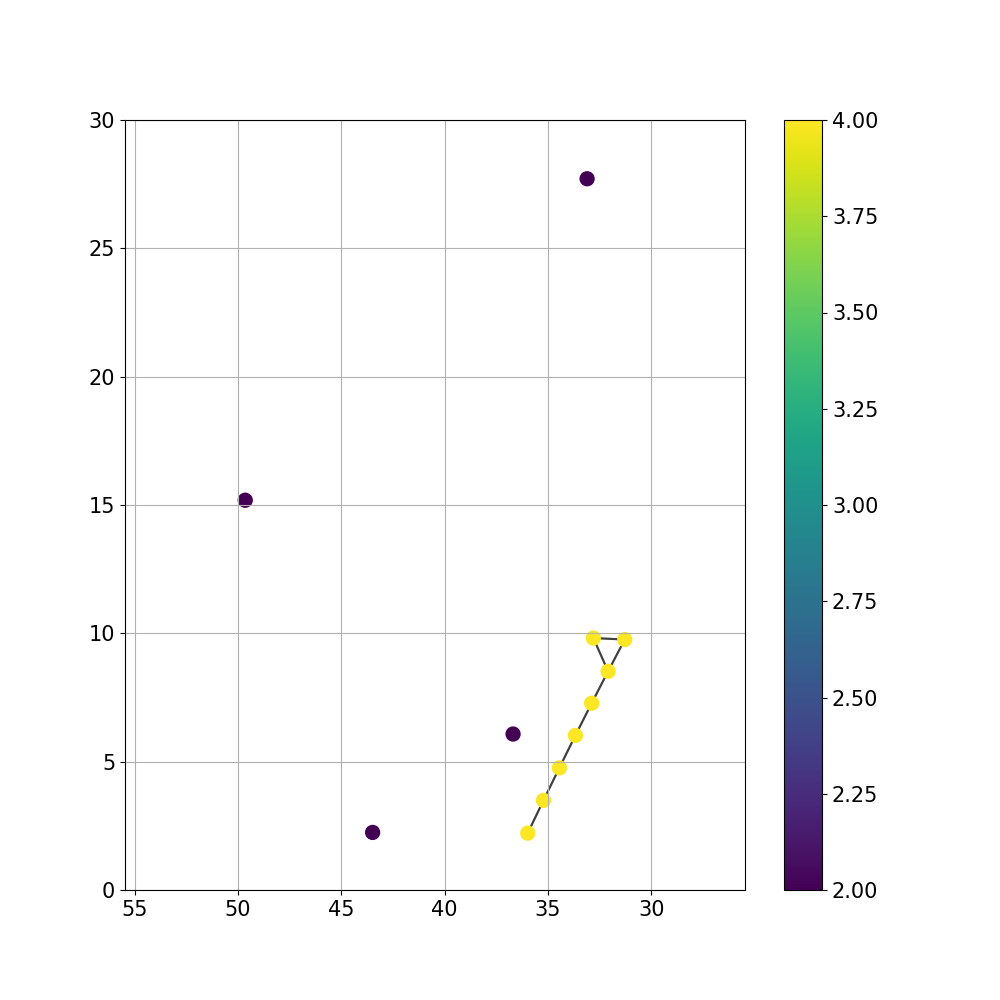

In [ ]:
# [Pix_Theta,Pix_Phi,Pix_Centroid,Pix_Charge,Pix_PulseDuration]

for i,graph in enumerate(Graphs):
    Nodes = graph[0]
    Edges = graph[1]
    Edge_values = graph[2]

    # print(Edges)
    plt.figure(figsize=[10,10])
    plt.scatter(Nodes[:,1],90-Nodes[:,0],c=Nodes[:,5],s=100)
    plt.colorbar()
    for edge in Edges:
        edge_X = [Nodes[edge[0],1],Nodes[edge[1],1]]
        edge_Y = [90-Nodes[edge[0],0],90-Nodes[edge[1],0]]
        plt.plot(edge_X,edge_Y,'k',alpha=0.5,zorder = -1)

    # Check xlim of the axis
    xlim = plt.gca().get_xlim()
    # print(xlim)
    if xlim[1] - xlim[0] < 30:
        middle = (xlim[0] + xlim[1]) / 2
        plt.xlim(middle - 15, middle  + 15)
    plt.ylim([0,30])
    plt.gca().invert_xaxis()
    plt.grid()

    # plt.figure(figsize=[10,10])
    # for y,node in enumerate(Nodes):
    #     x = node[2]
    #     plt.errorbar(x,y,xerr=node[4],fmt='o')
    
    # plt.figure(figsize=[10,10])
    

        

    if i == 10: break

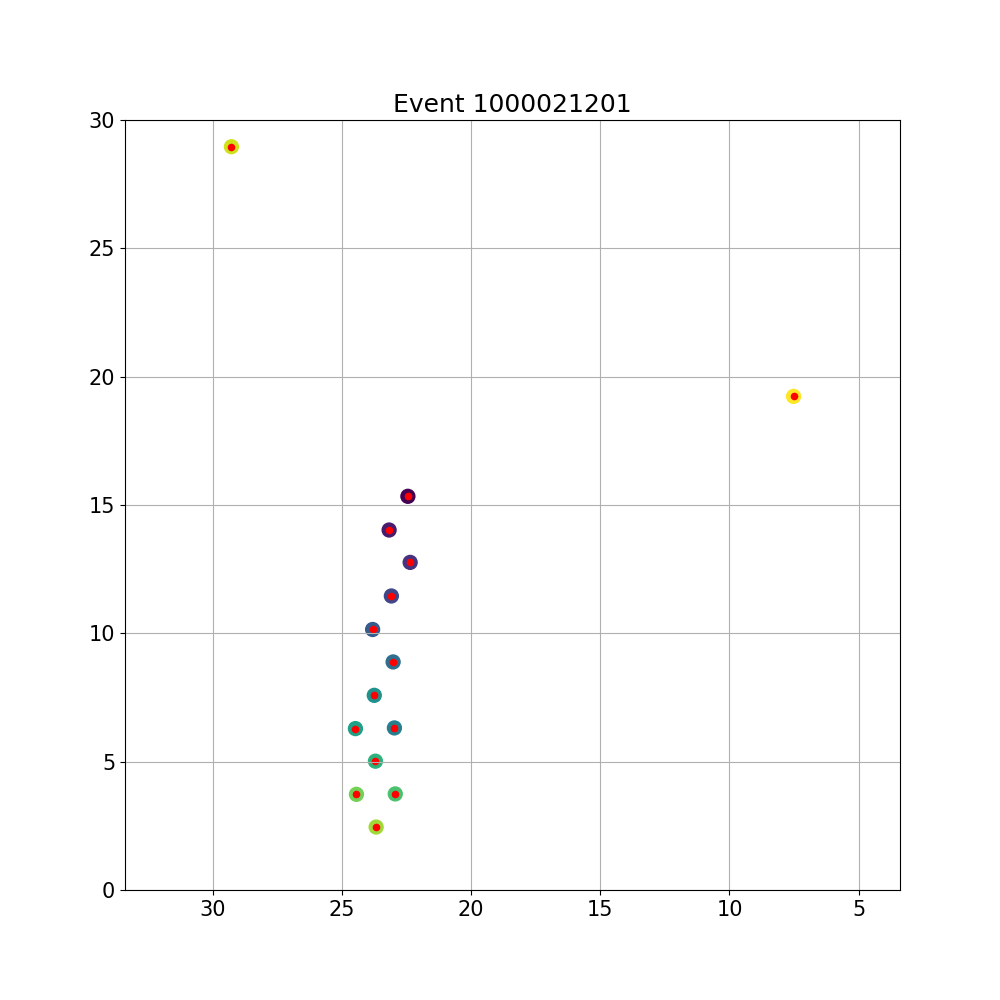

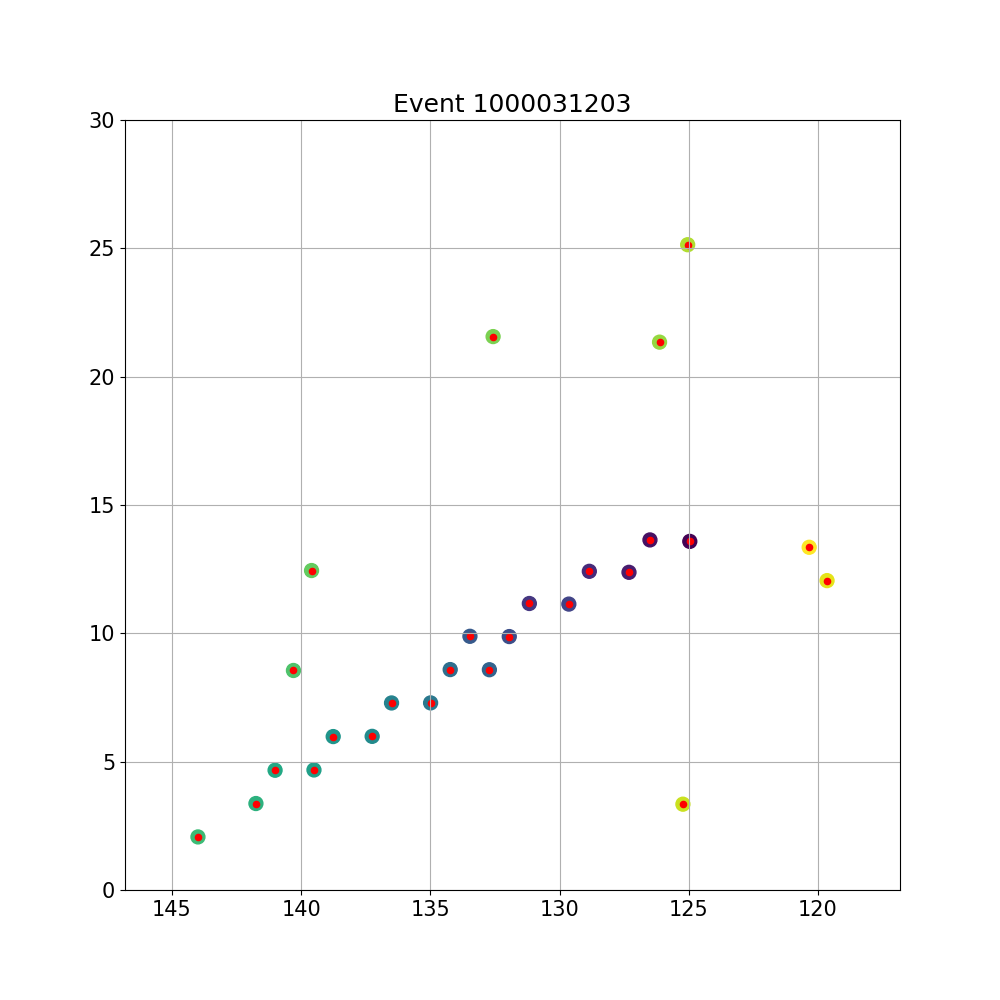

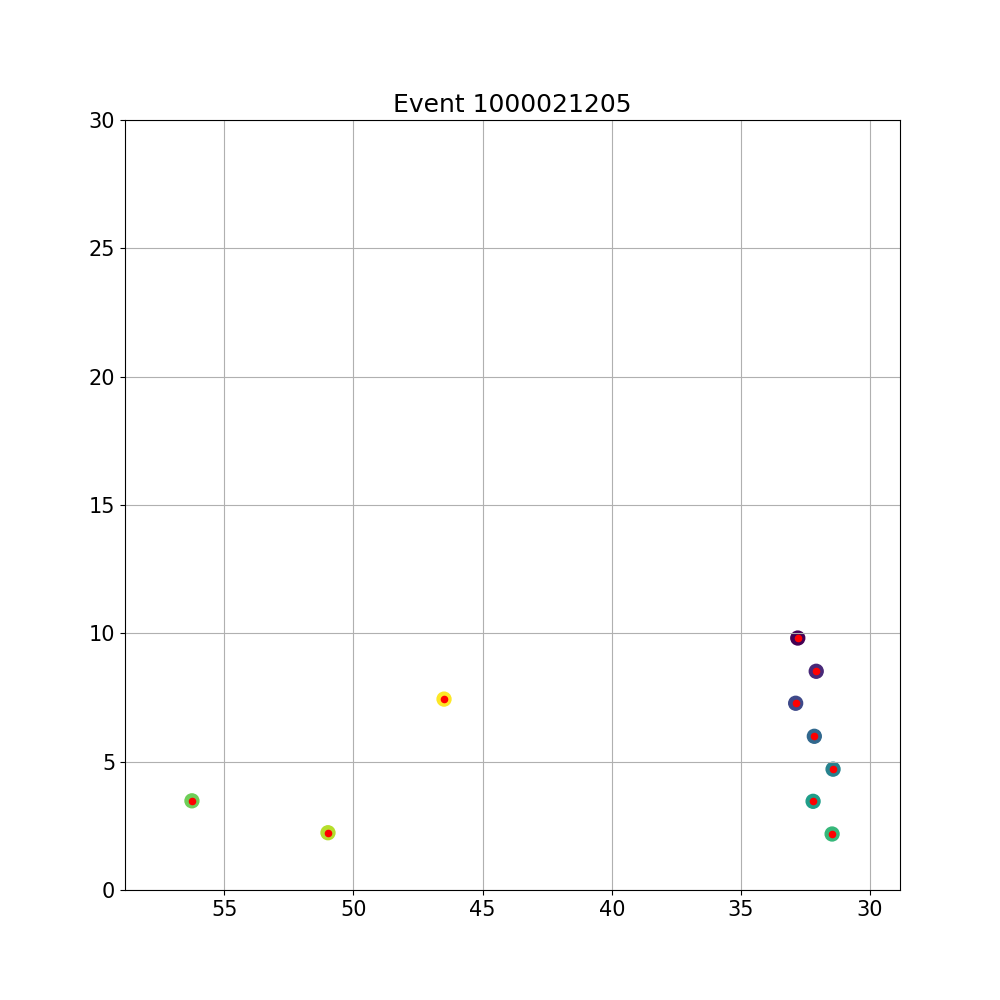

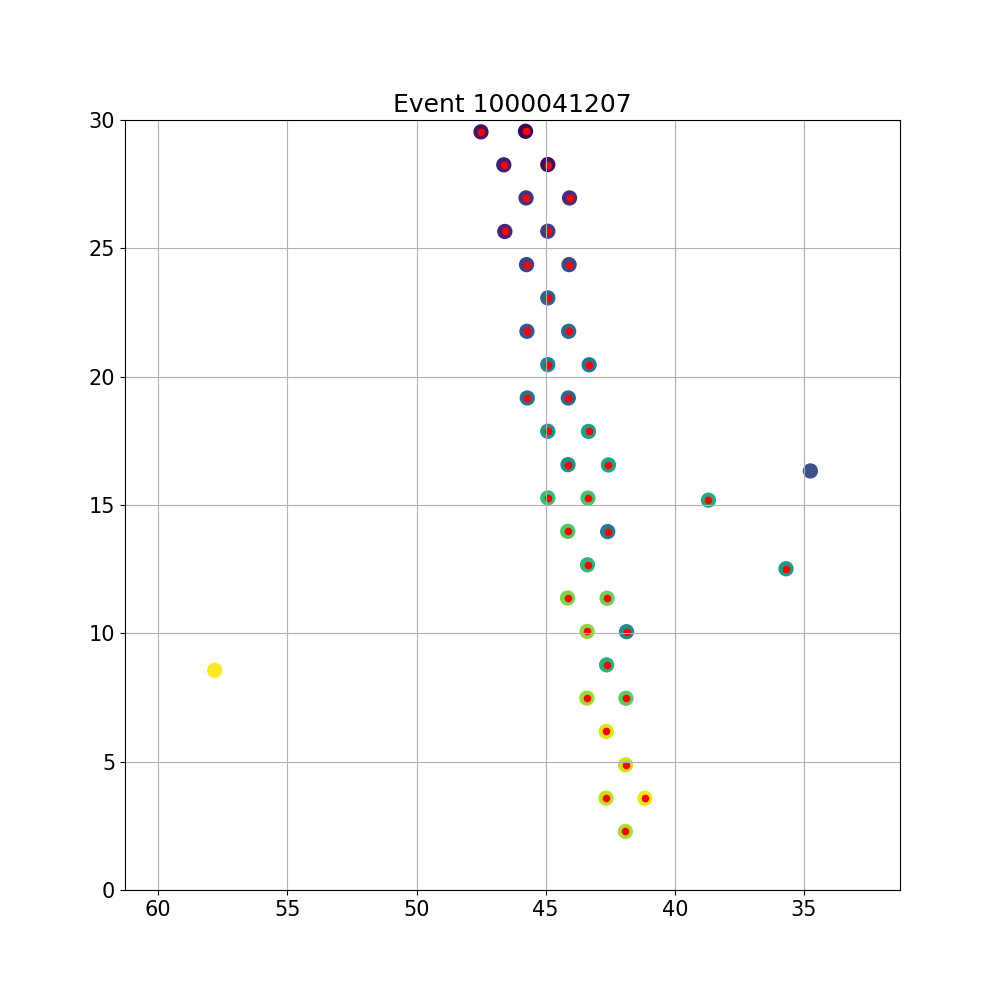

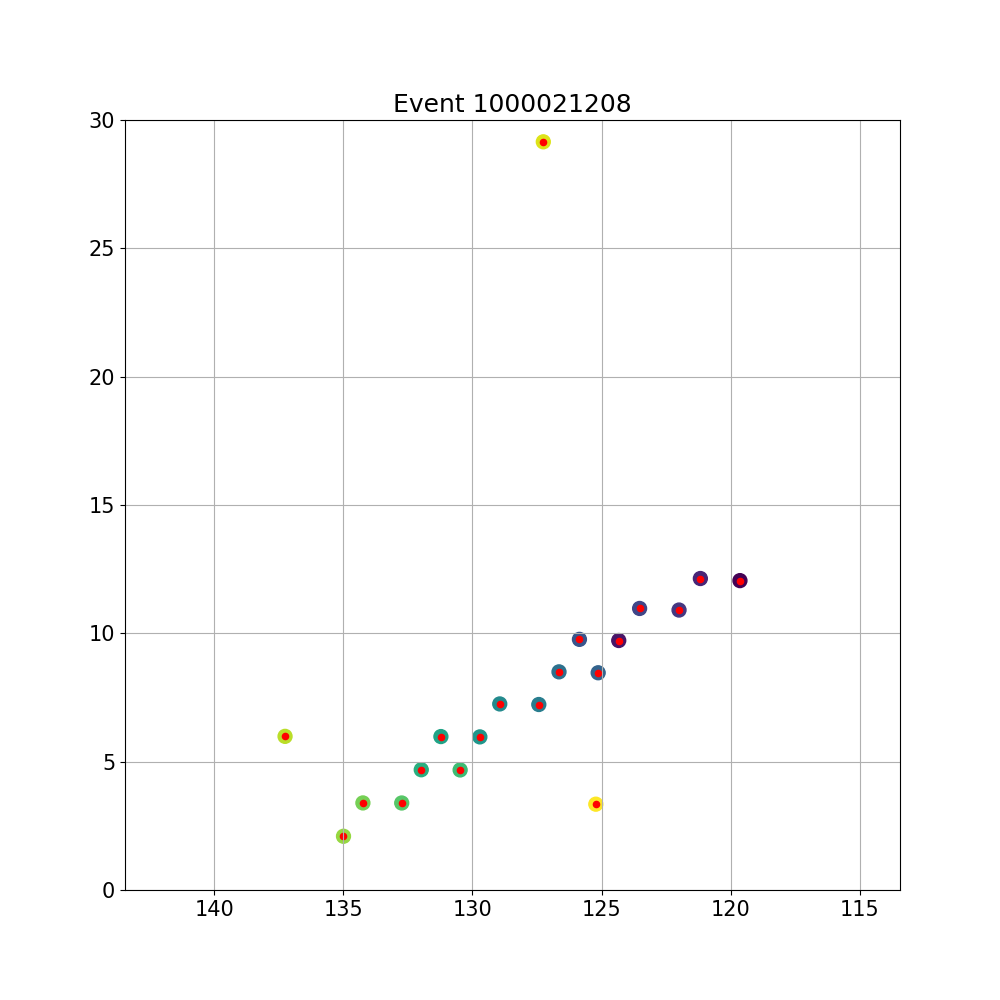

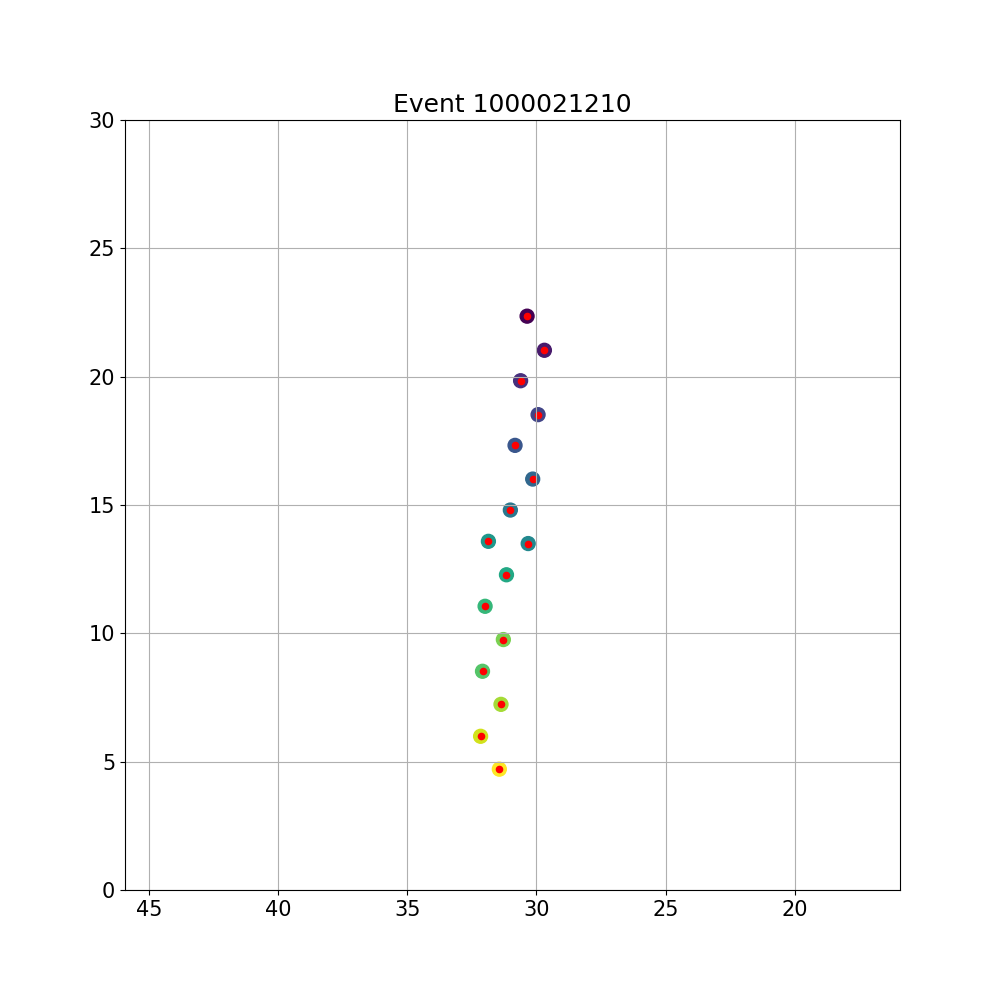

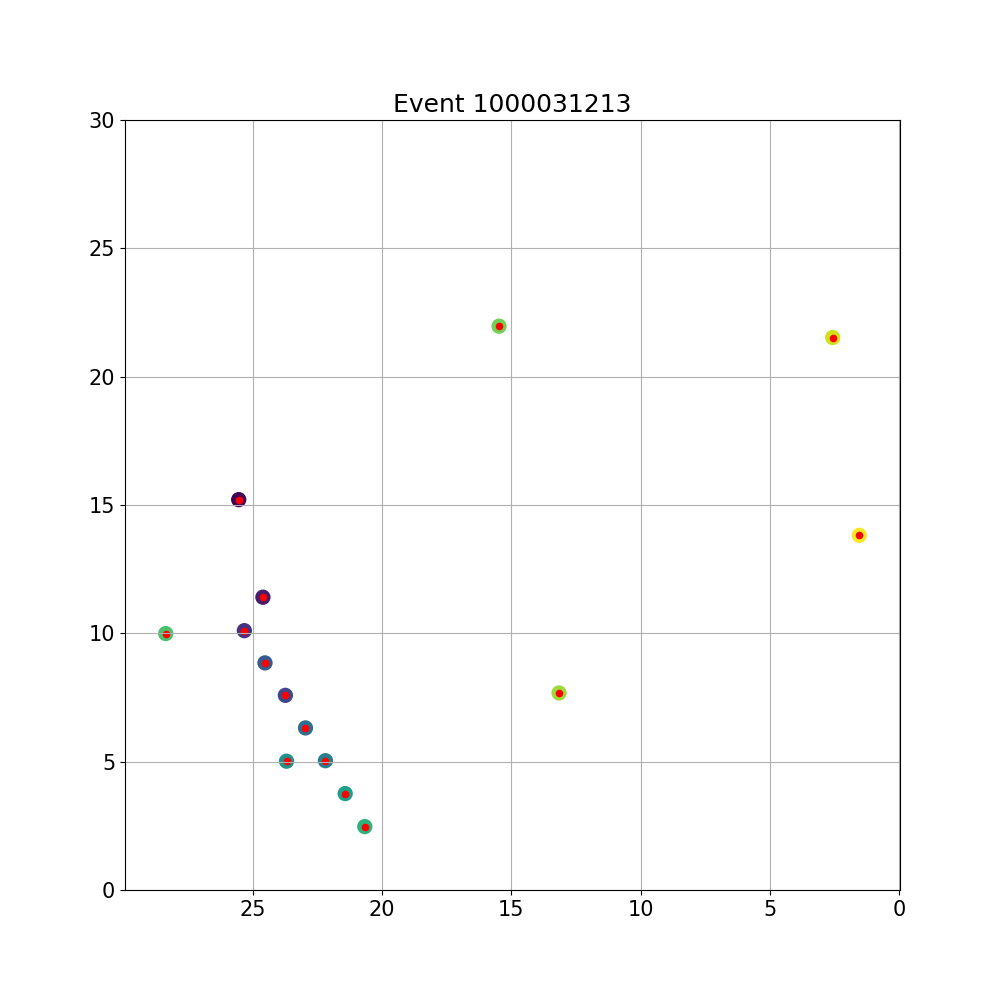

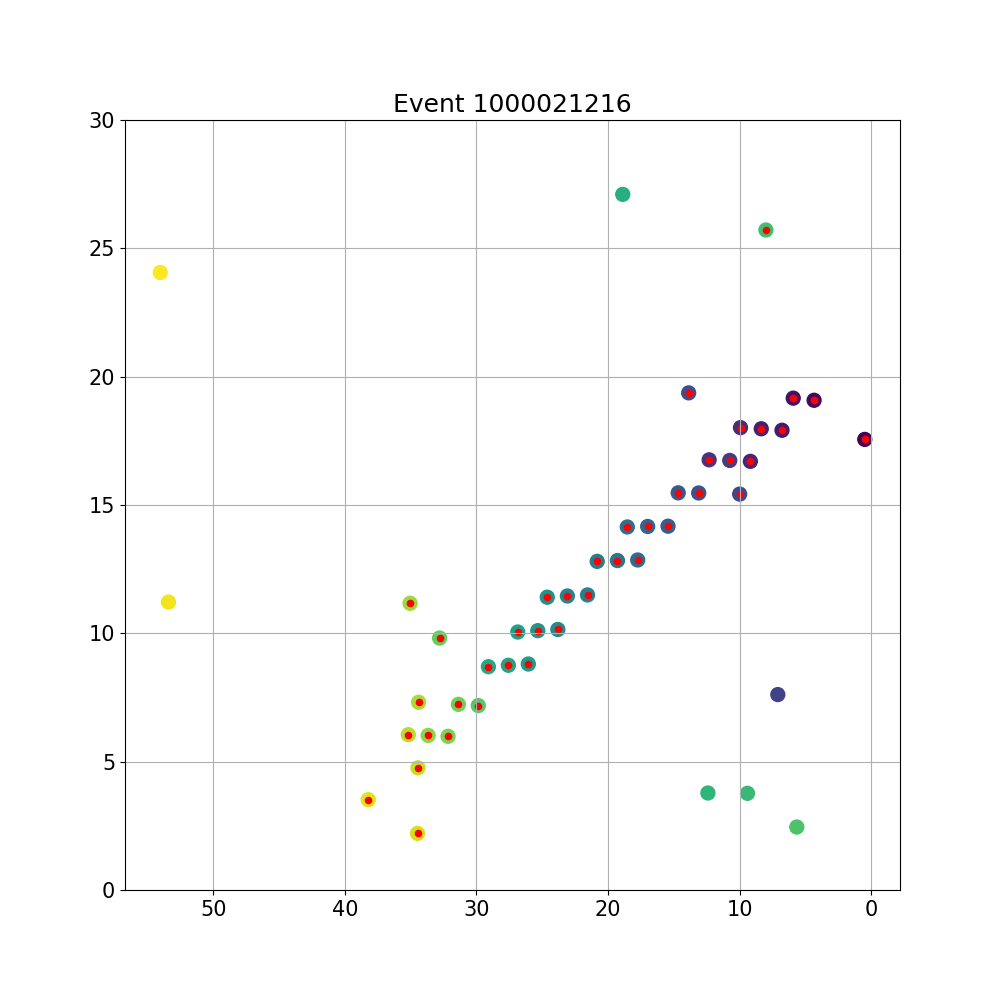

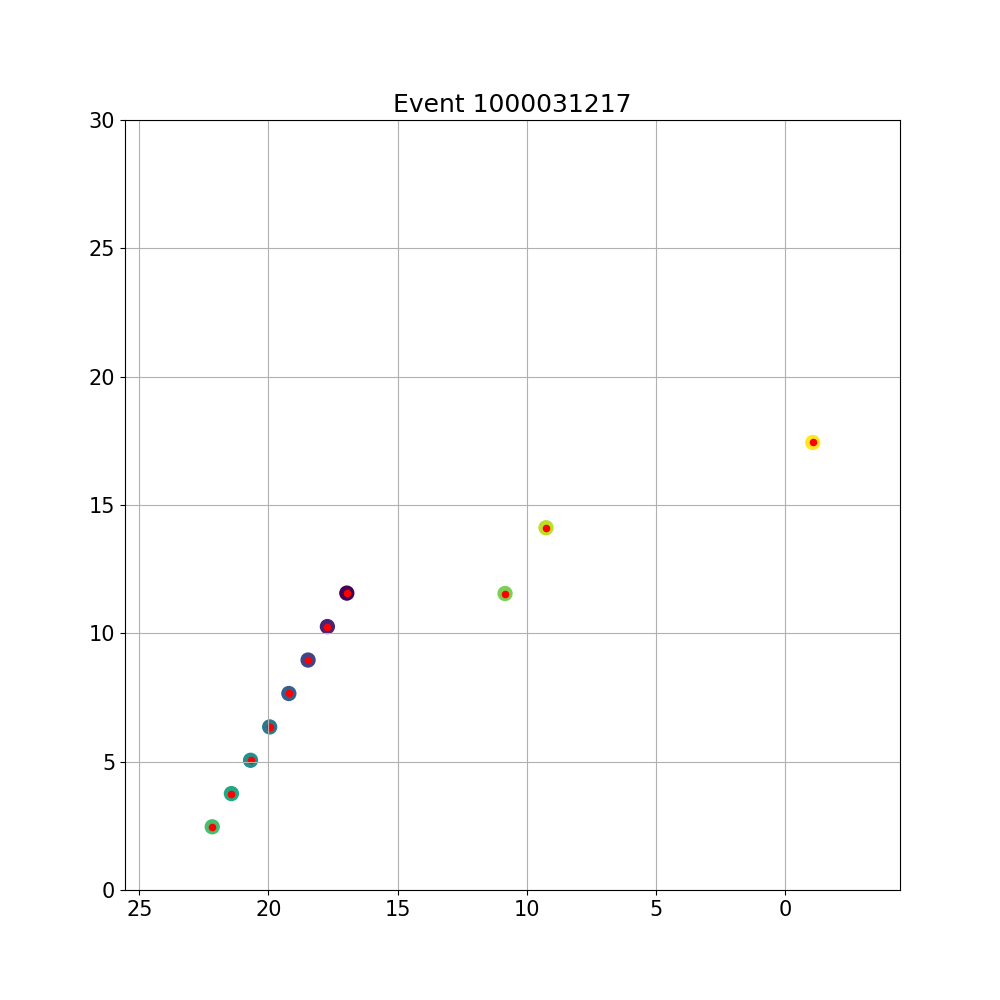

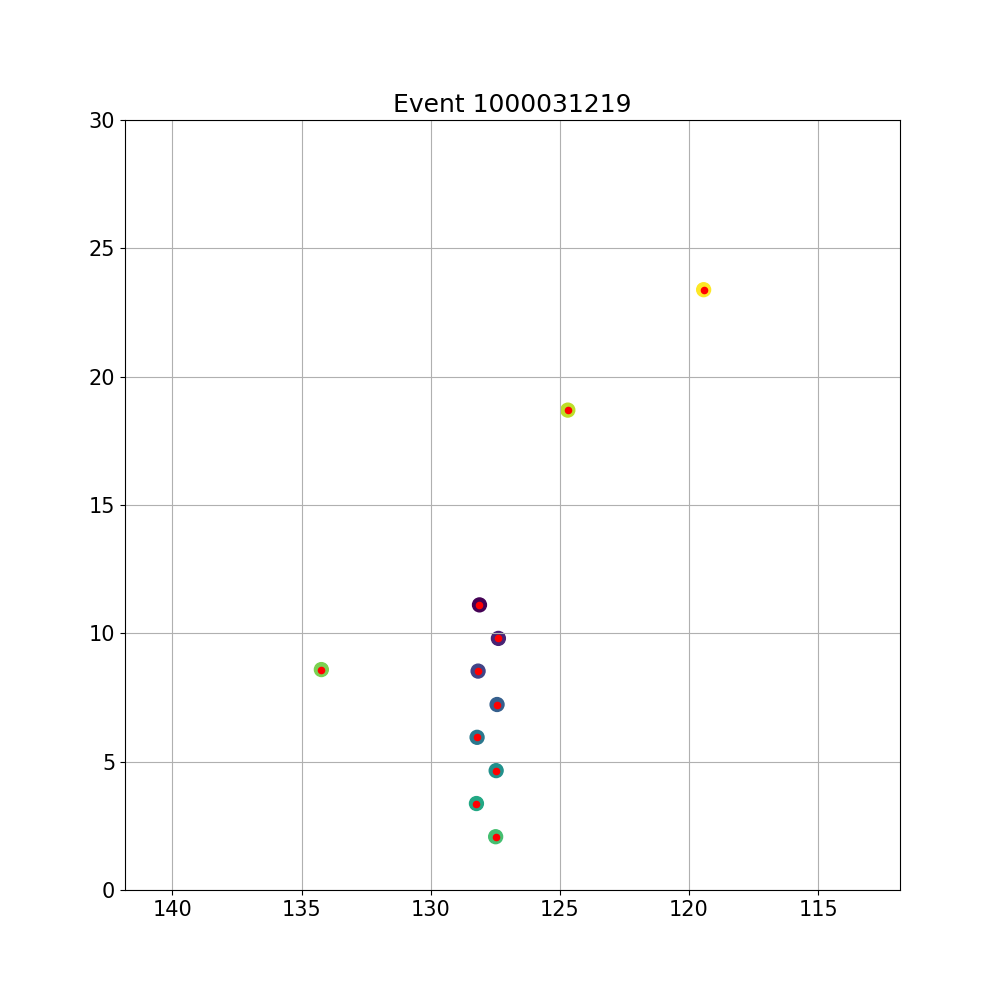

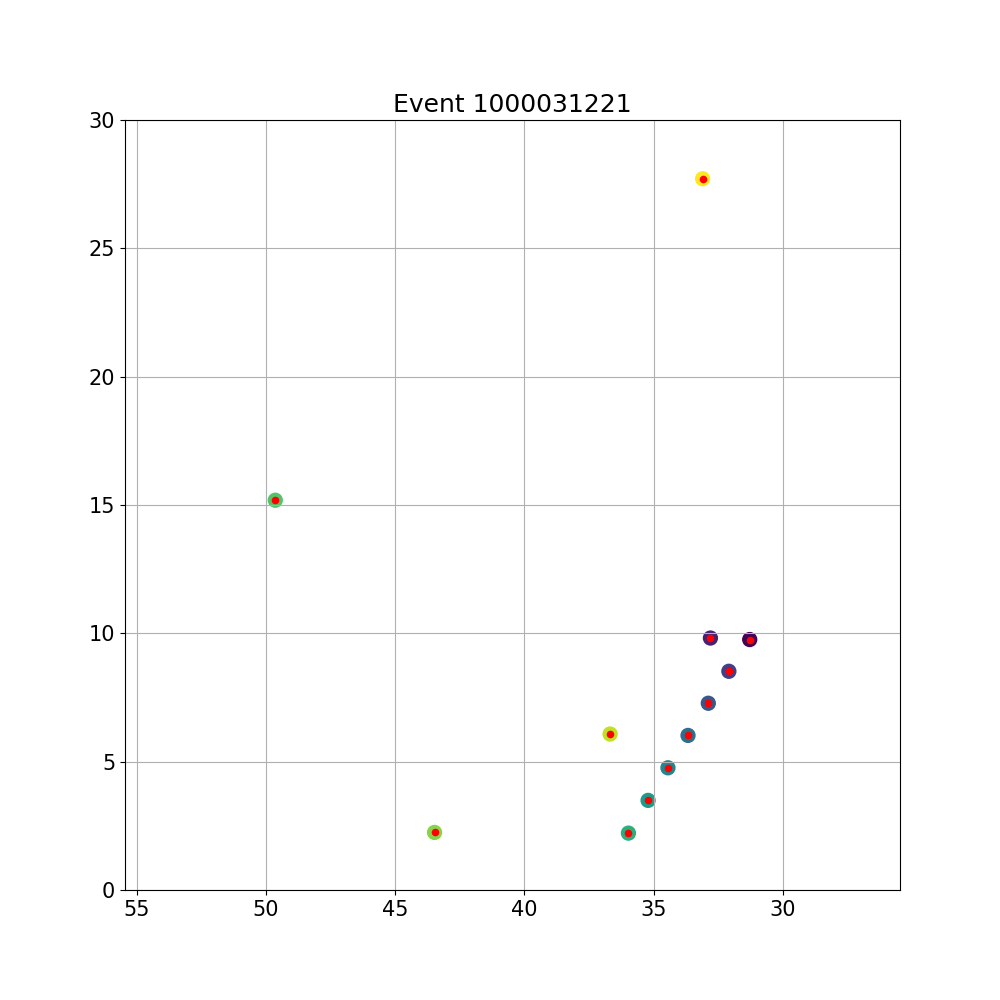

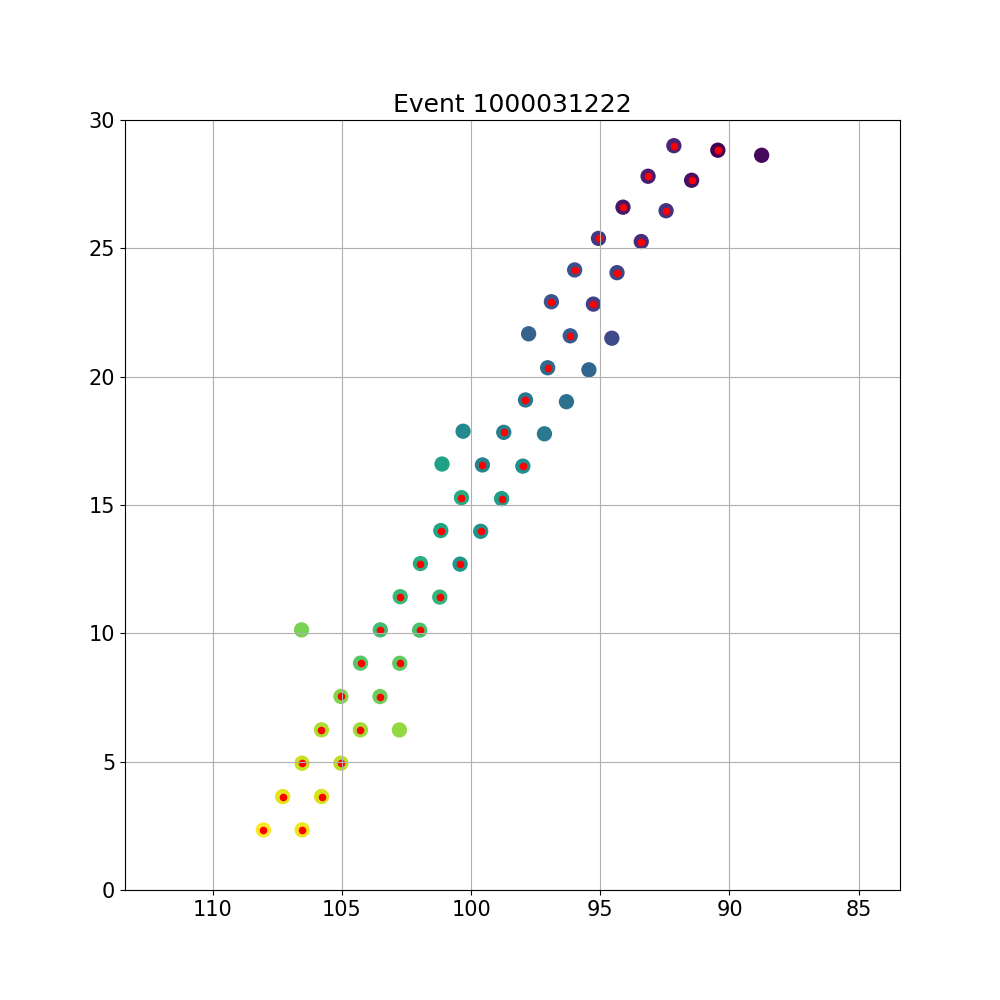

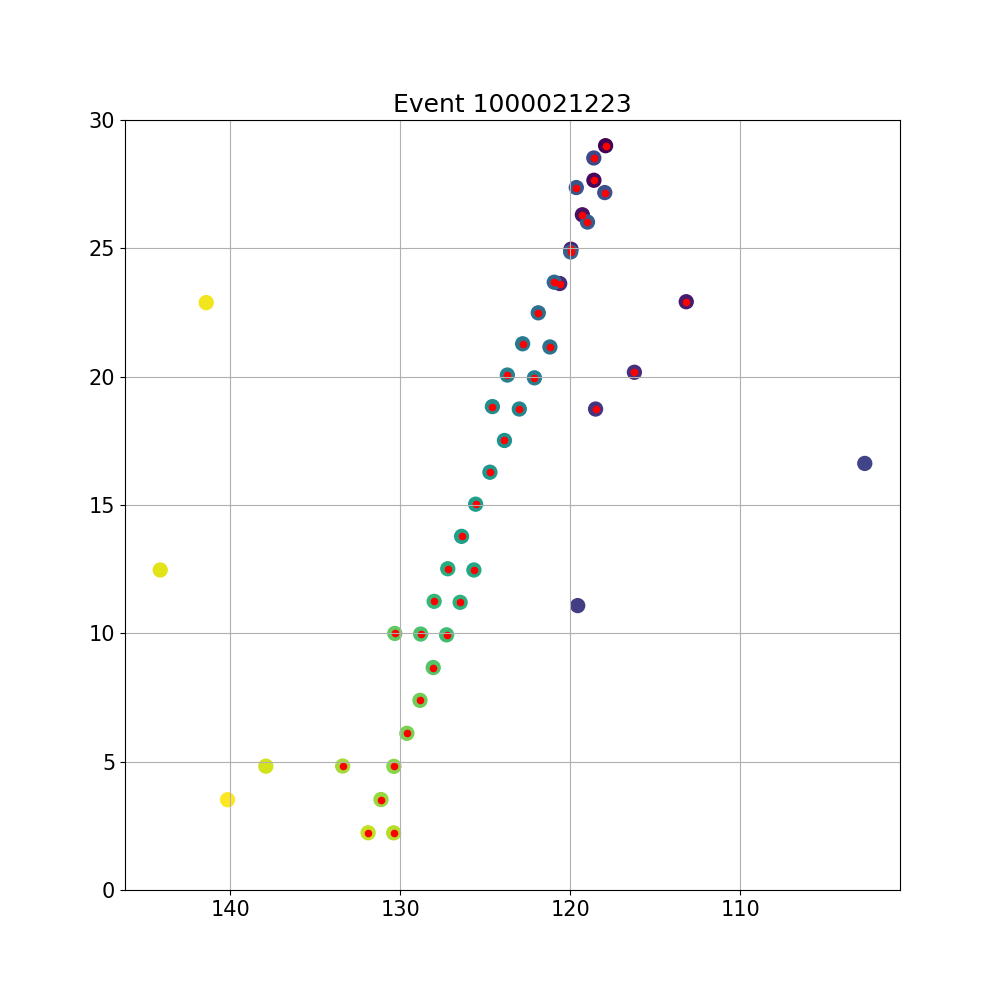

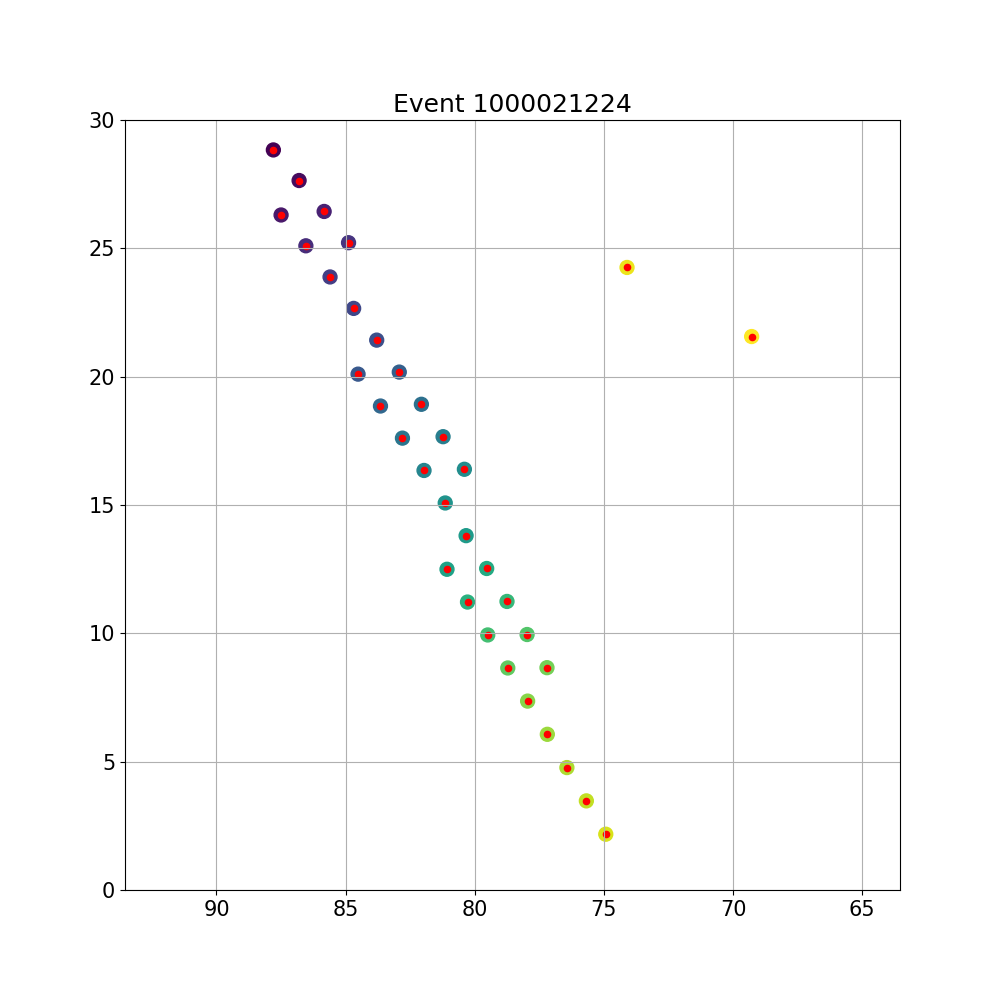

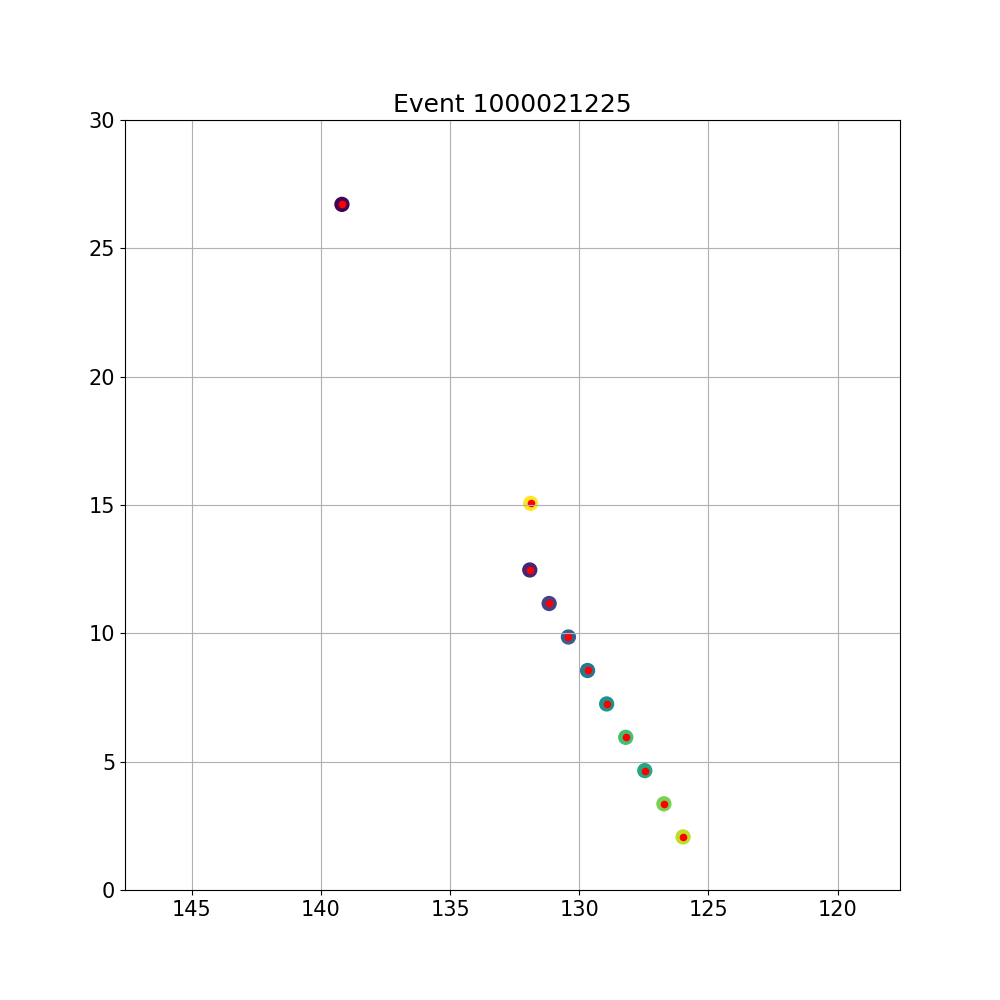

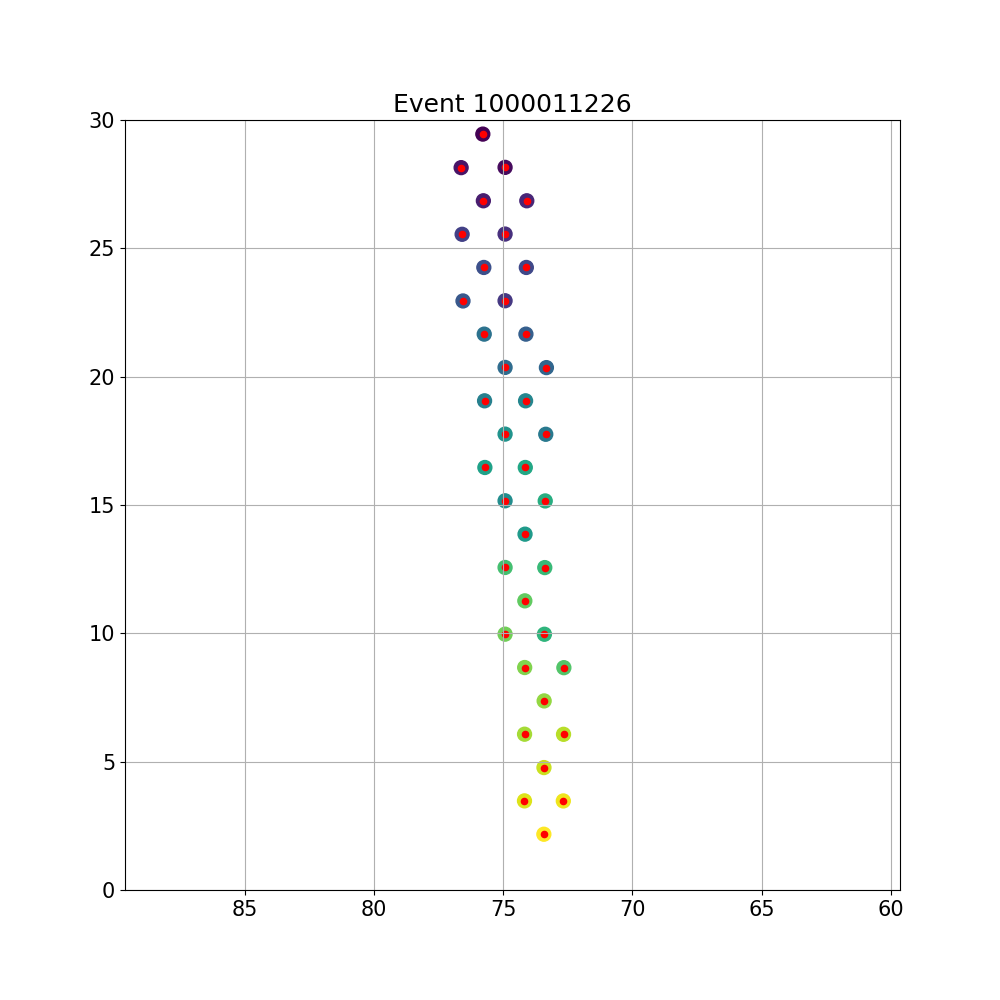

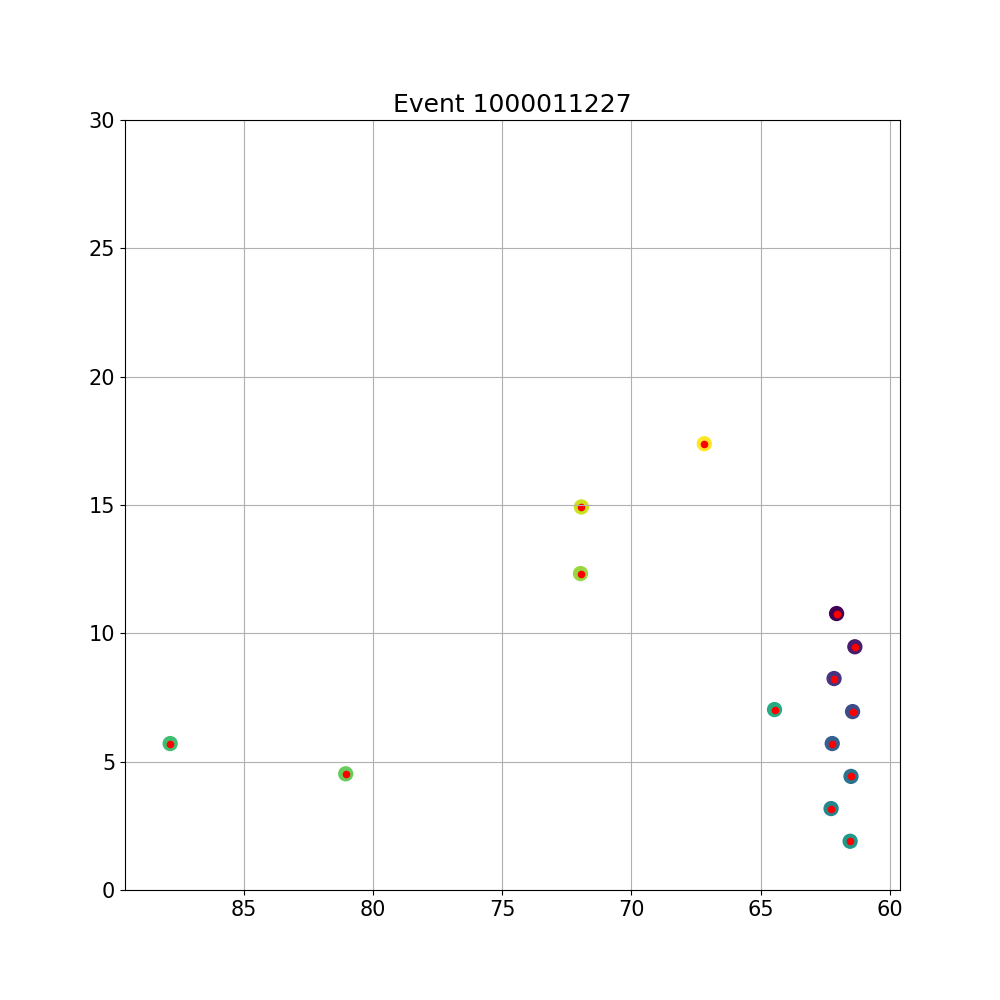

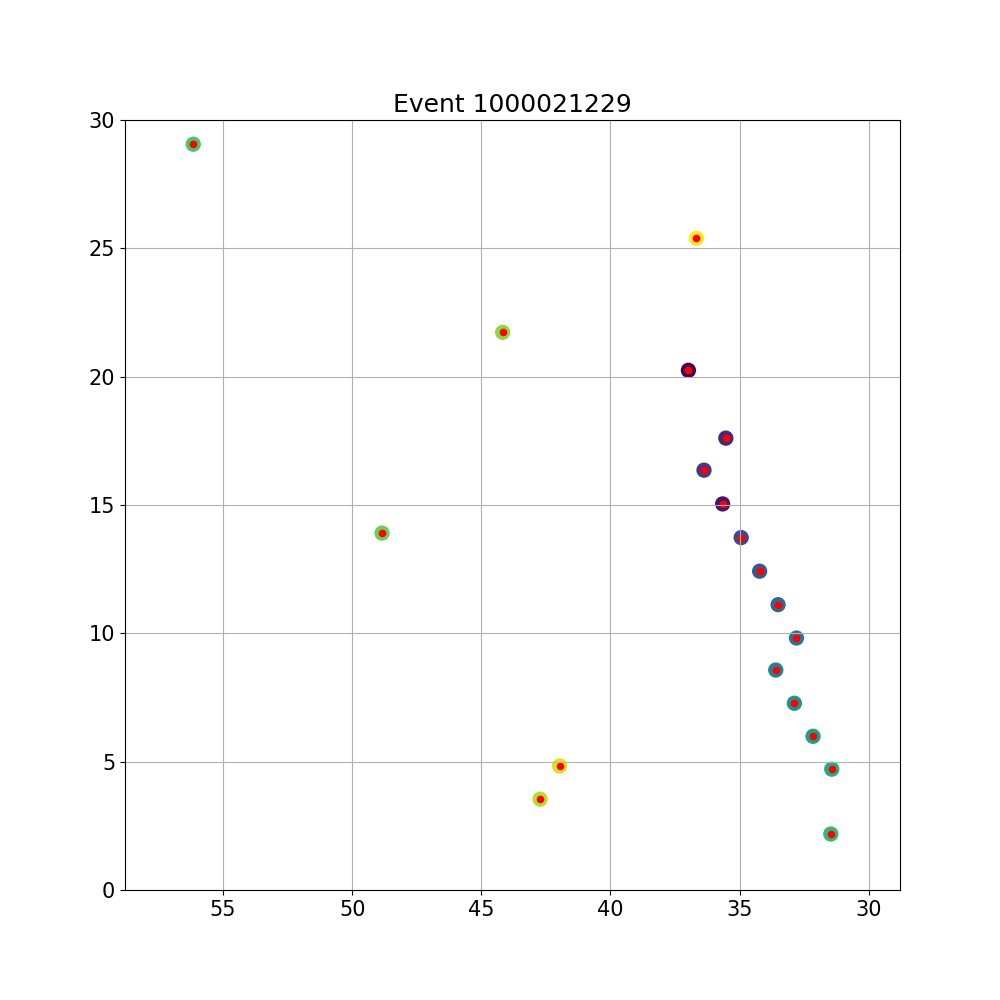

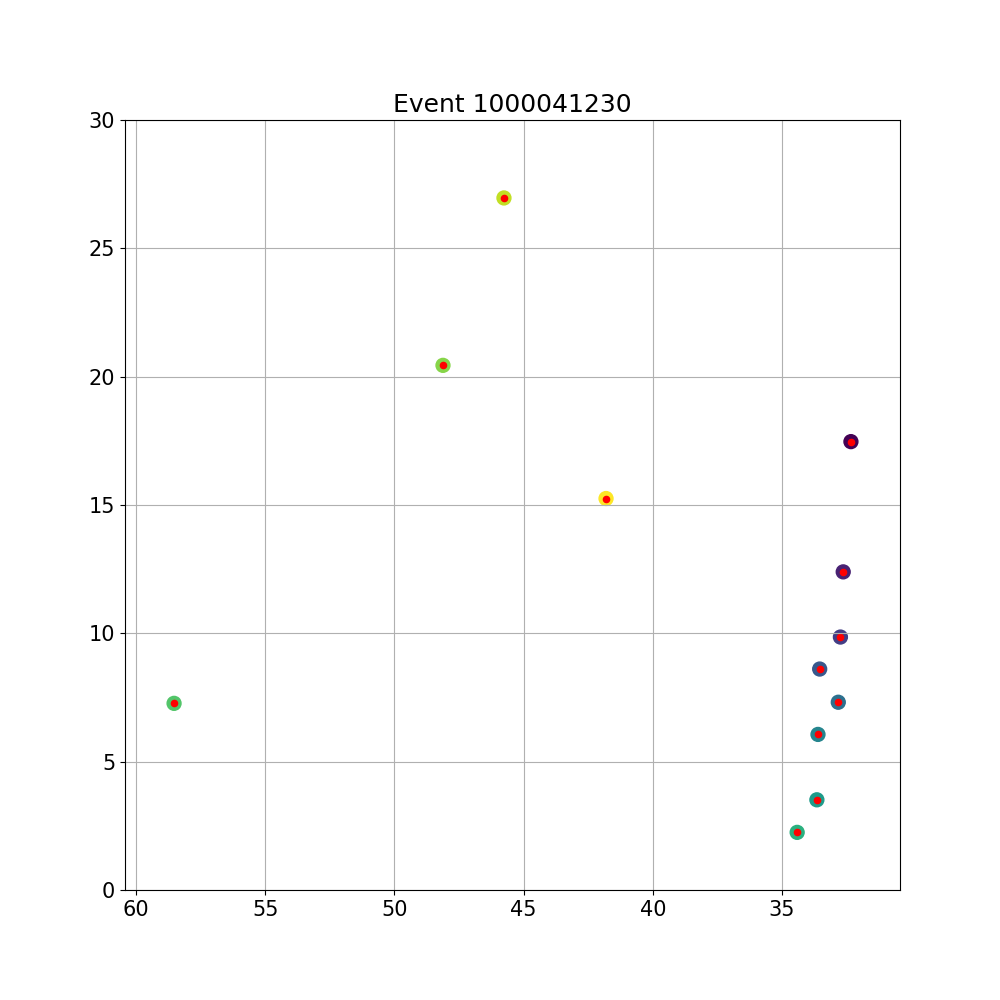

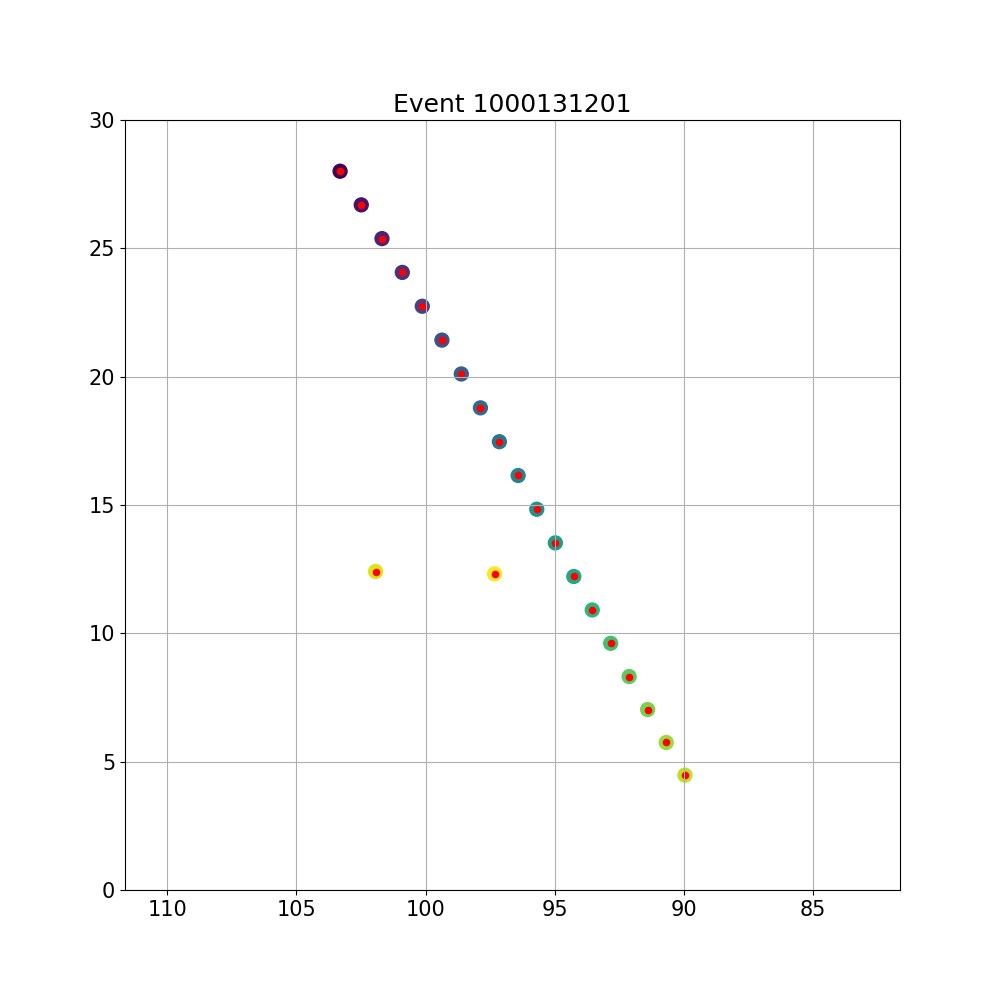

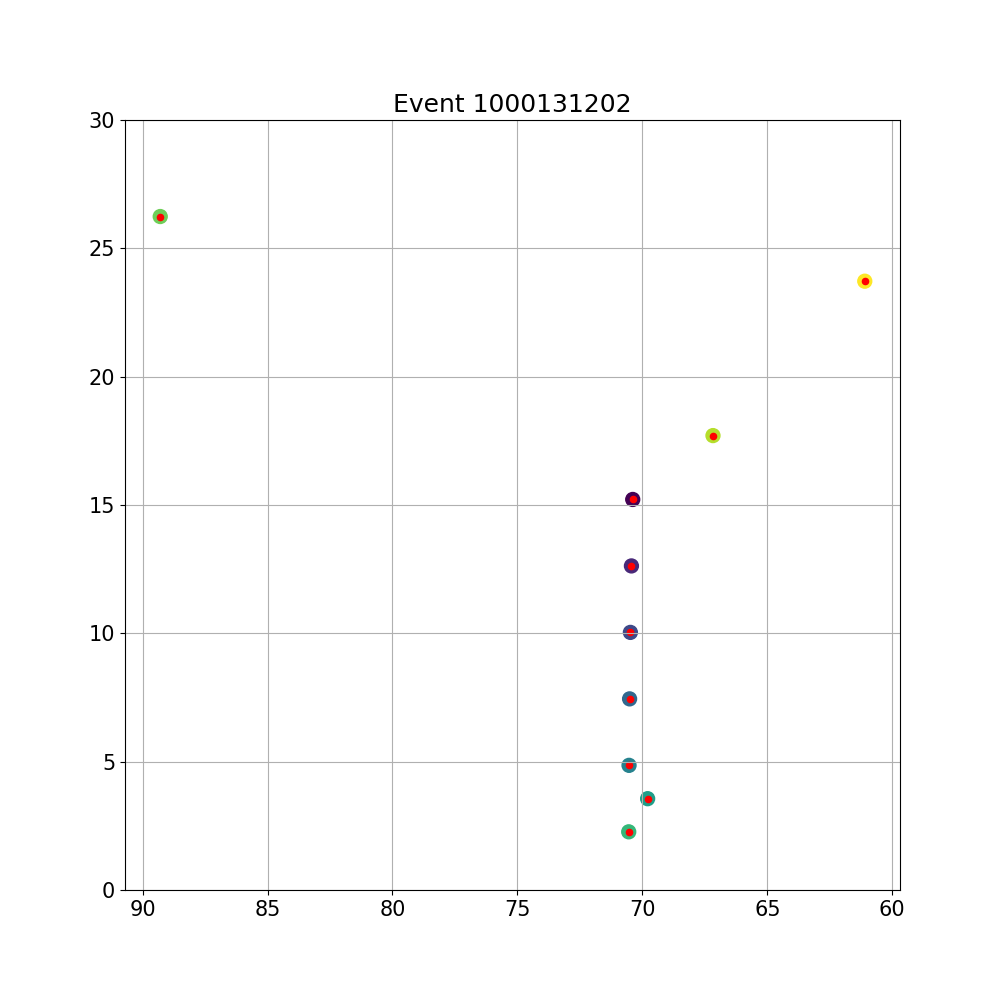

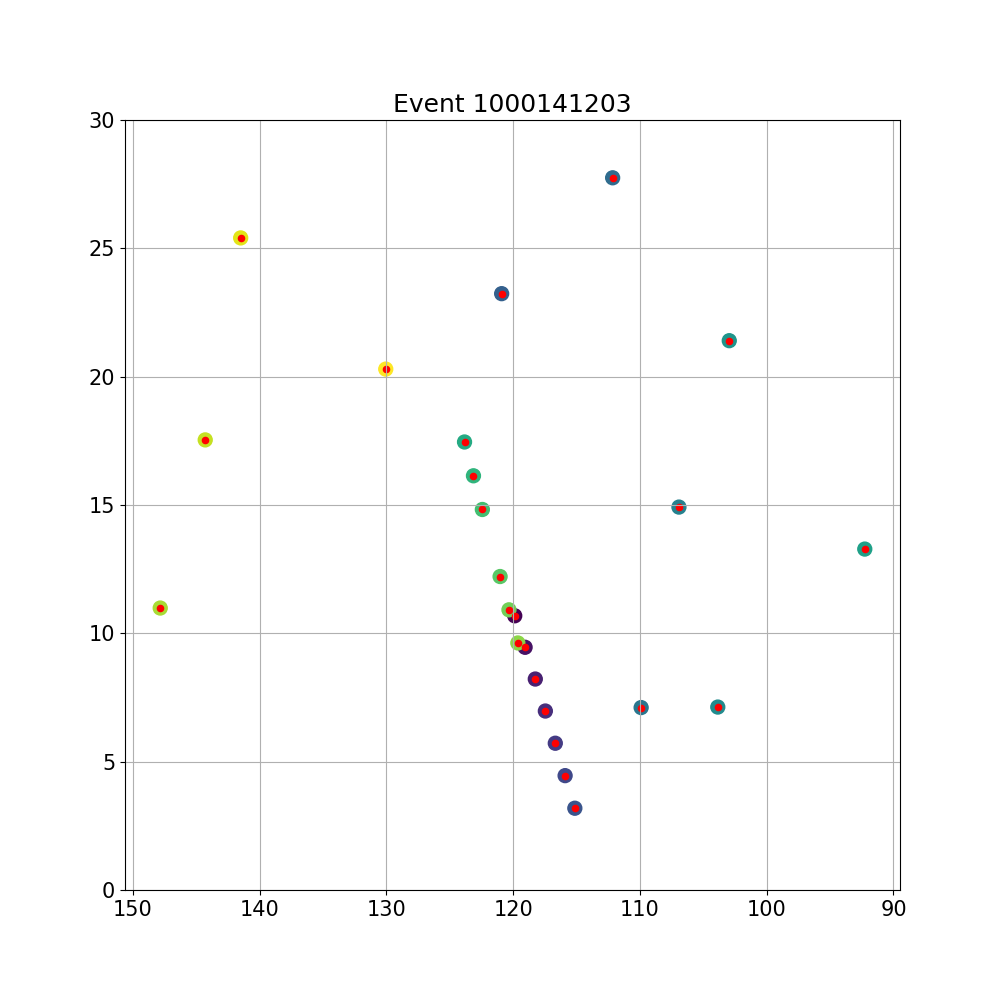

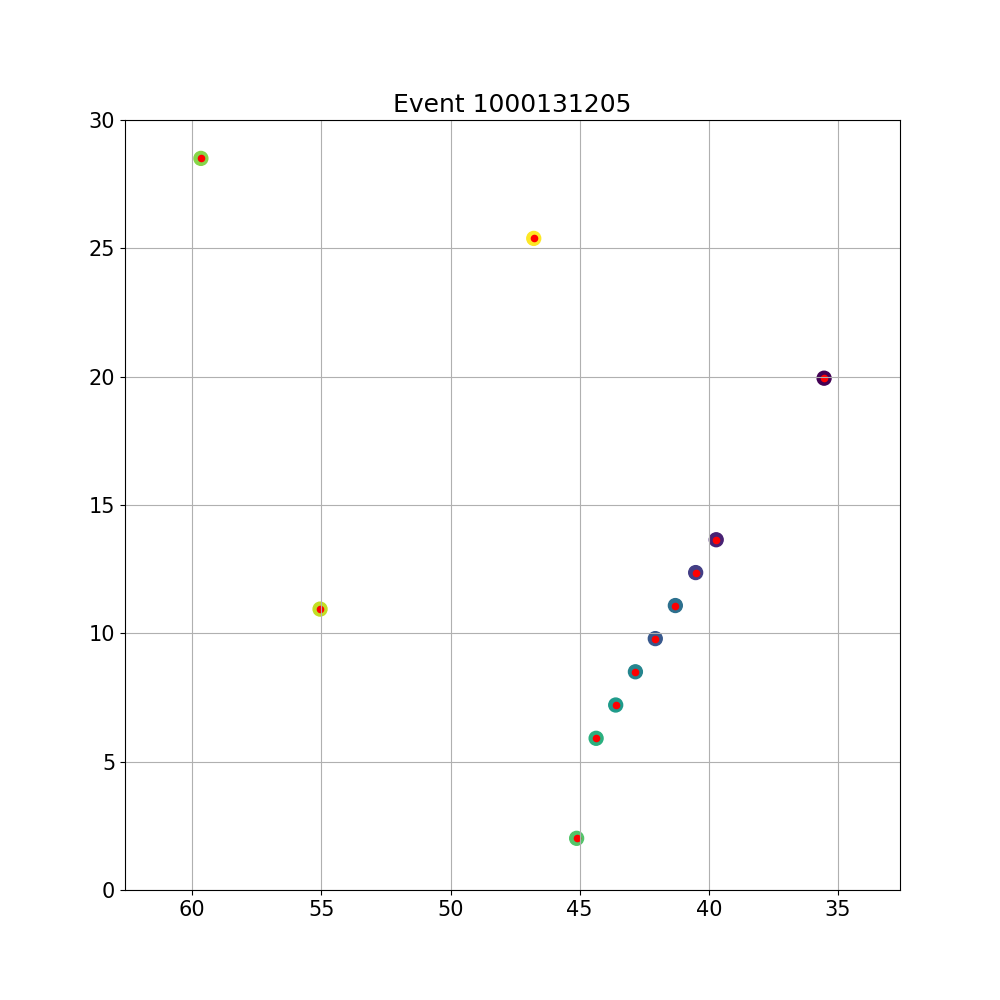

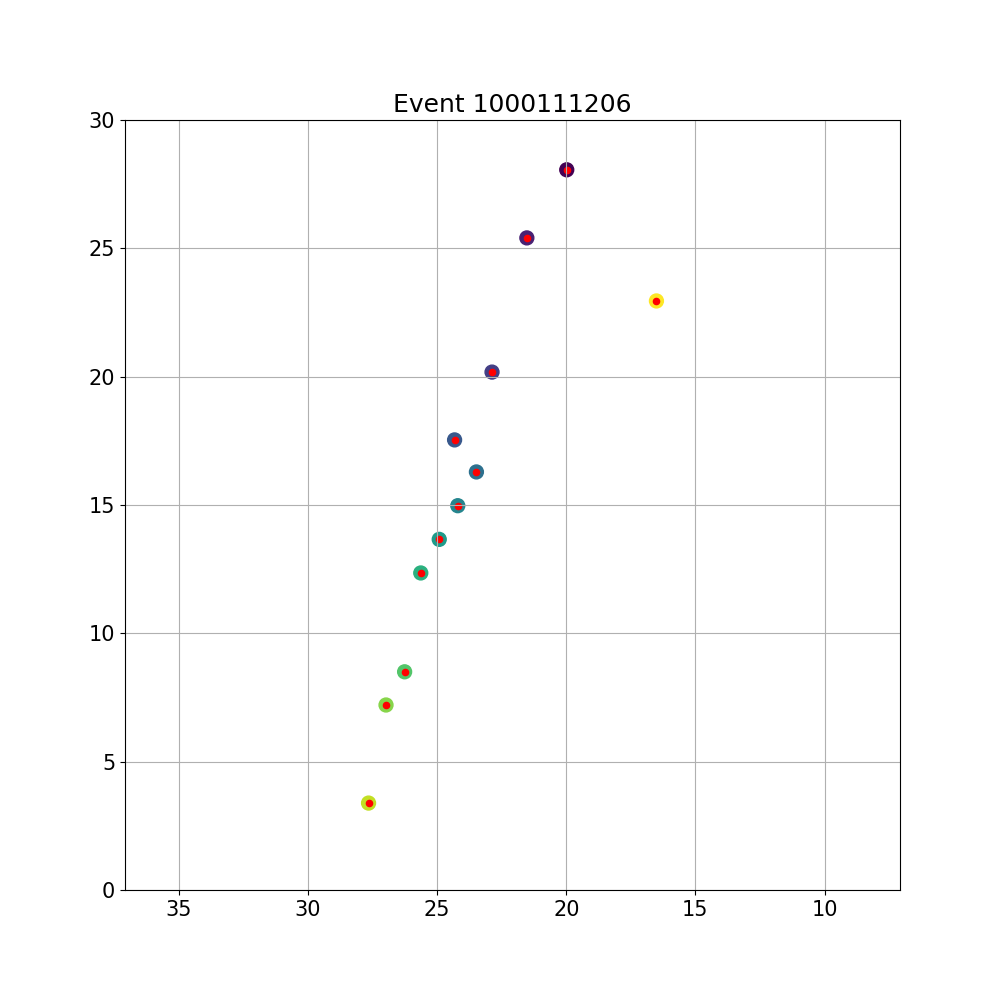

In [ ]:
# Closest 40 pixels plots
Evs = 0
for i,event in enumerate(Dataset):
    status = event.get_pixel_values('Status')
    # if torch.sum(status==4)<=40: continue
    Pixel_Theta  = event.get_pixel_values('Theta')
    Pixel_Phi    = event.get_pixel_values('Phi')
    Pixel_Charge = event.get_pixel_values('Charge')
    SDP_Theta    = event.get_value('Gen_SDPTheta')
    SDP_Phi      = event.get_value('Gen_SDPPhi')
    
    cut = cut_pixels(Pixel_Theta/180*torch.pi,Pixel_Phi/180*torch.pi,SDP_Theta,SDP_Phi,pixel_count=40)
    

    Id = Run010.IDs[i]
    plt.figure(figsize=[10,10])
    plt.scatter(Pixel_Phi,90-Pixel_Theta,s=100,c=range(len(Pixel_Theta)))
    plt.scatter(Pixel_Phi[cut],90-Pixel_Theta[cut],c='r',s=20)
    plt.title(f'Event {Id}')

    # Check xlim of the axis
    xlim = plt.gca().get_xlim()
    # print(xlim)
    if xlim[1] - xlim[0] < 30:
        middle = (xlim[0] + xlim[1]) / 2
        plt.xlim(middle - 15, middle  + 15)
    plt.ylim([0,30])
    plt.gca().invert_xaxis()
    plt.grid()

    
    Evs+=1

    if Evs>25: break
    # break

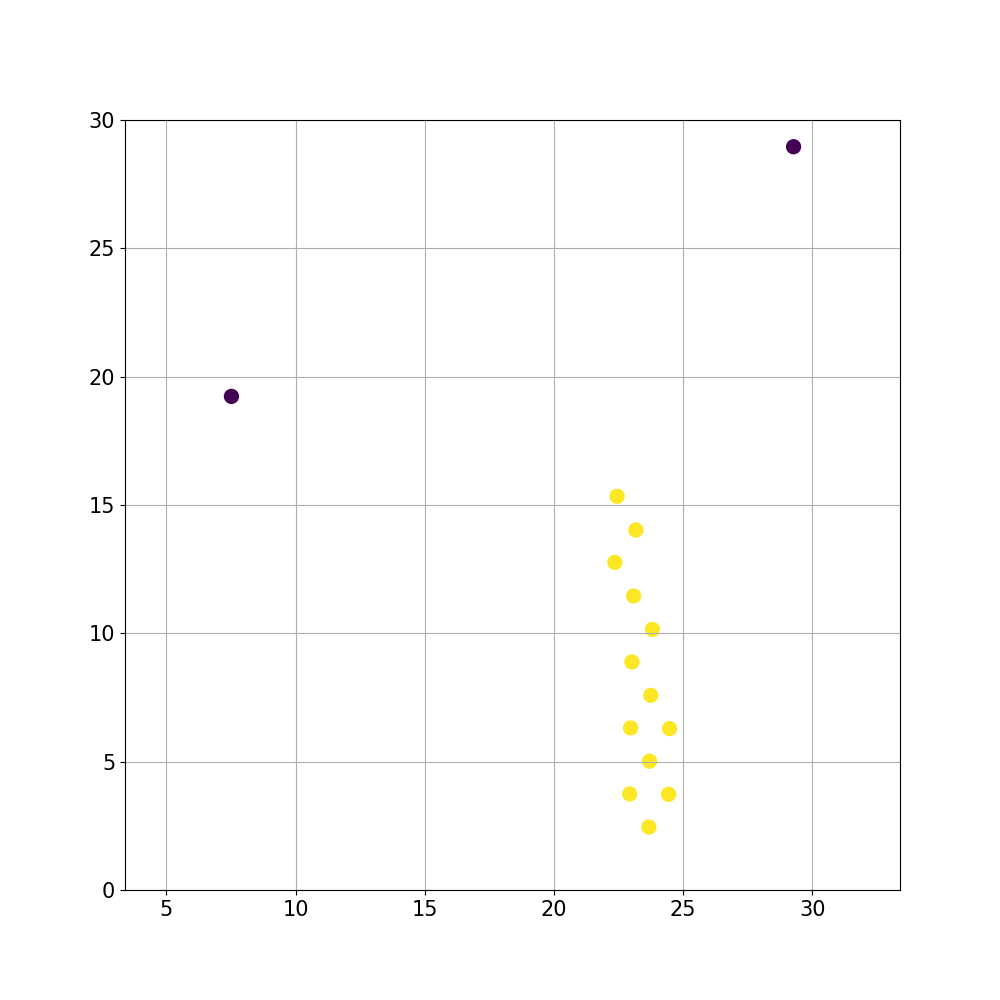

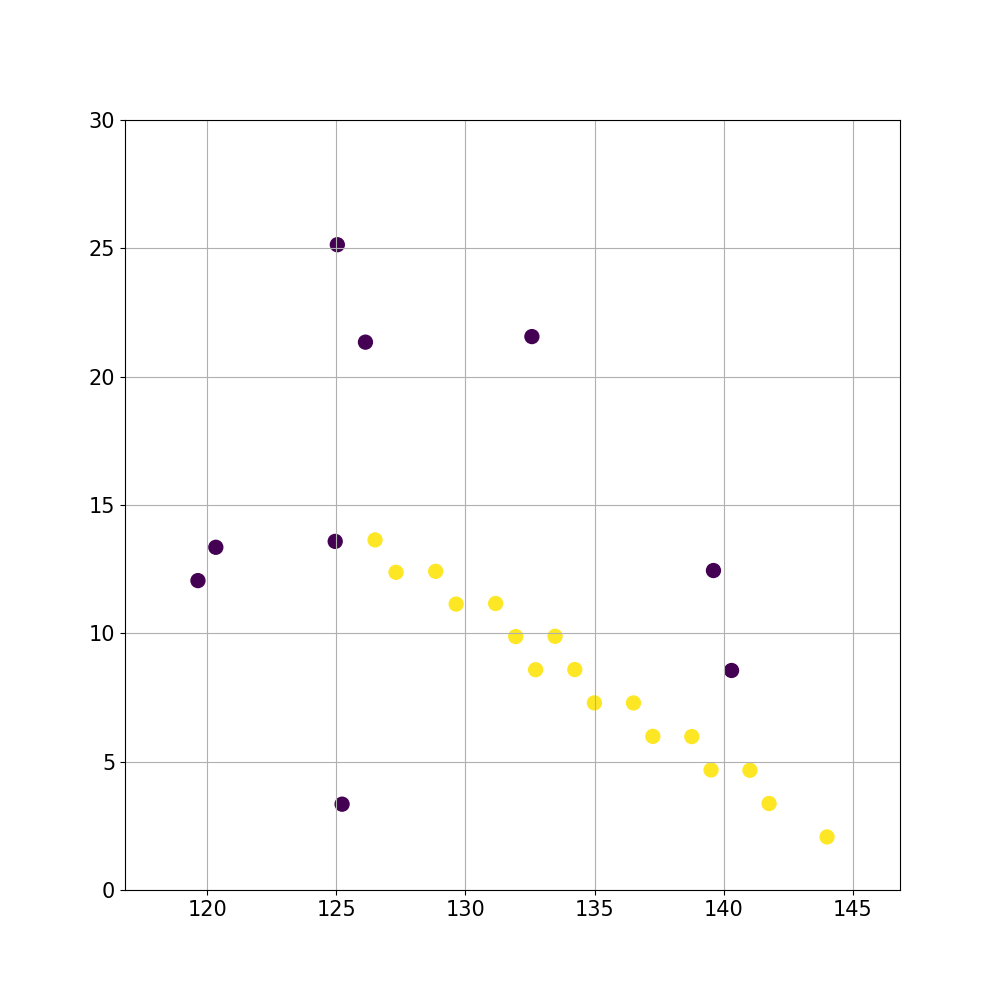

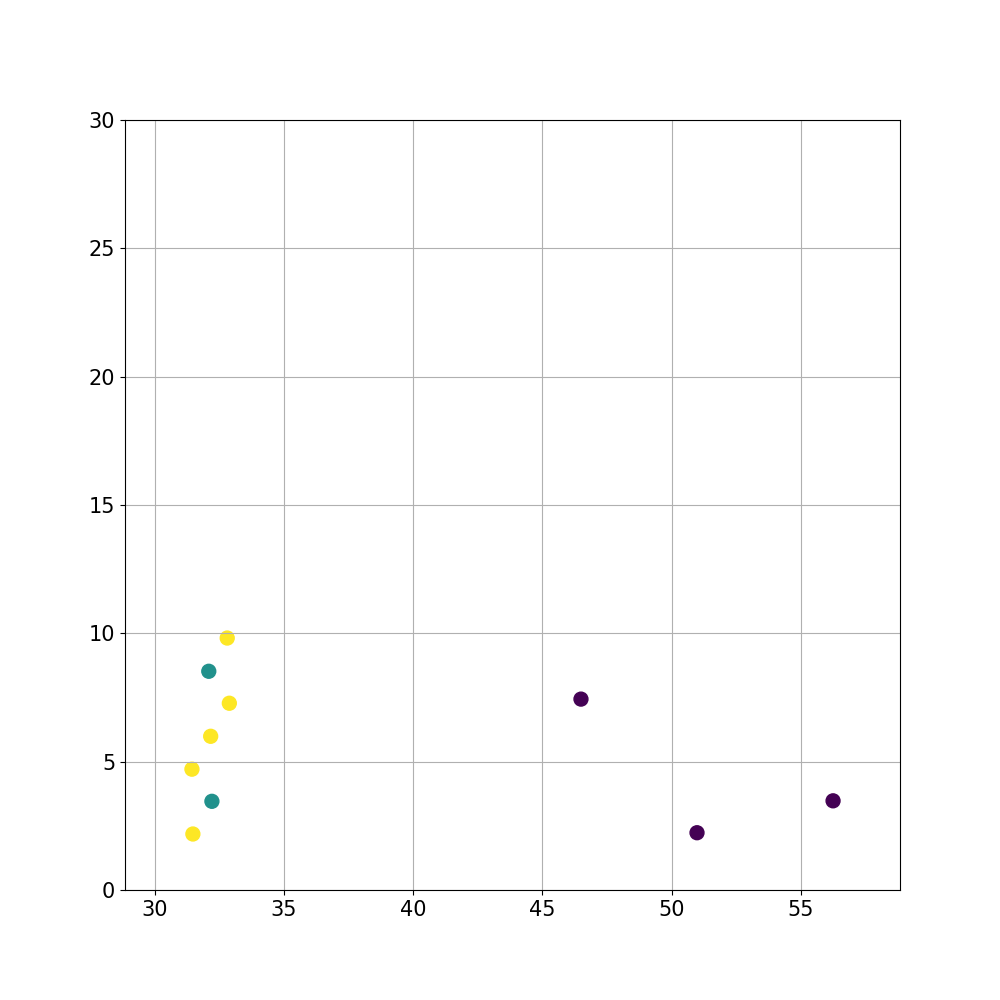

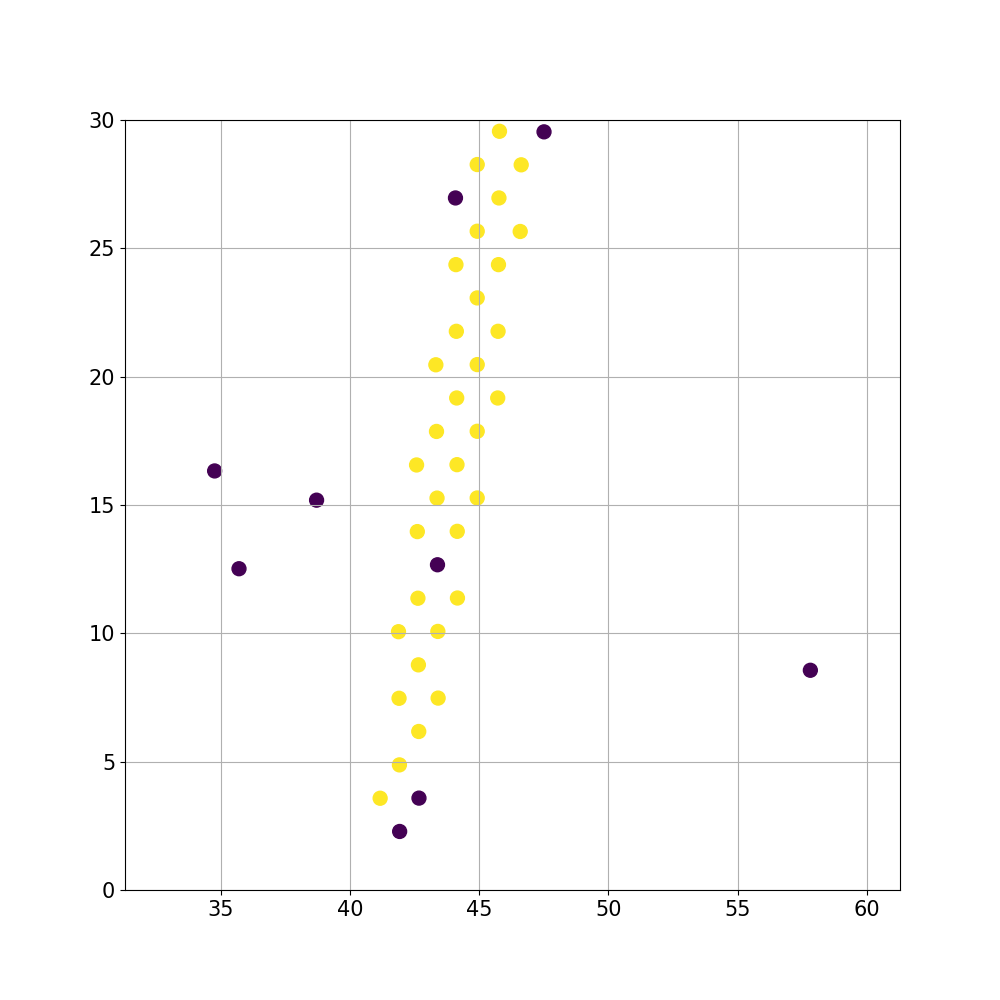

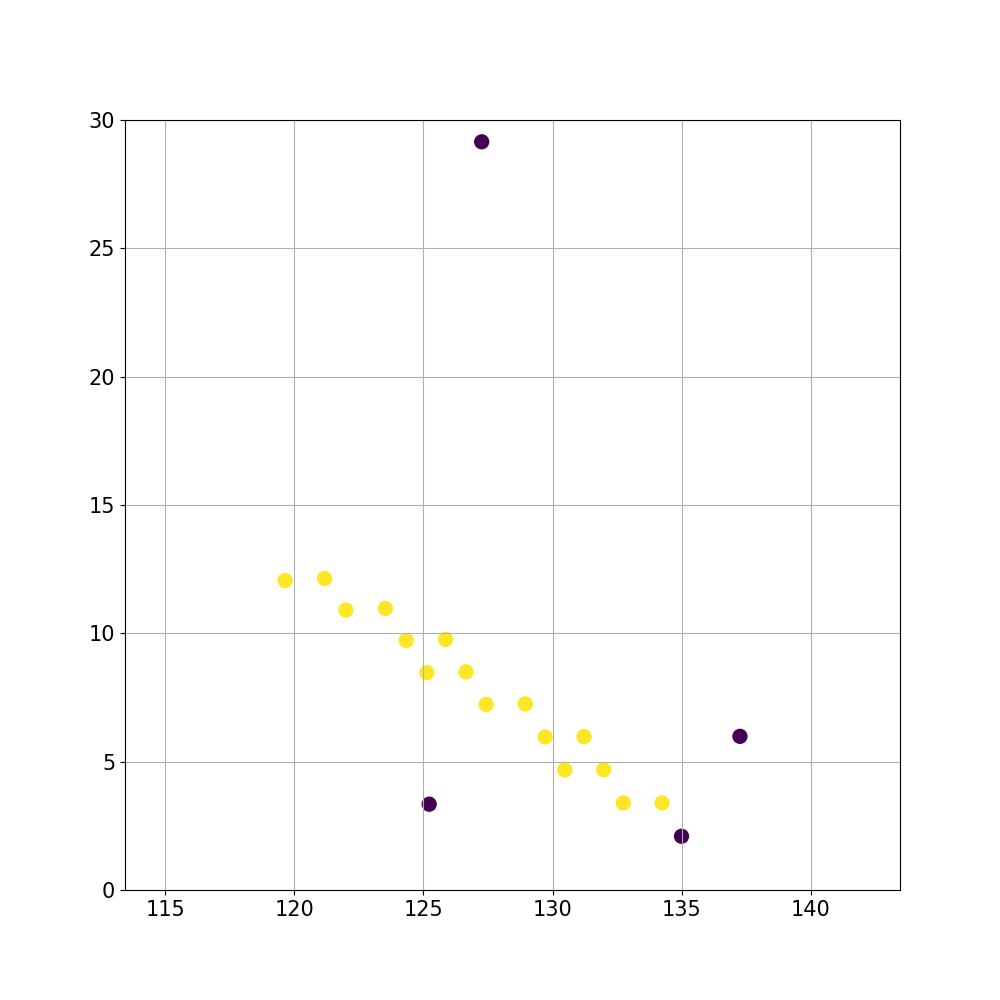

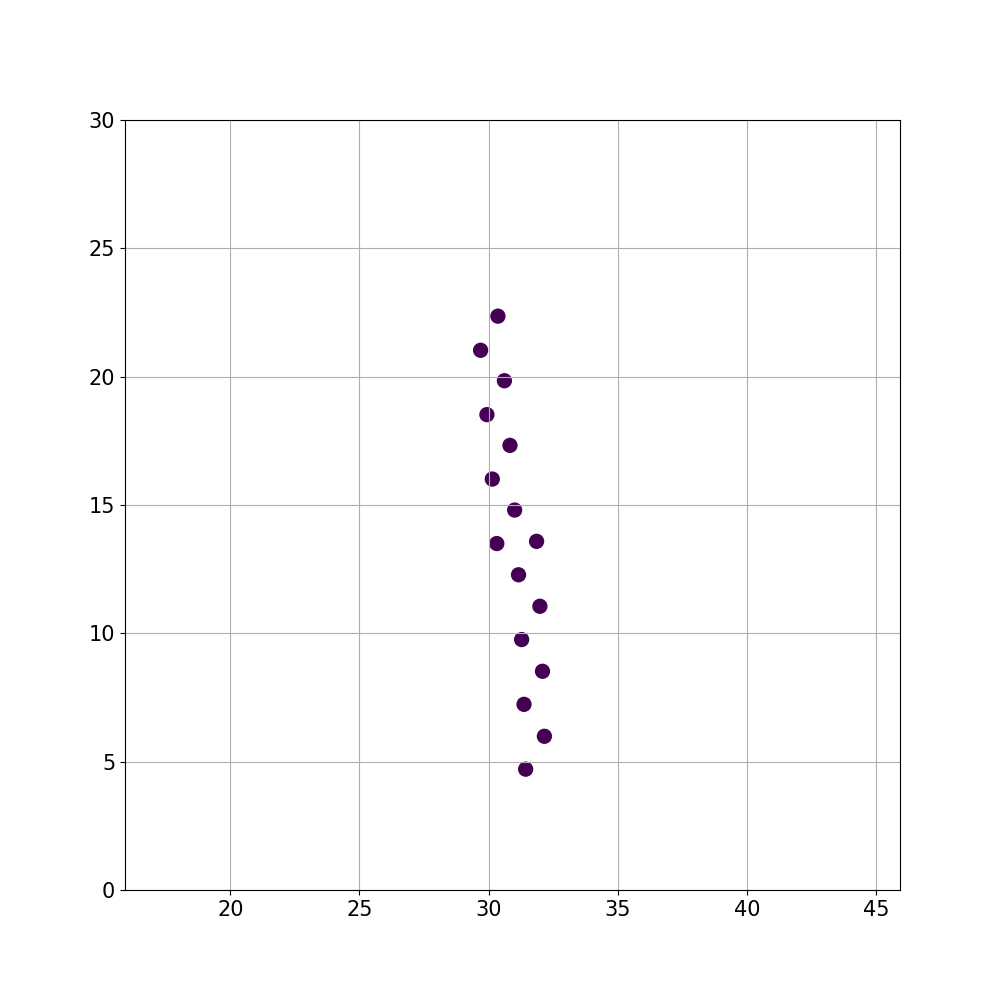

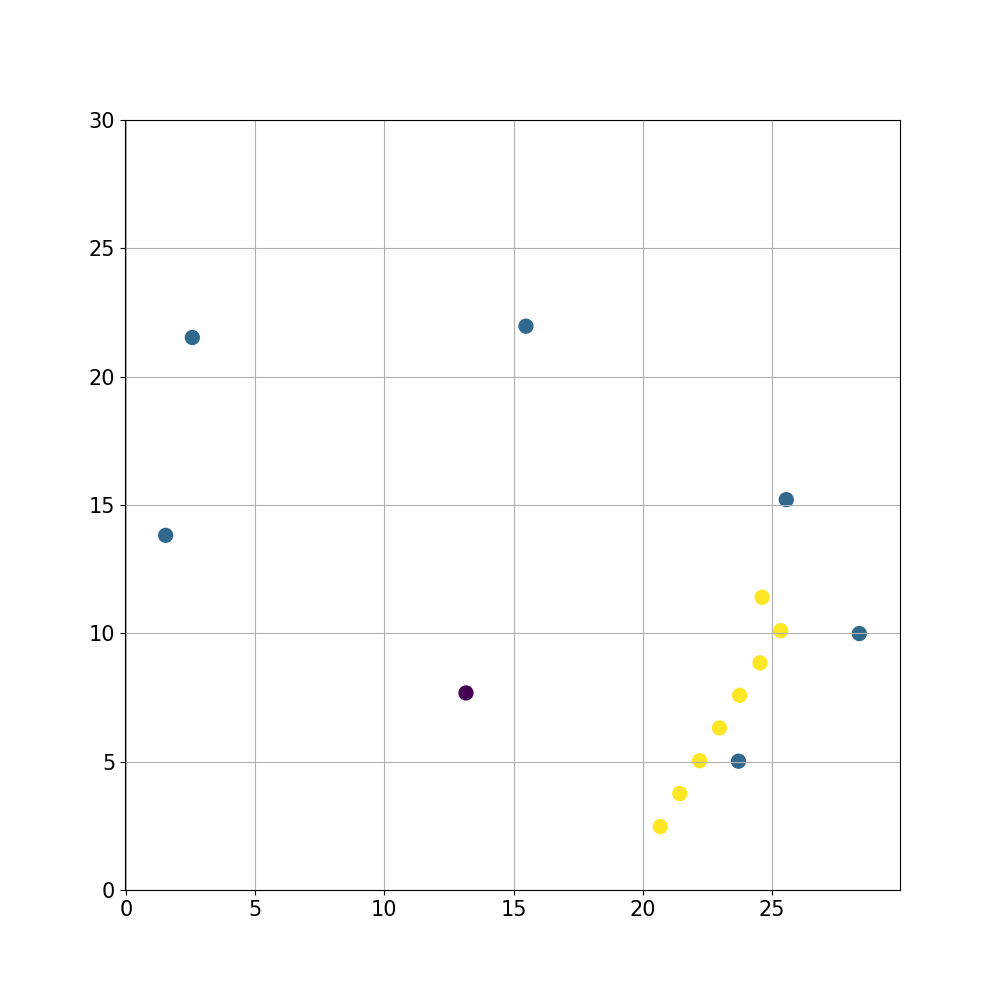

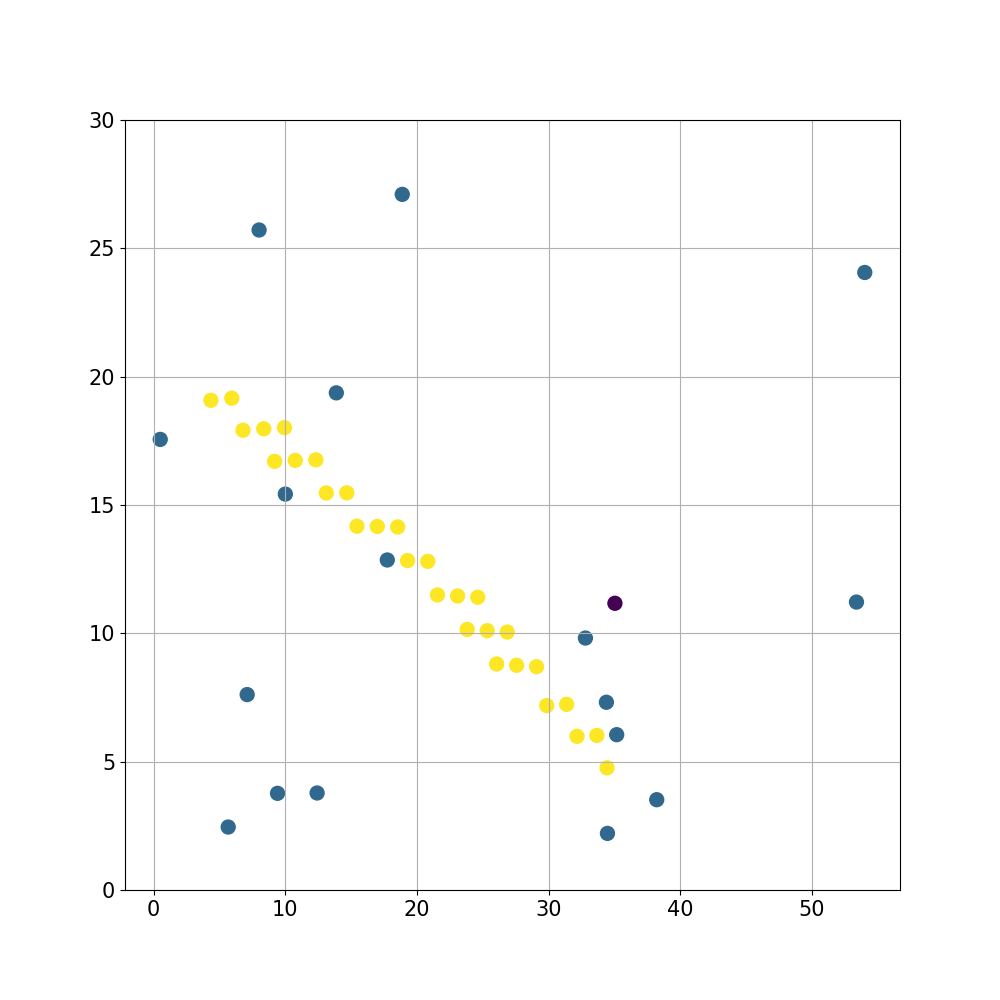

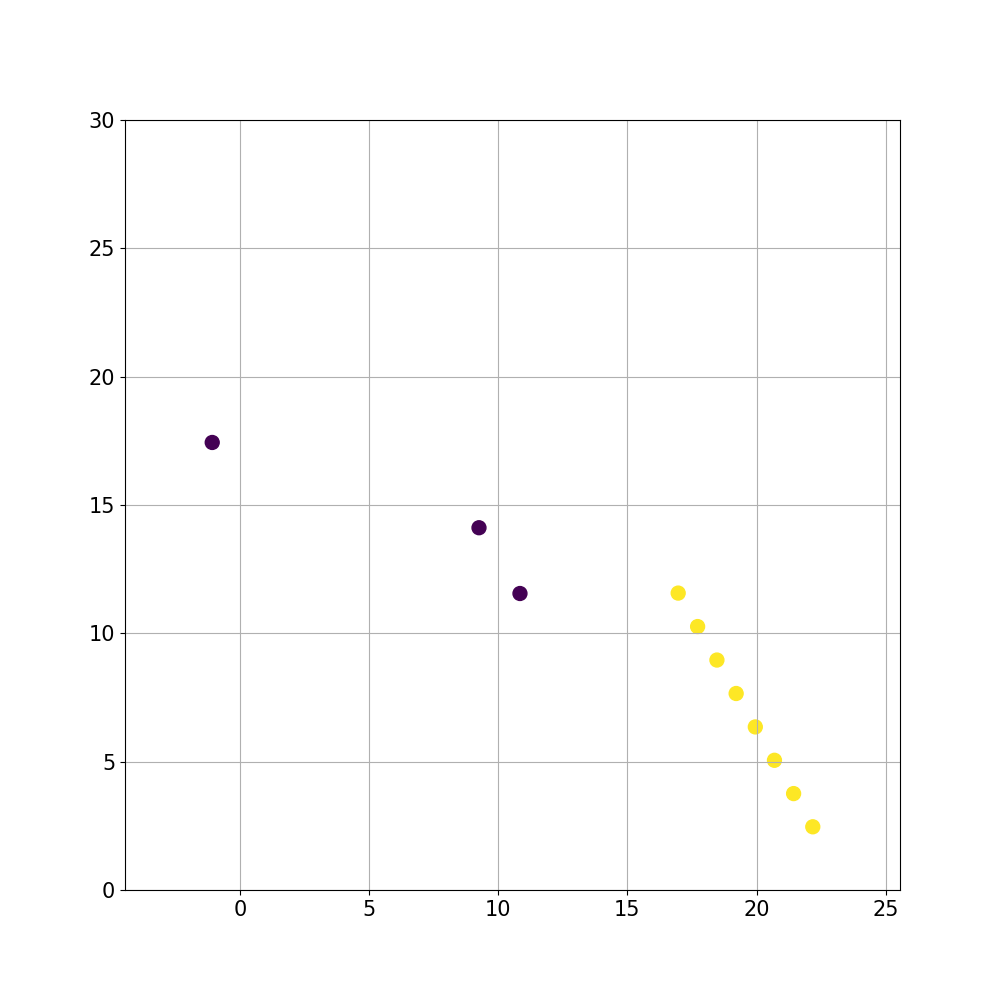

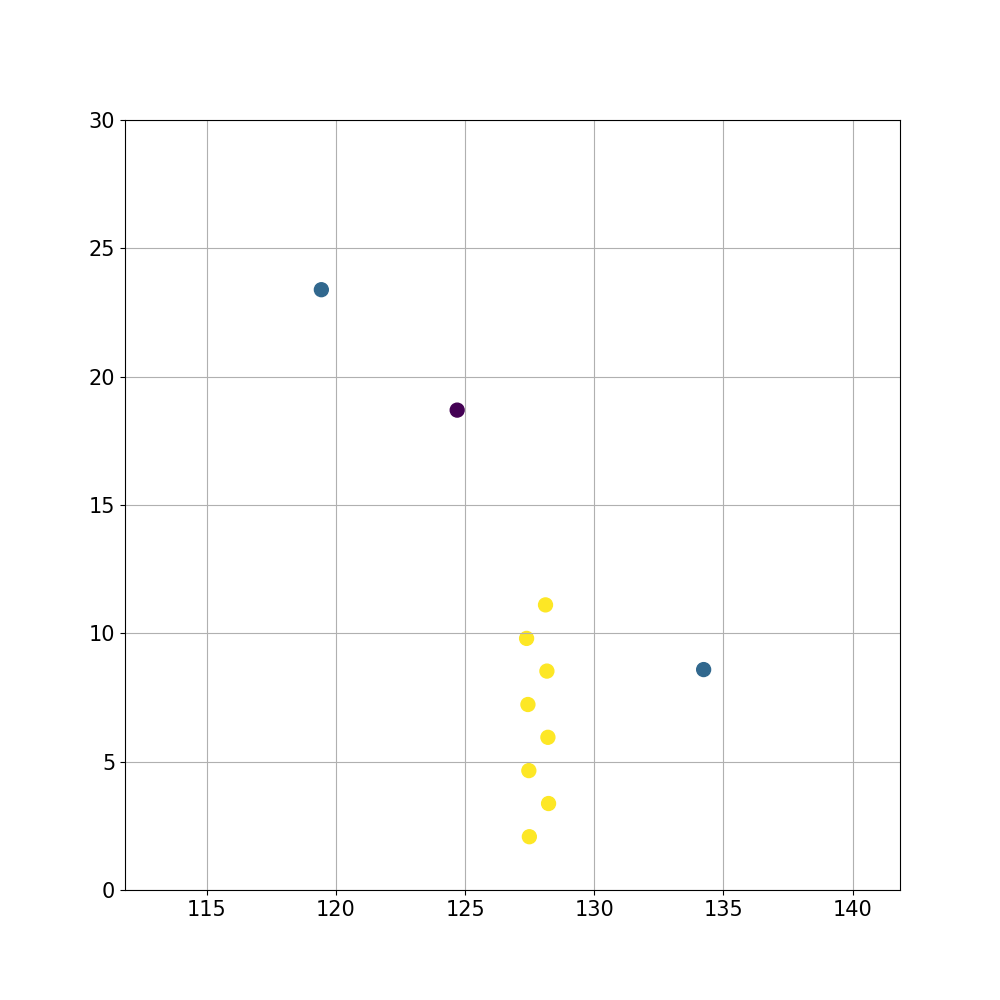

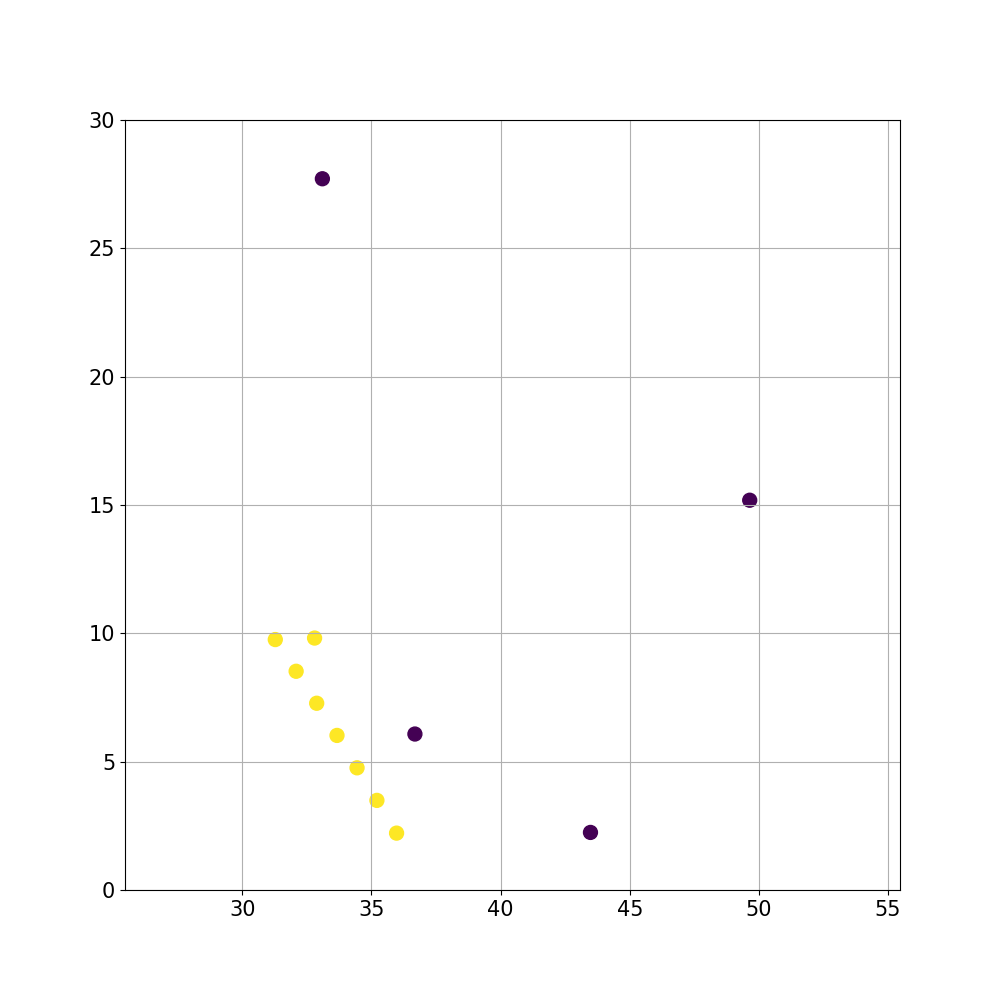

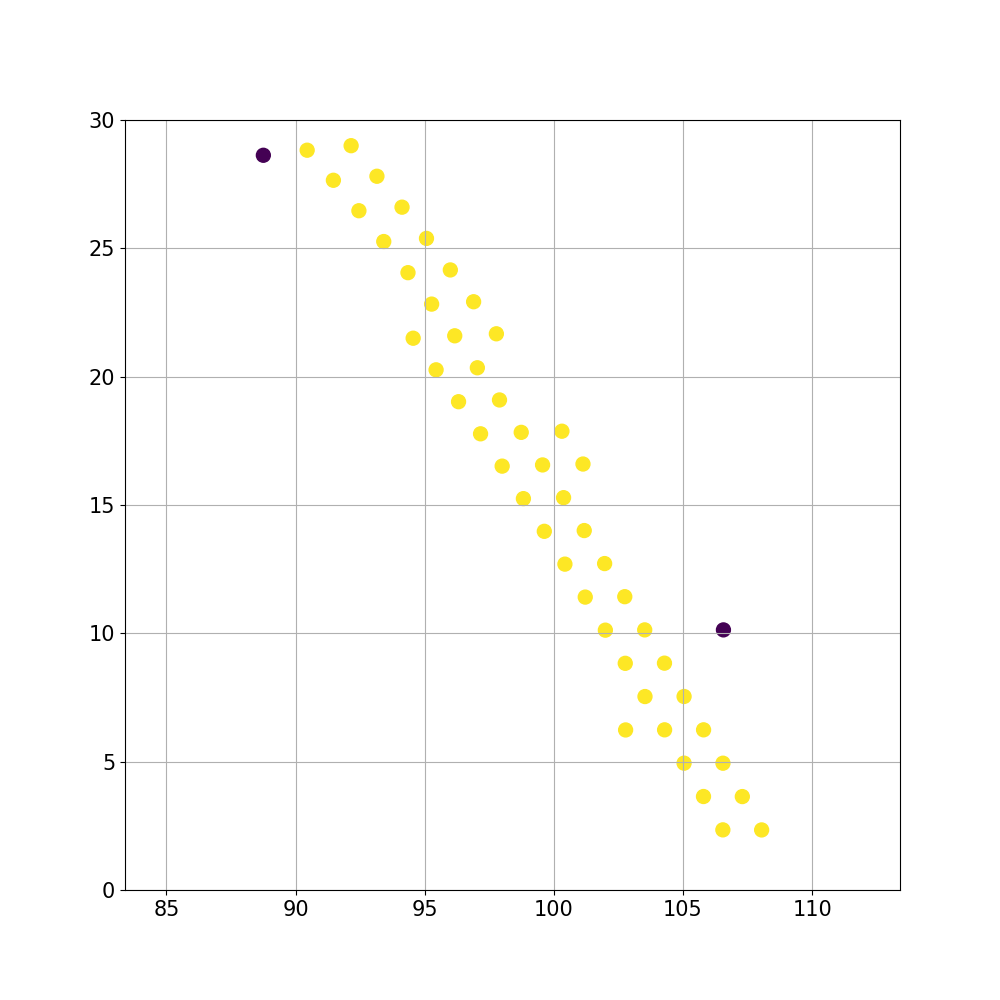

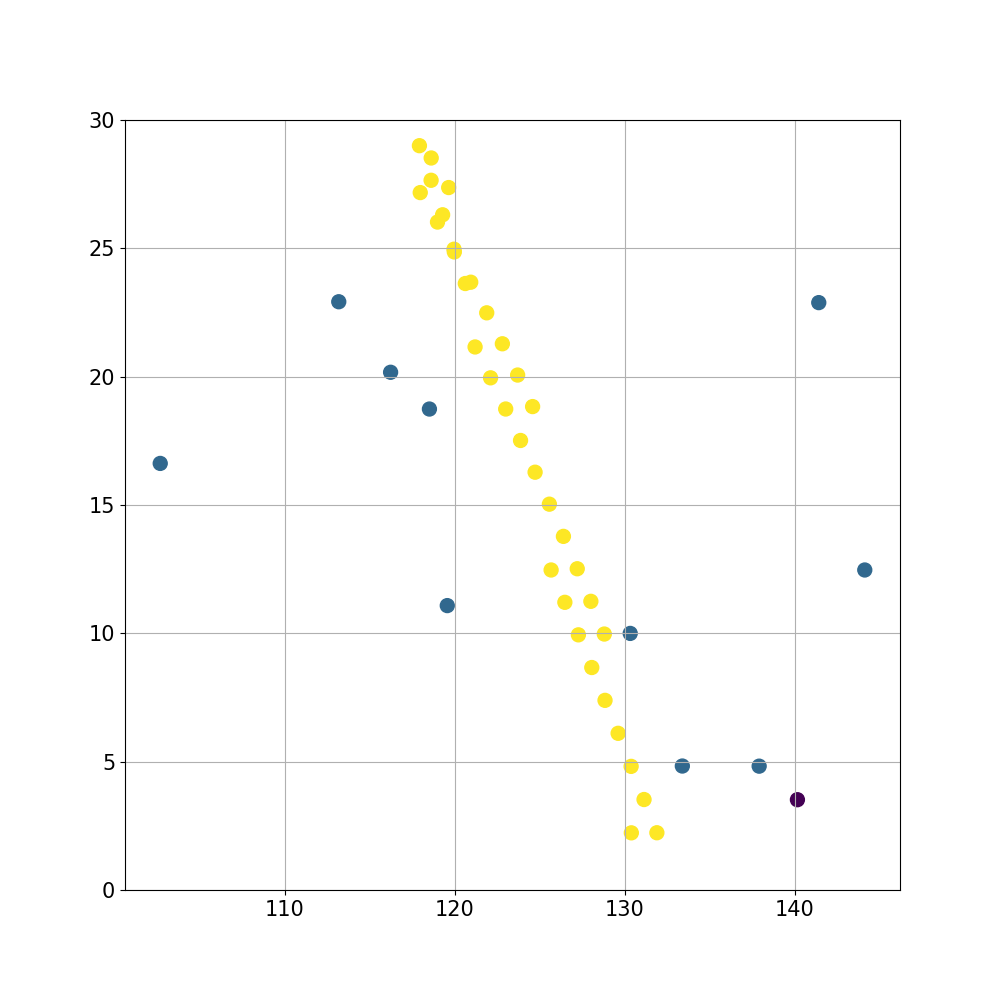

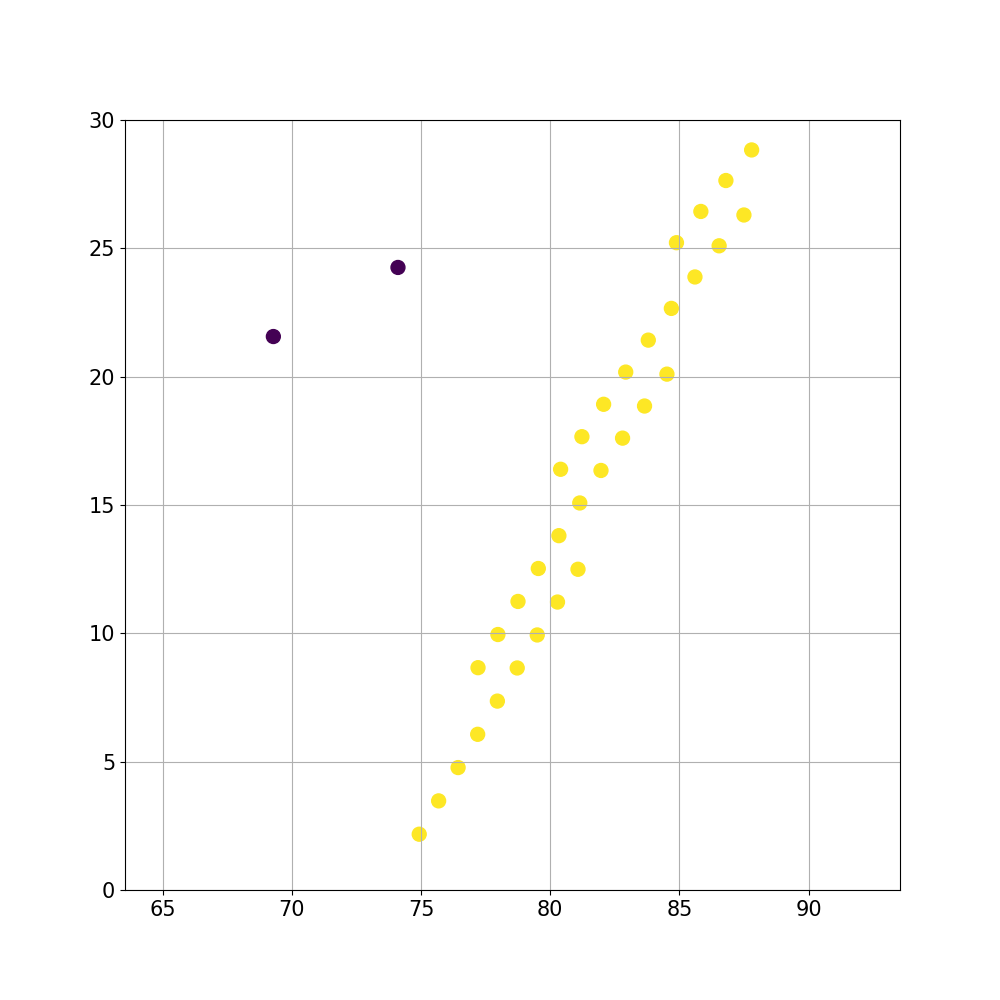

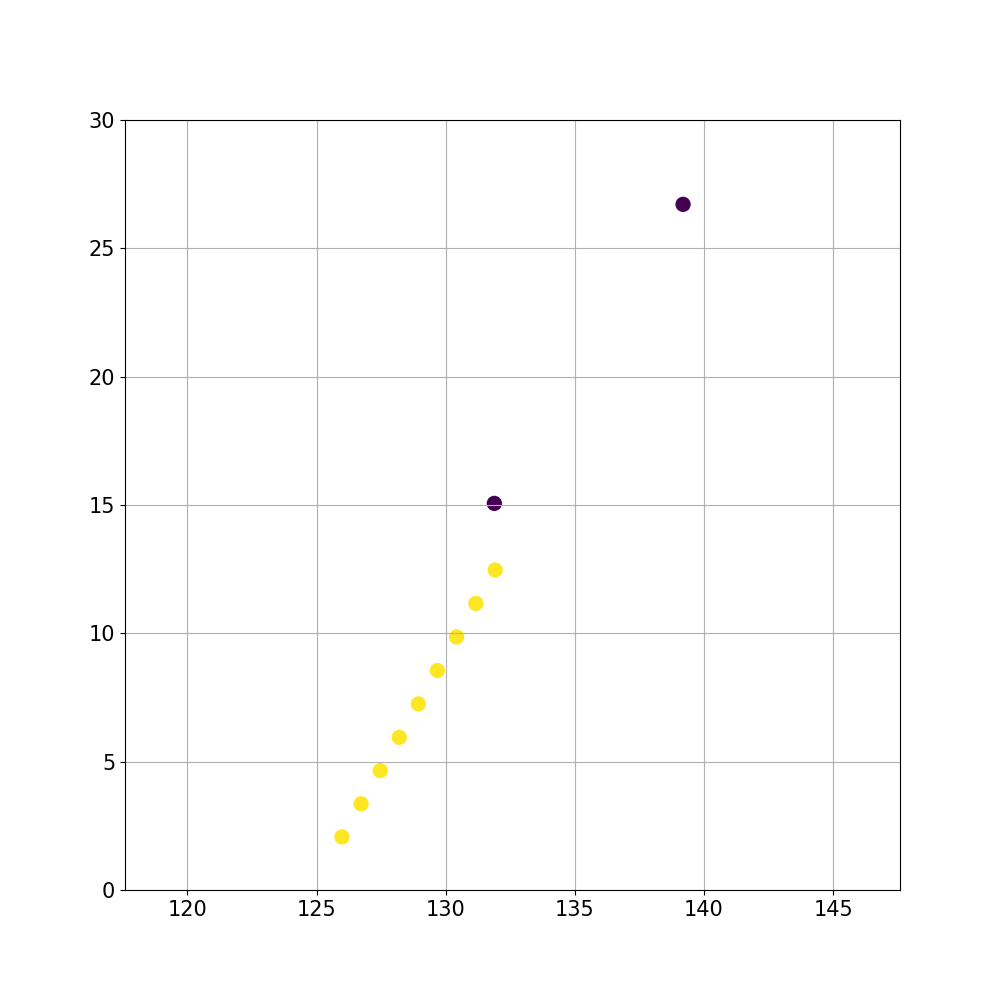

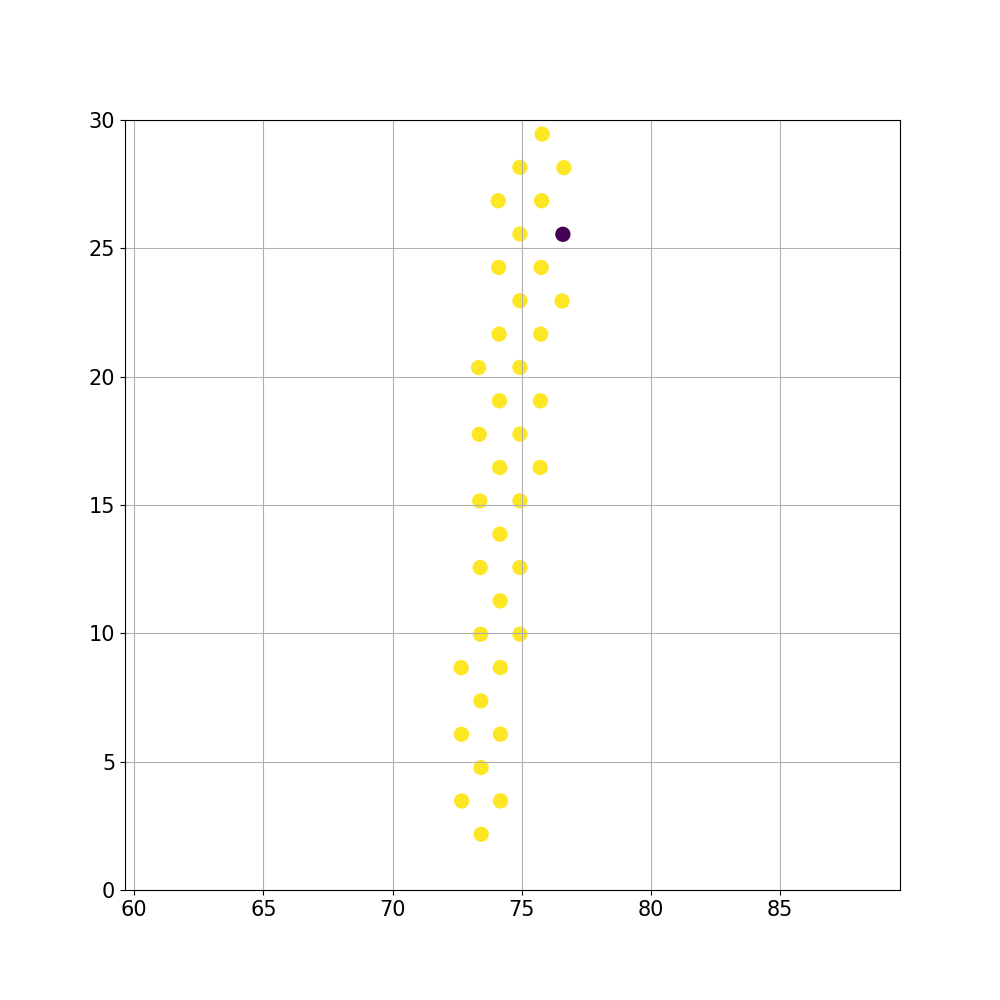

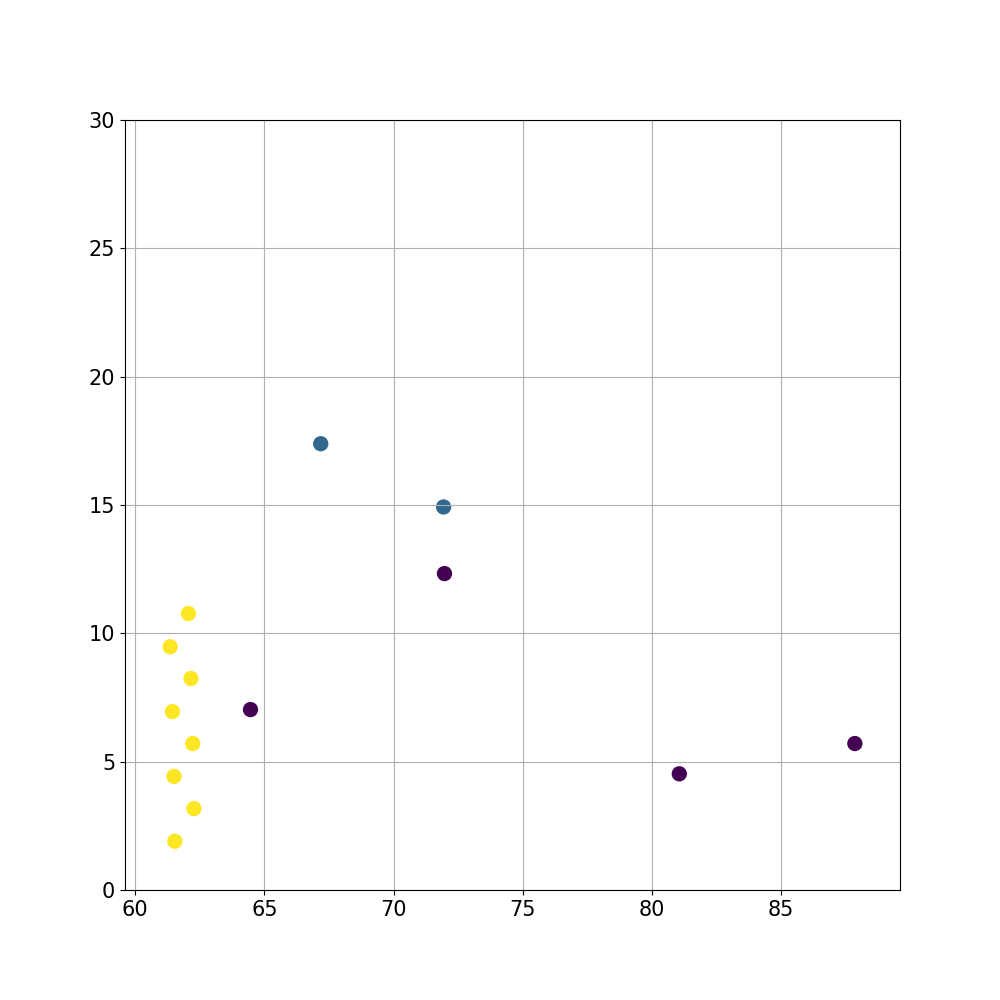

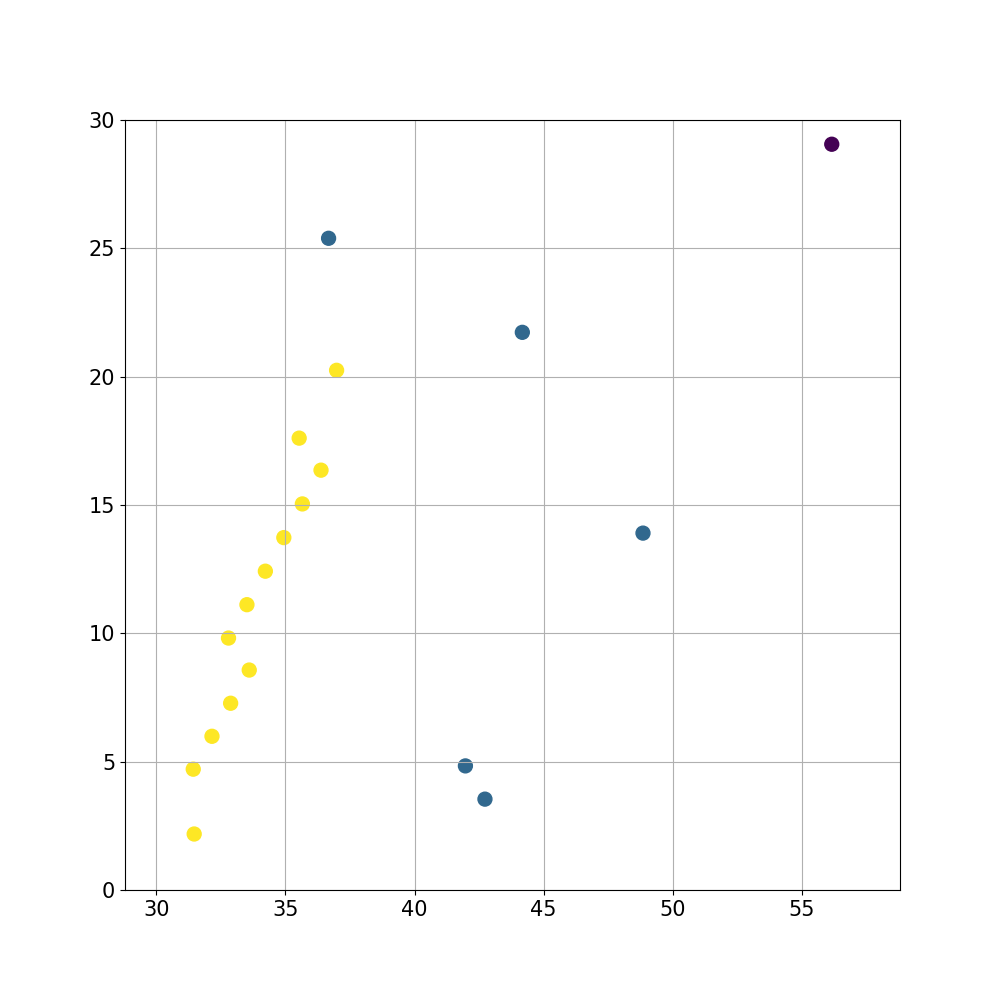

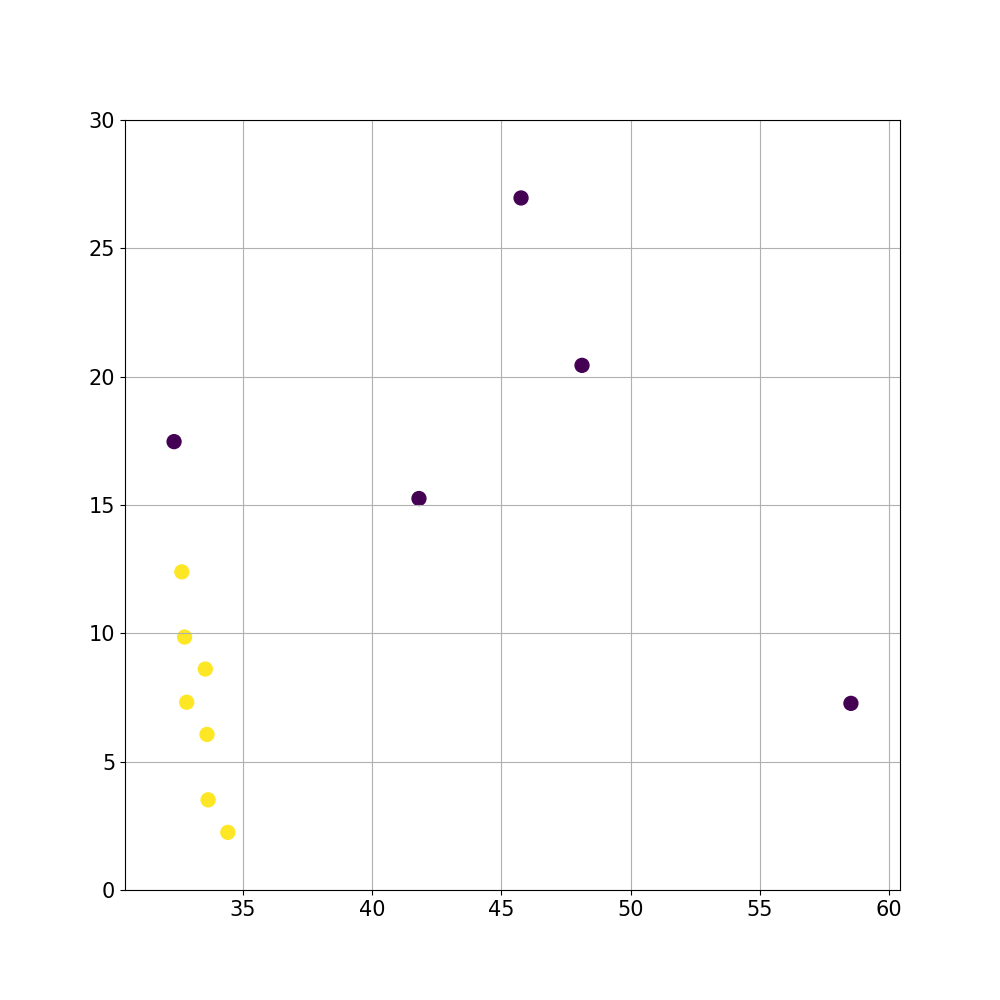

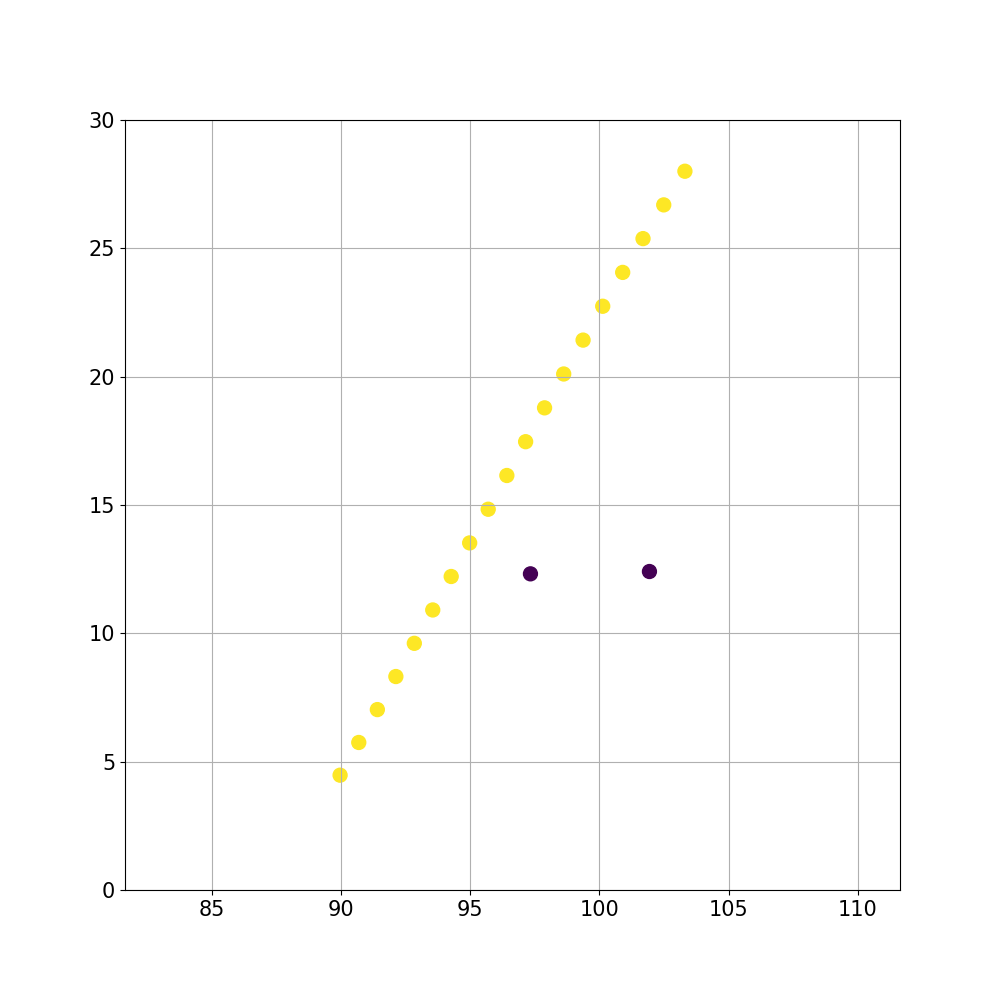

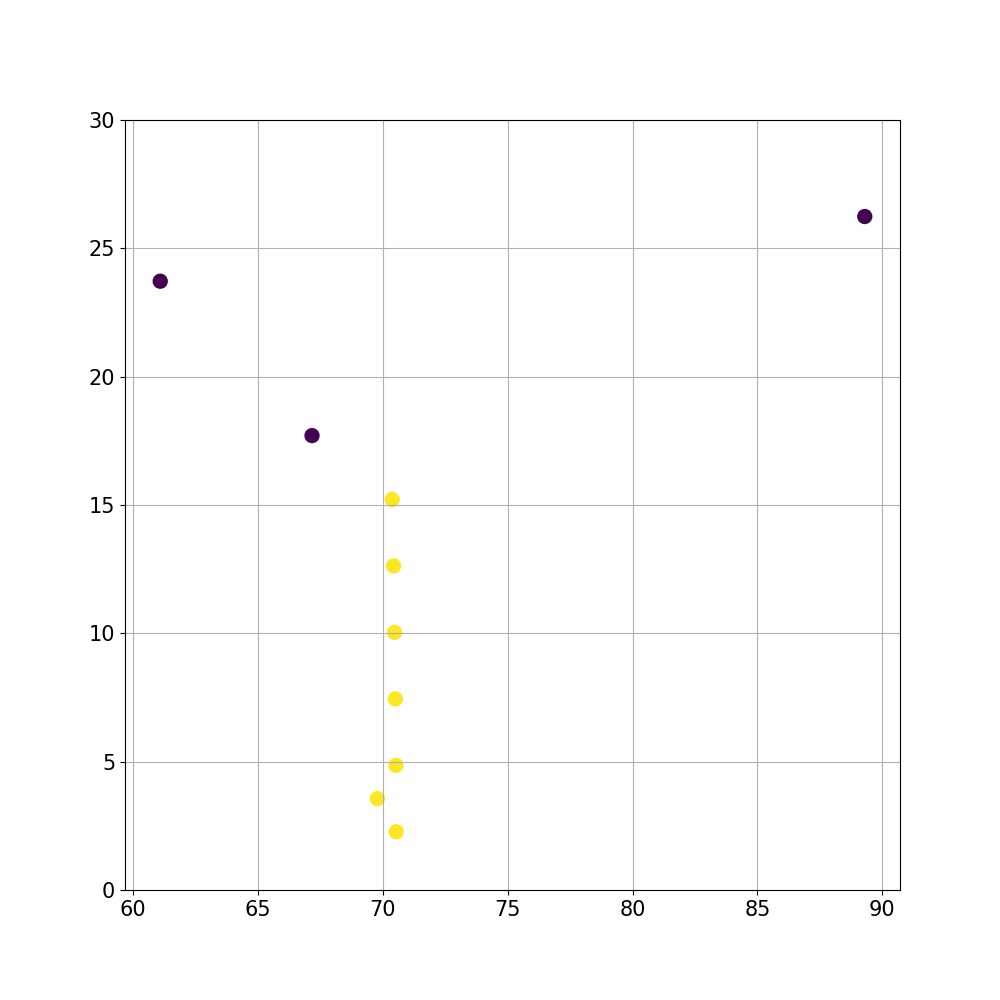

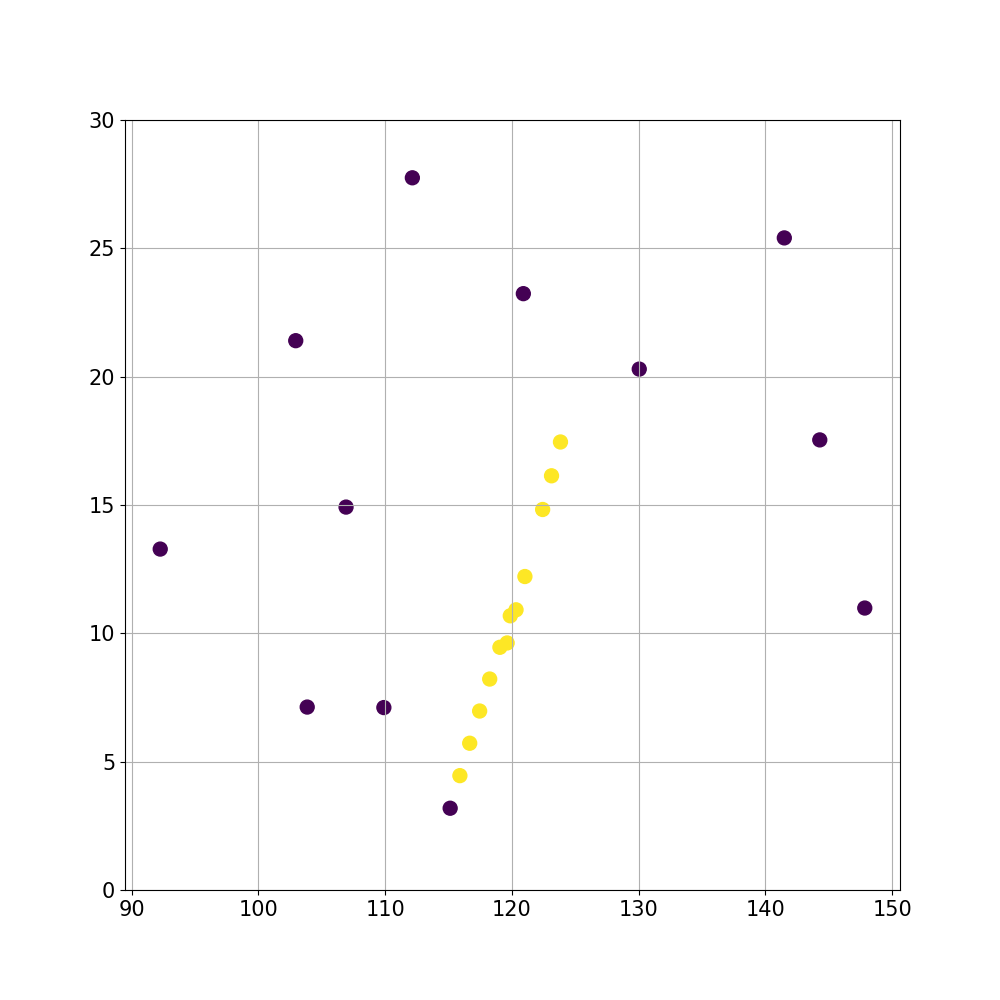

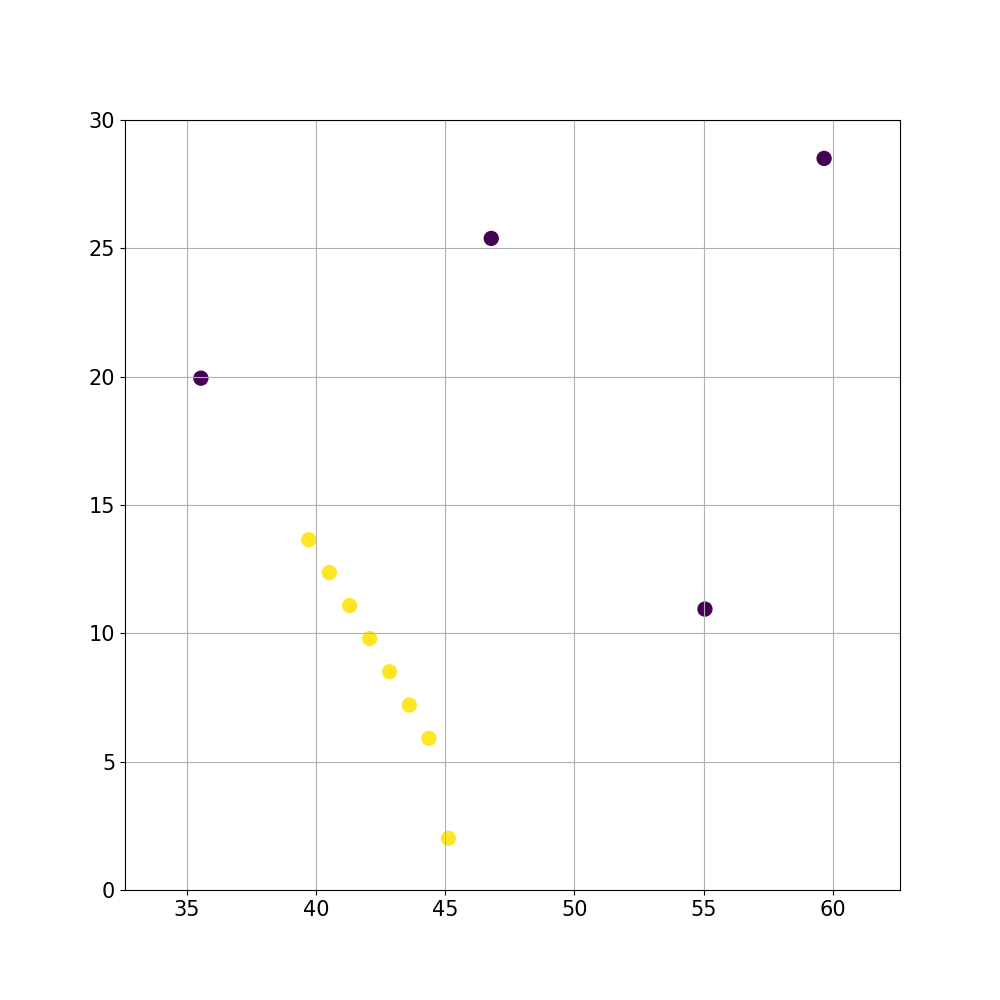

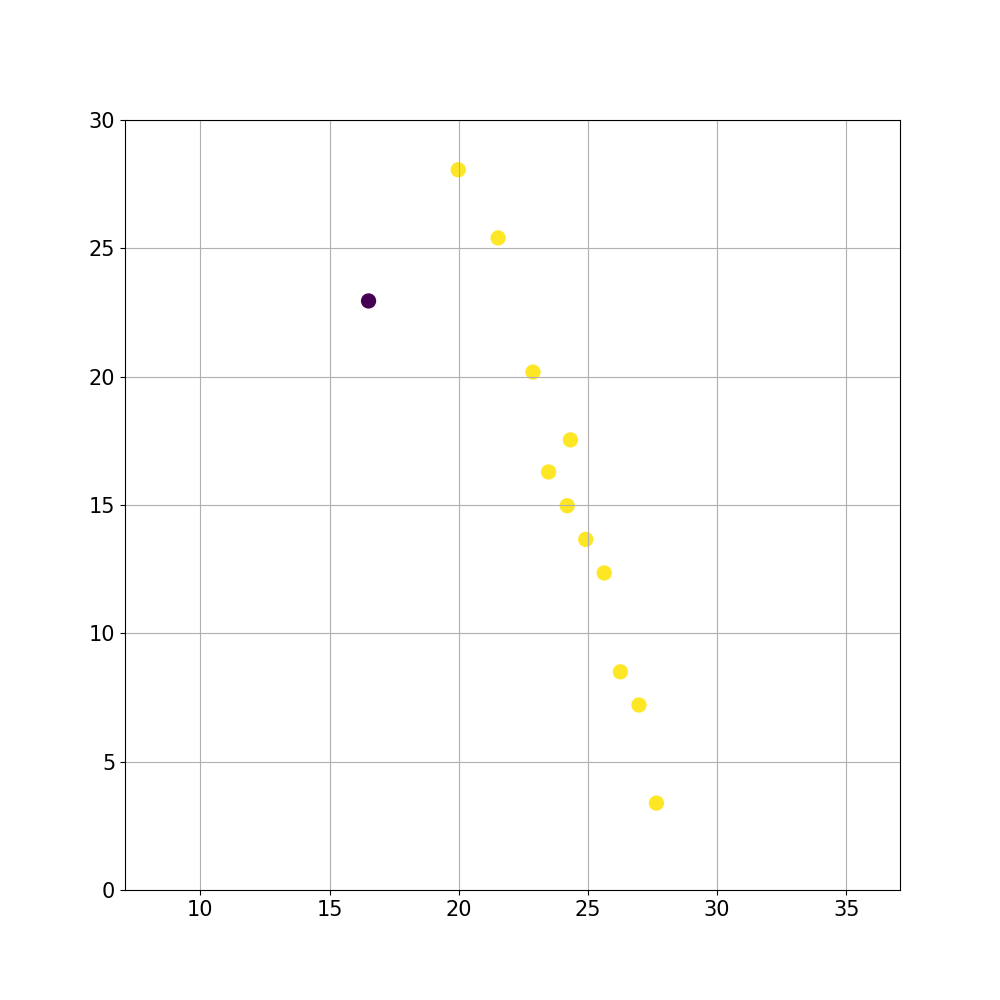

In [ ]:
for event in Dataset:
    Pix_Phi   = event.get_pixel_values('Phi')
    Pix_Theta = event.get_pixel_values('Theta')
    status    = event.get_pixel_values('Status')
    plt.figure(figsize=[10,10])
    plt.scatter(Pix_Phi,90-Pix_Theta,s=100,c=status)
    plt.grid()
    plt.ylim([0,30])

    # Check xlim of the axis
    xlim = plt.gca().get_xlim()
    # print(xlim)
    if xlim[1] - xlim[0] < 30:
        middle = (xlim[0] + xlim[1]) / 2
        plt.xlim(middle - 15, middle  + 15)

    # plt.gca().invert_xaxis()
    plt.show()

# Previous Code can be found in TestingDataset_0.ipynb
